In [1]:
from functions_audio_model import *
import pickle
import torchaudio as torchaudio
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython.display import Audio
import os
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Model, Wav2Vec2Config, Wav2Vec2CTCTokenizer, AdamW
import json
from torch.utils.data import DataLoader, random_split
from torch import nn



In [ ]:

# Directory containing the videos
video_dir = 'utterances_final/'

# Directory to save the extracted audio
audio_dir = 'audio_files/'

# Get a list of all video files in the directory
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

# Process each video file
for video_file in video_files:
    # Load the video file
    clip = VideoFileClip(os.path.join(video_dir, video_file))
    
    # Extract the audio
    audio_file = video_file.replace('.mp4', '.wav')
    clip.audio.write_audiofile(os.path.join(audio_dir, audio_file))

In [22]:
Audio('audio_files/2_626.wav')


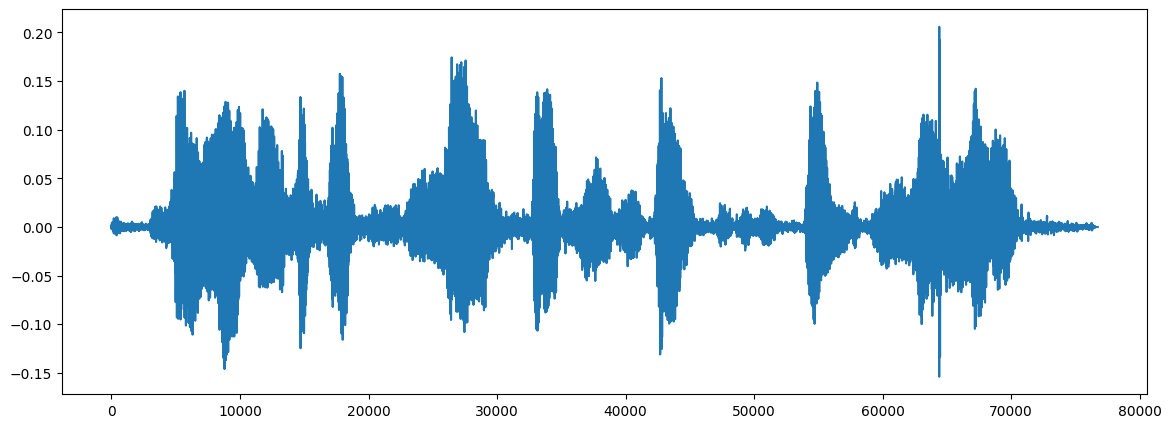

In [21]:
audio, sr = librosa.load('audio_files/2_626.wav', sr=22050)

# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.show()


In [10]:
# Load the pre-trained HuBERT model
model = Wav2Vec2Model(Wav2Vec2Config())
model.config


Wav2Vec2Config {
  "activation_dropout": 0.1,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.0,
  "feat_quantizer_dropout": 0.0,
  "final_dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3

In [4]:
import torch
from torch.utils.data import Dataset
import torchaudio

# Load the pre-trained HuBERT tokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained('facebook/hubert-large-ls960-ft')


# PyTorch Dataset
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.max_length = max([len(waveform) for waveform in self.data])
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform = self.data[idx]
        
        # If the waveform is shorter than max_length, pad it with zeros
        if len(waveform) < self.max_length:
            waveform = torch.nn.functional.pad(
                waveform, (0, self.max_length - len(waveform))
            )
        
        # Get the corresponding label
        label = self.labels[idx]
        
        return waveform, label


data=[]
# Directory containing the audio files
audio_dir = 'audio_files'

# Get a list of all files in the directory
files = os.listdir(audio_dir)

wav_files = [f for f in files if f.endswith('.wav')]

for file in wav_files:
    wv, _ = torchaudio.load(os.path.join(audio_dir, file))
    # Averaging the two channels of the stereo audio to create a mono audio waveform?
    wv = wv.mean(dim=0, keepdim=True)
    data.append(wv)

#squeezing to get rid of one dimension? which one??????
data = [tensor.squeeze() for tensor in data]

with open('sarcasm_data.json') as f:
    text_data = json.load(f)
    # Extract sarcasm labels
    sarcasm_labels = {k: int(v['sarcasm']) for k, v in text_data.items()}

dataset = AudioDataset(data, list(sarcasm_labels.values()))

In [7]:
with open('sarcasm_data.json') as f:
    text_data = json.load(f)
    # Extract sarcasm labels
    sarcasm_labels = {k:int(v['sarcasm']) for k, v in text_data.items()}

print(list(sarcasm_labels.values()))

[1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [8]:
data=[]
# Directory containing the audio files
audio_dir = 'audio_files'

# Get a list of all files in the directory
files = os.listdir(audio_dir)

wav_files = [f for f in files if f.endswith('.wav')]
for file in wav_files:
    wv, _ = torchaudio.load(os.path.join(audio_dir, file))
    #averaging the two channels of the stereo audio to create a mono audio waveform?
    wv = wv.mean(dim=0, keepdim=True)
    data.append(wv)


In [3]:
print(len(data[0]))

309582


In [10]:
# Directory containing the audio files
audio_dir = 'audio_files'

# Get a list of all files in the directory
files = os.listdir(audio_dir)

wav_files = [f for f in files if f.endswith('.wav')]
print(wav_files)

['1_11201.wav', '1_506.wav', '2_406.wav', '2_374.wav', '2_189.wav', '1_9971.wav', '1_2830.wav', '1_1478.wav', '2_604.wav', '2_162.wav', '2_176.wav', '1_11177.wav', '2_54.wav', '1_3333.wav', '2_97.wav', '2_599.wav', '1_2575.wav', '2_228.wav', '2_572.wav', '1_7357.wav', '1_1732.wav', '1_3125.wav', '2_567.wav', '1_8717.wav', '2_573.wav', '1_467.wav', '1_4850.wav', '1_7395.wav', '2_598.wav', '2_96.wav', '1_6504.wav', '2_55.wav', '1_12331.wav', '2_69.wav', '1_5964.wav', '2_177.wav', '2_611.wav', '2_163.wav', '1_2616.wav', '2_188.wav', '1_2819.wav', '2_413.wav', '2_375.wav', '2_361.wav', '2_407.wav', '1_7593.wav', '1_507.wav', '1_3911.wav', '2_388.wav', '1_9594.wav', '2_439.wav', '2_377.wav', '1_10849.wav', '2_405.wav', '1_1484.wav', '1_3293.wav', '1_9972.wav', '1_3287.wav', '1_2614.wav', '1_6472.wav', '2_149.wav', '2_161.wav', '2_607.wav', '1_1296.wav', '2_43.wav', '1_4477.wav', '2_94.wav', '1_5580.wav', '2_559.wav', '2_203.wav', '2_217.wav', '2_570.wav', '2_202.wav', '1_7341.wav', '2_564.w

In [5]:
# Set the seed for reproducibility
torch.manual_seed(3141)

# Load the pre-trained HuBERT model
model = Wav2Vec2Model.from_pretrained('facebook/hubert-large-ls960-ft')

# Hyperparameters
learning_rate = 0.001
N_EPOCHS = 5
batchsize = 8

# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

# Train the model
# You need to replace `train_cycle` with your actual training function
train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'hubert_model_trained_on_augmented_set.pth')

print('Model trained and saved!')

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['encoder.layer_norm.bias', 'encoder.layer_norm.weight', 'encoder.layers.0.attention.k_proj.bias', 'encoder.layers.0.attention.k_proj.weight', 'encoder.layers.0.attention.out_proj.bias', 'encoder.layers.0.attention.out_proj.weight', 'encoder.layers.0.attention.q_proj.bias', 'encoder.layers.0.attention.q_proj.weight', 'encoder.layers.0.attention.v_proj.bias', 'encoder.layers.0.attention.v_proj.weight', 'encoder.layers.0.feed_forward.intermediate_dense.bias', 'encoder.layers.0.feed_forward.intermediate_dense.weight', 'encoder.layers.0.feed_forward.output_dense.bias', 'encoder.layers.0.feed_forward.output_dense.weight', 'encoder.layers.0.final_layer_norm.bias', 'encoder.layers.0.final_layer_norm.weigh

Epoch 0 of 5


  0%|          | 0/69 [00:00<?, ?it/s]

In [3]:
with open('audio_features.p', 'rb') as f:
    audio_data = pickle.load(f, encoding='latin1')

In [9]:
audio_data.keys()

dict_keys(['2_428', '2_429', '1_11177', '1_6020', '2_343', '2_421', '2_422', '2_423', '2_425', '2_426', '2_427', '2_154', '2_155', '2_150', '2_88', '2_259', '2_258', '2_257', '2_84', '2_87', '2_86', '2_158', '1_5699', '2_251', '2_250', '1_11055', '1_7938', '2_420', '1_11120', '1_1484', '1_5058', '1_1678', '1_4477', '1_9668', '2_517', '2_511', '2_512', '2_518', '1_1931', '2_458', '1_4576', '2_454', '2_457', '2_456', '2_450', '1_7494', '2_322', '1_7490', '2_326', '2_89', '1_5758', '2_152', '1_7575', '2_602', '2_604', '1_7089', '2_607', '2_608', '2_609', '2_135', '1_1803', '2_254', '2_253', '1_7402', '1_7400', '1_8717', '1_3256', '1_1001', '1_2797', '1_2792', '1_11051', '2_581', '1_3259', '1_971', '1_6370', '2_279', '1_1296', '1_3573', '1_9087', '1_6165', '2_118', '2_119', '1_3419', '2_112', '2_113', '2_114', '2_115', '1_9245', '1_276', '1_5953', '2_58', '2_56', '2_54', '2_55', '2_53', '2_50', '2_51', '2_558', '2_410', '2_413', '1_7487', '2_415', '2_416', '2_550', '2_552', '2_553', '2_555

In [11]:
len(audio_data)

690

In [29]:
audio_data['1_10004']

array([[-3.64841867e+02, -6.38623712e+02, -6.37643336e+02, ...,
        -2.60907560e+02, -4.86030517e+02, -6.55578375e+02],
       [-1.43106713e+02, -2.66971843e+01,  3.64553321e+01, ...,
         6.70629783e+01,  6.09073737e+00, -1.30603354e+00],
       [ 1.47457112e+01, -1.53326644e+01,  1.42512152e+00, ...,
        -8.49348288e+01, -5.27214055e+01,  4.55785799e+00],
       ...,
       [-6.91741713e-04, -1.28725766e-04,  1.31362894e-05, ...,
        -2.12576711e-05, -1.10401556e-05, -9.80341918e-06],
       [-7.03976314e-03, -1.20082803e-03,  6.02770721e-06, ...,
        -7.78735079e-05, -1.21788428e-05, -3.35468768e-07],
       [ 5.99612813e+03,  4.59301100e+03,  3.02728727e+03, ...,
         1.88314120e+03,  1.94082957e+03,  1.92226887e+03]])

In [15]:
len(audio_data['2_183'])

283

In [61]:
Audio(audio_data['2_183'], rate=22050)

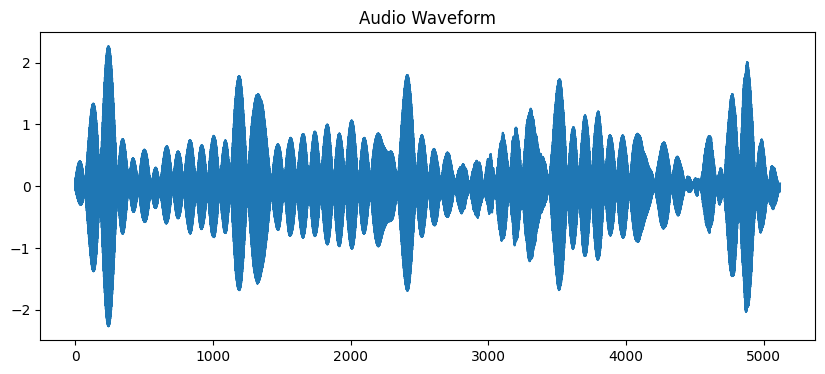

In [64]:
# Assuming audio_data is a numpy array representing your Mel spectrogram
audio_waveform = librosa.feature.inverse.mel_to_audio(audio_data['1_11177'])

# Plot the waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(audio_waveform)
plt.title('Audio Waveform')
plt.show()

Audio(audio_waveform, rate=22050)


In [35]:
audio_waveform


array([-0.19118543,  0.2252591 , -0.2108514 , ..., -0.17873332,
        0.19129844, -0.21670094], dtype=float32)

In [63]:
# Slow down by a factor of 2 without changing the pitch
audio_slow = librosa.effects.time_stretch(audio_waveform,rate = 0.05)

Audio(audio_slow, rate=22050)

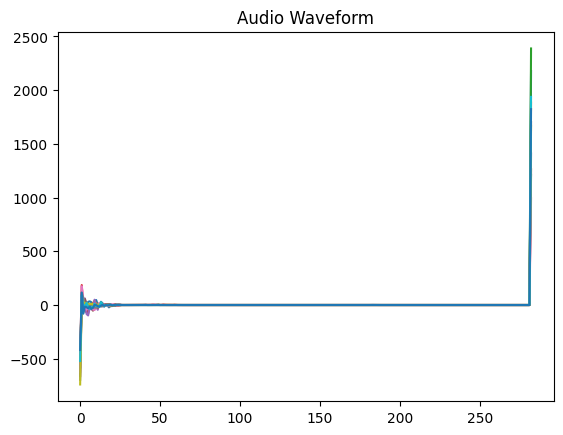

In [60]:
import matplotlib.pyplot as plt
from IPython.display import Audio

# Assuming audio_data is a numpy array representing your audio waveform
plt.plot(audio_data['2_186'])
plt.title("Audio Waveform")
plt.show()

# Play the audio
Audio(audio_data['2_186'], rate=22050)  # replace sample_rate with the actual sample rate of your audio

In [19]:
torchaudio.load(audio_data)



RuntimeError: torchaudio_sox::load_audio_file() Expected a value of type 'str' for argument '_0' but instead found type 'dict'.
Position: 0
Value: {'2_428': array([[-4.36145110e+02, -5.46869049e+02, -4.88708849e+02, ...,
        -5.42660695e+02, -4.69054215e+02, -5.26575950e+02],
       [ 1.23446741e+01,  1.48794547e+01,  5.21176391e+01, ...,
         1.39958712e+01,  4.97463618e+01,  5.04830199e+01],
       [ 1.04365594e+01,  2.14215421e+00,  2.09172564e+01, ...,
        -2.48318446e+01, -2.54975040e+01, -3.76790645e+01],
       ...,
       [-1.40062720e-05, -2.61366282e-06,  3.56163732e-06, ...,
        -8.45348467e-09,  3.88119205e-06, -3.98324605e-06],
       [ 1.11511628e-07, -7.21537262e-07,  2.10008799e-06, ...,
        -1.32766940e-08,  2.00899394e-07, -2.25379393e-07],
       [ 2.88833903e+03,  2.27881312e+03,  2.33817064e+03, ...,
         2.19223889e+03,  2.00339588e+03,  2.16926839e+03]]), '2_429': array([[-5.44348963e+02, -6.32279891e+02, -5.30344454e+02, ...,
        -6.95808754e+02, -5.37472296e+02, -5.65817199e+02],
       [ 4.15570284e+01,  5.80523330e+01,  7.16176961e+01, ...,
         5.06374298e+01,  8.45885704e+01,  1.38693467e+02],
       [-8.10278046e+01, -4.34067110e+01, -2.96745002e+01, ...,
         1.17701561e+01, -2.54200516e+01, -3.22035816e+01],
       ...,
       [-3.72207913e-08,  6.87450186e-07, -6.99383627e-07, ...,
        -2.44477111e-07, -1.20383144e-07, -3.75495036e-06],
       [-3.30265249e-07,  2.77198762e-06, -2.84049598e-06, ...,
        -2.84655045e-07, -5.53035106e-08, -1.07361597e-06],
       [ 2.14119427e+03,  2.01028090e+03,  2.09640650e+03, ...,
         2.10950856e+03,  2.05166055e+03,  1.97282500e+03]]), '1_11177': array([[-5.67252528e+02, -6.66144838e+02, -4.77110391e+02, ...,
        -5.66348215e+02, -3.04194301e+02, -3.60585544e+02],
       [-1.63023614e+01,  1.55167359e+01, -2.55992603e+01, ...,
         6.61516812e+01,  1.09416452e+02,  1.09377944e+02],
       [-3.14205114e+00, -1.17780578e+01, -3.56747867e+01, ...,
        -2.32316247e+01, -4.44034179e+01, -5.81958045e+01],
       ...,
       [-1.10237281e-05, -2.69355486e-06,  4.85886406e-06, ...,
        -3.88319979e-06,  1.13750248e-05, -1.18486379e-05],
       [-1.00268022e-05, -1.64602533e-06,  6.22785188e-06, ...,
        -1.10294084e-06,  8.74664230e-06, -9.26408275e-06],
       [ 2.24001149e+03,  1.75422198e+03,  2.86922890e+03, ...,
         1.78323717e+03,  1.70728159e+03,  1.70159766e+03]]), '1_6020': array([[-3.22435594e+02, -4.33063659e+02, -4.27261309e+02, ...,
        -5.48671717e+02, -4.60746952e+02, -4.33393592e+02],
       [ 1.69244305e+02,  9.43000734e+01,  3.06568403e+01, ...,
         4.16190605e+01,  8.82265508e+01,  1.03281015e+02],
       [-2.66658109e+01, -2.16716412e+01, -2.80774058e+01, ...,
         4.56645835e+00,  2.15909826e+01, -2.54945703e+01],
       ...,
       [ 3.57082930e-06,  2.00165286e-05,  2.86680819e-05, ...,
        -1.00099392e-08,  7.26322726e-07, -1.04509898e-05],
       [ 1.27001498e-05,  4.19424541e-05,  1.07634034e-06, ...,
        -8.74959558e-09,  8.22224563e-07, -2.63019310e-06],
       [ 1.56566256e+03,  1.69301583e+03,  2.10045851e+03, ...,
         2.00534581e+03,  1.71543002e+03,  1.66247073e+03]]), '2_343': array([[-5.96328623e+02, -4.18925974e+02, -3.51675952e+02, ...,
        -3.09882171e+02, -4.22152363e+02, -5.26154035e+02],
       [-1.41156541e+01,  6.79347705e+00, -8.37147580e+00, ...,
         2.70005377e+01,  5.26093600e+01, -4.96896837e+01],
       [ 6.72315711e+00,  2.07896709e+01,  1.74471258e+01, ...,
        -3.08062192e+00, -6.67998089e+01, -2.37590116e+01],
       ...,
       [ 1.72833393e-02,  1.03098081e-03, -7.09364109e-05, ...,
        -1.16327213e-04, -1.21676565e-04,  3.13246438e-06],
       [ 1.25014039e-02,  1.22473686e-03, -6.33623456e-05, ...,
        -7.26736460e-05, -5.25649478e-05,  9.13790041e-06],
       [ 3.21439973e+03,  2.71790616e+03,  2.84980395e+03, ...,
         2.28052153e+03,  1.65439977e+03,  2.74335999e+03]]), '2_421': array([[-4.67895016e+02, -6.15421617e+02, -5.04015403e+02, ...,
        -3.88241297e+02, -3.93326502e+02, -4.75979550e+02],
       [ 4.20679745e+00,  5.42796235e+01,  7.18938000e+01, ...,
         4.83640061e+01,  8.14696042e+01,  5.15087527e+01],
       [ 5.17563240e+01, -8.52838030e+00, -1.41331589e+01, ...,
        -1.45036269e+01, -9.50782889e+01, -1.96440618e+01],
       ...,
       [-1.93245531e-04, -3.62507470e-05,  5.15225518e-09, ...,
        -2.26709596e-04,  1.49201473e-06, -1.69507041e-06],
       [-4.76349216e-04, -8.86771279e-05,  3.84122640e-09, ...,
        -1.78074797e-04,  3.57147139e-06, -3.82916061e-06],
       [ 2.86995513e+03,  2.02280813e+03,  2.02603333e+03, ...,
         2.40404576e+03,  2.00668866e+03,  2.08284854e+03]]), '2_422': array([[-3.64217786e+02, -3.13471378e+02, -3.47032855e+02, ...,
        -6.21906131e+02, -6.12404995e+02, -6.91124227e+02],
       [ 1.01584638e+02,  1.47851789e+02,  1.62422475e+02, ...,
         8.68644732e+01,  1.36483673e+02,  6.09457887e+01],
       [-8.65921411e+01, -9.17189927e+01, -8.31360957e+01, ...,
         7.87627606e+00,  2.98404877e+01,  1.75652066e+01],
       ...,
       [ 2.01622231e-07,  1.25550753e-07,  3.20530158e-08, ...,
        -2.28960266e-07,  1.06912530e-07,  1.74952362e-07],
       [ 1.68379846e-06,  1.02721250e-06, -1.00610156e-06, ...,
        -4.50628786e-08,  1.57005375e-07,  3.14964558e-07],
       [ 2.29341790e+03,  1.77994273e+03,  1.55681751e+03, ...,
         2.08672711e+03,  1.48126220e+03,  2.12439242e+03]]), '2_423': array([[-4.18030965e+02, -4.95405362e+02, -4.65056968e+02, ...,
        -5.50390954e+02, -3.15150240e+02, -2.63167335e+02],
       [ 1.15337324e+02, -4.30421451e+01,  2.89437471e+01, ...,
         5.96086656e+01,  1.03871163e+02,  8.80006238e+01],
       [-5.55980147e+01, -1.25257965e+01, -9.74874176e+01, ...,
        -2.58677569e+01, -3.09994394e+01, -4.27946206e+01],
       ...,
       [ 2.82570587e-04,  1.75233430e-04, -1.05993345e-04, ...,
         1.84662264e-06,  4.72863759e-05,  3.57877619e-05],
       [ 5.39141230e-04,  2.70612539e-04, -1.51786102e-04, ...,
         2.24086249e-06,  7.16124645e-05,  1.37086743e-05],
       [ 1.93504350e+03,  3.35915165e+03,  2.48217692e+03, ...,
         1.99935810e+03,  2.05976206e+03,  2.16240949e+03]]), '2_425': array([[-6.21150674e+02, -7.12940823e+02, -5.48178214e+02, ...,
        -6.86498189e+02, -4.84282380e+02, -6.65593947e+02],
       [ 1.24625719e+02,  6.58935904e+01,  6.05870049e+01, ...,
        -1.81604412e+01,  1.76394340e+02, -1.54764165e+01],
       [-6.35346997e+01, -5.17596045e+00, -1.55657429e+00, ...,
         8.78823126e+01, -3.28012328e+01,  5.88879088e+01],
       ...,
       [ 1.42487240e-07,  6.87144679e-07, -4.05330885e-07, ...,
        -5.07615900e-05, -1.78323556e-06, -9.21228787e-08],
       [ 8.73882565e-08,  1.68382056e-06, -1.21340255e-06, ...,
        -6.53742503e-05, -1.34060048e-07, -1.73861040e-07],
       [ 1.68503285e+03,  1.79332937e+03,  1.85188401e+03, ...,
         3.94542643e+03,  1.49823497e+03,  3.70088830e+03]]), '2_426': array([[-7.03511660e+02, -5.51253414e+02, -7.06182403e+02, ...,
        -4.14327825e+02, -4.17748368e+02, -5.36528727e+02],
       [ 2.54977065e+01, -1.72980967e+00,  1.52486029e+01, ...,
         9.45938793e+01,  6.52143142e+01,  2.52685815e+01],
       [ 1.13320227e+01, -5.64090338e+00,  1.16576938e+01, ...,
        -8.66796081e+01, -5.57360055e+01, -8.34853304e+00],
       ...,
       [ 7.17902152e-07,  6.93735806e-08,  4.55109505e-08, ...,
        -7.84311134e-07, -8.95604215e-08, -3.67671794e-06],
       [ 7.31254642e-05,  6.52925490e-06,  2.15146347e-07, ...,
        -9.61997029e-07, -5.24659961e-07, -1.51967977e-05],
       [ 2.33815797e+03,  2.51152224e+03,  2.30531146e+03, ...,
         1.85777036e+03,  1.93012041e+03,  2.35255900e+03]]), '2_427': array([[-6.93353003e+02, -6.54584935e+02, -5.34490863e+02, ...,
        -4.70458446e+02, -1.83662385e+02, -2.53744842e+02],
       [ 9.00437067e-01, -6.15785894e+00,  3.39045094e+00, ...,
         3.73675031e+01,  9.20502651e+01,  6.71380826e+01],
       [ 8.95350309e-01, -6.60632239e+00, -2.63924289e+01, ...,
        -4.97335876e+00, -1.15086981e+02, -1.45917278e+02],
       ...,
       [ 8.49154356e-08,  6.54434327e-05, -4.45392993e-05, ...,
         5.52964803e-05,  1.87196721e-05, -1.51426052e-04],
       [ 3.04727972e-07,  1.30269859e-04, -1.30232233e-04, ...,
         1.20721055e-05, -6.60629987e-06, -8.43975952e-06],
       [ 3.27419580e+03,  3.31693829e+03,  1.98924333e+03, ...,
         2.24024250e+03,  1.97895471e+03,  2.07050310e+03]]), '2_154': array([[-6.48221204e+02, -5.99694301e+02, -4.57472380e+02, ...,
        -6.69300345e+02, -7.12312594e+02, -4.13479928e+02],
       [ 1.51285200e+02,  1.08230144e+02,  1.71355160e+01, ...,
         3.66227392e+01,  2.55524340e+01,  1.10628451e+02],
       [ 1.12307269e+02,  2.52141345e+01, -3.50648025e+01, ...,
        -3.17421044e+01,  4.56231397e+00, -1.22881503e+02],
       ...,
       [ 4.18308923e-11,  5.21399477e-05, -4.26228741e-05, ...,
        -7.84945555e-07,  3.37664526e-08, -1.24054202e-07],
       [-1.74716008e-10,  1.28021077e-03, -1.26887243e-03, ...,
        -1.36578375e-06,  9.73345426e-08, -3.51475546e-07],
       [ 6.39732173e+02,  1.33266434e+03,  3.11100166e+03, ...,
         1.68504904e+03,  1.63372439e+03,  1.82596409e+03]]), '2_155': array([[-4.46982221e+02, -3.66439400e+02, -3.30296400e+02, ...,
        -5.61118919e+02, -3.22646891e+02, -2.77286201e+02],
       [ 5.35184038e+01,  4.41581711e+01,  3.80974138e+01, ...,
         3.06399620e+01,  1.02366965e+02,  8.49083027e+01],
       [-9.19625430e+01, -9.91435758e+01, -5.72626440e+01, ...,
        -1.53991447e+00, -5.19889650e+01, -8.37630272e+00],
       ...,
       [ 1.04080579e-07,  2.20001034e-07,  1.92213647e-05, ...,
        -7.17822280e-06,  1.18124263e-05, -4.93400890e-05],
       [ 1.75057227e-06, -9.32310100e-08,  9.32267006e-06, ...,
        -1.44365988e-06,  9.11585512e-06,  3.37503403e-05],
       [ 2.00487434e+03,  2.16031564e+03,  2.27660965e+03, ...,
         2.07369475e+03,  1.98471552e+03,  2.12103090e+03]]), '2_150': array([[-5.99628544e+02, -3.74450597e+02, -4.32077798e+02, ...,
        -4.19637419e+02, -4.65269506e+02, -2.77383313e+02],
       [ 9.02133758e+01,  8.26885240e+01,  9.21982493e+01, ...,
         1.02615785e+02,  9.04321864e+01,  1.50572481e+02],
       [-7.86660568e+00, -5.02143144e+01, -2.53062454e+01, ...,
        -5.15397620e+01, -5.58849997e+01, -1.04344060e+02],
       ...,
       [ 4.50995851e-05, -9.36696467e-06,  8.28638525e-07, ...,
         5.01204256e-07, -3.53613367e-07, -5.28045079e-07],
       [ 1.58237206e-05, -3.90968390e-06,  5.83609296e-07, ...,
         1.17568271e-07, -7.71038660e-08, -5.89455632e-07],
       [ 1.87596141e+03,  2.10763155e+03,  2.10481250e+03, ...,
         1.90817172e+03,  2.36760809e+03,  1.84440641e+03]]), '2_88': array([[-3.16722125e+02, -3.15466287e+02, -2.88445795e+02, ...,
        -7.27666077e+02, -6.51032387e+02, -4.60928028e+02],
       [ 5.72050885e+01,  1.15847461e+02,  1.51246922e+02, ...,
        -4.07499701e+00,  4.33733063e+01,  1.55654801e+02],
       [ 2.38120383e+01,  8.17024667e+00, -5.12201173e+01, ...,
         2.47079565e+00, -8.67887234e+00, -4.26287131e+01],
       ...,
       [-6.74767334e-05, -5.81682204e-05, -1.91379008e-06, ...,
         7.75305016e-10,  6.29410384e-08,  6.94680281e-08],
       [-5.27131351e-05, -4.61127202e-05, -3.89718305e-06, ...,
        -8.07924487e-10,  1.02434892e-08,  1.28777304e-08],
       [ 2.65968672e+03,  1.91612819e+03,  1.62842850e+03, ...,
         2.17116698e+03,  1.80353839e+03,  1.74157968e+03]]), '2_259': array([[-7.61538576e+02, -7.26007839e+02, -6.12660884e+02, ...,
        -5.62812587e+02, -6.65976807e+02, -7.77755069e+02],
       [ 1.94752253e+01,  3.54570426e+01,  7.09338556e+01, ...,
         2.17514224e+01,  6.05731889e+01,  6.34858392e+00],
       [ 1.10469090e+01,  2.80726520e-01,  3.32557969e+01, ...,
        -1.35293613e+01, -1.45115766e+01,  5.79830422e+00],
       ...,
       [-2.11596902e-09, -7.66269996e-10,  4.13625742e-08, ...,
         4.79885565e-06, -4.80034105e-06, -1.59111410e-09],
       [-8.89327893e-10, -1.30186541e-09,  5.05364676e-08, ...,
         1.78634421e-06, -1.78673395e-06,  7.02052746e-11],
       [ 1.97111108e+03,  1.92073277e+03,  2.12665705e+03, ...,
         2.68851885e+03,  1.60057968e+03,  1.85169934e+03]]), '2_258': array([[-6.51440252e+02, -5.14467824e+02, -5.02786017e+02, ...,
        -5.47479898e+02, -5.07375136e+02, -3.63403005e+02],
       [-5.59101005e+00,  5.17336375e+01,  4.09582949e+01, ...,
         6.44821776e-01,  8.88740123e+01,  1.12726848e+02],
       [-9.85979418e-01, -2.10743409e+01, -1.10182976e+01, ...,
        -1.52241158e+01, -1.33727692e+01, -6.37808602e+01],
       ...,
       [ 3.57612823e-09,  2.78146357e-09,  2.93449665e-07, ...,
         1.83666876e-09,  8.57081764e-07, -6.13061631e-06],
       [ 1.38436762e-08,  3.28996123e-09,  3.97051411e-08, ...,
         3.70183268e-09,  1.95758790e-07, -1.53558051e-06],
       [ 2.36162088e+03,  2.09785907e+03,  2.23774983e+03, ...,
         2.50452177e+03,  1.64817255e+03,  1.90923748e+03]]), '2_257': array([[-3.25834432e+02, -3.17108331e+02, -3.59528191e+02, ...,
        -4.83217535e+02, -4.91817064e+02, -3.65384463e+02],
       [ 1.22420643e+02,  1.47908139e+02,  1.37987259e+02, ...,
         4.59419194e+01,  2.99807882e+01,  1.41575741e+02],
       [-3.42222345e+01, -6.01054591e+01, -8.15881714e+01, ...,
        -4.82276760e+01, -1.23152452e+01, -1.48706558e+02],
       ...,
       [-1.21566732e-06, -8.10488604e-07, -3.86577299e-08, ...,
         4.64500866e-06, -4.88627979e-06,  5.70209304e-08],
       [-7.02496620e-06, -1.79255044e-06, -4.37647859e-07, ...,
         1.46102511e-05, -1.47602382e-05, -3.77583823e-08],
       [ 1.85698061e+03,  1.68945481e+03,  1.65624027e+03, ...,
         2.23018748e+03,  2.88023327e+03,  2.05345664e+03]]), '2_84': array([[-6.31254234e+02, -5.86106524e+02, -3.42206322e+02, ...,
        -3.21063318e+02, -3.98138481e+02, -4.29016035e+02],
       [ 9.24476205e+00,  3.37100098e+01,  7.27649271e+01, ...,
         7.51722843e+01,  4.43942609e+01,  3.04279793e+01],
       [ 9.20306046e+00,  7.84119473e+00, -2.34537058e+01, ...,
        -7.11377316e+01, -7.78657382e+01, -7.12196091e+01],
       ...,
       [ 5.55481571e-12,  4.22820423e-07,  1.04420753e-05, ...,
         2.26695210e-05, -2.81608627e-05,  9.27537276e-07],
       [ 2.60263084e-11,  1.67050030e-07,  3.11630972e-05, ...,
         6.08073882e-06, -1.27027956e-05, -2.22426026e-06],
       [ 2.90151618e+03,  2.64651994e+03,  2.29395703e+03, ...,
         1.98624965e+03,  2.06831495e+03,  2.09890536e+03]]), '2_87': array([[-7.08243613e+02, -5.20904219e+02, -7.29177731e+02, ...,
        -6.74896286e+02, -5.42484167e+02, -3.51108824e+02],
       [ 5.05718314e+01,  6.15178894e+01,  2.94766932e+00, ...,
         3.58531244e+01,  5.59053782e+01,  1.37097818e+02],
       [ 2.02288329e+01, -1.97577843e+01, -9.19294317e+00, ...,
         1.21601787e+01, -2.04839665e+01, -5.94667196e+01],
       ...,
       [ 3.32327369e-05, -2.34774038e-05, -2.92666930e-10, ...,
        -2.75451620e-07,  5.34152803e-07, -3.09734724e-07],
       [ 6.89055226e-05, -5.61117773e-05, -2.54584579e-09, ...,
        -2.82241511e-07,  5.71474914e-07, -7.53842408e-07],
       [ 2.13849820e+03,  2.52033744e+03,  2.79180561e+03, ...,
         2.51593308e+03,  2.59068658e+03,  1.85626693e+03]]), '2_86': array([[-6.40091248e+02, -5.99128379e+02, -4.10046714e+02, ...,
        -7.08488903e+02, -7.59251342e+02, -6.44152873e+02],
       [ 8.58110882e+01,  5.82544671e+01, -2.85283416e+01, ...,
         9.05554728e+01,  2.04080610e+01,  3.29638139e+01],
       [-4.76415928e+01, -1.38091633e+00,  2.45007098e+01, ...,
         2.43230801e+01,  2.29930394e+01,  4.70072331e+01],
       ...,
       [ 7.06873807e-07,  2.55747731e-04, -2.53241502e-04, ...,
        -4.51371028e-07,  6.55220707e-07,  1.53803579e-06],
       [ 1.39171308e-07,  2.15896214e-04, -2.12385963e-04, ...,
        -5.39550818e-07,  1.60699373e-06,  4.88085357e-06],
       [ 1.68430167e+03,  2.17745402e+03,  3.32803598e+03, ...,
         1.48650708e+03,  1.74763231e+03,  2.50728868e+03]]), '2_158': array([[-5.31588876e+02, -4.18930553e+02, -2.46720407e+02, ...,
        -2.18492731e+02, -3.05623604e+02, -1.78008757e+02],
       [-8.73161192e+00,  3.44428561e+01,  4.83004619e+01, ...,
         6.89420457e+01,  6.12414286e+01,  6.33657110e+01],
       [ 8.24791359e+00,  2.38965504e+01, -7.76764937e+00, ...,
        -1.70212058e+01,  4.76564496e+00, -3.84198134e+00],
       ...,
       [-2.38332488e-09,  5.64220751e-04, -1.94468614e-04, ...,
        -2.33403315e-03, -3.37128504e-04,  9.20128448e-04],
       [-4.04786177e-10,  3.99264063e-04,  3.16587224e-04, ...,
         2.78708252e-04, -1.35653958e-03,  4.16052373e-04],
       [ 2.38622470e+03,  2.43725085e+03,  2.39016564e+03, ...,
         2.22516166e+03,  2.25231570e+03,  2.35308192e+03]]), '1_5699': array([[-4.24481967e+02, -3.90958376e+02, -3.56970177e+02, ...,
        -3.68156077e+02, -4.14567995e+02, -3.87602709e+02],
       [ 8.08614654e+01,  1.40324142e+01,  2.30635622e+01, ...,
         4.83629436e+01,  5.52374144e+01,  5.44929518e+01],
       [-3.34916109e+01, -1.23699616e+01, -2.02935090e+01, ...,
        -2.79946024e+01,  2.35480413e+01, -4.39892825e+01],
       ...,
       [ 2.68528366e-06,  4.49536269e-05, -1.21388679e-05, ...,
        -9.89290285e-07, -2.20618187e-08,  1.44422573e-05],
       [-1.61343755e-05,  9.87120115e-06,  2.07859317e-05, ...,
        -1.04564100e-06, -4.74081267e-08, -1.90316495e-05],
       [ 1.82398854e+03,  2.19768721e+03,  2.26118665e+03, ...,
         2.13034487e+03,  2.12674045e+03,  1.89203977e+03]]), '2_251': array([[-4.49924532e+02, -3.94180141e+02, -3.80342120e+02, ...,
        -2.51530430e+02, -3.11006398e+02, -4.63895627e+02],
       [ 3.30475899e+01,  3.75217298e+01,  2.36443773e+01, ...,
         8.23077633e+01,  7.84246061e+01,  5.60307277e+00],
       [-5.64430374e+01, -1.06198481e+02, -5.04016422e+01, ...,
        -6.46145392e+01, -5.85726020e+01, -4.36255885e+01],
       ...,
       [-7.95822805e-04, -7.00187149e-04,  1.76503692e-05, ...,
        -9.74429405e-06,  5.91640307e-05, -1.50855304e-04],
       [-7.18945290e-05, -1.18677081e-04,  5.27198647e-06, ...,
        -1.62973503e-05,  5.64513063e-05, -1.93453803e-04],
       [ 1.71484680e+03,  1.67327042e+03,  1.86199904e+03, ...,
         1.72277777e+03,  1.70913162e+03,  1.82595525e+03]]), '2_250': array([[-7.60896543e+02, -6.81893038e+02, -7.32748456e+02, ...,
        -6.03125622e+02, -5.45145348e+02, -7.20855564e+02],
       [ 4.10433484e+01,  4.52995907e+01,  7.85738912e+01, ...,
         5.41752309e+01,  1.19518580e+02,  7.73245130e+01],
       [-1.58044428e+01, -6.57582451e+01, -5.21430024e-01, ...,
        -2.73200695e+01, -5.41887876e+01, -1.86871502e+00],
       ...,
       [ 2.99237288e-11, -5.86719184e-11,  3.40556152e-06, ...,
        -1.38581834e-06, -6.79303392e-08, -4.75805129e-09],
       [-1.05957503e-09, -8.54845424e-10,  1.46746086e-06, ...,
        -5.51494898e-07, -2.41896149e-08, -3.50563229e-09],
       [ 2.18211145e+03,  2.36761343e+03,  1.75309926e+03, ...,
         2.06328132e+03,  1.78116469e+03,  2.09014026e+03]]), '1_11055': array([[-4.78690593e+02, -4.19347015e+02, -4.48397482e+02, ...,
        -4.12490697e+02, -4.68359178e+02, -6.43879699e+02],
       [ 8.04670536e+01,  3.09272254e+01,  5.60824423e+01, ...,
         4.99835105e+01,  7.16624522e+01,  0.00000000e+00],
       [ 6.18932943e+01, -2.51761034e+01, -1.83048473e+01, ...,
        -3.47025701e-03, -9.51694700e-01,  0.00000000e+00],
       ...,
       [ 3.43914195e-05,  1.46271353e-04, -1.44756854e-04, ...,
        -2.25944083e-05, -1.03048188e-04, -1.62951522e-15],
       [ 4.73072146e-05,  3.27296775e-05, -2.96365345e-05, ...,
         1.50699500e-04, -2.15068277e-04, -4.08227249e-10],
       [ 1.81602033e+03,  2.38251782e+03,  2.07346445e+03, ...,
         2.52521634e+03,  1.99789546e+03,  4.26141741e+03]]), '1_7938': array([[-3.89875994e+02, -3.98876150e+02, -4.20609285e+02, ...,
        -3.95650895e+02, -5.29629458e+02, -4.52774780e+02],
       [ 8.99103709e+01,  9.69953038e+01,  1.27118073e+02, ...,
         8.38578945e+01,  2.64721594e+00,  3.16228706e+01],
       [-6.60053339e+01, -7.14855961e+01, -3.30239428e+01, ...,
        -7.57305000e+00,  1.43506394e+00, -3.46596815e+01],
       ...,
       [ 1.32566417e-06, -2.80024893e-07,  1.69556997e-04, ...,
        -1.65891179e-05, -1.09533534e-05, -1.08890787e-05],
       [-2.59604833e-06, -1.08804432e-06,  1.09949040e-04, ...,
        -8.02856798e-06, -1.30803823e-05,  4.00358655e-05],
       [ 1.63739795e+03,  1.58623052e+03,  1.39233205e+03, ...,
         1.79361505e+03,  2.37868249e+03,  2.10413498e+03]]), '2_420': array([[-7.18709928e+02, -5.92768138e+02, -4.70044735e+02, ...,
        -3.61635698e+02, -4.07309590e+02, -5.02357924e+02],
       [-8.49595730e-01,  5.28506307e+01,  8.57471060e+01, ...,
         6.87262395e+01,  8.37459105e+01,  9.23263786e+01],
       [-1.48891255e-01, -1.96301069e+01, -3.75516923e+01, ...,
        -7.83404488e+01, -6.34248757e+01, -2.45501028e+01],
       ...,
       [ 2.82890633e-09,  6.00339046e-08, -5.82812209e-08, ...,
        -1.88228047e-06,  2.28233018e-07, -3.79918484e-06],
       [ 1.16100058e-10,  3.36693405e-08, -3.26574446e-08, ...,
        -9.28166090e-07,  4.95091356e-06, -5.65233291e-05],
       [ 2.38109057e+03,  2.15394724e+03,  1.83987017e+03, ...,
         1.99346976e+03,  1.93348712e+03,  1.88460952e+03]]), '1_11120': array([[-4.82586277e+02, -5.69539079e+02, -4.44309813e+02, ...,
        -2.52025303e+02, -3.05016866e+02, -3.78727758e+02],
       [ 2.69059906e+01,  1.06290377e+01, -1.84075133e+01, ...,
         8.04376717e+01,  4.81302660e+01,  3.84995117e+01],
       [-4.95342474e-01, -1.65303049e+01, -6.69061451e+01, ...,
        -4.91931013e+01, -1.26473327e+02, -1.09568890e+02],
       ...,
       [-9.18390276e-07,  4.99929369e-04, -5.00201882e-04, ...,
         9.21905277e-06, -4.10636414e-05, -3.20910421e-05],
       [-9.59138160e-09,  2.71074996e-04, -2.71076873e-04, ...,
         5.57412974e-05, -6.87781880e-05, -5.40635327e-06],
       [ 2.00050273e+03,  1.81822194e+03,  2.84864287e+03, ...,
         1.67026716e+03,  1.72732281e+03,  1.87397462e+03]]), '1_1484': array([[-2.90966262e+02, -4.39003391e+02, -3.18000874e+02, ...,
        -5.82865056e+02, -3.14663033e+02, -4.15453467e+02],
       [ 4.38282323e+01,  1.34524489e+01,  5.60020803e+01, ...,
         6.69419485e+00,  5.00048486e+01,  2.74725192e+01],
       [ 3.13208294e+01,  2.76036367e+01,  2.21585850e+01, ...,
        -1.08157648e+01, -8.47434972e+01, -3.05542904e+01],
       ...,
       [-2.52675907e-04,  1.51768066e-03, -7.52289141e-04, ...,
         2.87335608e-05, -2.46972119e-05,  6.46175973e-06],
       [-3.34988867e-04,  1.64749721e-03, -1.05756250e-03, ...,
         1.62845269e-05,  3.56322303e-06, -3.33633860e-05],
       [ 1.75759412e+03,  1.70213389e+03,  1.61917333e+03, ...,
         2.49995965e+03,  1.93857944e+03,  2.23401468e+03]]), '1_5058': array([[-4.28485135e+02, -4.69198131e+02, -5.33772605e+02, ...,
        -4.17491545e+02, -3.12513893e+02, -3.26224393e+02],
       [-8.42000606e+00, -1.19616341e+01,  3.23963345e+01, ...,
         1.92666165e+01,  2.73876739e+01,  2.54951661e+01],
       [-4.77655721e+01, -1.08400178e+01, -8.59323876e+00, ...,
         8.12400174e+00, -7.16635810e+01, -3.07173256e+01],
       ...,
       [ 3.81813237e-07,  1.28410663e-08,  5.39921791e-06, ...,
         5.23465690e-04, -5.55361177e-04,  1.20688423e-03],
       [-1.72369538e-05, -1.88278317e-06,  8.83743925e-06, ...,
         1.26222753e-04, -1.32673134e-04,  5.70415209e-04],
       [ 2.23560528e+03,  2.90815352e+03,  3.23554100e+03, ...,
         2.09173575e+03,  2.15432837e+03,  2.24284318e+03]]), '1_1678': array([[-3.09551659e+02, -3.07275721e+02, -3.97803608e+02, ...,
        -4.41099745e+02, -3.66480163e+02, -2.44267605e+02],
       [ 1.08466696e+02,  8.71938479e+01,  4.72016406e+01, ...,
         3.29334021e+01,  9.96541576e+01,  1.22186610e+02],
       [-1.02471724e+02, -8.83529611e+01, -4.55357273e+01, ...,
         6.44461611e+01,  9.73523571e+00, -3.47966956e+01],
       ...,
       [-2.01620181e-05, -2.06048801e-06, -8.49646668e-06, ...,
        -4.80211208e-06, -2.42328925e-05,  5.97046941e-06],
       [ 2.64003361e-05,  1.54134519e-06, -1.26460369e-06, ...,
         3.75867941e-06, -1.20771764e-05, -1.98306750e-06],
       [ 1.73385837e+03,  1.67091817e+03,  1.74663028e+03, ...,
         2.38716282e+03,  1.60626116e+03,  1.62057695e+03]]), '1_4477': array([[-4.26729514e+02, -3.69331075e+02, -4.75602925e+02, ...,
        -5.82186322e+02, -6.69198466e+02, -6.06246254e+02],
       [ 8.94909611e+01,  5.62872877e+01,  4.40694660e+01, ...,
         5.43050138e+01, -2.77718902e+01,  4.72112880e+01],
       [-3.12717148e+01, -5.84658588e+01, -6.29648273e+01, ...,
         3.07695078e+01,  1.47978666e+01,  2.17295605e+01],
       ...,
       [ 8.51910970e-05, -3.15667567e-05, -1.76106151e-05, ...,
         2.85732611e-04, -2.85488830e-04, -2.81230658e-07],
       [ 1.00277376e-04, -1.00413794e-05, -1.53153722e-06, ...,
         1.66463567e-04, -1.66722115e-04, -1.09906305e-07],
       [ 2.08590790e+03,  2.09065789e+03,  2.02044573e+03, ...,
         2.33305695e+03,  4.67308433e+03,  2.33702022e+03]]), '1_9668': array([[-6.86965272e+02, -6.79403377e+02, -3.96691131e+02, ...,
        -6.36933250e+02, -3.17720795e+02, -5.17251760e+02],
       [-1.25073992e+00, -4.10225105e+00,  4.23471020e+01, ...,
         2.77842349e+01,  9.52324374e+01,  3.99214595e+01],
       [ 1.25584658e-01,  2.93970484e+00, -2.08100668e+00, ...,
         1.66389325e+01, -6.17946943e+01, -2.66908773e+01],
       ...,
       [ 4.99211754e-12,  1.76521674e-08,  1.26265076e-04, ...,
         3.37339034e-06,  2.80979454e-06, -5.71937438e-06],
       [-5.93771029e-11,  4.29088956e-08,  1.48726881e-04, ...,
         2.27719531e-06,  2.03064414e-06, -3.90314172e-06],
       [ 3.08692708e+03,  3.05437112e+03,  2.25649076e+03, ...,
         1.82559966e+03,  1.72809701e+03,  1.78784175e+03]]), '2_517': array([[-3.20493905e+02, -3.60853329e+02, -3.64011524e+02, ...,
        -7.75100252e+02, -7.92686119e+02, -8.00188726e+02],
       [ 1.31766489e+02,  1.45200377e+02,  1.54768739e+02, ...,
         4.09943793e+01,  2.89646403e+01,  2.28876833e+01],
       [-7.99908263e+01, -1.29043266e+02, -1.60211122e+02, ...,
         8.43882911e+00,  1.43824196e+01,  1.63625196e+01],
       ...,
       [-4.34683044e-06, -4.34683044e-06,  7.98646427e-07, ...,
        -1.04205324e-09,  5.27514220e-10,  9.28746888e-10],
       [-7.80544466e-06, -7.80544466e-06, -6.12499538e-07, ...,
        -3.38679042e-10,  1.28721164e-09,  2.08540840e-09],
       [ 2.32663253e+03,  2.13915100e+03,  2.01976886e+03, ...,
         3.25461361e+03,  3.42505547e+03,  3.19001467e+03]]), '2_511': array([[-4.55767613e+02, -3.82757286e+02, -4.51059188e+02, ...,
        -4.83428691e+02, -3.21586188e+02, -3.91165166e+02],
       [-9.17112275e+00,  4.83551634e+01,  1.44120978e+02, ...,
         1.32567519e+01,  6.34959762e+01,  3.13587023e+01],
       [ 4.28094834e+01,  1.33698216e+01,  1.13905069e+01, ...,
         7.14317948e-01, -8.21964464e+01, -8.18539414e+01],
       ...,
       [-6.82935190e-05, -9.39796618e-05,  9.65421279e-06, ...,
        -1.37413003e-06, -1.27109542e-05,  3.12320897e-06],
       [ 6.12752815e-05, -3.93838412e-05,  5.89545414e-06, ...,
        -2.65244836e-05, -5.84279765e-06,  9.18512993e-08],
       [ 3.37075925e+03,  2.34660563e+03,  1.36547303e+03, ...,
         2.66530295e+03,  1.93311514e+03,  1.99336665e+03]]), '2_512': array([[-3.19299093e+02, -3.50246547e+02, -2.21113857e+02, ...,
        -2.43483623e+02, -2.76262420e+02, -3.24914847e+02],
       [ 5.76698216e+01,  8.59988698e+01, -8.51113580e+00, ...,
         2.57134399e+01,  5.23746925e+01,  6.08562044e+01],
       [ 5.29050961e+01,  6.17166211e+01,  2.90455870e+01, ...,
        -3.13605387e+01, -7.79942699e+01, -7.29113250e+01],
       ...,
       [-1.58891022e-02, -6.52727470e-03,  2.28965749e-02, ...,
        -1.64103414e-03,  3.62602836e-06,  5.64817460e-06],
       [-3.00643973e-03, -1.21900124e-03,  1.72146544e-02, ...,
        -1.76652376e-03,  3.34259671e-05, -7.06256993e-05],
       [ 2.05901504e+03,  1.77346791e+03,  2.90765871e+03, ...,
         2.26478319e+03,  2.04475573e+03,  1.96805387e+03]]), '2_518': array([[-4.19548594e+02, -4.34038570e+02, -4.31378355e+02, ...,
        -3.04344505e+02, -3.41686150e+02, -3.48868778e+02],
       [ 1.54998251e+02,  4.44467994e+01,  5.15829375e+01, ...,
         5.11282295e+01,  5.93869085e+01,  1.25555444e+02],
       [ 6.49287236e+01,  4.65658482e+01,  4.57392095e+01, ...,
        -5.63880270e+01, -5.89779032e+01, -3.22726802e+01],
       ...,
       [ 2.40881790e-04,  5.08285154e-05,  5.10607896e-05, ...,
        -1.87691787e-06, -8.65397259e-07,  4.91694415e-08],
       [ 3.11274721e-04,  6.28454018e-05,  2.17592506e-05, ...,
        -4.75415475e-06, -7.98973133e-07,  2.96251207e-07],
       [ 1.16786871e+03,  1.93937626e+03,  1.83665760e+03, ...,
         1.89810131e+03,  1.85569762e+03,  1.62534141e+03]]), '1_1931': array([[-3.51917290e+02, -5.72970511e+02, -4.94722304e+02, ...,
        -3.05592268e+02, -4.18556935e+02, -2.52619956e+02],
       [ 8.85535260e+01,  1.91866948e+01,  4.64205455e+00, ...,
         3.72923605e+01,  6.90889105e+00,  1.10626505e+02],
       [-3.28138454e+01, -6.81318055e+00,  2.38548214e+01, ...,
        -4.89998698e+01,  1.99397596e+01,  1.51674109e+01],
       ...,
       [ 7.61363634e-07, -1.11369269e-06,  2.30163807e-03, ...,
         4.29512020e-04, -4.02509328e-04,  8.17831588e-05],
       [ 1.41885415e-07, -1.90895787e-08,  3.66354798e-03, ...,
         1.31014077e-04, -1.22022949e-04,  4.04523132e-06],
       [ 1.88885605e+03,  1.69464494e+03,  2.20430599e+03, ...,
         2.04549105e+03,  2.06666769e+03,  1.58260921e+03]]), '2_458': array([[-4.54442476e+02, -4.29705663e+02, -5.23644981e+02, ...,
        -4.13069636e+02, -5.92540718e+02, -3.55327852e+02],
       [ 1.02264409e+02,  1.08867548e+02,  1.15663484e+02, ...,
         1.43123908e+02,  7.16176649e+00,  7.25069178e+00],
       [-4.43727406e+01, -1.04708197e+02, -4.14669764e+01, ...,
        -7.49210584e+01,  3.88363323e+01, -2.15454386e+01],
       ...,
       [-1.57919461e-08, -1.57919461e-08,  3.32956534e-09, ...,
         6.95982622e-05,  5.01453478e-04,  1.88066520e-04],
       [-8.51882514e-08, -8.51882514e-08, -2.91334351e-09, ...,
         1.85924790e-05,  1.37152387e-04,  5.49092166e-05],
       [ 1.76419501e+03,  1.59708729e+03,  1.71104198e+03, ...,
         1.62467511e+03,  2.82519071e+03,  3.03013307e+03]]), '1_4576': array([[-7.27221348e+02, -5.74478498e+02, -5.31277560e+02, ...,
        -5.46433726e+02, -5.20931036e+02, -4.67858236e+02],
       [-7.68745380e+00,  5.01095843e+01,  1.14062347e+00, ...,
         4.61026298e+01,  7.27795269e+01,  4.07718396e+01],
       [ 3.40849339e+01, -1.35151227e+01, -2.93072018e+01, ...,
         6.07235392e+00, -3.22764719e+01, -7.70190269e+00],
       ...,
       [ 7.29326818e-07, -7.31561179e-07,  1.54511930e-06, ...,
         1.84668679e-07,  2.74451214e-05,  1.81317659e-04],
       [ 7.09958197e-07, -1.12820235e-06,  6.28546333e-06, ...,
         1.79385089e-07,  3.95750283e-05,  3.61874023e-04],
       [ 2.04216620e+03,  1.79593285e+03,  2.44632267e+03, ...,
         2.84909762e+03,  1.71414448e+03,  2.04268227e+03]]), '2_454': array([[-6.71051141e+02, -5.61915076e+02, -6.48166485e+02, ...,
        -5.47995473e+02, -6.60116708e+02, -7.35190530e+02],
       [ 5.37282996e+01,  5.77966647e+01,  3.81683136e+01, ...,
         4.15305544e+01,  3.72413751e+00,  9.16994418e-02],
       [ 9.00458350e+00, -2.58888031e+01,  1.20224697e+01, ...,
         4.34056632e+01,  1.45638163e+01,  4.91490185e-02],
       ...,
       [ 7.55854052e-08,  8.47251056e-10,  2.70577233e-09, ...,
        -8.81627624e-05, -1.25308795e-05, -3.34864506e-11],
       [ 3.05558070e-08,  4.71182194e-10,  1.83720978e-10, ...,
        -1.25858784e-04, -8.75765623e-06, -9.07490509e-12],
       [ 2.46427306e+03,  2.95992659e+03,  2.84625974e+03, ...,
         3.33067216e+03,  4.09573937e+03,  3.02935309e+03]]), '2_457': array([[-4.40807948e+02, -3.91087113e+02, -4.20394813e+02, ...,
        -4.19187765e+02, -4.36709558e+02, -1.86973327e+02],
       [-9.04599899e+01,  5.04000491e+01,  9.89039839e+01, ...,
         8.68841917e+01,  9.71599101e+01,  1.13504589e+02],
       [ 4.29966377e+01, -2.97779616e+01,  9.36390346e+00, ...,
         5.25932204e+01, -9.78477312e+00, -7.29254290e+01],
       ...,
       [-1.76870308e-05, -9.14385316e-06,  6.31823837e-08, ...,
        -3.48516645e-06,  5.27252800e-05, -6.58581298e-05],
       [-7.04864012e-06, -1.46413048e-05,  5.92907729e-08, ...,
        -2.13237610e-05,  4.01926657e-05, -4.70958753e-05],
       [ 4.04030406e+03,  2.03344737e+03,  1.71055204e+03, ...,
         1.71773293e+03,  1.59336140e+03,  1.85794253e+03]]), '2_456': array([[-6.93998874e+02, -6.77415358e+02, -4.32028010e+02, ...,
        -3.31655574e+02, -4.35485595e+02, -4.12544366e+02],
       [ 1.56083587e+01,  3.86119670e-01,  1.13157136e+02, ...,
         1.09366311e+02,  5.54083088e+01,  6.33640250e+01],
       [ 1.25054111e+01,  8.94089546e+00, -6.17922072e+01, ...,
        -6.60115883e+01, -9.62839817e+01, -6.95733811e+01],
       ...,
       [ 1.20745798e-07,  3.84371493e-07, -2.49559768e-07, ...,
        -1.45358074e-05, -1.61278475e-06,  2.74771588e-07],
       [ 8.17702471e-07, -3.24307336e-07, -1.69181463e-08, ...,
        -3.12311452e-05, -3.04143486e-07, -8.89965163e-07],
       [ 2.22511919e+03,  2.64597828e+03,  1.61833936e+03, ...,
         1.91482540e+03,  1.99781570e+03,  2.10300813e+03]]), '2_450': array([[-6.45326340e+02, -6.35598513e+02, -4.81874443e+02, ...,
        -2.88336792e+02, -3.62256309e+02, -3.87324800e+02],
       [ 3.07256758e+01,  1.12444155e+01,  6.97177892e+01, ...,
         6.37802884e+01,  5.21492605e+01,  1.66625492e+01],
       [ 1.94773329e+01,  1.51940863e+01,  6.04467226e+01, ...,
        -4.77659358e+01, -3.35128034e+01, -2.53599260e+01],
       ...,
       [-5.76922020e-12,  6.31002554e-06, -6.29066166e-06, ...,
         3.38585976e-07, -1.11952581e-06,  3.31030975e-05],
       [-4.67659919e-13,  8.61381280e-06, -8.59887855e-06, ...,
         7.63580920e-07, -2.16121680e-06,  5.82453853e-05],
       [ 1.82512474e+03,  2.92252100e+03,  2.07383388e+03, ...,
         1.78313260e+03,  1.67135500e+03,  1.98832885e+03]]), '1_7494': array([[-2.59171692e+02, -2.67521728e+02, -3.39974972e+02, ...,
        -6.23826046e+02, -3.38469612e+02, -4.95613462e+02],
       [ 8.30935370e+01,  6.57162021e+01,  7.22371154e+01, ...,
         1.15956890e+01,  1.12728873e+02,  8.24790188e+01],
       [-3.77512259e+01, -9.60433830e+01, -9.03120186e+01, ...,
        -3.00260771e+00, -7.25214239e+01, -1.71379683e+01],
       ...,
       [ 8.06521441e-06, -2.34409984e-05, -1.48729530e-06, ...,
         2.58832993e-07,  3.98902534e-06, -2.01740316e-05],
       [ 1.67675693e-05, -1.38147379e-05, -9.22953191e-08, ...,
         1.63575878e-06, -7.73826130e-07, -3.64218043e-06],
       [ 1.88301215e+03,  1.91191313e+03,  1.85882110e+03, ...,
         1.71271954e+03,  1.71194234e+03,  1.67612816e+03]]), '2_322': array([[-3.67754351e+02, -2.73545508e+02, -3.10061627e+02, ...,
        -5.80754769e+02, -3.24757728e+02, -3.70698671e+02],
       [ 1.31129779e+02,  9.46173009e+01,  7.18891821e+01, ...,
         3.85893361e+01,  9.18243711e+01,  7.83396676e+01],
       [-5.48039239e+01, -7.61931615e+01, -7.12644848e+01, ...,
        -5.75880007e+00, -5.48506994e+01, -3.40469205e+01],
       ...,
       [-1.05329513e-05, -3.20826417e-06,  7.21821688e-07, ...,
         4.25463732e-06, -2.57038031e-06, -5.40987811e-06],
       [ 2.69251700e-06,  6.42235613e-06,  3.35753465e-08, ...,
         2.21780208e-06,  3.21841905e-07, -3.44765889e-06],
       [ 1.81907751e+03,  1.97047803e+03,  2.03814865e+03, ...,
         2.33208101e+03,  2.02555019e+03,  2.03689473e+03]]), '1_7490': array([[-4.89728750e+02, -4.50511200e+02, -3.47226544e+02, ...,
        -4.23700288e+02, -4.45268907e+02, -6.15057267e+02],
       [-5.90129959e+00,  4.56491885e+01,  3.00798272e+01, ...,
         7.40065378e+01,  4.44900327e+01,  5.34436591e+00],
       [ 8.80622953e+01, -1.75734714e+01, -3.85642809e+01, ...,
        -2.96887791e+00, -2.79315876e+01,  3.23827517e-01],
       ...,
       [-1.79643528e-04, -8.96613907e-06,  6.32448011e-05, ...,
         1.26131274e-05, -1.27517216e-05,  5.04671088e-09],
       [-1.18881373e-04, -6.76430763e-06,  3.84872617e-05, ...,
         8.49729982e-06, -8.53954591e-06,  1.72958537e-10],
       [ 3.47992581e+03,  2.58697464e+03,  3.02370230e+03, ...,
         2.10890706e+03,  1.82649146e+03,  1.88517678e+03]]), '2_326': array([[-4.15380853e+02, -4.70886043e+02, -4.04293855e+02, ...,
        -6.06072716e+02, -3.25212831e+02, -2.82067310e+02],
       [ 6.44177673e+01,  2.84977309e+01,  1.58525959e+01, ...,
         9.02498643e+01,  1.50019515e+02,  1.38077413e+02],
       [-1.32129349e+02, -9.79181848e+01, -3.58436423e+01, ...,
        -2.12819383e+01, -1.12566363e+02, -1.22633597e+02],
       ...,
       [ 1.37948103e-05,  3.77140711e-04, -3.62087220e-04, ...,
         1.09326192e-07,  5.69894068e-08, -1.54696599e-07],
       [ 8.34613719e-06,  3.82127594e-04, -3.69845770e-04, ...,
         3.38757096e-08,  1.16748536e-06,  3.98724922e-06],
       [ 2.06292692e+03,  2.25082965e+03,  2.76417450e+03, ...,
         1.96909456e+03,  1.80548382e+03,  1.85894900e+03]]), '2_89': array([[-5.17987309e+02, -3.37942804e+02, -3.29380456e+02, ...,
        -3.26931716e+02, -3.25359959e+02, -2.77081277e+02],
       [-2.42727926e+00,  8.76393081e+01,  1.25591560e+02, ...,
         7.96174584e+00,  1.33491571e+01, -5.07639742e+00],
       [ 1.53380324e+01,  4.23940328e+01,  4.81033394e+01, ...,
        -6.70968953e+01, -2.97353007e+01, -2.89115023e+00],
       ...,
       [ 1.45788967e-04,  4.59901143e-05, -9.75373622e-06, ...,
         3.82199733e-05,  1.66396745e-04,  4.33087455e-04],
       [ 6.02105163e-05,  3.40139401e-05, -1.29877298e-05, ...,
        -2.17728466e-05,  1.55344713e-04,  1.59756686e-04],
       [ 2.01495571e+03,  1.74817231e+03,  1.43691505e+03, ...,
         2.08152140e+03,  2.17981604e+03,  2.45483759e+03]]), '1_5758': array([[-3.08035404e+02, -4.12176720e+02, -4.56450458e+02, ...,
        -5.27934655e+02, -4.24909385e+02, -5.05515770e+02],
       [ 9.64022483e+01,  1.00684809e+02, -3.47544740e+01, ...,
         6.10482336e+01, -7.94121039e-01, -1.01282896e+01],
       [ 6.05995162e+00, -1.47912470e+01,  1.47626206e+01, ...,
         5.03068703e+00,  4.20244881e+00,  7.14717547e+00],
       ...,
       [-6.94320497e-05, -2.60712419e-05,  6.08594389e-04, ...,
         1.88776126e-04,  2.33028503e-04, -4.62951878e-04],
       [-7.52238846e-05, -2.95621204e-05,  1.13994501e-03, ...,
         1.71569189e-04,  5.20724484e-05, -2.36754757e-04],
       [ 1.81737823e+03,  1.65171729e+03,  3.27464299e+03, ...,
         1.71398756e+03,  2.32042191e+03,  2.61857614e+03]]), '2_152': array([[-5.33786981e+02, -5.53439322e+02, -4.82513447e+02, ...,
        -4.45540101e+02, -4.73770149e+02, -5.75189044e+02],
       [ 1.13567088e+02,  1.18609460e+02,  1.29123356e+02, ...,
         6.46160434e+01,  5.65237724e+01,  2.65413977e+01],
       [ 1.06487374e+02,  4.57190062e+01, -8.84387011e+00, ...,
        -6.27294934e+01, -3.63613853e+01,  1.24590458e+01],
       ...,
       [ 1.26164450e-07,  1.66474552e-07,  2.67935045e-07, ...,
        -2.31585914e-06,  2.06603691e-05, -9.08206802e-05],
       [ 4.68294252e-07,  1.16330283e-06,  4.88940974e-07, ...,
        -1.49598808e-06,  2.45348248e-06, -8.60474328e-06],
       [ 1.65776524e+03,  1.50053224e+03,  1.52104284e+03, ...,
         1.91782629e+03,  1.93852879e+03,  2.00525908e+03]]), '1_7575': array([[-2.43100592e+02, -2.05983065e+02, -2.67146117e+02, ...,
        -5.29728827e+02, -3.98158196e+02, -2.23931867e+02],
       [ 9.88533603e+01,  8.69056380e+01,  1.38096811e+01, ...,
         2.28082073e+01,  2.87259937e+01,  6.32669615e+01],
       [-8.20868469e+01, -6.96701052e+01, -3.49958970e+01, ...,
         2.98728492e+01,  3.42299838e+01, -8.75625864e+01],
       ...,
       [ 4.53240934e-05,  2.01432166e-05,  6.80374414e-05, ...,
         6.78450477e-05, -2.32036368e-04, -4.01956083e-03],
       [ 1.62099365e-04,  3.54366521e-05,  2.38924249e-06, ...,
         3.06590342e-05, -6.11367868e-05, -3.96702293e-04],
       [ 1.94271972e+03,  2.06509543e+03,  2.87116610e+03, ...,
         2.94911199e+03,  2.82370862e+03,  2.37875951e+03]]), '2_602': array([[-6.56093529e+02, -6.45439983e+02, -5.71278698e+02, ...,
        -6.15122946e+02, -6.37845951e+02, -7.21359893e+02],
       [ 1.01438537e+02,  1.04543202e+02,  1.24603161e+02, ...,
         6.21884596e+01,  3.79222222e+01,  3.11039370e+01],
       [ 4.83173582e+01,  4.77178695e+01,  2.38949522e+01, ...,
        -3.27356740e+00,  3.54416925e+01,  3.22449001e+01],
       ...,
       [ 1.96770423e-08,  1.96770423e-08,  8.56950497e-08, ...,
        -2.21057224e-07, -9.69463475e-08, -1.09070189e-07],
       [-1.99732453e-09, -1.99732453e-09,  1.14011020e-08, ...,
        -3.34653840e-07, -1.99137870e-06, -6.31983991e-07],
       [ 1.21631787e+03,  1.43399819e+03,  1.64179592e+03, ...,
         1.88917556e+03,  2.04605529e+03,  1.79816368e+03]]), '2_604': array([[-1.83715248e+02, -3.18707382e+02, -2.68484903e+02, ...,
        -2.07146798e+02, -3.10302002e+02, -3.87379909e+02],
       [ 9.65381185e+01,  1.51280755e+02,  4.97327345e+01, ...,
         8.64029337e+01,  7.74211399e+01,  1.35285143e+02],
       [ 1.87579249e+01,  4.28644030e+01,  1.19347620e+01, ...,
        -8.22557314e+01, -2.36999361e+01,  3.66980598e+01],
       ...,
       [-1.80397488e-02,  1.47018409e-02, -1.93022727e-02, ...,
        -5.78643038e-04, -4.25126697e-06, -3.50094369e-07],
       [-8.87067061e-04,  1.82499510e-03,  5.95390707e-03, ...,
        -3.00312617e-03, -2.40126732e-06, -2.03388565e-06],
       [ 2.30511581e+03,  1.55830601e+03,  2.26660308e+03, ...,
         2.22758069e+03,  2.26352456e+03,  2.01501930e+03]]), '1_7089': array([[-4.44368602e+02, -4.15825026e+02, -4.92758421e+02, ...,
        -5.57740624e+02, -5.41645686e+02, -5.98156934e+02],
       [ 4.73106240e+01,  9.49177479e+01,  7.63828796e+01, ...,
         7.13883652e+01,  2.25428517e+01, -3.59350627e+00],
       [ 6.94832738e+00, -6.81188964e+01, -7.52594296e+01, ...,
        -3.01700949e+01, -2.10321560e+00,  3.84819270e+01],
       ...,
       [-4.42447135e-06, -5.76771900e-07,  8.86609162e-08, ...,
        -5.00600121e-09,  1.62745058e-06, -1.62732942e-06],
       [-1.16570104e-04, -1.17393313e-05,  5.64135758e-08, ...,
        -8.80375034e-09,  3.86917938e-06, -3.86867914e-06],
       [ 1.95446272e+03,  1.79198970e+03,  1.75734467e+03, ...,
         1.48835606e+03,  2.31709201e+03,  3.18721530e+03]]), '2_607': array([[-3.70414823e+02, -4.59414789e+02, -4.19706468e+02, ...,
        -7.35217403e+02, -7.35217403e+02, -7.34232154e+02],
       [ 1.26827682e+02,  7.07623075e+01,  4.24295869e+01, ...,
         0.00000000e+00,  0.00000000e+00,  1.01556217e+00],
       [ 8.71626272e+00,  2.09319254e+01, -8.05501720e+01, ...,
         0.00000000e+00,  0.00000000e+00,  6.32670715e-01],
       ...,
       [ 4.84007799e-06,  4.84007799e-06,  2.42590263e-06, ...,
        -4.54581600e-10,  1.61422642e-10,  1.70748584e-10],
       [ 2.55778926e-06,  2.55778926e-06,  3.48249568e-06, ...,
        -4.87045388e-09,  2.21230425e-11,  3.74264236e-11],
       [ 1.30634350e+03,  2.54931677e+03,  2.79153553e+03, ...,
         3.71744168e+03,  3.34344202e+03,  3.23732587e+03]]), '2_608': array([[-5.67039047e+02, -4.50272177e+02, -3.16790912e+02, ...,
        -2.78509344e+02, -3.45148552e+02, -4.39632147e+02],
       [ 1.90412846e+01,  2.43759685e+01,  8.98593351e+01, ...,
         1.26334082e+02,  8.47625473e+01,  2.09442112e+01],
       [ 4.75399904e+00,  4.18891931e+01, -2.34243201e+01, ...,
        -4.44897602e+01, -7.30186858e+01, -2.75298025e+01],
       ...,
       [ 7.18246366e-05,  2.44327155e-04, -2.30541486e-04, ...,
         1.97979323e-13,  2.33960932e-11,  1.13965406e-07],
       [ 7.34759509e-05,  6.19487585e-04, -6.03967545e-04, ...,
         3.40826190e-13,  1.42148012e-11,  1.20684435e-07],
       [ 1.54586755e+03,  1.94015159e+03,  1.67567069e+03, ...,
         1.46412450e+03,  1.53837422e+03,  1.60412170e+03]]), '2_609': array([[-5.98455688e+02, -6.14372203e+02, -4.82483490e+02, ...,
        -3.98883566e+02, -3.39902544e+02, -6.33490127e+02],
       [-3.44227820e+01, -4.25860811e+01, -3.36934568e+01, ...,
         1.94852879e+02,  1.51155132e+02,  5.14682118e+01],
       [ 5.87887036e+00,  2.69076465e+01, -4.71444798e+00, ...,
         6.24117106e-01, -1.80495228e+01,  3.61392780e+01],
       ...,
       [ 9.73769792e-06,  9.22587339e-04,  3.61175768e-03, ...,
         6.43390280e-06, -2.84517248e-06, -1.08924431e-05],
       [-8.62405044e-06,  1.56467220e-05,  5.64020538e-04, ...,
         3.94598005e-06,  5.14587217e-06, -5.61735100e-06],
       [ 2.60691580e+03,  3.14564023e+03,  3.09243671e+03, ...,
         1.32629004e+03,  1.77392100e+03,  2.35375950e+03]]), '2_135': array([[-4.20631952e+02, -3.52467708e+02, -2.38237973e+02, ...,
        -2.91861046e+02, -2.66367740e+02, -2.87158752e+02],
       [ 1.22044749e+02,  1.25216816e+02, -4.56586102e+00, ...,
         3.60399965e+01, -1.00750255e+01, -3.43526882e+01],
       [ 5.44752041e+01,  3.29182027e+01,  9.32367764e+00, ...,
        -4.17631197e+01, -5.27583387e+01, -2.95153935e+01],
       ...,
       [ 7.66138973e-07,  1.25955798e-05,  1.87356046e-04, ...,
         9.60310098e-05,  5.12810575e-04,  5.95164820e-03],
       [ 4.52506812e-06,  8.82890563e-06,  2.65374603e-04, ...,
         3.47656957e-05,  4.97407952e-04, -8.68409960e-03],
       [ 1.10479219e+03,  1.44263348e+03,  2.80195234e+03, ...,
         2.18796968e+03,  2.42685171e+03,  2.68903560e+03]]), '1_1803': array([[-5.68688997e+02, -3.26751628e+02, -4.19534151e+02, ...,
        -3.81465815e+02, -3.21021177e+02, -2.68567968e+02],
       [ 4.92814359e+01,  5.23872754e+01,  7.22820913e+01, ...,
         1.10790147e+02,  6.66261812e+01,  6.53512379e+01],
       [ 3.48288076e+01, -1.91045316e+01, -2.64432340e+01, ...,
         1.31419877e+00, -1.76693175e+01, -7.63512704e+01],
       ...,
       [ 8.34649449e-04,  9.56546464e-04, -8.71810599e-04, ...,
        -1.08175193e-04,  4.02490932e-05, -5.30545762e-05],
       [ 4.34919056e-04,  9.95293746e-04, -9.50255109e-04, ...,
        -9.06119177e-05,  2.10398517e-05, -2.88890835e-05],
       [ 1.63423408e+03,  1.99055308e+03,  1.66367165e+03, ...,
         1.44290849e+03,  1.72193401e+03,  1.75012483e+03]]), '2_254': array([[-4.83931933e+02, -2.96759746e+02, -2.96699536e+02, ...,
        -3.88566047e+02, -4.79648147e+02, -2.71470097e+02],
       [ 1.08125291e+02,  1.18270898e+02,  6.84408307e+01, ...,
         1.03895524e+02,  4.70390858e+01,  1.25426492e+02],
       [ 8.39694518e+01, -4.38521592e+01, -1.55834906e+02, ...,
        -3.66252214e+01,  2.23597701e+00, -5.25060270e+01],
       ...,
       [-1.09621894e-06,  6.99305500e-07,  1.34663892e-05, ...,
        -1.09241013e-05,  1.26813657e-05,  4.22709031e-05],
       [ 5.65102833e-07,  1.50469118e-06,  8.16617570e-06, ...,
        -4.67729069e-05,  3.59578488e-06,  4.97204260e-05],
       [ 1.39645611e+03,  1.71137370e+03,  2.01565673e+03, ...,
         1.80212588e+03,  2.00327485e+03,  1.62881387e+03]]), '2_253': array([[-7.25415979e+02, -7.27751245e+02, -7.29391659e+02, ...,
        -4.05198008e+02, -4.16038605e+02, -2.84096120e+02],
       [ 1.48327245e+01,  1.15150993e+01,  5.93057206e+00, ...,
         9.32696792e+01,  7.38064771e+01,  1.10341114e+02],
       [ 1.44617060e+01,  1.11042694e+01,  2.43204075e+00, ...,
        -1.06227449e+02, -1.28236613e+02, -1.25147205e+02],
       ...,
       [ 2.94040230e-10,  2.91969993e-10,  3.53469437e-05, ...,
        -2.69848624e-06, -3.43768800e-06,  6.96344598e-08],
       [-7.62826553e-11, -7.78548263e-11,  1.12516656e-04, ...,
        -8.48880998e-07, -3.08017082e-06, -5.40272343e-07],
       [ 2.71471152e+03,  2.83524065e+03,  2.80291342e+03, ...,
         2.23381194e+03,  2.23329084e+03,  2.01528399e+03]]), '1_7402': array([[-6.32041950e+02, -4.46382695e+02, -3.74885345e+02, ...,
        -2.98459776e+02, -4.29519916e+02, -5.41672965e+02],
       [ 0.00000000e+00,  5.44016939e+01,  2.16935619e+01, ...,
         5.42723216e+01,  5.67823477e+01,  4.11923515e+01],
       [ 0.00000000e+00, -1.50504506e+01, -2.07014785e+01, ...,
        -7.01073466e+01, -5.04012740e+01, -6.04474333e+00],
       ...,
       [ 5.04838406e-05,  7.53162963e-06,  4.59070904e-07, ...,
        -2.36377256e-05, -1.93964377e-05, -8.38025635e-06],
       [ 2.18047956e-04,  2.88030020e-05,  2.97938541e-06, ...,
        -3.74954954e-05, -2.93806437e-06, -3.81649882e-07],
       [ 3.83351156e+03,  2.07075942e+03,  2.20415832e+03, ...,
         1.96326222e+03,  1.88615115e+03,  1.88152955e+03]]), '1_7400': array([[-4.53284476e+02, -5.65075177e+02, -4.64311311e+02, ...,
        -4.11552831e+02, -3.51346442e+02, -5.96684749e+02],
       [ 1.00287533e+02,  2.28562028e+01, -6.63396860e+01, ...,
         3.82279879e+01,  8.51402322e+01,  4.47252968e+01],
       [ 6.67733193e+01,  1.69272568e+01, -6.32918650e+00, ...,
        -2.99086597e+01, -6.31264216e+01, -1.96411570e+00],
       ...,
       [ 9.03750720e-06,  3.82585472e-05, -3.62520950e-05, ...,
         1.53984896e-05, -1.55124766e-05, -3.32873525e-06],
       [ 2.64025201e-06,  1.97559947e-05, -1.13198395e-05, ...,
         5.66223002e-06, -5.87466698e-06, -5.32854675e-06],
       [ 1.64021542e+03,  2.56877803e+03,  4.54534331e+03, ...,
         2.09680816e+03,  1.90581786e+03,  1.82565495e+03]]), '1_8717': array([[-6.47424495e+02, -4.51850936e+02, -6.23928209e+02, ...,
        -3.70757773e+02, -5.57379828e+02, -6.97145725e+02],
       [ 6.32387220e+01,  8.17796305e+01,  6.35906269e+01, ...,
         9.39333340e+01,  7.97582144e+01,  3.86853732e+01],
       [-1.18575402e+01, -6.60983306e+00,  1.85571895e+01, ...,
        -6.44564159e+01, -2.33758573e+01,  8.86171824e+00],
       ...,
       [ 1.59237878e-04, -2.53857750e-05, -2.03549792e-06, ...,
        -4.04539709e-06, -1.55795400e-07,  9.20707075e-08],
       [ 1.41586887e-04, -4.02032298e-05, -6.74308869e-07, ...,
        -1.39354621e-06, -2.40029993e-07, -1.96918858e-07],
       [ 1.52305510e+03,  1.93460769e+03,  1.55163295e+03, ...,
         1.63909664e+03,  1.52436420e+03,  1.56426055e+03]]), '1_3256': array([[-3.82239104e+02, -5.98309775e+02, -5.61889068e+02, ...,
        -4.07590060e+02, -3.20602906e+02, -2.62092072e+02],
       [ 1.15843504e+01,  2.28218948e+01,  2.32691764e+01, ...,
         5.99945888e+01,  6.15352391e+01,  6.97490183e+01],
       [ 3.16807110e+01,  1.55977864e+01, -2.58137544e+01, ...,
         2.63960263e+00, -5.38869310e+01, -4.97413340e+01],
       ...,
       [-7.63442403e-08, -1.61737198e-08,  3.00613224e-04, ...,
        -7.29222622e-04,  6.12957219e-05,  3.32599938e-05],
       [-1.60757750e-07, -3.66206874e-08,  1.47346385e-04, ...,
        -2.05396721e-04,  1.26535536e-05, -6.51353477e-05],
       [ 2.46303542e+03,  2.47216757e+03,  3.18646871e+03, ...,
         1.86889374e+03,  1.88782060e+03,  1.90232675e+03]]), '1_1001': array([[-5.28027908e+02, -3.43887063e+02, -2.04938255e+02, ...,
        -3.19061588e+02, -2.98714574e+02, -1.14335689e+00],
       [ 0.00000000e+00,  9.71258251e+01,  4.99639974e+01, ...,
         2.28557547e+01,  5.11550811e+01,  9.36223075e+01],
       [ 0.00000000e+00,  7.43759497e-01,  8.83341681e+01, ...,
         2.42754741e+01, -5.88610110e+01, -8.55693657e+01],
       ...,
       [ 2.29058747e-07,  3.52144347e-05,  7.85177905e-03, ...,
        -1.99319367e-04,  2.26289531e-03,  2.09950497e-03],
       [ 2.21558954e-07,  4.72697570e-06,  8.55058303e-03, ...,
        -7.67239648e-05,  1.67134277e-03, -4.86995112e-04],
       [ 2.67945413e+03,  1.98781836e+03,  3.67291786e+03, ...,
         3.28806659e+03,  1.91722880e+03,  2.00190843e+03]]), '1_2797': array([[-5.01621053e+02, -3.63605348e+02, -6.06084733e+02, ...,
        -3.65249270e+02, -2.03469832e+02, -2.41143605e+02],
       [ 4.07809146e+01,  7.37527322e+01,  1.65865843e+01, ...,
         8.43765233e+01,  7.83232535e+01,  5.90655812e+01],
       [-1.81096203e+00,  2.50666203e+00,  2.19733985e+01, ...,
        -3.66978052e+00, -8.60400403e+01, -1.02379994e+02],
       ...,
       [ 8.69584651e-05, -3.82826094e-05,  2.28278465e-05, ...,
        -4.42881919e-04, -4.27741090e-05, -9.37469794e-05],
       [ 7.39726666e-05, -5.13617082e-05,  4.27007823e-05, ...,
        -2.49075948e-04, -3.80022458e-06, -2.35838225e-04],
       [ 2.01323730e+03,  2.08625465e+03,  3.10963483e+03, ...,
         2.00217757e+03,  1.99979336e+03,  2.03826043e+03]]), '1_2792': array([[-1.89083111e+02, -2.10163905e+02, -2.62550770e+02, ...,
        -3.51331552e+02, -4.13656694e+02, -5.05445426e+02],
       [ 1.37332522e+02,  1.12184705e+02,  1.02317157e+02, ...,
        -4.22905994e+01,  4.49213216e+01, -1.07746594e+01],
       [-5.37772516e+01, -3.83060828e+01, -3.57249234e+01, ...,
         1.58050747e+00,  2.06819797e+01,  7.63076737e+01],
       ...,
       [ 2.68490224e-04,  3.10458839e-04,  1.33901642e-04, ...,
         1.60159123e-03, -1.26478535e-03, -7.06123085e-04],
       [ 1.47683843e-04,  1.57656280e-04,  4.99653698e-04, ...,
         5.54907494e-04, -2.04020972e-05, -8.62186966e-04],
       [ 1.73771866e+03,  1.88485556e+03,  1.92157915e+03, ...,
         2.99852891e+03,  2.22350137e+03,  4.61920780e+03]]), '1_11051': array([[-5.09721332e+02, -4.48163433e+02, -4.55788285e+02, ...,
        -3.89272895e+02, -6.08600848e+02, -7.12861818e+02],
       [ 5.35289359e+01,  8.83383198e+01,  8.12759686e+01, ...,
         3.58652815e+01, -1.44098673e+01, -2.02004035e+00],
       [ 3.26797850e+01, -5.12457516e+01, -7.20348811e+01, ...,
        -6.86129468e+01, -2.79717461e+01, -9.97368317e-02],
       ...,
       [-5.05411986e-06,  2.65689214e-06, -2.65924838e-06, ...,
        -1.91256023e-04, -2.78936016e-06, -2.33534589e-07],
       [-9.94374614e-06,  1.10864458e-05, -1.17468191e-05, ...,
         6.82451349e-07, -1.36349042e-06,  4.64415553e-07],
       [ 2.13725579e+03,  1.81645336e+03,  1.91379869e+03, ...,
         2.23385796e+03,  2.26530697e+03,  2.24981701e+03]]), '2_581': array([[-5.67623704e+02, -5.09231190e+02, -4.88539969e+02, ...,
        -2.17661573e+02, -4.90761784e+02, -5.99593019e+02],
       [ 3.47795094e+01,  5.94133961e+01,  4.80357432e+01, ...,
         7.43781764e+01,  2.49482062e+01,  6.21622560e-02],
       [ 1.85388889e+01,  1.16988512e-01, -3.12934612e+01, ...,
        -7.77567610e+01, -1.99725701e+01,  3.96218214e+00],
       ...,
       [ 8.44376422e-06,  3.84138467e-07,  6.74699686e-06, ...,
        -8.60788633e-06, -3.67014121e-07, -4.89360760e-10],
       [ 2.27230495e-08, -1.50630189e-09,  1.42755123e-05, ...,
        -1.36440981e-05, -2.85941529e-07,  6.50823420e-09],
       [ 1.44034618e+03,  1.55843975e+03,  1.62639428e+03, ...,
         1.91313517e+03,  1.79655743e+03,  1.80930268e+03]]), '1_3259': array([[-5.12414501e+02, -4.03692490e+02, -3.88982406e+02, ...,
        -5.12324640e+02, -2.87239588e+02, -4.45111261e+02],
       [ 6.46382052e+01,  8.11163268e+01,  2.91409848e+01, ...,
         2.47869551e+01,  2.41574224e+01,  1.32981926e+02],
       [ 1.04854866e+02, -4.64940122e+00, -2.33572234e+01, ...,
         2.02100852e+01, -6.08683382e+01,  4.31735991e+01],
       ...,
       [-4.65357648e-05, -6.21023570e-05,  6.88311321e-04, ...,
        -3.82297411e-05, -2.07008400e-06, -8.32789956e-07],
       [-6.10807073e-05, -5.35176360e-05,  3.46157154e-04, ...,
        -5.09794684e-05, -8.37099194e-06, -6.98156271e-09],
       [ 1.46309402e+03,  2.38834515e+03,  2.39298701e+03, ...,
         2.38775126e+03,  2.87351154e+03,  1.08237095e+03]]), '1_971': array([[-1.29030625e+02, -3.06125323e+02, -3.18221804e+02, ...,
        -2.34615182e+02, -1.81032762e+02, -1.95058442e+02],
       [ 5.16311383e+01,  6.29432305e+01,  7.15411538e+01, ...,
         3.80248900e+01,  8.06921827e+01,  5.13444708e+01],
       [ 3.71811883e+01, -1.88928084e+01, -2.62169719e+01, ...,
        -2.79048068e+01, -5.24238032e+01, -6.88524844e+01],
       ...,
       [-1.09053904e-01, -2.65796458e-02,  5.43889475e-06, ...,
         1.22987614e-04,  4.68678610e-05,  2.94102849e-04],
       [-5.07308264e-02, -1.52387642e-02,  4.04857842e-06, ...,
         2.32925596e-04, -1.57438145e-04,  7.20360579e-05],
       [ 2.20136891e+03,  1.92477203e+03,  1.95131201e+03, ...,
         2.23419123e+03,  2.10393352e+03,  2.16491376e+03]]), '1_6370': array([[-5.40719181e+02, -4.28465857e+02, -4.50970211e+02, ...,
        -4.24321138e+02, -3.59751160e+02, -3.64648580e+02],
       [-7.31830369e+01,  4.38621112e+01,  3.07220456e+01, ...,
         6.36106815e+01,  8.25082717e+01,  9.15078003e+01],
       [ 6.47710630e+01,  2.12423845e+01, -3.07334436e+01, ...,
        -1.97167576e+00, -2.79227835e+01, -5.50650719e+01],
       ...,
       [-6.24909146e-04, -2.16891584e-04, -3.16826697e-04, ...,
         5.12388791e-05, -4.19470957e-05,  3.65353387e-05],
       [-1.54555680e-05, -2.01815500e-04, -1.27949934e-04, ...,
         5.39517646e-05, -5.43964974e-05,  2.44481012e-05],
       [ 5.32192569e+03,  2.61223182e+03,  2.21157751e+03, ...,
         2.23241379e+03,  1.92875008e+03,  1.90796819e+03]]), '2_279': array([[-7.84115565e+02, -7.29431519e+02, -5.31142282e+02, ...,
        -5.05478717e+02, -6.02039460e+02, -5.28234720e+02],
       [ 8.73903801e+00,  2.38283954e+01,  9.68662558e+01, ...,
         7.29206800e+01,  4.03079638e+01, -5.05057012e+01],
       [ 1.76872259e+00, -1.37317691e+01, -6.78508963e+01, ...,
        -4.92858755e+01, -3.98594431e+01,  2.95683215e+01],
       ...,
       [-8.19001791e-10,  2.78621371e-09,  3.69228263e-08, ...,
         2.18280255e-07,  2.75585882e-05,  9.05954781e-05],
       [-1.50243448e-09, -1.98693228e-10,  7.48866083e-09, ...,
         1.73533153e-07,  3.42180931e-05,  6.23561723e-05],
       [ 3.53028842e+03,  2.42728215e+03,  1.96892119e+03, ...,
         2.12157309e+03,  2.19801683e+03,  3.53325565e+03]]), '1_1296': array([[-4.54666327e+02, -4.30178664e+02, -2.92749937e+02, ...,
        -3.17876408e+02, -2.06593182e+02, -2.54803431e+02],
       [ 6.53012255e+01,  3.86199770e+01,  4.74154321e+01, ...,
         1.03489170e+02,  6.25381116e+01,  1.02779112e+02],
       [ 1.97268664e+01,  2.68590986e+01,  1.59065348e+01, ...,
        -4.36170169e+00, -4.10017986e+01, -9.76832350e+01],
       ...,
       [ 1.20129285e-05,  1.79046012e-05,  4.99946025e-03, ...,
        -4.24605358e-05, -3.35029741e-06, -7.20900361e-06],
       [ 2.37544533e-07,  2.29022243e-06,  8.30820427e-04, ...,
        -1.31376860e-05, -6.94293083e-06, -9.95320152e-06],
       [ 1.41685266e+03,  1.68442938e+03,  2.47496117e+03, ...,
         1.55067741e+03,  1.84949849e+03,  1.50919027e+03]]), '1_3573': array([[-4.76983451e+02, -6.93291740e+02, -5.53600475e+02, ...,
        -4.46821214e+02, -2.63122803e+02, -4.22483003e+02],
       [ 5.59287874e+01,  1.57651144e+01,  1.17580338e+01, ...,
         5.48964152e+01,  5.98624470e+01,  7.41967516e+01],
       [-1.20275004e+01, -3.34183170e+00, -4.90442091e+00, ...,
        -5.46652367e+00, -5.75849386e+01, -3.93242673e+01],
       ...,
       [-1.40989414e-10, -1.98459371e-11,  4.48261922e-05, ...,
         1.15284815e-05, -1.27330107e-05, -1.68850527e-04],
       [-3.27772332e-10, -4.60056206e-11,  6.93989889e-05, ...,
         6.24883428e-06, -9.60780420e-06, -1.13578361e-04],
       [ 1.84858674e+03,  2.82665828e+03,  2.67882127e+03, ...,
         1.98834563e+03,  1.91419909e+03,  1.86550727e+03]]), '1_9087': array([[-2.26999953e+02, -2.83626607e+02, -5.81842786e+02, ...,
        -2.42391864e+02, -4.44019505e+02, -6.37463806e+02],
       [ 9.16423718e+01,  5.84427415e+01,  2.69102006e+01, ...,
         4.57542024e+01,  2.22826866e+01,  2.22429541e+00],
       [-5.74974198e+01, -8.71616976e+01, -4.33183483e-01, ...,
        -5.41909622e+01, -4.32534244e+01,  1.13625905e+01],
       ...,
       [-3.82369310e-04, -9.41238998e-05, -4.27800653e-08, ...,
         1.41651145e-06, -2.35739510e-05, -2.25564263e-09],
       [-1.89525398e-04, -6.37790041e-05, -3.94845070e-08, ...,
        -5.64505968e-06, -4.75342316e-05, -1.77039911e-06],
       [ 1.80879623e+03,  1.85522419e+03,  1.66859190e+03, ...,
         1.85323914e+03,  1.83954254e+03,  1.77797755e+03]]), '1_6165': array([[-4.52592583e+02, -4.01458475e+02, -3.87365187e+02, ...,
        -4.66247202e+02, -3.54119965e+02, -3.03573180e+02],
       [ 1.89286413e+01,  1.19950802e+01,  3.20202214e+01, ...,
         9.74093217e+01,  1.15395005e+02,  1.43584853e+02],
       [ 4.02216689e+01,  3.56797932e+00, -2.78462796e+01, ...,
        -7.24457517e+00, -6.29126142e+01, -7.60593509e+01],
       ...,
       [-3.78805254e-04,  7.56186327e-05,  1.17906107e-03, ...,
        -1.00940481e-04,  5.31421264e-06, -3.56394230e-06],
       [-8.32037435e-05,  1.70091419e-04,  8.80994618e-04, ...,
        -2.05692944e-05, -1.14059526e-06, -1.13840824e-05],
       [ 2.69783900e+03,  2.43098099e+03,  2.14676232e+03, ...,
         1.58628681e+03,  1.67492681e+03,  1.63359146e+03]]), '2_118': array([[-7.74267485e+02, -7.76473878e+02, -7.78163250e+02, ...,
        -7.02261270e+02, -8.38137283e+02, -8.36210212e+02],
       [ 7.09124595e+01,  6.11044350e+01,  3.90146437e+01, ...,
         7.21892134e+01,  1.13891186e+01,  1.41037236e+01],
       [ 3.22791288e+01,  2.32745415e+01,  1.93333107e+01, ...,
         1.28627661e+01,  3.45310453e+00,  6.84046780e+00],
       ...,
       [ 1.16450023e-08,  1.82195410e-08,  5.54203548e-06, ...,
        -2.61927643e-05, -3.78272128e-10, -3.38035413e-11],
       [ 2.46762020e-09,  1.11786083e-08,  3.75144477e-06, ...,
        -2.02101370e-05, -1.26593491e-10, -2.36816828e-12],
       [ 1.47481528e+03,  1.78249587e+03,  1.91983604e+03, ...,
         1.73012127e+03,  1.78067554e+03,  1.67640803e+03]]), '2_119': array([[-3.33916341e+02, -3.57204458e+02, -3.81471455e+02, ...,
        -6.03172991e+02, -7.04857681e+02, -7.92907598e+02],
       [ 9.64238945e+01,  1.29396104e+02,  1.25091003e+02, ...,
         1.87590965e+02,  1.13584276e+02,  5.40629284e+00],
       [-6.35240314e+01, -7.73360358e+01, -1.01850554e+02, ...,
         4.21415340e+01,  6.71435859e+01,  1.19637368e+01],
       ...,
       [-3.21680734e-06, -2.70104131e-06, -3.19219017e-07, ...,
        -1.08743175e-07,  2.46075551e-08,  3.49451012e-08],
       [-3.68131893e-06, -3.08464763e-06, -5.55245721e-07, ...,
        -2.73167517e-07,  4.27522584e-08,  6.05095541e-08],
       [ 1.93319498e+03,  1.53632781e+03,  1.56265014e+03, ...,
         9.11688544e+02,  1.30375049e+03,  2.17391882e+03]]), '1_3419': array([[-2.38284480e+02, -1.93893812e+02, -2.79663531e+02, ...,
        -5.32992454e+02, -5.24215674e+02, -3.12431876e+02],
       [ 1.28726280e+02,  6.97884856e+01,  2.72007052e+01, ...,
         8.22092602e+01,  6.65667680e+01,  8.14537331e+01],
       [-5.82935355e+01, -5.61292492e+01, -5.93792404e+01, ...,
        -5.72148417e+00,  4.79196790e+01,  2.34164056e-01],
       ...,
       [-6.55921313e-04,  1.54833218e-04, -3.69380559e-04, ...,
        -1.96505824e-07,  7.94809276e-07,  1.80613332e-06],
       [-5.00638808e-04,  1.95001524e-06, -1.52097638e-04, ...,
         2.73094031e-07,  3.16362730e-06,  1.65575383e-05],
       [ 1.61423131e+03,  2.29851830e+03,  2.45291215e+03, ...,
         1.68244939e+03,  1.72979229e+03,  2.13524848e+03]]), '2_112': array([[-6.65717999e+02, -5.70795238e+02, -4.39399736e+02, ...,
        -3.33007991e+02, -2.56920003e+02, -4.70672285e+02],
       [ 3.83399062e-01,  1.37132493e+01,  4.84148319e+01, ...,
         1.15563445e+02,  9.91874804e+01,  7.65369274e+01],
       [ 2.63691404e+00,  5.53852711e-01, -7.64224379e+00, ...,
        -3.01769358e+01, -9.66217892e+01, -7.04363407e+01],
       ...,
       [-3.44290642e-05, -1.75864148e-05,  3.99542902e-05, ...,
         1.74232064e-06, -9.05401807e-07, -3.73287475e-06],
       [-8.30914005e-05, -3.94352416e-05,  1.80875446e-05, ...,
         1.64513443e-06, -3.95918255e-07, -5.50944449e-06],
       [ 1.68546529e+03,  1.78504319e+03,  1.88479808e+03, ...,
         1.65416517e+03,  1.94312686e+03,  1.77072326e+03]]), '2_113': array([[-6.15554269e+02, -5.20249195e+02, -4.28471214e+02, ...,
        -3.38701894e+02, -3.31119852e+02, -2.58925604e+02],
       [ 0.00000000e+00, -6.09142659e+00,  9.09944876e+01, ...,
         2.48714624e+01,  9.82101069e+01,  1.23274740e+02],
       [ 0.00000000e+00,  1.89609313e+01,  2.76860378e+01, ...,
        -2.82108390e+01, -1.20251986e+01, -7.16049464e+01],
       ...,
       [ 2.78186104e-05,  2.34451913e-06, -3.94579249e-07, ...,
        -3.97934472e-06,  5.56005302e-05, -5.92495847e-05],
       [ 7.18281699e-05,  2.95849306e-06, -1.81069890e-07, ...,
        -5.43972407e-06,  3.65768690e-05, -3.90290232e-05],
       [ 1.89254577e+03,  2.17219593e+03,  1.74543737e+03, ...,
         2.10007156e+03,  1.67327112e+03,  1.64681237e+03]]), '2_114': array([[-6.04209379e+02, -5.77084206e+02, -5.54752569e+02, ...,
        -2.53656842e+02, -4.91104957e+02, -6.40703740e+02],
       [ 7.24949896e+01,  2.99585799e+01,  1.30314050e+01, ...,
         8.69852185e+01,  3.16979120e+01, -2.86367170e+00],
       [ 4.85245138e+01, -1.05946143e+01, -4.34298853e+00, ...,
        -6.61446698e+01, -3.96850371e+01, -3.79725316e+00],
       ...,
       [ 4.29873568e-06,  6.70026503e-07, -3.93381197e-07, ...,
         3.77255945e-07, -2.95015337e-06,  2.33335535e-06],
       [ 3.17403564e-06,  5.42722253e-07, -3.30628203e-07, ...,
         4.84919892e-06, -6.64810194e-06, -2.14062524e-06],
       [ 2.04992135e+03,  2.74026101e+03,  2.90486118e+03, ...,
         2.40295187e+03,  2.78927524e+03,  3.04125378e+03]]), '2_115': array([[-7.81444972e+02, -7.25333804e+02, -6.61326295e+02, ...,
        -4.67220677e+02, -4.70874784e+02, -5.34984174e+02],
       [ 7.05420063e+01,  9.08201969e+01,  3.94461881e+01, ...,
         1.13139637e+02,  7.16765765e+01,  4.16453228e+01],
       [ 3.88544276e+01,  8.31792109e+00,  2.63007559e+01, ...,
        -3.01328704e+01, -8.81889974e+01, -9.49023366e+01],
       ...,
       [ 6.11131070e-12,  5.34135843e-08, -5.33695291e-08, ...,
         1.94228264e-07, -9.35815934e-08, -1.50160093e-07],
       [ 7.05800385e-11,  2.05075956e-08, -2.04553058e-08, ...,
         8.09286488e-08,  1.73382843e-07, -5.46035007e-07],
       [ 1.59044335e+03,  1.58712686e+03,  2.08882404e+03, ...,
         1.66809513e+03,  1.81381566e+03,  1.90688218e+03]]), '1_9245': array([[-7.39043443e+02, -7.25260797e+02, -5.66134971e+02, ...,
        -4.87953068e+02, -4.34891093e+02, -5.64893772e+02],
       [ 0.00000000e+00,  3.78546135e+00,  4.72987662e+01, ...,
         7.59594095e+01,  8.80363336e+01,  6.30924716e+01],
       [ 0.00000000e+00, -8.93778887e+00, -1.77920260e+01, ...,
        -3.25196929e+01, -7.43688662e+01, -3.72047036e+01],
       ...,
       [ 3.82464797e-10,  6.97906408e-11,  2.94795170e-10, ...,
         1.84735219e-07, -4.12416863e-08, -1.57911529e-07],
       [ 5.97554740e-15,  6.96610334e-11,  1.10835710e-10, ...,
         4.05601875e-08,  1.41427393e-07, -2.00311505e-07],
       [ 2.23321575e+03,  2.99797064e+03,  2.39433158e+03, ...,
         1.73200183e+03,  1.70817509e+03,  1.71403223e+03]]), '1_276': array([[-3.13989173e+02, -4.82072124e+02, -2.85123189e+02, ...,
        -3.08723687e+02, -1.96955563e+02, -2.25265233e+02],
       [-1.93750915e+02,  1.54136507e+01,  8.00286127e+01, ...,
         8.12342363e+01,  1.07678448e+02,  9.50352984e+01],
       [-1.60443928e+00,  2.30387047e+01, -5.71085044e+01, ...,
        -1.73857957e+01, -6.15382526e+01, -7.11489697e+01],
       ...,
       [-1.03926712e-02, -1.37043273e-03, -2.82215868e-05, ...,
         1.93282400e-05, -2.00330562e-05, -3.89532561e-05],
       [-1.04876306e-02, -1.28564974e-03, -6.66289841e-05, ...,
         7.50322810e-06, -7.97032810e-06, -6.30180491e-06],
       [ 4.75713067e+03,  2.01730899e+03,  1.71943339e+03, ...,
         1.71725633e+03,  1.62630914e+03,  1.67470676e+03]]), '1_5953': array([[-3.43334390e+02, -3.42072091e+02, -3.75052878e+02, ...,
        -3.89696921e+02, -6.91640142e+02, -4.36587748e+02],
       [ 4.76444082e+01,  7.72846342e+01,  6.03953432e+01, ...,
         8.43691724e+01, -6.86836020e-01,  7.45208491e+01],
       [-7.90272516e+01, -5.58893368e+01, -3.39324646e+01, ...,
         1.36747093e+01,  1.57499158e+01,  1.00767460e+02],
       ...,
       [ 3.94951071e-06,  5.19425776e-04, -5.09356786e-04, ...,
        -9.58435327e-04,  1.36729841e-04,  9.49332533e-04],
       [ 8.18236345e-06,  3.08501442e-04, -3.03390430e-04, ...,
        -8.37564179e-04,  1.69337163e-04,  1.09019847e-03],
       [ 1.97203521e+03,  2.08480748e+03,  2.00799146e+03, ...,
         1.95724525e+03,  3.54610470e+03,  1.90542857e+03]]), '2_58': array([[-6.47165487e+02, -6.45301017e+02, -5.98514085e+02, ...,
        -4.38291048e+02, -5.10478042e+02, -5.58516422e+02],
       [ 2.24079068e+00,  1.24610193e+00,  6.61561547e+01, ...,
        -6.91173515e+00, -3.99336493e+01, -4.36688685e+01],
       [ 1.77511601e+01,  1.92458417e+01,  5.38773643e+01, ...,
        -4.85207403e+01, -2.58205502e+01, -1.20698882e+01],
       ...,
       [ 6.14138383e-07,  6.14138383e-07,  6.14138383e-07, ...,
         1.20116321e-05,  4.57585344e-06,  4.57585344e-06],
       [ 1.89950563e-06,  1.89950563e-06,  1.89950563e-06, ...,
         2.36573997e-06, -3.24003806e-07, -3.24003806e-07],
       [ 3.11454009e+03,  3.03563930e+03,  2.58969676e+03, ...,
         3.33948263e+03,  3.59425942e+03,  3.83059210e+03]]), '2_56': array([[-4.77223739e+02, -4.13767687e+02, -3.91653154e+02, ...,
        -5.85682748e+02, -6.38704500e+02, -7.75157615e+02],
       [ 7.51865560e+01,  1.19378411e+02,  1.12162998e+02, ...,
         7.12580664e+01,  6.22384067e+01,  1.00533485e+01],
       [-6.78622972e+01, -6.81144095e+01, -6.98110854e+01, ...,
        -8.93276761e+01, -1.83455610e+01,  6.01003116e+00],
       ...,
       [ 3.29340321e-05,  1.91287922e-06, -9.45780492e-07, ...,
         1.07285904e-08, -1.11041219e-08, -7.41490612e-12],
       [ 6.37449160e-06,  1.89566389e-07, -3.05886425e-07, ...,
         1.67810138e-08, -1.70125644e-08, -5.46283154e-11],
       [ 1.92755272e+03,  1.73935592e+03,  1.92212510e+03, ...,
         1.72226463e+03,  1.85971299e+03,  1.83077810e+03]]), '2_54': array([[-8.23470987e+02, -6.18643368e+02, -6.62613400e+02, ...,
        -7.92831034e+02, -4.32303335e+02, -4.00734368e+02],
       [ 1.29808109e+00, -3.13476326e+01,  3.28664628e+01, ...,
         1.10664163e+01,  8.66485891e+01,  1.08056521e+02],
       [ 1.29269949e+00, -1.50802183e+01, -1.92913242e+01, ...,
         4.35252788e+00, -4.50870293e+01, -8.80689992e+01],
       ...,
       [ 1.00300842e-07,  2.97247928e-06,  1.64173805e-06, ...,
         2.94725422e-06, -2.90614064e-06, -4.53885698e-07],
       [ 9.78599339e-07,  1.01651302e-05, -9.37135565e-06, ...,
         8.15537102e-07, -8.93532773e-07, -1.34447722e-06],
       [ 1.84260364e+03,  3.03511801e+03,  2.50342739e+03, ...,
         1.99916401e+03,  1.94824602e+03,  1.90638329e+03]]), '2_55': array([[-7.93975247e+02, -5.79584029e+02, -4.05357423e+02, ...,
        -5.27411676e+02, -6.66721915e+02, -5.02415331e+02],
       [ 7.45499490e+00,  6.23787982e+01,  1.08177872e+01, ...,
         4.69292054e+00,  8.16011438e+01,  2.51548045e+01],
       [-5.76845426e-01, -2.74789113e+01,  7.32404739e+01, ...,
         1.42799153e+01,  2.68011359e+01,  5.72071258e+01],
       ...,
       [ 2.06450795e-05,  1.63556224e-03, -4.79814967e-04, ...,
        -1.55448905e-04,  5.12137670e-07,  1.17467458e-04],
       [ 2.47162500e-05,  9.81749159e-04, -3.98917345e-04, ...,
        -9.02367397e-05, -1.43573037e-06,  1.33282641e-04],
       [ 1.71145567e+03,  2.00626580e+03,  3.77698065e+03, ...,
         3.01429612e+03,  1.62450279e+03,  2.95587184e+03]]), '2_53': array([[-5.18487826e+02, -5.07495264e+02, -4.57927883e+02, ...,
        -3.45785546e+02, -1.68064328e+02, -2.62423615e+02],
       [ 1.50635877e+02,  8.90629637e+01,  6.22706789e+01, ...,
         9.14773461e+01,  1.61615623e+02,  1.76595187e+02],
       [ 9.20511652e+01,  3.58648284e+01, -7.54939871e+00, ...,
        -6.69113743e+01, -1.04806076e+02, -6.01489998e+01],
       ...,
       [ 3.40701260e-05,  5.24468622e-05,  6.52455705e-05, ...,
        -1.41602916e-04, -3.91784064e-05, -1.03026807e-04],
       [ 1.38346683e-04,  1.27731252e-04, -1.41322866e-05, ...,
        -3.67113583e-04,  3.24625343e-05,  1.12936974e-06],
       [ 1.16444406e+03,  1.70826439e+03,  1.85187487e+03, ...,
         2.12365748e+03,  1.65453373e+03,  1.54047216e+03]]), '2_50': array([[-6.74445139e+02, -5.56774096e+02, -6.05659541e+02, ...,
        -4.04676403e+02, -4.59507140e+02, -2.91919602e+02],
       [ 0.00000000e+00,  3.61877919e+01,  1.14163970e+01, ...,
         6.27850926e+01,  2.85696070e+01,  9.03477591e+01],
       [ 0.00000000e+00,  7.42194596e+00,  3.88434737e+00, ...,
        -2.75599443e+01, -7.97539734e+01, -8.67880045e+01],
       ...,
       [ 3.94186765e-05,  1.45165669e-06,  8.40972178e-05, ...,
         3.52248183e-07, -2.70840074e-06, -6.40399929e-06],
       [ 5.80339295e-06,  2.41844569e-07,  1.12208215e-04, ...,
         4.86380924e-06,  2.40661841e-06, -7.99587361e-06],
       [ 2.82351065e+03,  2.96397940e+03,  3.15675927e+03, ...,
         2.23462468e+03,  2.04720664e+03,  1.87489230e+03]]), '2_51': array([[-7.82788049e+02, -6.50556953e+02, -6.84782568e+02, ...,
        -5.71597157e+02, -6.44847456e+02, -5.29897599e+02],
       [ 2.21997832e+01,  1.96216287e+01,  8.63019721e+01, ...,
         1.16973079e+02,  8.93598127e+01,  1.29602206e+02],
       [ 2.35300945e+01, -7.44843938e+01,  1.12869123e+01, ...,
        -5.33159299e+01,  1.85595636e+01, -3.66556218e+01],
       ...,
       [-6.80046976e-08, -7.10183800e-08,  8.77694472e-09, ...,
         3.64725235e-09, -1.04995915e-08,  6.82242484e-09],
       [-8.83065236e-08, -8.66993952e-08,  8.74927632e-09, ...,
         3.29570065e-09, -1.61266232e-08,  1.23949428e-08],
       [ 1.26138347e+03,  1.89274535e+03,  1.25421212e+03, ...,
         1.54273140e+03,  1.62510188e+03,  1.48133311e+03]]), '2_558': array([[-5.48647332e+02, -3.33692327e+02, -3.77912078e+02, ...,
        -4.37700694e+02, -2.44643438e+02, -2.86822101e+02],
       [-9.23051544e+00,  2.42429022e+01,  3.91832500e+01, ...,
         1.20444583e+01,  9.69853633e+01,  8.08936525e+01],
       [ 2.81901984e+01, -2.18750855e+01, -4.99406096e+01, ...,
        -4.26553564e+01, -7.75746744e+01, -7.32925497e+01],
       ...,
       [-6.94878731e-05,  1.51883227e-03, -1.55956428e-03, ...,
         4.59064990e-06, -6.94021766e-06,  5.80442734e-06],
       [-8.33068871e-05,  1.01343071e-03, -1.06603112e-03, ...,
         5.24643790e-06, -3.54163518e-07,  1.66523523e-05],
       [ 2.77156172e+03,  2.47231848e+03,  1.78808595e+03, ...,
         1.66269400e+03,  1.55177965e+03,  1.61385273e+03]]), '2_410': array([[-8.04061739e+02, -8.01267543e+02, -6.78196533e+02, ...,
        -5.06710559e+02, -3.86932431e+02, -4.12238889e+02],
       [ 3.34833804e-01, -9.93487590e-01,  1.00373752e+02, ...,
         6.76033984e+01,  9.80732729e+01,  9.73064331e+01],
       [ 3.34758165e-01,  2.08820422e+00,  1.82909547e+01, ...,
        -9.76808631e+01, -7.32828359e+01, -5.06886633e+01],
       ...,
       [ 5.06417283e-11,  9.04903027e-10, -8.78718984e-10, ...,
         1.24528110e-07,  3.79802932e-07,  1.18468198e-05],
       [ 1.11426702e-09,  1.51430387e-09, -1.14734926e-09, ...,
         3.57017213e-07,  3.85706503e-07, -6.10327029e-07],
       [ 2.02273671e+03,  2.44131721e+03,  1.38395161e+03, ...,
         1.97279358e+03,  1.81014559e+03,  1.86871438e+03]]), '2_413': array([[-6.42442369e+02, -5.15106163e+02, -5.32800346e+02, ...,
        -4.50367936e+02, -4.72295924e+02, -7.64368200e+02],
       [-2.73038115e+01,  7.00613178e+01,  9.48065248e+01, ...,
         1.47086490e+01,  1.08942157e+02,  4.19118009e+01],
       [ 5.33719893e+01, -5.90077345e+01, -7.45542265e+01, ...,
        -3.09978198e+01, -6.49991126e+01,  1.96595447e+01],
       ...,
       [-5.09243150e-06, -4.67237313e-07, -8.75503810e-07, ...,
        -1.36868593e-06, -1.70004551e-07, -1.24499382e-07],
       [-1.67881981e-06,  1.89300631e-06, -2.35240188e-06, ...,
        -2.94444545e-06, -2.16418845e-08, -8.08007413e-07],
       [ 3.98368598e+03,  1.83139280e+03,  1.81075640e+03, ...,
         2.65446001e+03,  1.87379203e+03,  1.69586719e+03]]), '1_7487': array([[-3.76070771e+02, -4.46958147e+02, -5.44158911e+02, ...,
        -3.05835519e+02, -4.52036664e+02, -5.17852158e+02],
       [ 1.22910716e+02,  9.46466537e+01,  4.78991942e+01, ...,
         8.62478787e+01,  5.07143827e+01,  1.33251201e+01],
       [-1.32740819e+01,  1.54841869e+00, -1.04031014e+01, ...,
        -4.81149426e+01, -4.98046945e+01, -4.15369350e+01],
       ...,
       [ 1.94861473e-04, -4.74935325e-06,  3.05535434e-10, ...,
         2.66989914e-06,  3.43462277e-05, -3.00100481e-04],
       [ 1.84555850e-04, -4.20495709e-06,  1.79142245e-09, ...,
         4.83721639e-07,  6.73384956e-06, -8.26384839e-05],
       [ 1.61016589e+03,  1.69713411e+03,  1.82467664e+03, ...,
         1.82338264e+03,  1.86871463e+03,  1.93000952e+03]]), '2_415': array([[-5.75410404e+02, -4.68844695e+02, -4.69680522e+02, ...,
        -5.13657081e+02, -6.74254751e+02, -4.89704455e+02],
       [ 9.47056916e+01,  6.48322279e+01,  2.59672078e+01, ...,
         7.05542029e+01,  1.89293210e+01,  8.98534683e+01],
       [-3.54273154e+01,  1.22795146e+01,  3.52721386e+01, ...,
        -1.31096530e+01, -1.57768279e+01, -5.84852667e+01],
       ...,
       [ 5.52938377e-05,  2.31903995e-05,  1.50520445e-04, ...,
        -8.08463005e-06,  5.42440634e-09,  1.62861243e-07],
       [ 3.69092764e-05,  3.13235280e-05,  3.10234665e-05, ...,
        -2.50543534e-06,  1.60121107e-08,  8.46383913e-08],
       [ 1.71162399e+03,  2.26085825e+03,  3.10720067e+03, ...,
         2.24315635e+03,  2.11006181e+03,  2.13091487e+03]]), '2_416': array([[-6.40323803e+02, -4.57376529e+02, -3.67750327e+02, ...,
        -4.19424537e+02, -2.22605644e+02, -3.32781541e+02],
       [ 0.00000000e+00,  4.90904634e+01,  3.74790759e+01, ...,
         3.80106885e+01,  8.42348341e+01,  9.95447683e+01],
       [ 0.00000000e+00, -1.79306842e+01,  1.58389319e+01, ...,
        -1.11977410e+01, -6.56377254e+01, -6.79558827e+01],
       ...,
       [ 1.31293360e-05,  1.71280598e-03, -1.71040814e-03, ...,
         6.95989828e-05, -6.47537066e-05, -2.65386302e-05],
       [ 1.91050959e-05,  2.42050990e-03, -2.41663979e-03, ...,
         1.26459995e-04, -1.08825099e-04, -5.09387606e-05],
       [ 2.92053989e+03,  1.96924969e+03,  2.75685403e+03, ...,
         2.15924553e+03,  2.08775921e+03,  2.02145621e+03]]), '2_550': array([[-7.02105763e+02, -7.32620491e+02, -5.97971678e+02, ...,
        -4.36092292e+02, -2.72007519e+02, -2.87288516e+02],
       [-2.42969398e+01,  1.87898746e+01,  4.96255697e+01, ...,
         6.00624026e+01,  1.29000600e+02,  1.63076728e+02],
       [ 4.10935513e+00,  2.77661142e+01, -3.11402279e+01, ...,
        -1.66711340e+01, -5.45571894e+01, -9.52767654e+01],
       ...,
       [-2.54512679e-07, -6.52451070e-08, -8.36840718e-08, ...,
         7.87038127e-06, -5.43509345e-06, -5.75368255e-06],
       [-1.10978671e-07,  2.30140377e-07, -1.66988924e-07, ...,
         6.90213739e-06, -3.83299081e-06, -3.83762912e-06],
       [ 3.61731405e+03,  2.83134667e+03,  2.41528577e+03, ...,
         2.30287335e+03,  1.93017309e+03,  1.82716453e+03]]), '2_552': array([[-7.38541927e+02, -5.87107445e+02, -4.62001675e+02, ...,
        -4.47517705e+02, -4.92292475e+02, -5.34006046e+02],
       [ 5.52120484e+01,  1.84640887e+01,  4.36023208e+01, ...,
         1.40247274e+02,  1.37135394e+02,  1.31517549e+02],
       [ 4.36229647e+01,  4.54570982e+01, -3.12487181e+01, ...,
        -1.92483743e+01, -4.88974157e+01, -3.94302986e+01],
       ...,
       [-2.45603578e-06, -2.45603578e-06, -2.45603578e-06, ...,
        -4.54710686e-05, -3.49864487e-05, -3.49864487e-05],
       [-3.80752006e-05, -3.80752006e-05, -3.80752006e-05, ...,
        -3.55982990e-05, -3.16391322e-05, -3.16391322e-05],
       [ 1.88859385e+03,  2.81538756e+03,  2.22094938e+03, ...,
         1.63281963e+03,  1.59611026e+03,  1.79108786e+03]]), '2_553': array([[-5.27824905e+02, -4.75673744e+02, -3.29098217e+02, ...,
        -3.10799925e+02, -4.74411027e+02, -6.01794871e+02],
       [-1.50550403e-01,  1.16034009e+02,  1.00663454e+02, ...,
         1.38984326e+02,  6.77252286e+01,  8.62949366e+00],
       [-3.42025976e+01,  1.17027281e+01, -9.15310277e+00, ...,
        -6.17193595e+01, -2.71851330e+01, -1.01093742e+00],
       ...,
       [-2.58391703e-05, -1.37966060e-05,  1.39467169e-02, ...,
        -5.19884193e-03, -1.28026122e-06, -2.24011377e-08],
       [-9.93111396e-05, -4.17183555e-05,  4.42223624e-03, ...,
        -3.69319328e-03, -2.81828161e-06,  1.68836450e-07],
       [ 3.08432831e+03,  1.71662630e+03,  1.72753446e+03, ...,
         1.51037347e+03,  2.40649420e+03,  2.77382569e+03]]), '2_555': array([[-7.65899485e+02, -7.08475245e+02, -5.17955009e+02, ...,
        -7.20299718e+02, -5.34146108e+02, -3.63879459e+02],
       [ 4.95681404e+01,  4.07787806e+01,  6.31524036e+01, ...,
         4.04168152e+01,  1.32445654e+02,  1.79880658e+02],
       [ 1.69474593e+01, -2.53925006e+01, -9.68755372e+01, ...,
         6.86022284e+00, -4.78735936e+01, -7.34186420e+01],
       ...,
       [ 1.04974609e-08,  1.71142973e-06, -1.61027502e-06, ...,
        -5.41522572e-08,  7.02286959e-07,  1.24920181e-06],
       [ 2.04179949e-08,  2.44226450e-06, -2.38462589e-06, ...,
        -2.98772303e-08,  1.27832421e-06,  2.49909504e-06],
       [ 1.62771884e+03,  1.76162378e+03,  2.06725019e+03, ...,
         2.03574239e+03,  1.69912413e+03,  1.53152155e+03]]), '2_556': array([[-7.11432066e+02, -7.48875650e+02, -5.77218786e+02, ...,
        -4.69885729e+02, -4.74037653e+02, -3.88511459e+02],
       [-8.42168125e+00,  1.96386690e+01,  1.12423017e+02, ...,
         7.28249677e+01,  7.43530141e+01,  9.99641721e+01],
       [-9.27900580e+00,  5.02253360e+00, -3.37307414e+01, ...,
        -5.84652109e+01, -6.04086067e+01, -5.75713719e+01],
       ...,
       [ 3.41167104e-08,  3.42255240e-09,  7.53986380e-10, ...,
        -2.85487606e-06,  4.81590560e-07,  6.70707968e-07],
       [ 3.34226610e-08,  1.47906527e-09, -1.14116256e-09, ...,
        -1.19232440e-07,  3.08889524e-07,  7.91147204e-08],
       [ 2.08175848e+03,  1.85045672e+03,  1.44372384e+03, ...,
         1.90590142e+03,  1.84972470e+03,  1.81352514e+03]]), '2_557': array([[-7.94776515e+02, -7.21719913e+02, -5.41175157e+02, ...,
        -6.14670324e+02, -7.75097333e+02, -7.85787830e+02],
       [ 5.03670159e+01,  1.20088671e+02,  1.49669020e+02, ...,
         1.12839969e+02,  3.54563521e+01,  4.51428182e-01],
       [ 2.86769968e+01,  3.76937040e+01, -4.78748739e+01, ...,
        -3.76707009e+01, -4.03170124e-01, -7.99400030e+00],
       ...,
       [-4.16816833e-09,  3.14952841e-08, -2.89204682e-08, ...,
        -2.75222742e-08,  2.25157603e-09,  1.81771210e-08],
       [-3.86656939e-08, -9.16743822e-09, -4.02733869e-09, ...,
        -3.77446317e-08,  4.86861526e-09,  4.07105294e-08],
       [ 2.35848966e+03,  1.97246573e+03,  1.75940453e+03, ...,
         2.06560422e+03,  2.84106997e+03,  3.07824148e+03]]), '2_204': array([[-6.17208905e+02, -5.09941457e+02, -3.65804835e+02, ...,
        -3.05617966e+02, -2.82306477e+02, -3.71097045e+02],
       [ 2.81427312e+00,  7.11818553e+00, -4.72093594e+01, ...,
         6.50890818e+01,  6.61993059e+01,  2.32835190e+01],
       [ 2.81195509e+00,  2.98311182e+01,  2.24142451e+01, ...,
        -7.01953398e+01, -5.24522097e+01, -8.82089027e+01],
       ...,
       [ 8.28210220e-08,  1.63663867e-04,  1.09620492e-04, ...,
        -5.56272776e-07,  7.47541907e-06, -1.04416403e-04],
       [ 5.02784840e-07,  1.22506798e-04, -5.34529676e-05, ...,
         5.82977438e-06, -5.94654594e-06,  5.92331496e-06],
       [ 2.75876991e+03,  3.00252114e+03,  3.46931110e+03, ...,
         2.04888315e+03,  2.06405010e+03,  2.13806648e+03]]), '2_205': array([[-6.46290347e+02, -6.04602902e+02, -5.80107800e+02, ...,
        -4.61897933e+02, -3.72557041e+02, -4.00886117e+02],
       [ 7.69691124e+01,  6.52176687e+01,  1.00652307e+02, ...,
         9.57467509e+01,  1.07322633e+02,  1.18284993e+02],
       [ 9.59637653e+00, -2.40143812e+01, -1.55324718e+01, ...,
        -8.11236271e+01, -9.98386598e+01, -1.06892189e+02],
       ...,
       [-1.74385170e-08, -1.00048828e-08,  5.10599280e-09, ...,
        -5.75468656e-07,  1.11896271e-08, -4.62696243e-07],
       [-4.65093893e-09, -3.79939077e-09, -3.09297450e-11, ...,
        -7.64287106e-08, -3.58569462e-07, -9.69705220e-08],
       [ 1.84597725e+03,  1.98267567e+03,  1.83045895e+03, ...,
         2.03746527e+03,  1.91156922e+03,  1.89992676e+03]]), '2_206': array([[-6.50128626e+02, -5.92720026e+02, -4.89340861e+02, ...,
        -2.90753146e+02, -5.80650645e+02, -6.07619304e+02],
       [ 1.30574103e+01,  4.68650067e+01,  6.54289647e+01, ...,
         7.03949785e+01,  2.42185534e+01,  2.26015592e+00],
       [ 1.28577549e+01, -4.74307679e+00, -6.35940011e+00, ...,
        -7.44152536e+01, -5.61870497e+00, -2.95030146e+00],
       ...,
       [-3.71451120e-12,  1.65762399e-09,  4.03655139e-05, ...,
        -2.34997271e-05, -4.59626546e-07,  6.01231284e-07],
       [-2.99827155e-10,  2.44747083e-07,  3.00213970e-05, ...,
        -4.68310300e-06,  4.18183900e-08,  1.39905145e-06],
       [ 2.39998432e+03,  2.43893840e+03,  2.08750601e+03, ...,
         2.02807092e+03,  2.09551210e+03,  2.30141075e+03]]), '2_369': array([[-3.81603080e+02, -3.29404495e+02, -4.08623291e+02, ...,
        -5.30248375e+02, -2.07800179e+02, -2.18528041e+02],
       [ 1.69388914e+02,  3.12821572e+01,  9.30006088e+01, ...,
         1.97721507e+01,  9.36838039e+01,  7.67301529e+01],
       [-2.00085199e+01, -1.77140204e+01, -1.00374786e+01, ...,
        -2.19412056e+00, -5.93156383e+01, -8.17967089e+01],
       ...,
       [ 5.56241639e-04,  8.40657570e-04, -8.04234879e-04, ...,
         3.47476293e-05,  1.15474577e-05,  5.00476787e-06],
       [ 3.62991100e-04,  1.60895772e-03, -1.58626834e-03, ...,
         2.93588890e-05, -1.80044266e-06,  9.91717089e-06],
       [ 1.24050151e+03,  2.76249175e+03,  1.99359282e+03, ...,
         2.38879076e+03,  2.05200535e+03,  2.10831251e+03]]), '2_203': array([[-7.41740390e+02, -6.48493290e+02, -6.89749132e+02, ...,
        -4.34194649e+02, -6.06973319e+02, -7.34621369e+02],
       [-6.17789539e+01, -4.72320388e+01,  1.86002588e+01, ...,
         4.24218575e+01, -1.48153359e+00, -1.18112812e+01],
       [ 2.86679810e+01,  3.34512397e+01,  1.16658130e+01, ...,
        -7.40461259e+01, -5.23077194e+01, -2.86256223e+00],
       ...,
       [ 9.12778683e-06,  9.83226061e-07,  6.02903202e-04, ...,
         2.90383734e-05, -2.91192271e-05, -6.05255514e-07],
       [ 4.44540886e-07, -1.45722705e-07,  8.69138902e-04, ...,
         1.53987695e-04, -1.48609503e-04, -1.19020613e-05],
       [ 3.45158013e+03,  3.54046455e+03,  2.62379262e+03, ...,
         2.31121765e+03,  2.39578548e+03,  2.36371274e+03]]), '2_367': array([[-7.67020759e+02, -7.66493142e+02, -7.21716821e+02, ...,
        -4.33136216e+02, -6.88617894e+02, -7.66980008e+02],
       [ 0.00000000e+00, -6.35821369e-01,  4.44661583e+01, ...,
         1.27320233e+02,  4.39625468e+01,  5.60708540e-02],
       [ 0.00000000e+00,  3.37553495e-01,  3.34290460e+01, ...,
        -7.08845437e+01, -1.82115041e+01,  5.14768144e-02],
       ...,
       [ 2.05864990e-09,  2.05864990e-09,  1.33000716e-05, ...,
        -1.16284899e-06, -8.77486832e-07, -5.86155165e-07],
       [ 1.25038463e-10,  1.25038463e-10,  5.02148888e-06, ...,
        -2.30204007e-06, -6.99872809e-07, -3.21888207e-07],
       [ 3.15297852e+03,  3.26683007e+03,  2.55272205e+03, ...,
         1.61067587e+03,  2.21563074e+03,  2.95700994e+03]]), '2_365': array([[-4.39523952e+02, -5.08115125e+02, -7.39189069e+02, ...,
        -4.13537037e+02, -6.00170246e+02, -5.51914767e+02],
       [ 2.45350423e+02,  2.16213685e+02,  3.79882899e+01, ...,
         1.55491482e+02,  3.13564886e+01,  1.19078903e+02],
       [-1.30500954e+01,  4.01463920e+00,  6.17145735e+00, ...,
        -4.72008156e+01, -2.12405357e+00, -2.93273929e+01],
       ...,
       [-2.08558964e-09, -1.39438240e-09,  6.15960635e-09, ...,
         3.70367716e-05, -3.72365538e-05,  5.04896634e-10],
       [-8.57944673e-09, -3.83034024e-09,  2.92006017e-09, ...,
         5.55618025e-05, -5.58884198e-05,  4.55257037e-09],
       [ 9.73604448e+02,  1.11023238e+03,  2.28540652e+03, ...,
         1.89652114e+03,  2.83443602e+03,  1.78019118e+03]]), '2_208': array([[-6.26986885e+02, -5.32668615e+02, -5.30680963e+02, ...,
        -4.15751810e+02, -5.22640536e+02, -7.24416350e+02],
       [-3.16138730e+01,  2.82867894e+00,  2.04845462e+02, ...,
         1.39843778e+02,  1.18349341e+02,  2.55954388e+01],
       [ 1.03678915e+02,  9.60142682e+01,  7.19229929e+01, ...,
        -4.85015191e+01, -6.17210599e+01, -2.55758078e+01],
       ...,
       [-2.37381766e-05, -2.64978624e-05, -2.51754499e-06, ...,
        -2.00410673e-05, -8.98225742e-08, -2.62760200e-08],
       [-8.51966076e-05, -1.07152210e-04, -2.20015551e-05, ...,
        -1.67188329e-05, -1.22698036e-07, -1.01332686e-08],
       [ 2.61521768e+03,  3.40033534e+03,  1.06408991e+03, ...,
         1.68260773e+03,  1.95765009e+03,  2.44837901e+03]]), '2_209': array([[-5.24630352e+02, -2.91515340e+02, -3.68181847e+02, ...,
        -2.52728245e+02, -4.21137016e+02, -5.79879924e+02],
       [ 1.02042215e+02,  1.21751456e+02,  1.75501667e+02, ...,
         6.70423014e+01,  2.84283914e+01,  6.09043274e+01],
       [ 4.12206365e+01,  7.46966095e+00, -5.50043293e+00, ...,
        -7.28120389e+01, -5.56630081e+01,  3.55836243e+00],
       ...,
       [-3.88531770e-06, -3.88531770e-06, -7.37143338e-06, ...,
         2.98783036e-04, -6.29299337e-04, -7.92731226e-04],
       [-3.22358653e-06, -3.22358653e-06, -3.92311286e-06, ...,
         2.25780611e-05, -1.80749899e-04, -2.14050957e-04],
       [ 1.59215223e+03,  2.09340742e+03,  1.47641498e+03, ...,
         2.42770984e+03,  2.37537789e+03,  1.65516867e+03]]), '2_361': array([[-6.29534874e+02, -6.34310578e+02, -5.99049543e+02, ...,
        -2.33262255e+02, -2.94267605e+02, -3.53412708e+02],
       [ 1.96823587e+00,  1.72000942e+00,  4.06499740e+01, ...,
         1.45762182e+02,  1.67973450e+02,  9.86527644e+01],
       [ 4.44872402e+00,  1.56803520e+00,  2.83476595e+01, ...,
        -4.46021281e+01, -4.91806801e+01, -7.81439094e+01],
       ...,
       [-2.93782721e-08, -1.06946627e-08,  4.11836975e-06, ...,
        -3.11445880e-05, -1.07804424e-05,  4.16578833e-07],
       [-9.36477068e-09, -4.65169276e-09,  9.06327157e-07, ...,
        -8.66384748e-06, -1.30834780e-05,  1.40456419e-06],
       [ 3.02314009e+03,  2.80850041e+03,  2.09677303e+03, ...,
         1.72296528e+03,  1.57546565e+03,  1.89710484e+03]]), '2_169': array([[-5.41641501e+02, -4.81773817e+02, -5.22054977e+02, ...,
        -4.90530363e+02, -4.85091834e+02, -4.37608133e+02],
       [-1.53993313e+01,  3.89340865e+00,  5.14333618e+01, ...,
         8.89451055e+01,  5.54105320e+01, -1.78897087e-01],
       [ 7.31305065e+01, -2.26728727e+00,  4.73577525e+00, ...,
        -6.23360815e+01, -5.72321449e+01, -9.24305161e+00],
       ...,
       [ 7.39427094e-04, -1.67977611e-05,  1.12993919e-05, ...,
        -7.63519660e-14,  1.35224684e-04,  1.33639010e-03],
       [ 6.46683094e-05, -5.49483805e-05,  2.79320946e-06, ...,
        -1.11077885e-12,  4.33444462e-05,  3.56879451e-04],
       [ 2.91938732e+03,  2.83047262e+03,  1.91445452e+03, ...,
         1.73387181e+03,  1.90520692e+03,  2.87502581e+03]]), '2_168': array([[-5.95875398e+02, -6.33227043e+02, -6.74906476e+02, ...,
        -5.03878195e+02, -3.48882437e+02, -2.50535581e+02],
       [-3.02694311e+01, -1.61176611e+00,  5.29168799e+00, ...,
         4.34329598e+01,  5.76863872e+01,  2.65887829e+01],
       [-3.39448736e+01, -5.71044607e+00,  3.97012718e-01, ...,
         1.18947198e+00, -7.70769694e+01, -9.59210481e+01],
       ...,
       [-1.04558560e-09, -7.37529819e-11,  2.44324272e-11, ...,
         1.31580026e-06, -4.05890743e-07,  3.73441435e-06],
       [ 1.66670986e-08,  9.08760671e-10,  1.05989386e-10, ...,
         4.46138558e-08,  7.77456718e-07, -8.03246822e-06],
       [ 2.59392883e+03,  2.65932830e+03,  2.51048059e+03, ...,
         2.53778413e+03,  2.29670725e+03,  2.40659693e+03]]), '2_167': array([[-5.42969741e+02, -6.81552880e+02, -6.00386225e+02, ...,
        -4.86836999e+02, -5.54761339e+02, -4.44061032e+02],
       [-5.32514192e+01,  1.97680299e+01,  6.42237897e+01, ...,
         6.13750285e+01,  2.54156051e+01,  5.30313473e+01],
       [-7.46892380e+00,  2.29645513e-01, -1.93602932e+01, ...,
        -6.39591153e+01, -4.53178528e+01, -8.23552654e+01],
       ...,
       [-5.86652662e-06, -6.80229992e-07, -1.44294869e-10, ...,
         8.26435435e-06, -8.26093250e-06,  7.16377891e-06],
       [-8.72075357e-07, -2.11612459e-07,  1.10992663e-09, ...,
         2.30677124e-05, -2.30542108e-05,  3.67031649e-06],
       [ 3.79018522e+03,  2.62011299e+03,  2.02714268e+03, ...,
         1.97266696e+03,  2.14329724e+03,  2.13847384e+03]]), '2_166': array([[-7.45401148e+02, -7.42371022e+02, -7.53333193e+02, ...,
        -5.67787639e+02, -7.23905336e+02, -7.54774464e+02],
       [ 2.99196014e+01,  4.38968699e+01,  3.06628812e+01, ...,
        -4.68474456e+01, -5.39560658e+00,  1.63632304e+01],
       [ 1.68888364e+01,  3.36656006e+01,  1.83270413e+01, ...,
        -2.81138028e+00, -5.08730099e+00,  6.71426919e-01],
       ...,
       [-6.44284354e-10, -6.20703612e-10, -7.13130085e-11, ...,
        -1.53520894e-04, -4.77599983e-06, -3.11355509e-07],
       [-5.46389696e-10, -5.18491517e-10, -1.04849184e-10, ...,
        -1.09871890e-04, -4.77953385e-06, -1.74439419e-07],
       [ 2.49960091e+03,  2.45531013e+03,  2.39976048e+03, ...,
         3.95412241e+03,  2.88006165e+03,  2.80196955e+03]]), '2_161': array([[-4.86667161e+02, -4.50471609e+02, -3.08548338e+02, ...,
        -5.50806774e+02, -2.64860246e+02, -2.16795999e+02],
       [-6.81376988e+01,  3.65083422e+01, -1.57461253e+00, ...,
         2.03126789e+01,  8.49466174e+01,  1.03650998e+02],
       [ 6.32891231e+01,  3.02663870e+00, -2.66069654e+01, ...,
         4.43089354e+00, -6.22852742e+01, -6.57146758e+01],
       ...,
       [-8.31353808e-04,  5.19258064e-04, -7.96409227e-04, ...,
        -7.62511565e-07,  3.95503933e-05,  9.38918465e-07],
       [-2.39657993e-04,  2.32605671e-04, -3.20611072e-04, ...,
         4.62741769e-06,  2.23672585e-05, -4.32899647e-05],
       [ 5.76963660e+03,  2.73498427e+03,  2.94189247e+03, ...,
         2.16999235e+03,  1.98219915e+03,  1.93078649e+03]]), '2_160': array([[-5.19458774e+02, -4.29209989e+02, -4.57963150e+02, ...,
        -2.86530147e+02, -3.61726939e+02, -4.68005229e+02],
       [-2.23294126e+01, -2.41891835e+00,  3.82734357e+01, ...,
         5.83116475e+01,  8.31924150e+00,  9.95945300e+01],
       [ 1.48707074e+00,  2.31255212e+01, -1.31432563e+01, ...,
        -7.01830750e+01, -3.00191911e+01,  1.05434347e+01],
       ...,
       [-3.04712780e-05, -7.59377426e-06,  1.04424776e-07, ...,
         7.02761386e-05, -6.90467655e-05, -7.36181621e-05],
       [-5.38357841e-05, -5.37510882e-06,  1.44105887e-05, ...,
         4.69605624e-05, -5.63929483e-05, -3.86894219e-05],
       [ 3.20030474e+03,  2.72337530e+03,  2.14053267e+03, ...,
         2.15674975e+03,  2.48735532e+03,  1.77873847e+03]]), '2_163': array([[-7.22081626e+02, -7.00104857e+02, -5.80098076e+02, ...,
        -6.83777213e+02, -2.79313402e+02, -2.13195116e+02],
       [ 2.34920086e+01,  4.25766947e+01,  9.57258914e+01, ...,
         3.61973008e+01,  1.20870400e+02,  1.41813222e+02],
       [-7.95927535e+00,  8.95206104e+00,  1.18070319e+01, ...,
        -2.46299159e+00, -8.03296290e+01, -1.03845712e+02],
       ...,
       [-1.70541744e-13,  6.39436788e-09,  4.51659997e-06, ...,
        -8.27478877e-05,  9.91893392e-06,  3.33306872e-06],
       [-1.60705148e-13,  6.33221223e-11,  6.72112087e-07, ...,
        -4.99103719e-05,  4.51020523e-06, -1.50794873e-05],
       [ 2.01102851e+03,  1.92348322e+03,  1.96025743e+03, ...,
         2.90858330e+03,  2.02408220e+03,  1.83362861e+03]]), '2_162': array([[-3.24930432e+02, -3.47314820e+02, -3.91567212e+02, ...,
        -6.70325007e+02, -7.07735662e+02, -6.85960079e+02],
       [ 1.42400804e+02,  1.58284728e+02,  1.19333002e+02, ...,
         3.73892826e+01,  1.79297139e+01,  1.01179644e+02],
       [-2.31876116e+01, -7.51247115e+01, -5.37857662e+01, ...,
        -7.69229140e+01, -6.06183469e+01, -3.29015854e+01],
       ...,
       [ 1.59178668e-07,  2.93925812e-07, -1.26654620e-07, ...,
         7.01121575e-07, -7.00940085e-07, -1.17908879e-09],
       [ 9.55232054e-08,  4.22871956e-08, -9.66961837e-08, ...,
         4.09404799e-08, -4.14761884e-08, -9.80041558e-11],
       [ 1.57115589e+03,  1.62224752e+03,  1.86136123e+03, ...,
         1.90716941e+03,  2.22549523e+03,  1.65971763e+03]]), '1_1470': array([[-6.21937317e+02, -4.06375843e+02, -2.40060655e+02, ...,
        -5.21650267e+02, -4.59746467e+02, -3.41462699e+02],
       [ 4.52029724e+00,  6.86925348e+01,  9.81999311e+01, ...,
         2.96582387e+01,  5.69942600e+01,  7.69963689e+01],
       [ 4.81481940e+00, -2.13262593e+00, -2.85906002e+01, ...,
        -1.48855274e+01, -4.68585608e+01, -1.28117064e+01],
       ...,
       [ 1.28177721e-04,  1.14864822e-04,  4.78848787e-04, ...,
         2.56641118e-06, -1.98997660e-06, -1.38830199e-05],
       [ 1.41914724e-04,  3.46116796e-06,  6.61197482e-04, ...,
         8.48053262e-07, -8.27759546e-07, -1.15605371e-06],
       [ 2.79131118e+03,  1.83329050e+03,  1.91848664e+03, ...,
         2.57952301e+03,  2.17437620e+03,  1.83458152e+03]]), '1_1478': array([[-3.04809656e+02, -2.83226590e+02, -3.58328798e+02, ...,
        -2.20272363e+02, -3.76510606e+02, -2.41578790e+02],
       [ 9.55868267e+01,  5.43124498e+01,  1.79749706e+01, ...,
         7.07280525e+01,  4.05181844e+01,  5.29694648e+01],
       [-5.79361985e+01, -9.52492482e+00,  2.89996101e+01, ...,
        -9.90938159e+01, -1.29174112e+01, -3.36092396e+01],
       ...,
       [-3.49116635e-05,  6.15951716e-06,  4.84461954e-05, ...,
        -2.34357992e-05,  4.47946118e-04, -4.72580834e-03],
       [-2.99025963e-05, -4.45779410e-06,  1.49745217e-05, ...,
        -2.66445770e-05,  1.00067873e-03, -2.13504056e-02],
       [ 1.76507114e+03,  2.38655182e+03,  2.72440625e+03, ...,
         1.81292561e+03,  2.05408486e+03,  1.89817507e+03]]), '2_514': array([[-6.23744010e+02, -5.99367157e+02, -5.00598347e+02, ...,
        -4.35127382e+02, -4.02686900e+02, -4.89844397e+02],
       [ 1.01999558e+02,  6.09032393e+01,  1.20155689e+00, ...,
         1.18946420e+02,  1.04244842e+02,  8.43399597e+01],
       [ 3.93583102e+01,  4.41396409e+01, -1.04007178e+00, ...,
        -4.03796971e+01, -8.42237211e+01, -7.78241306e+01],
       ...,
       [ 1.15420109e-07,  1.57392561e-05, -4.81353771e-06, ...,
        -1.76756019e-07,  1.00175818e-07,  6.46825015e-08],
       [ 1.00739239e-07,  2.33377003e-05, -1.97302794e-05, ...,
        -3.07217555e-08,  3.64201682e-07, -2.26600185e-07],
       [ 1.29412734e+03,  2.34451039e+03,  2.12691967e+03, ...,
         1.66160209e+03,  2.02553038e+03,  2.12508456e+03]]), '1_5964': array([[-4.87178599e+02, -3.57028843e+02, -3.19410132e+02, ...,
        -3.59201557e+02, -2.56894634e+02, -3.17297692e+02],
       [ 1.10763469e+02,  4.86258172e-01, -1.65883032e+00, ...,
         4.72455490e+01,  1.06856495e+02,  1.09343757e+02],
       [ 7.57194459e+01, -2.11431459e+01, -8.73707388e-01, ...,
        -3.21488539e+01, -7.38817712e+01, -6.01389620e+01],
       ...,
       [ 6.76284538e-04,  2.66793975e-04,  8.82196064e-04, ...,
        -3.96582508e-04, -2.68612592e-05, -7.25746441e-05],
       [ 2.03131944e-04,  3.00678523e-04,  1.23228192e-03, ...,
        -2.41645307e-04,  3.27696812e-05, -1.59257815e-04],
       [ 1.59683300e+03,  2.99209670e+03,  2.91007856e+03, ...,
         2.31753368e+03,  2.07233238e+03,  2.10025821e+03]]), '1_4286': array([[-3.87003931e+02, -2.98292188e+02, -4.58551081e+02, ...,
        -4.02373177e+02, -5.08485852e+02, -5.26207868e+02],
       [ 7.15495391e+01,  2.69375378e+01,  6.43917937e+01, ...,
         5.11934816e+01,  6.25013828e+01,  1.02304344e+02],
       [-4.47211689e+01, -5.51835654e+01, -1.94444712e+01, ...,
        -3.65849506e+01,  4.36315854e+00, -1.95122102e+01],
       ...,
       [ 1.26354498e-03, -3.32807439e-04, -4.88612878e-06, ...,
        -1.85253113e-05,  1.56139000e-06, -6.26216072e-06],
       [ 5.52929904e-04, -1.12004247e-04, -3.28892448e-06, ...,
         3.64390970e-06, -6.69739893e-06, -4.68913315e-06],
       [ 2.12760612e+03,  2.63478395e+03,  1.99185925e+03, ...,
         2.36325276e+03,  2.00462107e+03,  1.44480714e+03]]), '1_4281': array([[-2.63256209e+02, -3.61755794e+02, -3.52603393e+02, ...,
        -5.72230430e+02, -6.82790859e+02, -5.46928133e+02],
       [ 1.24477722e+02,  1.01151163e+02,  8.52273757e+01, ...,
         4.94365131e+01, -9.38036901e-01,  4.46402257e+01],
       [-7.59516374e+01, -7.86458289e+01, -2.93790175e+01, ...,
         2.60475008e+00,  8.39707842e+00,  3.78485517e+01],
       ...,
       [ 2.81223131e-05,  6.55717195e-06,  5.04873056e-04, ...,
        -3.01654752e-05,  1.57088783e-07,  1.58821277e-06],
       [ 2.90088473e-06,  7.75392665e-07,  1.30808193e-04, ...,
        -5.83760476e-05,  6.77973146e-07,  3.30600200e-06],
       [ 1.81975750e+03,  1.79379508e+03,  2.21229601e+03, ...,
         2.22591631e+03,  2.68405352e+03,  2.55251872e+03]]), '1_4995': array([[-6.68855101e+02, -5.68694938e+02, -4.72383235e+02, ...,
        -3.54150773e+02, -3.31275695e+02, -3.88191190e+02],
       [ 0.00000000e+00,  8.56417112e+00,  4.83679245e+00, ...,
         4.56613569e+01,  5.36998318e+01,  5.68771838e+01],
       [ 0.00000000e+00, -2.19890591e+01, -4.97548937e+00, ...,
        -2.28429789e+01, -4.86981419e+01, -5.74499110e+01],
       ...,
       [-4.78585740e-16,  1.10669689e-04,  3.23285943e-04, ...,
         6.55117392e-05, -6.30428132e-05, -2.21652288e-05],
       [ 6.52787842e-11,  2.14864429e-04, -4.48951270e-06, ...,
         9.70628396e-05, -8.75561692e-05, -5.78327203e-05],
       [ 2.48404863e+03,  2.54510706e+03,  2.19448930e+03, ...,
         2.02342526e+03,  1.98391762e+03,  1.92934641e+03]]), '2_525': array([[-3.89301433e+02, -3.89520626e+02, -3.65971099e+02, ...,
        -5.92712296e+02, -5.54633184e+02, -3.22927522e+02],
       [ 1.80088313e+02,  1.51008273e+02,  1.14916065e+02, ...,
         1.68345797e+01, -4.82036258e+01, -4.17556389e+01],
       [-7.35721593e+01, -7.32604364e+01, -1.05846730e+02, ...,
         9.52893186e+01,  5.53853964e+01, -9.39620301e+01],
       ...,
       [ 1.62128064e-05,  8.67917648e-06, -3.61642519e-06, ...,
         2.23952533e-04, -1.39081789e-04, -2.96312970e-04],
       [ 7.05920274e-07,  4.28259902e-07,  3.15160388e-06, ...,
         1.20224628e-03, -1.15744533e-03, -1.56535703e-03],
       [ 1.38663157e+03,  1.63789431e+03,  1.90740880e+03, ...,
         2.21239340e+03,  4.27527362e+03,  3.09826931e+03]]), '2_524': array([[-6.07606639e+02, -5.30145074e+02, -5.75985198e+02, ...,
        -5.22018796e+02, -4.76845264e+02, -3.76735180e+02],
       [ 1.48131358e+02,  8.41972914e+01,  3.40576912e+01, ...,
        -2.30298594e+01, -7.46040868e+00,  2.89853079e+00],
       [ 5.33890476e+01,  2.18538082e+01, -2.75949300e+01, ...,
        -1.63882907e+01, -9.41326683e+00, -4.98514557e+01],
       ...,
       [ 5.37270869e-06,  2.85720637e-06,  1.28050098e-06, ...,
         8.00790459e-06,  6.08500727e-06, -1.00708557e-04],
       [ 1.13078061e-05,  1.53118719e-06,  3.65843190e-06, ...,
         7.94498127e-06,  7.14491153e-06, -9.92515459e-05],
       [ 1.09730023e+03,  1.76316034e+03,  1.95760514e+03, ...,
         2.45396772e+03,  2.52026204e+03,  2.76613585e+03]]), '2_527': array([[-1.65168682e+02, -2.70133171e+02, -4.30273290e+02, ...,
        -4.19660971e+02, -4.86339117e+02, -4.55736736e+02],
       [ 7.10867183e+01,  1.02140967e+02, -3.50272395e+01, ...,
        -5.42219452e+01,  6.29505814e+01,  1.24512897e+02],
       [ 2.72237193e+00, -6.04049101e+01,  3.24724893e+01, ...,
        -3.23988568e+01, -4.31125031e+01, -3.75591140e+00],
       ...,
       [-2.20036411e-03, -5.54362481e-04, -2.01054703e-04, ...,
         3.04720425e-05, -3.38252766e-05,  2.50637909e-07],
       [-1.18401186e-04,  1.80401060e-04, -3.06402469e-04, ...,
        -2.71375450e-05, -2.35541335e-06,  2.77300656e-07],
       [ 2.62499620e+03,  2.28228258e+03,  3.75900539e+03, ...,
         3.44302009e+03,  1.86156716e+03,  1.52953605e+03]]), '2_526': array([[-4.26333698e+02, -4.80082619e+02, -4.61607733e+02, ...,
        -7.29091448e+02, -7.90615504e+02, -7.93047513e+02],
       [ 1.14809543e+02,  9.66344988e+01,  4.43243757e+01, ...,
         3.71203951e+01,  1.03251352e+00,  3.59478307e+00],
       [-6.44006253e+01, -8.09952594e+01, -2.37605269e+01, ...,
        -1.32534028e+00,  4.57035323e+00, -1.84757255e+00],
       ...,
       [-4.42992122e-09,  4.33916683e-07,  2.03766407e-05, ...,
        -7.52469334e-06,  8.61951932e-12, -2.97671332e-11],
       [-1.65442810e-08,  9.27819829e-08,  1.92186835e-05, ...,
        -1.77649910e-05,  3.19275933e-12, -1.25407754e-11],
       [ 1.98350878e+03,  1.99763098e+03,  2.43573977e+03, ...,
         1.81591699e+03,  2.55633551e+03,  1.84247446e+03]]), '2_521': array([[-5.12704867e+02, -4.50363667e+02, -4.07785294e+02, ...,
        -5.73324591e+02, -5.92857951e+02, -6.00741350e+02],
       [ 1.59857873e+02,  1.49319813e+02,  1.26017704e+02, ...,
         8.11561883e+01,  7.98270743e+01,  7.96199897e+01],
       [-1.14949250e+02, -1.21453842e+02, -1.19498530e+02, ...,
        -1.86913301e+00,  2.13649596e+01,  3.36262441e+01],
       ...,
       [ 1.58084602e-06,  1.58084602e-06,  1.58084602e-06, ...,
        -3.16784184e-06, -3.16784184e-06, -3.16784184e-06],
       [ 1.50454225e-06,  1.50454225e-06,  1.50454225e-06, ...,
        -1.10999094e-05, -1.10999094e-05, -1.10999094e-05],
       [ 1.88653830e+03,  1.81888783e+03,  1.93663868e+03, ...,
         1.91791911e+03,  2.00641564e+03,  2.30488550e+03]]), '2_523': array([[-3.98595512e+02, -3.93941745e+02, -5.33499043e+02, ...,
        -4.76325612e+02, -3.38300157e+02, -2.90569192e+02],
       [ 1.26445837e+02,  1.25043538e+02,  3.10008341e+01, ...,
         6.54534143e+01,  4.91002736e+01,  7.83740435e+01],
       [-4.49298120e+01, -3.84268228e+01, -1.08987273e-01, ...,
        -2.29605737e+01, -5.34429803e+01, -5.30600146e+01],
       ...,
       [-1.74630861e-06, -3.27252119e-07,  2.40563577e-05, ...,
        -8.68773010e-07, -3.88664184e-04, -1.08274947e-02],
       [-1.23078189e-06, -5.49803715e-07,  4.27959595e-06, ...,
        -3.51682018e-07, -4.64395946e-04, -1.18326231e-02],
       [ 1.67878384e+03,  1.64063223e+03,  2.42740906e+03, ...,
         2.12263368e+03,  2.23303275e+03,  1.89448831e+03]]), '2_522': array([[-7.77699384e+02, -7.80143333e+02, -7.92806541e+02, ...,
        -5.89123686e+02, -5.76387497e+02, -6.19554410e+02],
       [ 2.55971825e+01,  1.92023773e+01,  8.66988524e+00, ...,
         6.62873657e+01,  4.46267712e+01, -1.08298087e+02],
       [ 1.29259261e+01,  7.68372733e+00,  3.83059627e+00, ...,
         2.48510709e+01,  3.87845084e+01,  1.28716263e+01],
       ...,
       [ 2.71430484e-13,  2.71430484e-13,  2.95096835e-10, ...,
        -4.79480811e-05,  2.71019253e-06,  2.46031663e-06],
       [-7.91870553e-13, -7.91870553e-13,  2.70412031e-10, ...,
        -1.57588851e-05,  1.24385792e-06,  1.13044139e-06],
       [ 2.06251123e+03,  1.87500773e+03,  1.98104443e+03, ...,
         2.33851380e+03,  2.86603206e+03,  4.76296496e+03]]), '2_488': array([[-5.51222924e+02, -5.92215860e+02, -7.54043547e+02, ...,
        -5.32090133e+02, -4.57996312e+02, -4.50847775e+02],
       [ 7.69439011e+01,  7.85713410e+01,  5.90286118e+00, ...,
         9.51525632e+01,  7.13349816e+01,  7.27561834e+01],
       [-4.68458507e+01, -1.77072478e+01,  1.00006430e+01, ...,
        -7.44678409e+01, -2.78644555e+01, -8.10628479e+01],
       ...,
       [ 2.59353119e-06,  3.01950001e-07,  4.03021742e-10, ...,
         4.01288922e-08,  4.31821871e-07,  1.54288480e-06],
       [ 3.64934139e-07,  4.68499002e-08, -5.05389264e-09, ...,
         1.21630682e-07, -3.21413477e-08,  8.28765789e-07],
       [ 2.29745592e+03,  2.10291674e+03,  3.30036592e+03, ...,
         1.89646836e+03,  2.13980954e+03,  2.14857156e+03]]), '2_489': array([[-4.70061791e+02, -1.84934603e+02, -2.50818669e+02, ...,
        -3.12689879e+02, -2.62420278e+02, -2.45548039e+02],
       [ 2.41610527e+01,  8.16127293e+01,  5.03634556e+01, ...,
         7.77654642e+00, -4.23464094e+00, -1.28839581e+01],
       [ 2.38414073e+01,  2.83754180e+01, -1.93652871e+01, ...,
        -5.29004864e+01, -2.68655861e+01, -1.38326748e+01],
       ...,
       [ 2.79590430e-03,  2.26303650e-03, -2.08116463e-03, ...,
         2.98294690e-04,  3.98384274e-04, -4.28351902e-03],
       [ 4.71120962e-04,  5.06826415e-03, -4.96015581e-03, ...,
         1.41028032e-04, -6.17892095e-05, -9.71854367e-03],
       [ 2.89403516e+03,  2.44417377e+03,  2.57520328e+03, ...,
         2.62706976e+03,  2.91535663e+03,  3.06079532e+03]]), '1_3333': array([[-2.32702709e+02, -3.04914332e+02, -4.31475753e+02, ...,
        -3.58253977e+02, -4.38046585e+02, -1.59443715e+02],
       [ 1.52964422e+02,  9.02278686e+01,  1.75480301e+02, ...,
         1.70301212e+01, -1.97832535e-01,  1.16882690e+02],
       [-3.42053165e+01, -6.99917664e+01,  6.79158389e+01, ...,
        -1.84525466e+01, -4.98673766e+00, -4.37502571e+01],
       ...,
       [ 1.25880517e-04, -2.94495386e-05, -4.22589388e-06, ...,
         3.21827358e-04, -1.31362812e-04,  5.55819980e-04],
       [ 3.58443643e-05, -9.94729123e-05, -3.02511238e-07, ...,
         1.44805484e-04, -1.35081037e-04,  5.24353916e-05],
       [ 1.18806263e+03,  1.18412499e+03,  7.19654238e+02, ...,
         2.90352679e+03,  2.96480297e+03,  1.86713577e+03]]), '1_6627': array([[-3.89858660e+02, -4.13927259e+02, -4.96742307e+02, ...,
        -5.26480660e+02, -5.44059998e+02, -4.38475231e+02],
       [ 1.13575969e+02,  1.29898319e+02,  8.44573384e+01, ...,
         9.25247827e+01,  5.19814520e+01,  4.60073112e+01],
       [-2.54621772e+01, -3.02922181e+01,  1.26872461e+01, ...,
        -3.97416529e+00, -4.38626287e+00, -1.08697001e+02],
       ...,
       [ 6.83959793e-05,  4.79572515e-06,  1.50132196e-06, ...,
        -9.36904622e-07,  4.83839908e-05,  7.52455526e-05],
       [ 4.35018207e-05,  3.11127738e-06,  1.65945347e-06, ...,
         1.04083503e-07,  3.94952783e-05,  7.09542922e-05],
       [ 1.55255230e+03,  1.44939529e+03,  1.60784599e+03, ...,
         1.56551834e+03,  1.66259731e+03,  1.90948107e+03]]), '2_482': array([[-4.04841559e+02, -4.25634350e+02, -6.17085687e+02, ...,
        -5.83999873e+02, -5.23634426e+02, -6.31870846e+02],
       [ 9.87874827e+01,  1.04464756e+02,  4.74888842e+01, ...,
         4.80764780e+00,  2.89208622e+00,  3.41749102e+01],
       [-8.85570236e+00, -7.02169425e+01,  9.51667563e+00, ...,
        -5.22488310e+01, -6.73625957e+01, -5.28915239e+01],
       ...,
       [ 1.86707888e-06, -1.08675911e-07,  3.16724719e-07, ...,
        -1.14832995e-05,  9.48390959e-06, -9.76102104e-06],
       [-2.96501854e-06, -5.66388751e-07,  3.82171660e-07, ...,
        -5.25292493e-06,  3.21327930e-06, -3.27552339e-06],
       [ 2.00432331e+03,  1.86149869e+03,  2.35959101e+03, ...,
         2.72859138e+03,  2.70311948e+03,  2.07395823e+03]]), '2_481': array([[-6.30761765e+02, -6.07521691e+02, -3.83222186e+02, ...,
        -7.27942741e+02, -5.38119673e+02, -5.74995908e+02],
       [ 6.62838822e+01,  1.04511371e+02,  1.30559682e+02, ...,
         5.93565891e+01,  1.85793921e+02,  1.54762369e+02],
       [-5.35493906e+01, -1.18590635e+01, -6.72177050e+00, ...,
         3.13685155e+01,  4.40635339e+01,  2.52888204e+01],
       ...,
       [ 5.95608558e-05,  5.95608558e-05,  4.52637312e-05, ...,
         2.33323790e-09,  6.50482399e-09,  7.74299344e-09],
       [ 8.32679447e-05,  8.32679447e-05,  6.67263803e-05, ...,
         1.59595093e-10,  1.59432048e-09,  1.91436922e-09],
       [ 2.29183397e+03,  2.04656302e+03,  1.56520629e+03, ...,
         2.44281987e+03,  1.05353102e+03,  1.28955512e+03]]), '2_486': array([[-3.48268776e+02, -3.79034605e+02, -3.63590321e+02, ...,
        -5.24952391e+02, -6.42972125e+02, -6.97823378e+02],
       [ 1.13017663e+02,  1.23674155e+02,  1.28557390e+02, ...,
         4.46105871e+01,  5.11456028e+01,  1.90101873e+01],
       [-1.03134821e+02, -9.11783504e+01, -7.01327022e+01, ...,
         1.66854262e+00,  6.40376251e+00,  7.36476728e+00],
       ...,
       [-3.54885248e-06, -1.12291516e-06, -1.92201150e-07, ...,
         7.89716401e-08, -1.37332894e-07, -1.79683988e-10],
       [-1.08907840e-06, -2.52100628e-07, -1.40142977e-07, ...,
         2.29821090e-07, -3.14597942e-07,  5.39285886e-11],
       [ 2.07510164e+03,  1.99818889e+03,  1.79919345e+03, ...,
         2.30897886e+03,  1.70582350e+03,  2.08399370e+03]]), '1_5134': array([[-2.41525538e+02, -3.33395476e+02, -3.67962122e+02, ...,
        -4.73646133e+02, -3.48057836e+02, -1.90111398e+02],
       [ 7.86538412e+01,  4.31019467e+01, -2.00703151e+01, ...,
         4.96049115e+01,  8.04441290e+01,  1.18442656e+02],
       [-3.54559514e+01, -2.82201588e+01, -1.61822926e+01, ...,
         1.80502603e+01, -4.81589347e+01, -4.82625558e+01],
       ...,
       [ 5.76144220e-04,  3.76736444e-04, -2.70322708e-04, ...,
        -2.17787396e-04,  6.06140353e-05, -3.55653449e-04],
       [ 1.97745058e-03,  1.37202269e-04, -2.12914308e-04, ...,
        -5.52949105e-05,  6.48215151e-05, -4.77909749e-04],
       [ 2.74006754e+03,  2.66962565e+03,  3.51387668e+03, ...,
         2.57414702e+03,  2.13206392e+03,  1.78567851e+03]]), '2_484': array([[-5.83376968e+02, -6.52587869e+02, -6.07251842e+02, ...,
        -4.89986756e+02, -5.04987820e+02, -5.26420216e+02],
       [-1.85240863e+01,  4.32802518e+01,  7.76854541e+01, ...,
         1.17834908e+01,  2.56417479e+00,  7.24608103e+01],
       [ 5.89684333e+01,  3.44368487e+01,  3.12731107e+00, ...,
        -7.05294878e+01, -3.69788259e+01, -5.43706467e+01],
       ...,
       [-1.14656430e-05, -1.12773396e-06, -1.19378520e-06, ...,
         3.48704221e-06, -3.84246456e-06,  3.28026313e-08],
       [-2.38121530e-05, -4.28666662e-06, -7.00449690e-07, ...,
         1.66278318e-05, -1.61528131e-05, -3.64935528e-06],
       [ 3.41889730e+03,  3.17175127e+03,  2.40974959e+03, ...,
         2.78969944e+03,  2.92807766e+03,  2.50158694e+03]]), '2_485': array([[-7.07110993e+02, -6.90121511e+02, -6.08425395e+02, ...,
        -3.04757655e+02, -4.67981041e+02, -4.70180758e+02],
       [ 6.17409843e+00,  1.49114951e+01,  3.39574554e+01, ...,
         1.06666777e+02,  8.76732277e+01,  1.21028171e+02],
       [ 3.72696010e+00, -6.81232341e+00, -1.58624058e+01, ...,
        -4.68548337e+01, -2.04762620e+01, -7.23245131e+00],
       ...,
       [-4.23917659e-11,  1.26551753e-08,  4.44248764e-07, ...,
         9.59775044e-06, -2.01300800e-05, -2.20888176e-05],
       [ 1.82808823e-09,  1.37775917e-08,  7.95129641e-07, ...,
         2.77964112e-05, -3.09412710e-05, -4.14751044e-06],
       [ 1.71375806e+03,  1.72561820e+03,  1.84678613e+03, ...,
         2.01129573e+03,  1.95230976e+03,  1.68335609e+03]]), '1_7357': array([[-3.55716399e+02, -3.26984389e+02, -3.80121334e+02, ...,
        -2.72294868e+02, -3.55093963e+02, -4.86560568e+02],
       [ 7.58004450e-01,  8.34907170e+01,  7.27096204e+01, ...,
         1.05420314e+02,  1.03600670e+02,  6.63434821e+01],
       [ 1.86817405e+01, -6.09584798e+01, -7.80746536e+01, ...,
        -6.96221972e+01, -7.07561798e+01, -4.13070870e+01],
       ...,
       [-1.23296411e-05,  6.36127117e-06, -3.07479003e-05, ...,
         1.08453281e-05, -1.44009625e-05,  1.26777015e-06],
       [ 1.43347842e-04,  1.21593068e-05, -3.20283084e-06, ...,
        -8.61752834e-06,  3.06558173e-06, -1.03985301e-05],
       [ 2.04901296e+03,  1.77535977e+03,  1.77411384e+03, ...,
         1.71934187e+03,  1.72243772e+03,  1.73515065e+03]]), '1_7722': array([[-8.22387331e+02, -8.40250080e+02, -6.49549017e+02, ...,
        -5.59731010e+02, -7.56045592e+02, -8.38504270e+02],
       [ 2.14419666e+00, -4.19353164e-01,  8.84040470e+01, ...,
         5.89104827e+01,  4.62735389e+01,  3.47117922e+00],
       [-2.65929732e+01, -9.05241432e-01, -1.11582722e-01, ...,
        -6.28328228e+01,  1.64359850e+01,  3.77824571e+00],
       ...,
       [ 7.84349938e-10,  9.76668080e-09,  2.72550032e-06, ...,
         3.84848305e-07, -5.47694874e-07, -5.16772204e-10],
       [ 1.15638258e-09,  1.34355381e-08,  2.10638084e-06, ...,
         4.58358231e-07, -7.50853474e-07, -1.05855284e-09],
       [ 1.84031056e+03,  3.26562014e+03,  1.67360270e+03, ...,
         1.80806905e+03,  1.59228454e+03,  1.60222844e+03]]), '1_8052': array([[-6.66306232e+02, -6.71556417e+02, -6.56253403e+02, ...,
        -4.50449198e+02, -3.71445130e+02, -5.87426307e+02],
       [ 2.56455995e+01,  1.66994024e+01,  2.09454223e+01, ...,
         4.48937241e+01,  7.21783802e+01,  3.53654669e+01],
       [-3.15454975e+01, -2.53855007e+01, -1.10207603e+01, ...,
         2.60822811e+00, -7.62150550e+01, -3.56718574e+01],
       ...,
       [-3.17591675e-08, -4.24457523e-09,  3.21865816e-11, ...,
         2.89764110e-08, -6.09882349e-07, -1.23093256e-06],
       [-1.64507858e-08, -2.23806703e-09,  2.33037291e-10, ...,
        -1.54220558e-06, -5.88906965e-07, -2.30209359e-06],
       [ 1.93994222e+03,  1.90144696e+03,  2.06452744e+03, ...,
         2.45686579e+03,  1.92485814e+03,  1.97279845e+03]]), '2_65': array([[-5.11398062e+02, -6.90578135e+02, -6.05179011e+02, ...,
        -4.38805824e+02, -5.17468075e+02, -3.68316723e+02],
       [ 1.32832469e+02,  1.59767706e+01, -4.95835924e+01, ...,
         9.21823576e+01,  1.32698938e+02,  1.50901767e+02],
       [-5.22579454e+01,  5.53212132e+01,  5.35091899e+01, ...,
        -6.36186702e+01, -5.63537893e+01, -1.36576995e+02],
       ...,
       [ 5.97293808e-05,  3.48657420e-05,  1.61163436e-04, ...,
        -2.91415823e-05,  8.73732931e-07,  8.22825013e-07],
       [ 2.98721976e-05,  1.94490419e-05,  5.26113189e-05, ...,
        -2.05150194e-05,  1.17282065e-06,  1.55516111e-06],
       [ 1.83341231e+03,  3.32386914e+03,  4.04889931e+03, ...,
         2.68253298e+03,  1.85925282e+03,  1.80897737e+03]]), '2_373': array([[-6.45864679e+02, -7.25654509e+02, -6.84660185e+02, ...,
        -4.16885180e+02, -3.98020919e+02, -4.03048916e+02],
       [ 1.16548083e+02,  6.88222449e+01,  3.32854634e+01, ...,
         7.63658443e+01,  6.41472013e+01,  1.34307493e+01],
       [ 1.74390559e+01,  2.39291428e+01,  2.16002850e+01, ...,
        -3.95827668e+01, -9.78017781e+01, -7.09330001e+01],
       ...,
       [-1.27480613e-09, -3.56069783e-10,  2.30978561e-08, ...,
        -6.80031208e-07,  2.26052978e-06, -2.23124941e-05],
       [-3.93650644e-10, -6.17738363e-11,  6.16620670e-08, ...,
        -2.10877352e-06, -3.07905276e-07, -1.31914297e-05],
       [ 1.62676266e+03,  1.60028125e+03,  1.98835227e+03, ...,
         2.04886263e+03,  2.10860222e+03,  2.33997407e+03]]), '1_182': array([[-2.54075901e+02, -3.91402510e+02, -3.70555150e+02, ...,
        -6.91484214e+01, -7.12380293e+01, -8.95560576e+01],
       [ 1.24637332e+02,  4.81990785e+01,  8.88600695e+01, ...,
         6.26514896e+01,  7.89926077e+01,  9.12428620e+01],
       [-6.19774007e+01, -3.24148072e+01, -6.69331003e+00, ...,
        -2.27684263e+01, -4.19661776e+01, -4.93865440e+01],
       ...,
       [-9.11381574e-05, -3.75254473e-05, -2.04024275e-10, ...,
        -2.35157467e-01, -4.92861094e-02, -5.82718144e-03],
       [-2.06912515e-05, -1.29697417e-05, -2.38614860e-11, ...,
        -9.21549065e-02, -5.62584217e-02, -1.27023413e-03],
       [ 1.58430595e+03,  1.69172367e+03,  1.40238180e+03, ...,
         2.34415324e+03,  1.96866484e+03,  1.79656065e+03]]), '1_8827': array([[-4.67909985e+02, -6.14819553e+02, -7.64579835e+02, ...,
        -3.62157791e+02, -4.23368356e+02, -6.90886766e+02],
       [ 5.46717396e+01,  5.67690366e+01,  4.88203760e-01, ...,
         1.01723935e+02,  8.17294160e+01,  2.29167353e+01],
       [-4.99584150e+01, -4.72831161e+01, -8.95124977e-01, ...,
        -5.42543561e+01, -2.63764907e+01,  6.35944101e+00],
       ...,
       [-3.75562616e-07, -9.30186537e-08, -1.04810595e-11, ...,
         2.35858412e-06, -3.48459957e-06, -1.90588223e-09],
       [-1.75574383e-07, -3.88452936e-08,  4.13384410e-12, ...,
         3.19065767e-06, -3.58109886e-06, -5.08718339e-09],
       [ 1.88889251e+03,  1.64139074e+03,  1.66420249e+03, ...,
         1.70538977e+03,  1.71988437e+03,  1.70886671e+03]]), '1_4743': array([[-5.02062977e+02, -4.30552955e+02, -4.77063685e+02, ...,
        -4.36175693e+02, -4.08803199e+02, -4.23025581e+02],
       [ 7.16868354e+01,  4.32177024e+01,  3.09043785e+01, ...,
         1.87887260e+01,  7.02852128e+01,  2.73552802e+01],
       [ 3.12965831e+01,  2.10758129e+00, -8.42516885e-01, ...,
        -1.41667651e+01, -5.52516278e+01, -1.45414784e+01],
       ...,
       [ 9.92396322e-04, -4.46226419e-04,  4.80316896e-05, ...,
        -1.90242897e-05,  5.84440482e-05, -3.86389096e-05],
       [ 1.12232740e-03, -2.78613112e-04, -2.21638983e-06, ...,
         3.62022351e-06,  2.73393427e-05, -8.98933096e-05],
       [ 2.00025288e+03,  2.54937981e+03,  2.70902900e+03, ...,
         2.51322840e+03,  2.12659006e+03,  2.35030155e+03]]), '1_2853': array([[-4.85914363e+02, -6.45328924e+02, -3.81805552e+02, ...,
        -3.28594562e+02, -3.93710546e+02, -2.91979996e+02],
       [ 9.85982735e+01,  2.85130324e+01,  1.13626536e+00, ...,
         6.05853157e+01,  6.91279843e+01,  5.76975030e+01],
       [ 3.69959160e+01,  1.69015963e+01,  1.64979109e-02, ...,
        -3.16096445e+01, -2.16076125e+01, -5.96862707e+01],
       ...,
       [ 1.55755653e-07, -5.28946320e-08,  2.39495574e-05, ...,
         7.42032506e-05, -2.86945765e-06, -7.09777152e-05],
       [ 1.06095187e-06, -3.67193025e-07,  1.06999721e-04, ...,
         1.92289037e-05, -1.25214813e-05, -6.54946967e-06],
       [ 1.32826338e+03,  2.04298169e+03,  2.53326988e+03, ...,
         2.22913176e+03,  1.84181552e+03,  2.06561994e+03]]), '1_3177': array([[-2.96407918e+02, -4.40213899e+02, -4.73208511e+02, ...,
        -2.46039897e+02, -2.66360823e+02, -2.99685343e+02],
       [-1.46066054e+01,  8.81885799e+01,  5.31724924e+01, ...,
         3.32766178e+01,  6.49817552e+01,  7.03526486e+01],
       [-5.69723013e+00,  2.94188589e+01,  7.24753335e-01, ...,
        -3.28370853e+01, -5.89222453e+01, -1.31172655e+01],
       ...,
       [-1.80211473e-04, -6.09665901e-05,  1.44167098e-05, ...,
         6.31803561e-06,  3.99115273e-05,  8.80663510e-05],
       [-3.75678275e-05, -1.24003051e-05,  1.87592182e-06, ...,
         6.08522898e-06, -7.88189530e-07, -5.29309248e-05],
       [ 3.05102048e+03,  1.74960032e+03,  1.82891612e+03, ...,
         2.16074121e+03,  1.86995919e+03,  1.81751981e+03]]), '2_387': array([[-5.97916599e+02, -6.55730338e+02, -6.02406395e+02, ...,
        -4.59234097e+02, -3.89462906e+02, -5.52899203e+02],
       [-7.76417142e+01,  6.42013019e+01,  2.13075036e+01, ...,
         1.23211053e+02,  1.25132973e+02,  1.00321475e+02],
       [ 4.93037211e-01,  4.58889124e+00, -1.99832344e+01, ...,
        -6.30030700e+01, -1.08628893e+02, -6.06959309e+01],
       ...,
       [-1.53504948e-06, -4.26079545e-07,  5.00549660e-06, ...,
        -3.75056250e-07, -5.06688836e-08, -6.90817834e-09],
       [-2.47285154e-07, -3.82025142e-08,  2.69563844e-05, ...,
         3.33599707e-07, -4.40758886e-07, -3.33394909e-08],
       [ 4.72084930e+03,  1.95574069e+03,  3.45040273e+03, ...,
         1.63062377e+03,  1.71901849e+03,  1.65570940e+03]]), '2_381': array([[-4.81524398e+02, -3.62552398e+02, -2.94547039e+02, ...,
        -5.13413286e+02, -5.61488187e+02, -6.16646795e+02],
       [ 1.19873875e+02,  1.34671289e+02,  1.11675161e+02, ...,
         8.34650897e+01,  7.62135904e+01,  1.87677634e+01],
       [ 2.20155238e+01, -5.07346046e+01, -5.79666922e+01, ...,
         2.33849370e+01,  2.41640262e+01, -1.12813720e+00],
       ...,
       [ 4.34356827e-06,  5.78879184e-06,  4.86267727e-07, ...,
        -2.33289963e-05, -1.84626888e-08, -5.09930831e-08],
       [ 2.46428678e-06,  3.40920004e-06,  7.97429520e-07, ...,
        -2.01858308e-05, -2.42688474e-08, -6.88339018e-08],
       [ 1.72456857e+03,  1.75373658e+03,  1.87704793e+03, ...,
         1.94252107e+03,  1.95886956e+03,  2.19882497e+03]]), '2_380': array([[-3.76879397e+02, -5.18713216e+02, -4.97839896e+02, ...,
        -3.99058523e+02, -5.61554350e+02, -4.85255669e+02],
       [-1.44511436e+01,  1.87029395e+00,  5.88871355e+01, ...,
        -1.24090250e+01,  3.69975362e+01,  6.51451807e+01],
       [-2.36816853e+01, -1.81250833e-01, -1.45307271e+00, ...,
        -5.03813065e+01,  2.21689311e+00,  6.28646571e+00],
       ...,
       [ 5.77439372e-04, -1.91032981e-05, -1.46545424e-06, ...,
        -2.42193584e-04,  5.14308883e-07,  2.37238533e-07],
       [ 6.75769994e-04, -5.85658420e-05, -1.03805764e-06, ...,
        -2.26820808e-04,  4.70011239e-07,  1.33070104e-06],
       [ 4.21082495e+03,  3.50738361e+03,  2.46474858e+03, ...,
         2.89808618e+03,  2.30732246e+03,  2.13747558e+03]]), '1_3911': array([[-5.95495618e+02, -4.52622745e+02, -3.47242219e+02, ...,
        -2.59258847e+02, -3.10457763e+02, -1.82516198e+02],
       [ 5.25075423e+01,  2.69947143e+01,  1.10900485e+01, ...,
         7.28874441e+01,  9.30486642e+01,  1.04512848e+02],
       [ 2.74734385e+01, -1.62190324e+01, -6.42624100e+00, ...,
        -3.41296673e+01, -3.87900463e+01, -4.78822266e+01],
       ...,
       [ 6.93307493e-07,  3.57223095e-05,  4.98030546e-05, ...,
         1.42609094e-04,  1.13774693e-03,  3.66885162e-03],
       [ 1.18956141e-05,  1.57269248e-05,  2.34012789e-04, ...,
         6.53087323e-04, -8.26779689e-04,  1.70087599e-04],
       [ 1.61959942e+03,  2.16634171e+03,  2.75167059e+03, ...,
         1.94619142e+03,  1.70474687e+03,  1.77849249e+03]]), '2_389': array([[-6.59792892e+02, -5.45193103e+02, -3.44846944e+02, ...,
        -3.64508306e+02, -4.12333163e+02, -5.42042847e+02],
       [ 0.00000000e+00,  3.20368036e+01,  5.91880595e+01, ...,
         1.27701736e+02,  1.51935051e+02,  1.25863113e+02],
       [ 0.00000000e+00, -1.24998244e+01, -4.00714464e+01, ...,
        -5.58903985e+01, -1.61052592e+01,  6.68268246e+01],
       ...,
       [ 2.48954240e-08,  1.53613435e-06, -8.79064937e-07, ...,
        -1.67829867e-06, -3.36112749e-09,  1.08422622e-08],
       [ 3.02592005e-08,  1.75895404e-06, -1.90667350e-06, ...,
        -8.11214879e-07, -2.51501478e-08,  3.16440703e-07],
       [ 2.42037611e+03,  2.00267803e+03,  1.97506754e+03, ...,
         1.69879156e+03,  1.41087738e+03,  1.18948426e+03]]), '2_388': array([[-6.19447950e+02, -5.52694164e+02, -6.21341981e+02, ...,
        -4.45031457e+02, -5.67527588e+02, -5.41001247e+02],
       [ 1.19460990e+02,  4.55422020e+00,  6.82296694e+01, ...,
         6.04834581e+01,  9.04090264e+01,  5.35522446e+01],
       [ 1.95329831e+01, -1.85163339e+01,  2.53895011e+01, ...,
         2.23767697e+01,  5.17106932e+01,  5.90003521e+00],
       ...,
       [-8.55035887e-08, -9.09515759e-08,  3.96540482e-08, ...,
        -2.45549181e-07,  8.73769848e-06, -9.29468656e-05],
       [ 4.89893885e-08,  6.79315425e-09,  1.57299428e-07, ...,
        -2.12852339e-07,  1.94432029e-05, -2.11514163e-04],
       [ 1.91929838e+03,  2.70112044e+03,  2.32356061e+03, ...,
         2.46985288e+03,  2.33755880e+03,  2.66040482e+03]]), '1_11306': array([[-4.51332879e+02, -6.67260261e+02, -3.09714074e+02, ...,
        -4.06763760e+02, -6.17555536e+02, -6.78494984e+02],
       [ 3.36676242e+01,  9.92032546e+00,  3.72682029e+01, ...,
         5.15804946e+01, -1.13835770e+01,  6.61308748e-01],
       [ 2.32489546e+00,  5.50894871e+00, -3.21405821e+01, ...,
        -3.29262955e+01, -1.68784552e+01, -4.70761089e-01],
       ...,
       [-1.76030698e-05, -1.24914746e-06,  4.35589575e-04, ...,
         7.56913662e-07, -7.83332609e-07, -8.19270461e-08],
       [-4.37942681e-05, -3.01560246e-06,  2.20551643e-04, ...,
         2.47491272e-06, -2.65564218e-06, -4.54536896e-08],
       [ 3.99227856e+03,  3.75524864e+03,  3.27817053e+03, ...,
         2.80213834e+03,  3.83610192e+03,  3.73551594e+03]]), '1_8407': array([[-6.26609292e+02, -5.06933925e+02, -5.47779599e+02, ...,
        -4.00031251e+02, -4.00432449e+02, -5.99188170e+02],
       [ 6.72227385e+01,  1.25529883e+01,  5.28552796e+01, ...,
         5.80856905e+01,  5.22815350e+01,  6.64057753e+01],
       [ 6.70567464e+01, -2.73132122e+01, -2.21629833e+01, ...,
        -7.10390216e+01, -5.52634756e+01,  1.83809898e+01],
       ...,
       [-5.63387766e-07,  2.04064580e-08,  2.87364354e-06, ...,
         6.53398307e-06, -4.82168793e-06, -2.22750883e-06],
       [-2.57350399e-06, -5.50116534e-08,  5.53049112e-06, ...,
         7.56737333e-06, -6.70531582e-06, -2.08177903e-06],
       [ 1.71566096e+03,  2.45023651e+03,  1.82771659e+03, ...,
         1.94921400e+03,  2.43326941e+03,  2.01336859e+03]]), '1_3599': array([[-2.62322438e+02, -3.49484819e+02, -3.67908663e+02, ...,
        -4.24978246e+02, -3.98170750e+02, -3.50453515e+02],
       [ 1.49314439e+02,  7.48203132e+01,  9.77161056e+01, ...,
         5.14019516e+01,  8.38713649e+01,  1.12726817e+02],
       [-8.22968589e+01, -3.36067569e+01,  9.17270357e+00, ...,
         1.26917356e+01, -2.97905287e+01, -7.32212612e+01],
       ...,
       [ 3.33541592e-04,  2.05026109e-04, -3.21412952e-04, ...,
        -2.55596526e-06,  4.56195543e-05, -7.29988130e-04],
       [ 1.16696044e-03, -1.64405650e-04, -2.85060860e-04, ...,
        -1.82266935e-06,  1.33084579e-05, -3.32305822e-04],
       [ 1.82619792e+03,  1.95820117e+03,  2.22174454e+03, ...,
         1.98981079e+03,  2.04913077e+03,  1.66906349e+03]]), '1_1722': array([[-5.47325312e+02, -5.66095909e+02, -2.84432010e+02, ...,
        -4.30594181e+02, -3.71441180e+02, -4.10438049e+02],
       [-6.92466711e+01,  3.71765794e+01,  1.38357709e+02, ...,
         8.02012880e+01,  4.82579871e+01,  8.27178173e+01],
       [ 3.76227995e+00, -1.41141049e+00, -6.16451698e+01, ...,
         1.41824098e+01,  5.86674308e+00, -3.85138794e+01],
       ...,
       [-1.15014561e-04, -3.74466733e-05,  1.66753708e-05, ...,
        -2.35574630e-04,  2.71022639e-06, -8.01728146e-06],
       [-6.53218460e-05, -2.23010880e-05,  2.30648145e-05, ...,
        -2.99198753e-04,  4.96678863e-06, -6.82935929e-06],
       [ 3.68467538e+03,  1.81702706e+03,  1.29412963e+03, ...,
         1.82369638e+03,  2.25021969e+03,  1.47752466e+03]]), '1_5617': array([[-5.85459236e+02, -4.97749063e+02, -4.40501964e+02, ...,
        -4.21943966e+02, -3.67454907e+02, -5.90260048e+02],
       [ 4.76870528e+01,  1.29977899e+02,  5.64967090e+01, ...,
         3.17167377e+01,  1.87387246e+01,  5.30088083e+01],
       [ 1.44656238e+01,  3.80665666e+01,  3.97182223e+01, ...,
         1.06343506e+01, -2.52504095e+01,  4.80936445e+01],
       ...,
       [-1.11374940e-07,  2.35483898e-04, -1.94569430e-04, ...,
        -1.66510624e-03,  2.33394045e-05, -1.24689936e-05],
       [ 1.11722687e-07,  2.80381437e-04, -2.75094934e-04, ...,
        -3.14548341e-03,  7.10235151e-06, -3.13312398e-05],
       [ 1.63459324e+03,  1.39749444e+03,  2.15045081e+03, ...,
         2.02489074e+03,  2.09460566e+03,  1.45786471e+03]]), '2_487': array([[-3.48098840e+02, -3.59911703e+02, -5.13900220e+02, ...,
        -3.03514337e+02, -2.93507199e+02, -3.16354610e+02],
       [ 5.93329843e+01,  6.00725110e+01,  7.42455374e+01, ...,
         3.61417455e+01,  1.20459317e+01, -2.10587563e+00],
       [-3.90060248e+01, -3.14760340e+01,  6.40192852e+00, ...,
        -2.86409573e+01, -7.63575446e+01, -3.89117974e+01],
       ...,
       [-5.81775330e-06,  7.55169968e-05, -7.60199260e-05, ...,
        -6.19090769e-05,  6.42494609e-05, -2.19227856e-04],
       [-5.64286053e-06,  1.56888977e-05, -1.64432895e-05, ...,
        -7.05801786e-05,  5.00679788e-05, -1.22539608e-04],
       [ 2.25830902e+03,  2.27992671e+03,  1.86927352e+03, ...,
         2.45012217e+03,  2.49316580e+03,  2.74173883e+03]]), '1_5571': array([[-4.57229884e+02, -4.06478918e+02, -4.24361157e+02, ...,
        -3.82942798e+02, -2.89852807e+02, -4.05264765e+02],
       [-1.26935241e+01,  4.85633979e+01,  4.09620270e+01, ...,
         3.92921358e+01,  7.03166617e+01,  9.47118972e+01],
       [-4.63826500e+01, -1.63105994e+01, -2.13381905e+01, ...,
        -2.51072317e+00, -5.23383131e+01, -2.41966768e+01],
       ...,
       [ 2.64280686e-02, -9.62560921e-05, -7.94169618e-04, ...,
         2.24671201e-04, -2.57861006e-04, -1.21783581e-05],
       [ 1.67492831e-02, -9.78592156e-04, -1.91281878e-04, ...,
         1.20514827e-04, -1.62494518e-04,  1.79508034e-04],
       [ 2.11852005e+03,  2.20025253e+03,  2.06983079e+03, ...,
         2.22881638e+03,  1.95832475e+03,  1.92712548e+03]]), '1_4544': array([[-5.53025658e+02, -5.69358536e+02, -4.45927217e+02, ...,
        -5.77921337e+02, -4.64764349e+02, -6.02563196e+02],
       [ 1.58243488e+02, -3.41659788e+00,  1.17333757e+01, ...,
         3.98903300e+01,  1.68323928e+01,  3.86673387e+01],
       [ 5.22290884e+01,  2.94890171e+01,  3.01417320e+00, ...,
        -2.08102504e+01, -2.75087521e+01,  7.19161091e+00],
       ...,
       [ 3.54883579e-08,  3.24081002e-06, -3.17763972e-06, ...,
         1.89925223e-06,  1.40331885e-04, -1.42328182e-04],
       [-3.66869485e-07,  2.51234858e-06, -2.46992474e-06, ...,
         3.09276529e-06,  1.06088501e-04, -1.09806624e-04],
       [ 1.42423934e+03,  3.03788927e+03,  2.74242963e+03, ...,
         2.04347687e+03,  2.51888710e+03,  2.08661695e+03]]), '1_2580': array([[-3.78663558e+02, -4.22458087e+02, -4.20818023e+02, ...,
        -2.22005877e+02, -3.84873496e+02, -4.34440592e+02],
       [ 1.56654966e+02,  4.91349234e+01,  2.06066906e+01, ...,
         6.16349660e+01,  2.98975653e+01,  3.76023663e+01],
       [ 2.76867480e+01, -4.48721797e+01,  2.51605806e+00, ...,
        -1.65335181e+01,  7.03211460e+00, -4.67808342e+01],
       ...,
       [ 7.45069463e-08,  7.12869197e-06,  1.68341681e-04, ...,
        -1.28293571e-03, -8.29320967e-05,  7.58464048e-06],
       [-4.63084728e-07,  2.19790009e-05,  9.38088615e-05, ...,
        -1.45838030e-03, -2.26340844e-04,  2.09959055e-05],
       [ 1.40708634e+03,  2.00245662e+03,  2.97660899e+03, ...,
         2.46752433e+03,  2.39352622e+03,  2.30244926e+03]]), '1_5572': array([[-1.81744569e+02, -3.04213531e+02, -3.96760362e+02, ...,
        -3.20095882e+02, -3.14490452e+02, -3.94645708e+02],
       [-2.50490330e+01,  8.95460976e+01,  2.88497647e+01, ...,
         5.08814433e+01,  4.93004078e+01,  5.30312400e+01],
       [-1.73723555e+01,  1.84890632e+01,  1.73277905e+01, ...,
        -1.86263041e+01, -4.35591175e+01, -5.68013200e+01],
       ...,
       [-2.00652658e-02, -3.74466764e-03,  1.98402913e-03, ...,
        -2.63164942e-03, -4.32015489e-05, -9.82353844e-05],
       [-8.97404894e-03, -1.90715869e-03,  6.79470717e-04, ...,
        -1.65954931e-03, -1.13084537e-04, -8.45726584e-05],
       [ 3.43036687e+03,  2.13156452e+03,  2.55339707e+03, ...,
         2.16232342e+03,  2.04363217e+03,  1.98538132e+03]]), '1_10495': array([[-6.31937606e+02, -6.43338606e+02, -4.31304665e+02, ...,
        -4.05347901e+02, -3.37141948e+02, -3.04203000e+02],
       [ 4.22382216e+00, -1.18786840e+00,  2.70266762e+01, ...,
         4.23392718e+01,  4.76963177e+01,  6.40484561e+01],
       [-2.98628287e+00, -5.46689555e-01, -3.90186523e+01, ...,
        -2.66200744e+01, -7.25200091e+01, -9.28301930e+00],
       ...,
       [-1.25242585e-08,  1.36981838e-08,  1.57649990e-05, ...,
         2.07455326e-05, -1.66121486e-05, -8.25425239e-05],
       [-1.43801573e-08,  2.33888279e-08,  2.33502528e-06, ...,
         2.19164023e-06,  4.14473776e-06, -8.80268507e-05],
       [ 3.27229613e+03,  4.30609648e+03,  2.46351628e+03, ...,
         1.79888776e+03,  1.81370989e+03,  1.87659530e+03]]), '2_462': array([[-5.52194096e+02, -3.60879351e+02, -1.88425542e+02, ...,
        -1.75929336e+02, -2.90936378e+02, -3.37741485e+02],
       [-6.85850362e+00,  4.92976154e+01,  7.75902172e+01, ...,
        -1.03981989e+01,  1.31069341e+01,  1.92250124e+01],
       [ 5.38139404e+00,  5.06201706e+01, -4.53616141e+00, ...,
        -2.11948817e+00, -8.20012968e+01, -8.20445897e+01],
       ...,
       [-2.41264664e-06,  5.78199458e-04, -4.00206948e-04, ...,
        -1.98524363e-02, -7.56977324e-05, -7.42165820e-05],
       [-3.63830624e-05,  1.87287454e-04, -1.25457914e-04, ...,
        -4.53876282e-02, -2.16590392e-05,  2.11016682e-06],
       [ 2.72046563e+03,  2.26422927e+03,  2.19213967e+03, ...,
         2.83787679e+03,  2.31659946e+03,  2.23645864e+03]]), '1_10496': array([[-6.57054601e+02, -5.49637054e+02, -5.47033974e+02, ...,
        -4.78407479e+02, -4.20560898e+02, -6.48209318e+02],
       [ 0.00000000e+00,  1.49614488e+01,  3.65001651e+01, ...,
         2.00343796e+01,  2.62062849e+01, -8.49474147e-01],
       [ 0.00000000e+00, -1.03690806e+01,  1.49981400e+01, ...,
        -2.86495640e+01, -4.67001881e+01,  1.89704247e+00],
       ...,
       [-1.64642956e-19,  6.38290487e-08,  8.40651462e-06, ...,
         7.00488115e-06, -8.74378723e-06, -1.07177111e-08],
       [-1.10393071e-17,  4.27458684e-07,  1.16739345e-05, ...,
         6.95789962e-06, -7.16121474e-06, -1.10573436e-07],
       [ 4.17725397e+03,  2.91650252e+03,  2.24219243e+03, ...,
         2.11786288e+03,  1.84400995e+03,  1.76848933e+03]]), '2_463': array([[-5.71466352e+02, -5.97768786e+02, -6.20893676e+02, ...,
        -6.23969534e+02, -5.55056368e+02, -7.62475735e+02],
       [ 1.84303367e+02,  1.60170579e+02,  1.39470847e+02, ...,
        -3.83586214e+01,  9.37268888e+01,  3.17421850e+01],
       [-3.78982109e+01, -9.58586139e+00, -7.68086165e+00, ...,
         8.46778082e+00, -1.20659441e+02, -4.03626909e+01],
       ...,
       [ 7.78228961e-09,  7.00614541e-09, -5.62155852e-09, ...,
        -9.21635292e-06, -2.11325629e-05, -6.32777017e-08],
       [ 2.50421919e-09,  2.30644098e-09, -2.29282451e-09, ...,
        -5.83921205e-06, -1.55550759e-05, -3.98899516e-08],
       [ 1.65471585e+03,  1.83271248e+03,  1.90010669e+03, ...,
         3.34108158e+03,  2.04769294e+03,  2.41992857e+03]]), '1_5919': array([[-7.06562140e+02, -5.45027693e+02, -4.49778027e+02, ...,
        -3.48729475e+02, -4.20071283e+02, -3.99236532e+02],
       [-6.01165554e+00,  2.46044353e+01,  6.34860727e+01, ...,
         6.97659990e+01,  6.16713191e+01,  8.08312755e+01],
       [ 4.94724143e+00,  1.39627331e+01, -5.03534324e-01, ...,
        -2.27933163e+01, -4.88886199e+01, -4.38278644e+01],
       ...,
       [-9.21789797e-08,  9.17755124e-05, -8.15959703e-05, ...,
        -5.91474461e-05, -2.27881366e-06, -9.52265384e-06],
       [-1.54957900e-10,  3.20897466e-04, -2.86624106e-04, ...,
        -1.53378876e-05, -9.53605737e-06, -1.33638867e-05],
       [ 3.24996082e+03,  2.93934796e+03,  2.16278137e+03, ...,
         2.08924703e+03,  2.04681373e+03,  2.00922777e+03]]), '1_2614': array([[-3.01802674e+02, -4.07979937e+02, -4.93841934e+02, ...,
        -2.59446615e+02, -2.22546479e+02, -2.97270612e+02],
       [ 1.93080591e+02,  8.96875357e+01,  3.53152149e+01, ...,
         5.72464930e+01,  4.05895655e+01,  4.55029735e+01],
       [-2.71186532e+01,  9.66609528e+00,  5.49347925e+01, ...,
        -6.01371155e+01, -6.01337485e+01, -1.73992807e+01],
       ...,
       [ 3.03423795e-05,  3.45059848e-05, -3.37266563e-05, ...,
         1.04106136e-04, -1.20944703e-04, -2.16582284e-04],
       [ 4.35134187e-05,  9.01781009e-05, -8.86308774e-05, ...,
         1.72334381e-04, -3.79912175e-05,  6.46803646e-04],
       [ 1.25356721e+03,  2.26801596e+03,  2.83825492e+03, ...,
         2.01312427e+03,  2.10980895e+03,  2.15331373e+03]]), '1_2616': array([[-3.32624307e+02, -3.51233680e+02, -4.36880481e+02, ...,
        -2.82324305e+02, -2.54335363e+02, -2.78440391e+02],
       [ 6.23048682e+01,  4.31377907e+01,  6.89983387e+00, ...,
         4.60253164e+01,  4.49240989e+01,  3.92484970e+01],
       [-4.43399374e+01, -4.55899920e+01, -3.35608640e+00, ...,
        -4.35883939e+01, -5.37171112e+01, -1.75987172e+01],
       ...,
       [-1.66406943e-04, -7.22162738e-05,  6.80069458e-07, ...,
        -2.27022638e-04,  8.79262420e-05,  1.35212359e-04],
       [-1.23943998e-04, -3.60200603e-05, -1.78507098e-06, ...,
        -3.16576642e-04, -3.22160115e-06, -5.27824799e-05],
       [ 1.95576739e+03,  2.02133839e+03,  2.28153487e+03, ...,
         2.04848298e+03,  2.05083155e+03,  2.13654149e+03]]), '2_248': array([[-5.05236399e+02, -4.74983459e+02, -3.83189973e+02, ...,
        -5.76782352e+02, -5.80089088e+02, -6.23980990e+02],
       [ 2.01301414e+02,  1.99666244e+02,  1.35271268e+01, ...,
        -8.09113052e+01,  9.28635479e+01,  1.06779929e+02],
       [ 3.38272480e+01, -3.70131280e+01, -1.63579695e+01, ...,
         1.94403392e+01, -5.50303178e+01, -1.82776100e+01],
       ...,
       [ 5.47537618e-10,  7.45184142e-07,  2.16053908e-04, ...,
        -2.35615844e-05, -4.09944265e-08,  1.41325160e-07],
       [ 3.12567731e-10,  1.34349196e-06,  2.72301677e-04, ...,
        -1.32137966e-05, -4.47582857e-08,  5.19684163e-07],
       [ 9.71231428e+02,  1.14708609e+03,  3.03585602e+03, ...,
         4.33766361e+03,  1.44493913e+03,  1.20483149e+03]]), '2_120': array([[-6.56504111e+02, -6.07054526e+02, -4.74720242e+02, ...,
        -4.29698486e+02, -2.14751447e+02, -1.31717217e+02],
       [ 1.59828387e+01,  1.81105426e+01,  6.14020179e+01, ...,
         5.39205422e+01,  6.72724326e+01,  1.06695010e+02],
       [ 1.46378258e+01, -1.36806434e+01, -2.09304595e+01, ...,
        -2.59127690e+01, -4.74490577e+01, -3.27944345e+01],
       ...,
       [ 3.70979971e-11,  1.37015935e-06, -1.36451387e-06, ...,
         1.86605522e-05,  2.51978675e-05,  8.84886173e-05],
       [ 5.75357020e-11,  2.39762084e-06, -2.38298878e-06, ...,
         1.02906006e-05,  3.31079229e-05,  2.10276408e-04],
       [ 2.10000315e+03,  2.05320996e+03,  2.22776116e+03, ...,
         2.11961716e+03,  2.25465451e+03,  1.98781097e+03]]), '2_123': array([[-4.21958218e+02, -4.68142888e+02, -6.07942801e+02, ...,
        -4.01055319e+02, -5.57304362e+02, -6.05037179e+02],
       [ 9.79601074e+01,  6.54029192e+01,  2.53614528e+01, ...,
         1.15269955e+02,  4.04278195e+01,  2.59980548e+01],
       [ 1.82887530e+00, -9.88180589e+00,  3.45402077e+00, ...,
        -4.40714070e+01, -2.91659098e+01,  5.98018618e-01],
       ...,
       [-8.49751372e-08, -5.32199691e-08,  4.46327691e-07, ...,
        -5.86856263e-07, -3.90540894e-09,  9.22940380e-10],
       [-1.09325114e-07, -1.65883311e-06,  5.34888178e-07, ...,
        -2.77746683e-07, -6.42854379e-09, -6.34907461e-10],
       [ 1.67526850e+03,  1.93431132e+03,  1.96521133e+03, ...,
         1.72614022e+03,  2.21210300e+03,  2.43685817e+03]]), '2_125': array([[-5.04347114e+02, -4.25855421e+02, -3.21099615e+02, ...,
        -4.27375362e+02, -5.76501782e+02, -6.48449781e+02],
       [-5.15374496e+01,  4.81638138e-01,  2.99391264e+01, ...,
         1.40660782e+02,  2.24910921e+01,  2.88176778e+00],
       [ 1.47004791e+01, -7.41704119e+00, -5.94179065e+00, ...,
         5.79967747e+00,  2.87078862e+00,  2.46817879e+00],
       ...,
       [-1.25986578e-05,  6.31105888e-05, -3.68444355e-05, ...,
         1.56785273e-05, -1.72824872e-05, -2.40940512e-07],
       [-2.30538465e-05,  1.07093974e-04, -5.02218728e-05, ...,
         4.37330054e-06, -4.60294975e-06,  1.60222715e-08],
       [ 4.19817374e+03,  3.34454843e+03,  2.39423862e+03, ...,
         1.20646326e+03,  2.48339413e+03,  3.05853482e+03]]), '2_202': array([[-8.39581522e+02, -8.42463499e+02, -8.41230139e+02, ...,
        -4.86507172e+02, -4.75694458e+02, -5.29259531e+02],
       [ 7.84705458e+00,  4.71487822e+00,  1.57946094e+01, ...,
         2.86617313e+01,  2.01697888e+01,  3.44543519e+01],
       [ 1.48507014e+01,  1.00481024e+01,  1.45934349e+01, ...,
        -2.40412385e+01, -2.20671697e+01, -2.18404101e+01],
       ...,
       [ 8.56201813e-10,  8.56201813e-10,  8.56201813e-10, ...,
         6.46995604e-06,  6.46995604e-06,  6.46995604e-06],
       [ 1.32184531e-09,  1.32184531e-09,  1.32184531e-09, ...,
         3.74319511e-06,  3.74319511e-06,  3.74319511e-06],
       [ 2.82492288e+03,  3.06611835e+03,  2.89800707e+03, ...,
         3.12768243e+03,  3.50074992e+03,  3.13123470e+03]]), '2_127': array([[-8.41416388e+02, -7.65106230e+02, -7.21633755e+02, ...,
        -5.92545077e+02, -6.68433998e+02, -4.10924605e+02],
       [ 1.08158736e+01,  5.33481670e+01,  6.97332759e+01, ...,
         1.61745491e+02,  9.40477970e+01,  1.14563459e+02],
       [ 1.02829634e+01, -3.82987375e+00,  4.95408510e+00, ...,
         2.48869704e+01, -7.75072910e+00, -9.51878504e+01],
       ...,
       [ 2.72434498e-10,  1.97790758e-10, -4.38834224e-11, ...,
        -3.46026870e-08,  5.02412498e-07,  1.05963566e-05],
       [ 9.13844185e-10,  4.00172181e-09, -3.61991318e-09, ...,
        -1.20948836e-09,  2.84270365e-07,  2.04200854e-06],
       [ 1.64671465e+03,  1.85931768e+03,  1.68521516e+03, ...,
         1.22215244e+03,  1.68419772e+03,  1.84999067e+03]]), '2_126': array([[-3.21910941e+02, -2.42807643e+02, -2.59284880e+02, ...,
        -3.64887393e+02, -2.90595685e+02, -3.17467667e+02],
       [ 1.59590735e+02,  6.58279230e+01,  1.07857163e+02, ...,
         1.12771364e+02,  1.22456192e+02,  1.32545626e+02],
       [ 3.16095036e+01, -1.50429238e+00,  6.63897305e+00, ...,
         7.41865023e+00, -2.85283348e+01, -1.27100032e+01],
       ...,
       [ 1.85165474e-02,  2.76733333e-03,  3.25118313e-05, ...,
         4.66402893e-06, -7.13561854e-06,  2.16498002e-09],
       [ 2.04856766e-02,  3.07994287e-03, -2.83912850e-05, ...,
         4.94635569e-05, -5.11669538e-05, -4.63538297e-08],
       [ 9.97838968e+02,  1.89245694e+03,  1.47453080e+03, ...,
         9.84202379e+02,  1.57368130e+03,  1.70963206e+03]]), '2_240': array([[-4.95125514e+02, -4.06778794e+02, -5.16116972e+02, ...,
        -4.19946178e+02, -4.44526443e+02, -4.91073954e+02],
       [ 1.12875575e+02,  1.15912774e+02,  1.04230382e+02, ...,
         1.29699087e+02,  5.36855133e+01,  1.03308229e+02],
       [-6.79722443e+01, -1.54970659e+02, -7.58775584e+01, ...,
         3.11027912e+01,  1.36216567e+01, -6.95969884e+00],
       ...,
       [ 1.64941807e-07,  1.35570656e-07, -3.68432423e-08, ...,
         1.14602024e-05,  8.03531198e-06,  2.07705969e-06],
       [-7.93354609e-08, -8.10258200e-08,  2.83075233e-07, ...,
         1.02401393e-05,  5.16891100e-06,  1.73337079e-07],
       [ 1.88331950e+03,  1.89936403e+03,  1.80157475e+03, ...,
         1.45819743e+03,  2.11624536e+03,  2.06758193e+03]]), '2_241': array([[-3.90728001e+02, -3.83760136e+02, -4.68804786e+02, ...,
        -3.22478660e+02, -4.22826422e+02, -4.74749523e+02],
       [ 1.27022825e+02,  8.21667621e+01,  4.95143090e+01, ...,
         7.41577263e+01,  5.11244096e+01,  1.78739174e+01],
       [ 4.08374122e+00, -1.17072480e+01,  1.43434139e+01, ...,
        -3.23626082e+01, -2.45277845e+01,  1.24353154e+01],
       ...,
       [-2.38743085e-06,  2.59768882e-04, -2.56932628e-04, ...,
         5.28431389e-06, -4.55313795e-06,  6.21520897e-06],
       [-3.33468577e-06,  1.88545129e-04, -1.82338220e-04, ...,
         7.79103472e-06, -7.54828939e-06,  2.17416685e-06],
       [ 1.48923597e+03,  1.86634872e+03,  2.02808226e+03, ...,
         1.95793937e+03,  1.99313872e+03,  2.37924625e+03]]), '2_242': array([[-5.13705372e+02, -3.11285354e+02, -3.71890840e+02, ...,
        -3.98106820e+02, -3.87552875e+02, -3.76402349e+02],
       [-7.09852781e+01,  1.74716991e+01,  9.18614525e+01, ...,
         2.39119288e+01,  2.74675250e+01,  1.19916633e+01],
       [ 1.96303895e+01, -4.32340241e+00, -3.92529479e+00, ...,
        -4.75380627e+01, -3.99401826e+01, -2.31642649e+01],
       ...,
       [-2.37147443e-05,  6.24360024e-05, -6.90152079e-05, ...,
        -3.82086602e-05, -5.22611971e-06,  6.41671045e-06],
       [-5.17615377e-05,  2.11924778e-05, -3.41043961e-05, ...,
        -1.12331739e-06, -7.23483868e-06, -7.81076724e-06],
       [ 4.36016813e+03,  2.84001557e+03,  1.75274827e+03, ...,
         2.00060343e+03,  1.97795846e+03,  2.19076291e+03]]), '2_243': array([[-6.31176041e+02, -5.41451442e+02, -4.63554771e+02, ...,
        -7.63401115e+02, -5.82763761e+02, -4.40456150e+02],
       [ 6.94249108e+01,  5.20166260e+01,  8.24806575e+01, ...,
         1.18985093e+01,  8.34857722e+01,  8.67517084e+01],
       [-5.34594434e+01, -5.59496181e+01, -1.32046392e+02, ...,
         9.99829360e+00, -5.06038513e+00, -5.29333901e+01],
       ...,
       [ 4.83644255e-06,  4.24297739e-06, -3.72627512e-06, ...,
         8.59187487e-10,  1.01611115e-07,  2.54289027e-07],
       [ 1.60139912e-06,  2.89006803e-06, -2.74666425e-06, ...,
         2.88111170e-10,  1.23175918e-07,  4.14257182e-07],
       [ 1.93754995e+03,  2.21278848e+03,  2.09942024e+03, ...,
         2.28449414e+03,  2.03345829e+03,  2.21662912e+03]]), '1_1973': array([[-1.58648591e+02, -3.46682373e+02, -3.50055137e+02, ...,
        -3.73476072e+02, -4.05876672e+02, -1.95561489e+02],
       [ 5.76708455e+01, -9.41466792e+00,  7.87469377e+01, ...,
         7.65163249e+01, -1.25982770e+01,  3.97086816e+01],
       [-6.39810530e+01, -1.57735532e+01, -3.49244728e+01, ...,
        -2.63930570e+01,  2.70172555e+01, -3.51554678e+01],
       ...,
       [-1.52866256e-03, -2.99168072e-04, -3.43794271e-04, ...,
         2.76460605e-05,  8.47945550e-04, -1.02053559e-04],
       [-2.18844961e-03, -6.19253333e-04, -1.99466346e-04, ...,
         1.21615250e-05,  2.15497353e-03, -5.63730146e-04],
       [ 2.34928681e+03,  3.23309634e+03,  1.76964566e+03, ...,
         1.79302207e+03,  2.64853176e+03,  2.84417196e+03]]), '2_245': array([[-7.14313164e+02, -4.99605611e+02, -4.18371664e+02, ...,
        -7.58506340e+02, -7.59201635e+02, -7.82690498e+02],
       [ 1.55323334e+01,  1.05720862e+02,  9.27856788e+01, ...,
         1.68464207e+01, -4.84975392e+00, -7.38072210e+00],
       [ 4.54246268e+01, -3.29101437e+01, -4.84756226e+00, ...,
        -3.56840575e+00, -1.53191400e+00,  7.71523560e+00],
       ...,
       [ 2.43636838e-07,  5.51225504e-08,  7.44539217e-07, ...,
         3.68940397e-10, -2.34849135e-10,  6.27477324e-08],
       [ 2.87384272e-06,  3.31183380e-07,  5.45840722e-07, ...,
         2.38506715e-10,  9.82495004e-10,  8.31212082e-08],
       [ 3.71217050e+03,  2.22875008e+03,  2.74899213e+03, ...,
         3.96979000e+03,  4.88898884e+03,  5.06956405e+03]]), '2_246': array([[-7.10206984e+02, -4.40436177e+02, -3.97599210e+02, ...,
        -5.24562513e+02, -2.95930282e+02, -3.98261103e+02],
       [ 3.13186159e+00,  7.73629752e+01,  7.91212071e+01, ...,
         4.26337351e+01,  6.85887422e+01,  3.18093303e+01],
       [ 3.11902965e+00, -2.37770607e+01, -3.11497388e+01, ...,
         1.90477924e+01, -7.56933137e+01, -4.96207477e+01],
       ...,
       [ 1.03335888e-06,  3.19855888e-04, -3.19733277e-04, ...,
         2.24692509e-05, -2.17237011e-05,  1.90722505e-06],
       [ 1.51669679e-05,  3.28388730e-04, -3.26468024e-04, ...,
         1.79004421e-05, -1.69833452e-05, -2.80292855e-06],
       [ 2.35192268e+03,  1.99613608e+03,  2.23157391e+03, ...,
         2.08198996e+03,  2.16537890e+03,  2.31068156e+03]]), '1_6065': array([[-3.47006677e+02, -4.27527463e+02, -4.80569050e+02, ...,
        -4.21708276e+02, -3.63498614e+02, -4.98677296e+02],
       [ 3.74524212e+01,  8.27832204e+01,  1.06666228e+02, ...,
         6.58018591e+01,  6.38489205e+01,  4.71409974e+01],
       [-1.01512575e+01, -2.90160267e+01, -2.49551249e+01, ...,
        -3.06809208e+01, -9.68639879e+01, -7.65758714e+01],
       ...,
       [-1.17777935e-05,  8.17025955e-06, -9.37207089e-06, ...,
         2.20828652e-05, -2.15484531e-05, -1.09757041e-06],
       [-2.87652161e-06,  1.02408673e-05, -3.65308255e-06, ...,
         2.24574392e-06, -2.26360009e-06,  2.98568789e-07],
       [ 2.03823888e+03,  1.79910981e+03,  1.67885658e+03, ...,
         1.87333459e+03,  1.84747345e+03,  1.82519316e+03]]), '2_323': array([[-3.26792759e+02, -3.49406470e+02, -4.24434861e+02, ...,
        -2.42025967e+02, -3.92391265e+02, -2.57920132e+02],
       [ 1.15113733e+02,  1.26937696e+02,  7.41981003e-01, ...,
         7.88023857e+01,  4.22123838e+01,  6.66330674e+01],
       [-1.27491531e+01, -2.87416850e+01, -1.27695222e+01, ...,
        -3.91245136e+01, -7.09116891e+01, -5.65969901e+01],
       ...,
       [ 3.24648245e-06,  6.65802356e-06,  8.08587029e-05, ...,
         7.90527325e-05, -9.89764640e-05,  2.28927587e-05],
       [ 7.78388594e-08,  2.83513594e-06,  9.66415150e-05, ...,
         9.69603719e-05, -9.51527668e-05,  1.73248928e-05],
       [ 1.72176573e+03,  1.63461770e+03,  2.42147208e+03, ...,
         1.90424925e+03,  1.88110721e+03,  1.99508042e+03]]), '1_6092': array([[-5.22950189e+02, -4.08565449e+02, -3.74666172e+02, ...,
        -4.75129412e+02, -3.99271156e+02, -3.95308608e+02],
       [ 1.36245887e+02,  8.81452642e+01,  1.17544446e+02, ...,
         5.11508804e+01,  3.43671545e+01,  2.89406206e+01],
       [ 8.21489589e+01,  4.81508410e+01, -1.96045445e+01, ...,
        -4.03341288e+01, -9.51240174e+01, -8.98375452e+01],
       ...,
       [ 8.66280435e-05, -2.10320243e-06, -3.77103526e-05, ...,
         2.11635979e-06,  1.49277627e-05, -1.19506744e-04],
       [ 4.07455803e-04, -4.78043740e-05, -8.94625386e-05, ...,
        -2.51304522e-07,  9.79193396e-06, -5.54003783e-05],
       [ 1.36339093e+03,  1.98696584e+03,  1.61803565e+03, ...,
         1.86159867e+03,  1.85808448e+03,  1.94779129e+03]]), '1_410': array([[-2.63912894e+02, -3.15452831e+02, -4.06693115e+02, ...,
        -3.55888584e+02, -4.35570132e+02, -3.56239249e+02],
       [ 2.05617491e+02,  9.87675518e+01,  1.65411818e+01, ...,
        -7.44110942e+01,  6.66627250e+01,  8.24164867e+01],
       [ 1.01986143e+01, -3.24447303e+01, -7.75688926e+00, ...,
         1.31186967e+01,  7.63330568e+00, -3.32594081e+01],
       ...,
       [-2.86107415e-05,  2.98904629e-05, -3.57433506e-05, ...,
        -4.45431807e-03, -9.24532049e-06, -3.03328612e-07],
       [-2.01007282e-07,  1.99748894e-04, -1.99861000e-04, ...,
        -1.68332604e-03, -2.73276757e-06, -2.69628759e-08],
       [ 1.12636088e+03,  1.61525867e+03,  2.06331167e+03, ...,
         3.65285477e+03,  1.78092416e+03,  1.44801566e+03]]), '2_560': array([[-7.22465701e+02, -6.15368755e+02, -5.56041242e+02, ...,
        -4.36596397e+02, -5.85411422e+02, -4.76889706e+02],
       [-8.38078546e+00, -3.62928728e+00,  6.67811852e+01, ...,
         6.68407430e+01,  2.74692263e+01,  4.12947210e+01],
       [ 4.56695209e-01,  1.10088277e+00, -4.89821300e+01, ...,
        -7.23961495e+01, -8.77238673e+00, -1.13768612e+02],
       ...,
       [ 1.24561442e-08,  9.15773757e-06, -8.73212936e-06, ...,
        -6.94501277e-07,  1.54771270e-08,  6.14631726e-08],
       [ 1.96535688e-08,  1.45471248e-05, -1.43557572e-05, ...,
        -7.08876044e-07,  4.20951261e-08,  6.75828894e-08],
       [ 2.73546718e+03,  2.87462834e+03,  2.13362206e+03, ...,
         2.31133539e+03,  2.68148786e+03,  2.41652750e+03]]), '2_562': array([[-5.21848854e+02, -4.59885594e+02, -4.00931442e+02, ...,
        -6.07122545e+02, -6.26720982e+02, -6.32736601e+02],
       [ 3.03045256e+01,  1.16765420e+02,  1.53712388e+02, ...,
         8.50190907e+01,  3.20726761e+01, -8.85282837e+01],
       [ 2.01358216e+01, -3.14716736e+01, -6.05801439e+01, ...,
        -3.89711817e+01,  1.49602521e+01,  6.31034745e+01],
       ...,
       [-1.90277846e-08,  1.01955727e-07, -1.13667306e-07, ...,
         1.92102102e-09,  1.24985224e-06,  6.77119879e-06],
       [-4.51727518e-07, -7.73499760e-08, -3.14492892e-08, ...,
        -8.23848715e-10,  1.02199268e-06,  5.54605269e-06],
       [ 3.00741335e+03,  1.90967210e+03,  1.62571817e+03, ...,
         1.18190510e+03,  2.29352140e+03,  4.06555124e+03]]), '2_564': array([[-5.73113945e+02, -5.55516282e+02, -5.28836926e+02, ...,
        -6.79164623e+02, -4.50528583e+02, -2.53196940e+02],
       [ 1.32155001e+02,  1.24111243e+02,  1.37750796e+02, ...,
         2.29990366e+01,  6.86957672e+01,  9.87523541e+01],
       [ 6.09912762e+01, -4.77989353e+00, -4.28701009e+01, ...,
        -2.02909626e+01, -5.79726477e+01, -1.00946973e+02],
       ...,
       [ 7.36667437e-07,  5.47491030e-07, -3.81116318e-07, ...,
         6.14541825e-10,  1.12387043e-06,  2.16900683e-05],
       [ 1.89796044e-07,  9.06058877e-08, -6.28768410e-08, ...,
        -6.14719247e-09,  7.93050704e-07,  1.12795104e-05],
       [ 1.61596699e+03,  1.78648303e+03,  1.60616452e+03, ...,
         1.98962755e+03,  2.14260453e+03,  2.12993862e+03]]), '2_567': array([[-6.92804867e+02, -6.30788002e+02, -5.33967486e+02, ...,
        -4.90285773e+02, -2.91009022e+02, -2.95999716e+02],
       [ 3.09815316e+01,  5.15152680e+01,  7.45192127e+01, ...,
         4.97024607e+01,  9.74262804e+01,  1.05468124e+02],
       [ 1.28940318e+01,  3.69602090e-01, -4.08163817e+00, ...,
        -2.03237637e+01, -7.64020336e+01, -1.09204671e+02],
       ...,
       [ 3.90108223e-10,  2.87183153e-08,  4.74031882e-07, ...,
         5.63356081e-08,  1.33099956e-06, -1.31650410e-05],
       [-5.71083302e-09,  4.40996538e-08,  1.87405718e-06, ...,
         4.45460656e-08,  1.76221535e-06, -1.24541727e-05],
       [ 2.01411859e+03,  2.17073782e+03,  2.24464830e+03, ...,
         2.49673679e+03,  2.06548666e+03,  1.99238629e+03]]), '2_569': array([[-7.72610051e+02, -7.90425986e+02, -6.21674994e+02, ...,
        -3.80568166e+02, -2.55756440e+02, -2.07312680e+02],
       [ 3.89611054e+01,  5.74836745e+01, -4.52964727e+01, ...,
         1.37428740e+02,  9.36845604e+01,  8.94097841e+01],
       [ 3.56716369e+01,  3.94613133e+01,  3.04795213e+01, ...,
        -1.14601810e+02, -7.89103726e+01, -7.06946368e+01],
       ...,
       [ 1.04941941e-08,  1.80823738e-06,  2.15480498e-06, ...,
         1.77250882e-05,  4.52286460e-05,  3.66906280e-05],
       [-2.28978174e-08,  3.23195838e-07,  5.80839203e-07, ...,
         1.28407250e-05,  4.68179615e-05,  4.96728077e-05],
       [ 1.97374213e+03,  1.60338603e+03,  3.40651834e+03, ...,
         1.55692715e+03,  2.00498685e+03,  2.18726868e+03]]), '1_5751': array([[-6.21585562e+02, -5.54473972e+02, -3.79446082e+02, ...,
        -4.27930722e+02, -3.75994771e+02, -2.99691833e+02],
       [ 5.40723120e+01, -1.56586340e+01, -3.53646904e+01, ...,
         7.88514104e+01,  6.12368153e+01,  7.21809718e+01],
       [ 3.68063760e+01, -2.98059849e+01,  1.39910477e+01, ...,
        -2.61968719e+00, -4.06256155e+01,  3.11434672e+00],
       ...,
       [-2.21115475e-11,  7.29509600e-04,  1.99585765e-03, ...,
         1.95687199e-05, -1.94580893e-05,  2.11233913e-04],
       [-1.46587649e-10,  6.10469350e-04,  2.64599818e-03, ...,
         2.18087616e-05, -4.54584647e-05,  3.54445078e-04],
       [ 1.29023391e+03,  3.09032601e+03,  3.47369407e+03, ...,
         2.08152768e+03,  2.20010452e+03,  2.23843880e+03]]), '2_334': array([[-8.16374518e+02, -7.91300922e+02, -5.10198985e+02, ...,
        -7.08877192e+02, -8.40530092e+02, -8.78537674e+02],
       [ 2.28586370e+01,  1.31865664e+01,  1.31509927e+02, ...,
         1.09684066e+02, -9.59638964e+00,  4.37301048e+00],
       [ 3.11260016e+00,  8.91684058e+00, -5.07628017e+01, ...,
         2.89196278e+00, -2.67978137e+00,  1.85768013e+00],
       ...,
       [ 2.31240070e-08,  3.90133961e-06, -3.87260645e-06, ...,
        -1.72913814e-09, -6.35644964e-10, -5.38617311e-10],
       [ 4.15958691e-09,  6.63968186e-07, -6.52877326e-07, ...,
        -7.00101071e-09, -2.19643026e-10, -1.76922802e-10],
       [ 2.63738025e+03,  2.21475224e+03,  1.65316919e+03, ...,
         1.65507661e+03,  2.85826865e+03,  2.20954879e+03]]), '2_337': array([[-3.10346202e+02, -2.94376019e+02, -4.94417405e+02, ...,
        -5.68053345e+02, -7.11845947e+02, -7.46542230e+02],
       [ 1.32388389e+02,  1.02815571e+02,  6.68067059e+01, ...,
         4.68196564e+01,  5.44487716e+00,  6.63492486e-02],
       [ 2.67341941e+01, -5.58739969e+00, -2.90230669e+01, ...,
        -4.31241055e+01, -4.10974320e+01, -3.41358445e-01],
       ...,
       [ 2.51235967e-04, -1.17973254e-04,  3.27911893e-06, ...,
        -2.56719037e-06, -1.14891219e-08, -2.66098197e-12],
       [ 1.19198611e-04, -6.98805602e-05,  3.35842990e-05, ...,
        -1.53336878e-06, -2.75832726e-08, -1.56312558e-14],
       [ 1.44675523e+03,  1.79349911e+03,  1.86099961e+03, ...,
         1.64552219e+03,  2.48132590e+03,  2.77828489e+03]]), '2_448': array([[-1.73389978e+02, -1.71346974e+02, -1.83740785e+02, ...,
        -6.37516202e+02, -3.94676222e+02, -2.98859059e+02],
       [ 9.26067315e+01,  9.02327646e+01,  5.94596905e+01, ...,
         7.20881587e+00, -2.72461584e+01,  4.01146710e+01],
       [-1.11477406e+02, -1.02634544e+02, -5.89984818e+01, ...,
         1.25785648e+01,  3.51280266e+01,  1.40221735e+01],
       ...,
       [-1.04768745e-03, -5.14938156e-04,  3.41350871e-02, ...,
         1.04521321e-04,  1.31636685e-04, -1.80451374e-04],
       [-8.41934475e-04, -1.79695170e-04,  2.70700463e-03, ...,
         3.47992899e-05,  1.46898420e-04, -2.67375145e-04],
       [ 1.97786762e+03,  1.90992665e+03,  2.34557977e+03, ...,
         2.86883224e+03,  3.39303393e+03,  2.38290029e+03]]), '2_449': array([[-4.11313147e+02, -4.75902821e+02, -4.80123510e+02, ...,
        -3.01550896e+02, -4.63555563e+02, -5.50755256e+02],
       [ 4.42052297e+01,  1.66070916e+01,  9.07713717e+01, ...,
         5.98448945e+01,  5.02301537e+01,  7.34648377e+01],
       [-2.51678075e+01,  1.91697710e+01, -1.31766330e-01, ...,
        -7.71360489e+01, -4.80277567e+01,  2.08553929e+01],
       ...,
       [ 1.18760654e-04,  1.09054067e-05, -2.15687868e-06, ...,
        -4.49815544e-06, -2.71954181e-07, -5.82876505e-08],
       [ 1.78590335e-04,  1.62247308e-05, -3.00175287e-06, ...,
        -1.29171774e-06, -1.46116016e-07,  1.76273575e-07],
       [ 2.18524743e+03,  2.28601782e+03,  1.91928041e+03, ...,
         2.07749667e+03,  2.05207375e+03,  2.12607023e+03]]), '2_446': array([[-7.16092666e+02, -6.58026510e+02, -5.01449733e+02, ...,
        -5.36163552e+02, -4.71126590e+02, -3.74598151e+02],
       [ 8.29263344e+01,  7.52833065e+01,  2.07085148e+02, ...,
         1.22886860e+02,  1.82265594e+02,  2.88021720e+01],
       [ 4.57767255e+01, -1.31601909e+00, -1.29114265e+01, ...,
        -1.52662055e+01,  1.25874409e+00, -4.14966208e+01],
       ...,
       [ 7.95823391e-07,  5.19411130e-07,  1.70779825e-07, ...,
        -2.03871814e-08,  7.95398927e-06,  3.53541829e-05],
       [ 3.29094368e-07,  2.17553805e-07,  3.19593229e-07, ...,
         2.97849033e-08,  1.07301920e-05,  4.69970568e-05],
       [ 1.29967712e+03,  1.74350933e+03,  1.15572506e+03, ...,
         1.54224935e+03,  1.27387921e+03,  2.76936805e+03]]), '2_447': array([[-5.78388593e+02, -5.51294745e+02, -6.41344605e+02, ...,
        -5.04697829e+02, -3.80732160e+02, -4.54706209e+02],
       [ 1.12681044e+02,  1.18708821e+02,  3.69969413e+01, ...,
         1.13985687e+02,  7.49300712e+01,  9.28264900e+01],
       [-2.13646113e+01, -4.22003270e+00, -2.82090536e+00, ...,
        -1.46381537e+01, -4.84216145e+01, -6.76663986e+01],
       ...,
       [-4.78181353e-08,  6.17589907e-07, -5.51660001e-07, ...,
         6.19822633e-07, -2.35195807e-07, -3.70441134e-07],
       [-3.03901849e-08,  3.60654805e-07, -2.29893536e-07, ...,
         2.17911793e-06, -1.86276886e-06, -2.30369461e-07],
       [ 1.00415031e+03,  1.08210328e+03,  2.03307151e+03, ...,
         1.62021123e+03,  1.60917381e+03,  1.53866965e+03]]), '2_444': array([[-4.55826232e+02, -4.52622274e+02, -4.71175197e+02, ...,
        -6.01107801e+02, -5.49400799e+02, -4.82797093e+02],
       [ 4.51174426e+00,  5.37813987e+01, -3.17318694e+01, ...,
        -9.21837777e+01,  1.04896192e+01,  4.58971415e+01],
       [-2.86226043e+01, -2.77059221e+01, -3.79510465e+01, ...,
         7.48797257e+01, -7.62706034e+01, -1.18773875e+02],
       ...,
       [ 1.22661628e-04,  7.94070171e-05, -8.39617254e-05, ...,
         9.00459100e-05, -1.61662933e-04,  9.27305233e-08],
       [ 2.86785943e-05,  2.64194192e-05, -2.80335395e-05, ...,
         1.76663542e-04, -2.07724647e-04, -4.27494847e-08],
       [ 3.45690396e+03,  2.42405381e+03,  3.79706496e+03, ...,
         4.62257534e+03,  2.14470591e+03,  2.29102096e+03]]), '2_445': array([[-7.61369689e+02, -6.68820448e+02, -5.85569787e+02, ...,
        -5.84360388e+02, -7.04037555e+02, -7.46751925e+02],
       [ 4.76385378e+01,  1.04619211e+02,  1.40911059e+02, ...,
         3.04639866e+01,  5.13483733e+01,  6.22108858e+01],
       [ 2.79970918e+01,  4.44107193e-01, -1.56836434e+01, ...,
         3.95225510e+00,  3.50356639e+01,  4.92663438e+01],
       ...,
       [ 3.91727113e-05,  3.91727113e-05,  3.91727113e-05, ...,
        -6.54094095e-05, -6.54094095e-05, -6.54094095e-05],
       [ 4.52667928e-05,  4.52667928e-05,  4.52667928e-05, ...,
        -7.44774917e-05, -7.44774917e-05, -7.44774917e-05],
       [ 1.14289312e+03,  1.37484643e+03,  1.56084487e+03, ...,
         1.93635455e+03,  1.66251171e+03,  1.47512202e+03]]), '2_442': array([[-4.67646600e+02, -3.75869440e+02, -2.67387728e+02, ...,
        -2.02001506e+02, -2.73858512e+02, -4.09602216e+02],
       [ 1.48301312e+01,  1.58774209e+01,  5.11364339e+01, ...,
         6.99539361e+01,  5.41555947e+01,  3.66861277e+01],
       [-3.38198539e+01, -7.89850592e+01, -6.48115732e+01, ...,
        -4.43042274e+01, -6.02926579e+01, -5.65727271e+01],
       ...,
       [ 5.21877653e-06, -6.60653986e-07,  8.93974808e-04, ...,
        -8.12782111e-03, -8.33836620e-05, -6.92517283e-05],
       [ 1.01538316e-05,  2.07385805e-07,  1.26224246e-03, ...,
        -1.13966810e-03, -1.35583197e-04, -8.58810072e-05],
       [ 2.27475481e+03,  2.29151613e+03,  2.22192065e+03, ...,
         2.16150286e+03,  2.18216417e+03,  2.13094247e+03]]), '2_339': array([[-3.59116949e+02, -5.93015109e+02, -6.03660371e+02, ...,
        -4.75949797e+02, -5.04993876e+02, -5.83109746e+02],
       [ 1.15607953e+02,  6.86918598e+01,  7.71975381e+01, ...,
         9.64071677e+01,  1.08006924e+02,  8.56312685e+01],
       [-4.13010753e+01, -2.10945394e+00, -2.68943240e+01, ...,
        -9.88385722e+01, -7.12982445e+01, -5.10116231e+01],
       ...,
       [-2.28120688e-06, -1.53655883e-06,  1.14016413e-07, ...,
        -1.98591197e-07,  9.59510114e-09, -8.20372160e-09],
       [-4.02243422e-07, -1.99253604e-07,  1.07972225e-07, ...,
        -1.38056270e-07, -5.68849710e-09, -4.96688401e-09],
       [ 1.72133547e+03,  1.63670283e+03,  2.10090199e+03, ...,
         1.88839936e+03,  1.84631303e+03,  1.85919537e+03]]), '2_440': array([[-6.48607939e+02, -5.54505167e+02, -3.14422724e+02, ...,
        -4.67462191e+02, -4.64980876e+02, -4.07586765e+02],
       [-1.34371324e+01,  6.03309375e+01,  7.77646717e+01, ...,
         4.82629375e+00,  2.06467950e+01,  7.40061398e+01],
       [ 3.24932190e-03, -4.91951375e+00, -7.81548057e+01, ...,
        -6.14824017e+01, -6.80526948e+01, -4.13966553e+01],
       ...,
       [-6.13984117e-07,  8.92996935e-07, -8.84980984e-07, ...,
        -1.36443135e-06,  9.93046759e-07, -8.81540335e-06],
       [-3.60959854e-07,  1.11058048e-06, -5.76509941e-07, ...,
        -1.46179744e-06,  5.00738312e-07, -6.10038320e-06],
       [ 2.95486456e+03,  2.10060185e+03,  2.04773486e+03, ...,
         2.55442316e+03,  2.08531864e+03,  2.06633437e+03]]), '2_441': array([[-4.78546734e+02, -4.11465605e+02, -4.18522972e+02, ...,
        -7.21938077e+02, -4.93266098e+02, -4.18232766e+02],
       [ 5.88029278e+01,  7.32935867e+01,  8.40578211e+01, ...,
         2.69629362e+01,  1.25888688e+02,  1.58412835e+02],
       [-4.23719159e+01, -6.36131168e+01, -9.21353350e+01, ...,
         6.36012065e+00, -6.80389900e+01, -5.26390168e+01],
       ...,
       [ 7.98057375e-06,  2.08270496e-06, -5.81156011e-07, ...,
         7.65536130e-09, -1.14039572e-08,  9.18281822e-08],
       [ 2.61376418e-05,  4.23680663e-06, -2.07498196e-07, ...,
        -2.56733835e-08,  2.10268136e-09,  5.15591160e-08],
       [ 2.05891603e+03,  1.97007412e+03,  1.75820743e+03, ...,
         2.03998681e+03,  1.76652603e+03,  1.64266806e+03]]), '1_2420': array([[-6.00760211e+02, -4.52918754e+02, -4.30848029e+02, ...,
        -2.79091283e+02, -3.90878540e+02, -4.25456838e+02],
       [-2.92264090e-01,  4.36335872e+01, -2.61673494e+01, ...,
         6.03934301e+01,  4.70937013e+01,  2.38162749e+01],
       [-1.14316267e+01, -3.07722544e+01,  6.06210077e+01, ...,
        -3.98436554e+01, -1.12345564e+01, -1.79906236e+01],
       ...,
       [-1.77883248e-06,  1.87742955e-05,  6.99606191e-05, ...,
        -1.18096469e-04, -9.69801806e-06,  1.10507210e-06],
       [-3.59041691e-08,  2.82952324e-05,  3.60153648e-05, ...,
        -6.56496917e-05, -1.36125241e-05, -4.66158985e-07],
       [ 1.98329192e+03,  1.88913248e+03,  2.85144309e+03, ...,
         1.99876020e+03,  1.94108877e+03,  2.06426388e+03]]), '2_235': array([[-6.12183386e+02, -4.04696907e+02, -3.66864809e+02, ...,
        -2.56401827e+02, -1.75396507e+02, -2.49190928e+02],
       [-9.28741966e-01,  6.50465677e+01,  7.62299044e+01, ...,
         5.96375318e+01,  8.15664638e+01,  4.08048876e+01],
       [ 9.28532163e-01, -1.78338582e+01, -7.35617877e+01, ...,
        -9.36476994e+00, -1.04485952e+01, -1.99843687e+01],
       ...,
       [ 2.31598246e-06,  2.38251284e-06,  4.15282667e-07, ...,
        -5.73548298e-04, -4.22357898e-04,  1.31519167e-02],
       [ 1.49808381e-07,  9.39113447e-07,  6.95008258e-07, ...,
        -4.78697943e-04,  2.95308906e-04,  6.63923287e-03],
       [ 1.93225670e+03,  1.82940440e+03,  1.89414649e+03, ...,
         1.90993006e+03,  1.84063923e+03,  1.92959170e+03]]), '2_234': array([[-7.12843778e+02, -6.06570047e+02, -5.97519161e+02, ...,
        -5.09758062e+02, -4.61453643e+02, -4.62168035e+02],
       [ 7.76089797e+01,  2.12792064e+01,  6.70788583e+01, ...,
         1.15394793e+02,  1.16570924e+02,  1.23761536e+02],
       [ 1.07531709e+01, -5.40240258e+01, -5.76653940e+01, ...,
        -6.00389303e+01, -9.73358363e+01, -1.06359413e+02],
       ...,
       [ 1.56680175e-08,  2.42008252e-07, -1.63675744e-07, ...,
         1.68964281e-07, -1.74624757e-07,  3.11944117e-09],
       [ 7.71537146e-08,  4.43581278e-07, -4.21642636e-07, ...,
         1.35754718e-08,  4.32989514e-09,  8.55805002e-08],
       [ 1.76405575e+03,  2.22416792e+03,  2.11004803e+03, ...,
         1.80294648e+03,  1.92215537e+03,  1.86021979e+03]]), '2_236': array([[-4.66996507e+02, -4.35126780e+02, -4.80832101e+02, ...,
        -2.98063916e+02, -3.75757298e+02, -3.30735671e+02],
       [ 6.45670802e+00, -3.98664976e+01,  3.78818550e+00, ...,
         8.98170812e+01,  6.72876161e+01,  1.02939612e+02],
       [-1.76181229e+01, -9.28105436e+00, -3.91656246e+00, ...,
        -2.22476134e+01, -6.49929679e+01, -6.02270544e+01],
       ...,
       [ 7.06268398e-05,  3.64690420e-05, -3.05663861e-05, ...,
        -2.29642916e-06, -3.36307101e-06,  4.50967361e-06],
       [-4.49259070e-04, -1.09426844e-04, -2.02398858e-05, ...,
        -3.81693983e-05,  1.25042248e-06,  4.64478376e-06],
       [ 1.94194978e+03,  3.05672422e+03,  2.35240406e+03, ...,
         1.80391970e+03,  1.84759745e+03,  1.74314304e+03]]), '2_231': array([[-3.29918115e+02, -3.44349095e+02, -3.79758497e+02, ...,
        -7.49761462e+02, -5.10763273e+02, -4.96405547e+02],
       [ 1.18271863e+02,  1.41468490e+02,  1.45005238e+02, ...,
        -1.05996968e+01,  3.28341610e+01,  1.21137985e+02],
       [-7.67745111e+01, -7.39469799e+01, -3.32605517e+01, ...,
        -4.50196901e+00, -6.28309466e+01, -4.74269204e+01],
       ...,
       [-5.58767781e-07, -2.87265328e-07,  3.10500994e-07, ...,
         5.43293672e-07,  5.14592158e-06, -2.25170010e-06],
       [ 2.99470149e-08,  6.59125022e-08,  4.44363290e-08, ...,
         9.34696328e-08,  1.13912329e-06, -1.55329051e-06],
       [ 2.01481466e+03,  1.75522496e+03,  1.64600647e+03, ...,
         2.54883243e+03,  2.32823517e+03,  1.86016818e+03]]), '2_230': array([[-6.86040613e+02, -6.59686670e+02, -4.88696542e+02, ...,
        -5.31210544e+02, -6.10874072e+02, -6.05011565e+02],
       [ 8.78432021e+01,  7.09151785e+01,  7.35485038e+01, ...,
         9.53733799e+01,  4.88074800e+01,  5.48835903e+01],
       [ 6.05394433e+01,  1.47665347e+01, -6.11988573e+01, ...,
        -1.21970743e+01, -4.59895974e+00, -5.27903739e+00],
       ...,
       [-3.20212164e-09,  1.17291444e-07,  1.16385246e-07, ...,
        -1.71481176e-06,  2.95292185e-07, -1.09567596e-06],
       [-1.83135188e-10,  3.14708841e-07,  9.71861356e-07, ...,
        -6.15384204e-07,  2.17291124e-07, -5.90064793e-07],
       [ 1.16933906e+03,  1.58690191e+03,  1.86185157e+03, ...,
         1.64074780e+03,  1.97533907e+03,  1.93165947e+03]]), '2_232': array([[-4.05606114e+02, -4.61830278e+02, -4.55071655e+02, ...,
        -4.47002810e+02, -7.10669594e+02, -7.47887287e+02],
       [ 1.23457595e+02,  6.95659662e+01,  8.30320483e+01, ...,
         1.61936693e+02,  6.03774075e+01,  7.23419487e+00],
       [-2.82520225e+01, -3.51590625e+01, -4.34035835e+01, ...,
        -3.41486271e+01,  1.73120996e+01, -1.18105513e+01],
       ...,
       [-6.53442379e-07,  3.14635098e-06, -2.85126782e-06, ...,
        -4.73830867e-07, -1.54601446e-09,  5.39050013e-08],
       [-4.95536706e-07,  6.01497583e-06, -4.95991209e-06, ...,
        -9.55990850e-07, -2.19130446e-09,  2.77485775e-08],
       [ 1.66255259e+03,  2.61026364e+03,  2.20864869e+03, ...,
         1.58020629e+03,  1.81581167e+03,  2.95504960e+03]]), '1_8159': array([[-4.45030385e+02, -3.13334021e+02, -3.61071093e+02, ...,
        -2.21544643e+02, -5.33323745e+02, -6.34556012e+02],
       [ 1.03200828e+02,  9.49077417e+01,  9.28745289e+01, ...,
         6.02440212e+01,  1.23419917e+01, -2.63960015e+01],
       [-5.29146980e+01,  4.63485777e+00, -1.33840693e+00, ...,
        -8.21614854e+01, -2.71285252e+01,  1.94988929e+01],
       ...,
       [-1.48687221e-06,  8.76492176e-04, -8.78017759e-04, ...,
        -1.76013385e-04,  1.78502524e-06,  6.62908416e-08],
       [-1.79724631e-06,  7.51036997e-04, -7.56062924e-04, ...,
        -1.40949535e-04, -3.55710918e-06,  8.09720393e-07],
       [ 1.65772580e+03,  2.07417315e+03,  1.98747259e+03, ...,
         1.96149773e+03,  1.82282396e+03,  1.97653489e+03]]), '1_4967': array([[-2.43856752e+02, -3.68181708e+02, -4.67065206e+02, ...,
        -2.58778311e+02, -1.98140502e+02, -2.47693192e+02],
       [ 1.65217205e+02,  9.83929384e+01,  2.18491190e+01, ...,
         1.03939037e+02,  8.99147933e+01,  8.91264855e+01],
       [-3.88562776e+01, -1.92360272e+01,  3.08873667e+01, ...,
        -2.11240429e+01, -8.10580965e+01, -5.86298427e+01],
       ...,
       [ 1.36305628e-05,  6.97308412e-04, -6.94413579e-04, ...,
         2.99432081e-04, -1.69213531e-04, -6.33042606e-05],
       [ 4.92583889e-05,  1.03134119e-03, -1.02376101e-03, ...,
         5.01829211e-04, -4.03425545e-04,  3.97128809e-05],
       [ 1.60897209e+03,  1.82851965e+03,  2.09618661e+03, ...,
         1.86425600e+03,  2.06764497e+03,  2.03314387e+03]]), '1_7641': array([[-3.54160373e+02, -4.99385131e+02, -2.87890687e+02, ...,
        -4.00218542e+02, -3.49213350e+02, -3.27444583e+02],
       [ 4.58394991e+01,  6.25381740e+00, -4.33315735e+01, ...,
         9.01204066e+01,  8.58034941e+01,  7.54194549e+01],
       [-8.87001638e+00, -1.38775482e+01,  4.82751999e+00, ...,
        -8.48756260e+00, -1.40109962e+01, -6.58222347e+01],
       ...,
       [ 1.60272962e-05,  1.46650123e-04, -4.93561724e-05, ...,
        -5.56784125e-07,  4.74019959e-06,  2.02784855e-05],
       [ 2.41670245e-07,  5.77083143e-05,  8.15842750e-06, ...,
        -4.69333467e-06,  1.22020703e-05,  2.77706462e-05],
       [ 2.29542637e+03,  3.23186557e+03,  3.93950445e+03, ...,
         1.62061194e+03,  1.88116319e+03,  1.69755864e+03]]), '2_190': array([[-6.83146459e+02, -6.60884167e+02, -5.25177533e+02, ...,
        -3.34130674e+02, -3.27442193e+02, -4.99564375e+02],
       [ 1.86629275e+00,  7.61532759e+00,  1.79323173e+01, ...,
         9.83163373e+01,  9.45448308e+01,  2.54251181e+01],
       [ 1.10451556e+00,  8.39825584e+00, -8.66829892e+00, ...,
        -2.86028788e+01, -6.28386298e+01, -1.65605336e+01],
       ...,
       [ 3.39298878e-07,  2.38572538e-08,  2.76444799e-03, ...,
        -6.36502667e-06,  9.39765141e-07,  5.73698263e-05],
       [ 1.70635536e-06,  1.07745476e-07,  1.30878462e-03, ...,
        -3.25590285e-06,  9.55470558e-06,  1.85170898e-04],
       [ 2.66932996e+03,  2.43010958e+03,  2.43994745e+03, ...,
         2.24044800e+03,  2.04713127e+03,  2.36606378e+03]]), '1_10462': array([[-3.78308385e+02, -6.16257594e+02, -4.42623880e+02, ...,
        -2.82847915e+02, -4.81150684e+02, -7.17722604e+02],
       [ 5.00240446e+01, -2.08887435e+00,  5.62915684e+01, ...,
         8.62983238e+01,  4.89984999e+01, -3.60040910e-01],
       [ 2.10870593e+01, -4.20181046e+00, -2.17240669e+01, ...,
        -5.40070535e+01, -5.21452355e+01,  8.00470878e+00],
       ...,
       [-1.89822443e-04, -1.33082472e-04,  1.53789591e-05, ...,
        -7.66753123e-06, -3.25347150e-06, -5.06401324e-07],
       [-5.60275240e-05, -1.33846951e-05,  5.24664732e-07, ...,
        -6.31990143e-06, -9.80337984e-07, -1.07947274e-07],
       [ 2.66986367e+03,  2.85295116e+03,  2.46038809e+03, ...,
         1.86132466e+03,  1.73087189e+03,  1.83942678e+03]]), '1_7504': array([[-1.41400354e+02, -3.67844370e+02, -3.97436164e+02, ...,
        -3.93933927e+02, -3.04676592e+02, -5.43642365e+02],
       [ 3.55024988e+01,  5.01326422e+01,  6.82885052e+01, ...,
         2.01936547e+01,  9.66535583e+01,  2.85566238e+01],
       [-1.03945649e+02, -8.40022011e+01, -4.12419933e+01, ...,
        -4.90276673e+00,  2.37337490e+00,  3.93983427e+01],
       ...,
       [-5.90354821e-04, -9.52938556e-05, -1.00680378e-07, ...,
         9.73591089e-07,  5.57633110e-05,  7.74443112e-05],
       [-3.22607060e-04, -5.26537078e-05, -5.54490347e-08, ...,
         3.51266795e-06,  5.44347388e-05,  1.39668354e-04],
       [ 1.97796560e+03,  1.87132939e+03,  2.07046927e+03, ...,
         2.65432133e+03,  1.81660503e+03,  2.07615457e+03]]), '1_10748': array([[-4.33539360e+02, -5.18844231e+02, -5.31986489e+02, ...,
        -4.59384907e+02, -3.25806903e+02, -4.93147338e+02],
       [ 4.24769120e+00, -2.62951737e+01,  3.72642476e+01, ...,
         5.57473123e+01,  1.04437523e+01, -4.59282725e+00],
       [-1.16155083e+02, -7.99665769e+00, -1.79622295e+01, ...,
        -1.20614079e+01, -8.86363734e+01, -5.73320563e+01],
       ...,
       [ 2.32305994e-04,  2.25001652e-05,  1.61400182e-05, ...,
         1.27289539e-05, -1.77259662e-05, -1.00384139e-04],
       [ 2.20613130e-04,  2.14174713e-05,  2.06387944e-05, ...,
         1.75693465e-05, -2.10282064e-05, -6.15870672e-05],
       [ 2.28890604e+03,  3.65278338e+03,  2.22007022e+03, ...,
         2.07635591e+03,  2.01823338e+03,  2.21738142e+03]]), '2_193': array([[-2.59636842e+02, -5.04319679e+02, -4.75331904e+02, ...,
        -5.32236044e+02, -6.67832494e+02, -7.87692793e+02],
       [ 8.60039463e+01,  1.50012980e+02,  3.34487346e+01, ...,
         1.57772293e+02,  7.25047005e+01,  3.92504298e-01],
       [-1.68593396e+01, -8.46994278e+00,  3.05227432e+01, ...,
        -4.47276310e+01, -2.99462638e+01, -1.66019866e+00],
       ...,
       [-9.00388242e-06,  9.18764313e-05, -8.87973990e-05, ...,
         1.19879269e-08, -1.31621745e-08,  2.13884746e-14],
       [-1.01122455e-05,  3.32286674e-05, -2.82917781e-05, ...,
         2.88645585e-08, -3.24141596e-08,  2.16644890e-14],
       [ 2.23696071e+03,  1.41033002e+03,  2.90506921e+03, ...,
         1.45457816e+03,  1.71572223e+03,  1.84169418e+03]]), '2_194': array([[-5.75274096e+02, -4.79446207e+02, -4.27345901e+02, ...,
        -5.14013140e+02, -5.19781304e+02, -5.35170383e+02],
       [-4.02494606e+01,  6.65603870e+01,  6.38225335e+01, ...,
         1.26967738e+02,  9.93588397e+00,  3.35925848e+01],
       [-5.48327613e+01, -4.71898333e+01, -1.90027807e+01, ...,
        -1.15867344e+01, -5.41638181e+01, -3.60411877e+01],
       ...,
       [-3.69137631e-05, -1.53727126e-05, -6.52768354e-06, ...,
         6.72451102e-07, -6.52155550e-07,  1.53243751e-06],
       [-1.80993030e-05, -5.47095997e-06, -6.28764014e-06, ...,
         8.15906410e-07, -6.85153549e-07,  2.43526399e-06],
       [ 2.89344718e+03,  2.29217364e+03,  2.08268045e+03, ...,
         1.18652002e+03,  2.81588418e+03,  2.40986392e+03]]), '1_2819': array([[-2.65753691e+02, -1.78427188e+02, -3.86100703e+02, ...,
        -5.54990298e+02, -2.67108948e+02, -3.44186179e+02],
       [ 2.87127208e+01,  5.47540798e+01,  4.08592750e+01, ...,
         1.83999439e+01,  2.45365340e+01, -7.04728520e+00],
       [-3.46572583e+01, -6.23906304e+01, -8.48764530e+01, ...,
         2.96362806e+01,  1.97518315e+01, -5.42787201e+01],
       ...,
       [ 1.31584656e-03, -1.46404389e-04,  7.34605820e-06, ...,
        -3.92489308e-05,  1.01157609e-03, -9.09122101e-03],
       [ 1.01989626e-03,  2.50254072e-05,  2.82567388e-06, ...,
        -2.47342238e-08,  6.76407108e-04, -2.70732092e-03],
       [ 2.53746176e+03,  2.36535704e+03,  2.02283144e+03, ...,
         2.45549963e+03,  2.75528704e+03,  2.57843270e+03]]), '1_10890': array([[-4.34200343e+02, -5.40496484e+02, -5.65062054e+02, ...,
        -2.12164165e+02, -3.75292346e+02, -6.31463482e+02],
       [ 4.77653279e+01,  5.20398552e+01,  6.41364053e+01, ...,
         8.64467101e+01,  8.79164999e+01,  2.13400096e+01],
       [-7.50499904e+01, -2.78528663e+01, -3.58239039e+00, ...,
        -6.63902929e+01, -8.54017658e+01, -5.21874426e+00],
       ...,
       [-6.40647418e-06, -1.58505602e-06,  3.18542366e-06, ...,
        -1.09082887e-05, -3.92156358e-06, -3.14297405e-07],
       [-6.01677000e-06, -1.64881524e-06,  7.17247476e-06, ...,
        -4.63599927e-05, -5.37780883e-06, -2.21208973e-07],
       [ 2.06481380e+03,  1.83402160e+03,  1.76173537e+03, ...,
         1.94266322e+03,  1.80075905e+03,  1.89921042e+03]]), '1_12002': array([[-3.73016956e+02, -4.30654962e+02, -4.67854993e+02, ...,
        -5.93827977e+02, -5.62566716e+02, -4.54244492e+02],
       [ 1.48152953e+02,  1.18686308e+02,  1.16710961e+02, ...,
         2.59798850e+01,  2.53322178e+01,  1.68865969e+02],
       [ 6.44718000e+01,  2.28636018e+01,  2.17736475e+00, ...,
         6.11462216e+00,  1.14696488e+01,  1.13857206e+01],
       ...,
       [-2.79403405e-07,  9.44879527e-06, -1.24539619e-06, ...,
        -2.45188093e-06,  2.51847182e-05, -6.33229576e-05],
       [-2.01404713e-05, -5.83894967e-06,  2.49460103e-05, ...,
        -5.47969675e-07,  2.37598947e-06, -2.65063880e-06],
       [ 1.25178201e+03,  1.35089508e+03,  1.44712534e+03, ...,
         1.69240720e+03,  1.67598307e+03,  1.24956104e+03]]), '1_4792': array([[-4.19837426e+02, -4.15791293e+02, -4.55773962e+02, ...,
        -3.68997002e+02, -4.05707716e+02, -4.22490496e+02],
       [ 8.82044978e+01,  5.89969226e+01,  8.83686083e+01, ...,
         1.21475863e+01,  2.50825162e+01,  4.86808739e+01],
       [-1.53320276e+01, -3.28982665e+01, -7.95974794e+00, ...,
        -6.10029996e+00, -5.23299179e+01, -5.10140319e+01],
       ...,
       [ 1.36239741e-04,  9.67748845e-06,  1.60960790e-07, ...,
         2.38326473e-05,  1.00248377e-05, -3.05203065e-04],
       [ 2.27239443e-05,  6.19028327e-06,  4.09995175e-07, ...,
         4.48687889e-05,  8.58309264e-07, -3.72937531e-04],
       [ 1.96515877e+03,  2.06357592e+03,  1.90752138e+03, ...,
         2.65621397e+03,  2.19815765e+03,  2.12413604e+03]]), '2_213': array([[-3.95624971e+02, -4.18802191e+02, -4.46033209e+02, ...,
        -6.34803693e+02, -8.12768825e+02, -8.22433455e+02],
       [ 1.19476546e+02,  8.59484070e+01,  8.69960502e+01, ...,
         8.32895406e+01,  1.64036810e+01,  6.72874642e+00],
       [-6.59327903e+01, -8.97957605e+01, -1.13881002e+02, ...,
        -6.20076554e+01,  1.03917896e+01,  6.26475064e+00],
       ...,
       [-2.19718789e-05, -6.77186899e-06, -6.37651090e-06, ...,
        -5.71893078e-08, -6.84623327e-09,  1.11152158e-11],
       [-2.00906679e-05, -1.06524406e-05, -1.17900819e-06, ...,
        -2.54200850e-09, -3.72006040e-09,  1.91660561e-14],
       [ 1.94127002e+03,  2.31281781e+03,  2.10559004e+03, ...,
         1.64847097e+03,  2.21951836e+03,  2.37089821e+03]]), '2_91': array([[-4.39531020e+02, -4.57085095e+02, -4.44908991e+02, ...,
        -5.53839035e+02, -5.60064239e+02, -7.64941442e+02],
       [ 8.40409846e+01,  1.07888863e+02,  1.35638453e+02, ...,
         4.29148951e+01,  4.74111508e+01,  1.54604631e+01],
       [-6.73415235e+01, -6.43303596e+01, -9.71797558e+01, ...,
        -2.65392505e+00, -2.65449171e+01,  1.64799380e+01],
       ...,
       [-1.33419141e-07, -1.58798101e-07,  2.30870001e-06, ...,
        -1.71669204e-05, -4.33919682e-05, -3.22772358e-10],
       [-5.36921634e-08, -8.06615218e-08,  2.34224836e-06, ...,
        -6.90571587e-05, -5.23509769e-05, -3.16309766e-10],
       [ 2.07419076e+03,  2.05140543e+03,  1.79262593e+03, ...,
         2.25256850e+03,  2.34574178e+03,  2.20083397e+03]]), '2_97': array([[-6.51003529e+02, -5.34684245e+02, -4.40842146e+02, ...,
        -5.40520774e+02, -6.06148689e+02, -7.52472193e+02],
       [ 3.96215129e+01,  9.55837724e+01,  8.85156309e+01, ...,
         6.13969087e+01,  1.12299509e+02,  2.93948248e+01],
       [-4.47607590e+01, -2.94576432e+01, -9.83729787e+01, ...,
         1.37846631e+00,  7.88902925e+00,  2.43820327e+01],
       ...,
       [-2.76977181e-08,  9.01907407e-09,  1.15876842e-06, ...,
         2.86258922e-07, -2.27594349e-06, -9.84062183e-07],
       [ 2.74468447e-08,  6.52697376e-08,  3.83697885e-07, ...,
         1.58232252e-06, -2.83449737e-06, -1.42112827e-06],
       [ 2.47596349e+03,  2.17714787e+03,  2.05924742e+03, ...,
         1.70141329e+03,  1.66499033e+03,  2.29874365e+03]]), '1_2669': array([[-5.75267535e+02, -5.56735450e+02, -4.77624489e+02, ...,
        -5.71511683e+02, -5.89775522e+02, -5.91556861e+02],
       [-1.66169772e-01, -1.80371098e+01,  9.07406877e+00, ...,
         9.99895426e+00, -4.12251405e-01,  8.37113556e-01],
       [-8.24079961e+00, -9.82854359e+00,  1.04958363e+01, ...,
         4.61896060e+00, -6.33565398e-01, -5.19542916e-01],
       ...,
       [ 9.72659381e-07, -1.05058763e-07,  1.66593571e-04, ...,
        -1.23819985e-07, -3.36931787e-08, -1.19472334e-07],
       [ 5.16769903e-06,  1.00557371e-06,  6.80835919e-05, ...,
        -6.34272378e-07, -3.99612103e-08, -2.65037496e-08],
       [ 3.71002628e+03,  4.28645568e+03,  3.94533475e+03, ...,
         3.94334298e+03,  4.13819091e+03,  4.30064290e+03]]), '1_11021': array([[-5.08687374e+02, -5.60768001e+02, -6.14850999e+02, ...,
        -3.07019645e+02, -5.09942164e+02, -6.06603230e+02],
       [ 2.75512626e+01, -8.38871250e+00, -3.55440769e+00, ...,
         6.49807760e+01,  3.99250824e+01,  1.48868892e+01],
       [ 9.91955972e+01,  1.01407584e+01,  2.71381905e+01, ...,
        -8.42475310e+01, -4.00759424e+01,  2.37188846e+01],
       ...,
       [ 1.61668443e-04, -2.05068703e-04,  5.95419377e-04, ...,
        -4.52122557e-05, -9.93885065e-07,  9.66584369e-06],
       [-7.09214230e-04, -3.15489561e-04,  2.42748221e-04, ...,
        -2.57577185e-05, -6.47451991e-06,  2.15984324e-06],
       [ 1.88873258e+03,  2.96942367e+03,  2.80970556e+03, ...,
         1.89041546e+03,  1.76555981e+03,  1.76463895e+03]]), '1_11439': array([[-3.89677630e+02, -5.12865634e+02, -4.11330393e+02, ...,
        -2.76152613e+02, -5.52311806e+02, -5.60040741e+02],
       [ 1.41881226e+02,  4.26192713e+01, -2.77378431e+00, ...,
         8.75327854e+01,  1.58041019e+01,  1.00709702e+01],
       [ 1.20727992e+01,  3.08314363e+01, -4.83187878e+01, ...,
        -6.58079655e+01, -1.59220832e+01, -2.00038423e+01],
       ...,
       [-1.62648771e-06,  3.44874133e-06,  4.43208709e-04, ...,
        -1.65313393e-05, -2.76525697e-07,  1.14545237e-06],
       [-6.62112066e-07,  5.30976965e-06,  1.12545039e-04, ...,
        -2.04041396e-05,  6.07793543e-08,  7.96822960e-07],
       [ 1.45947602e+03,  2.63417686e+03,  2.38421276e+03, ...,
         1.73388215e+03,  1.74161706e+03,  1.85901929e+03]]), '1_2664': array([[-3.02725948e+02, -2.59913263e+02, -3.52666305e+02, ...,
        -5.70584707e+02, -5.00396829e+02, -5.32245406e+02],
       [ 1.02308116e+02,  8.64878909e+01,  7.09737986e+01, ...,
         2.20683718e+01, -2.38634611e+01, -2.98605618e+01],
       [-1.35420020e+01, -4.95037760e+01, -2.53652634e+01, ...,
         2.16037483e+01, -4.88022997e+01,  4.12473118e+00],
       ...,
       [ 4.19963139e-05,  2.34914530e-05,  4.98184925e-04, ...,
        -1.53656390e-08,  1.46774778e-06, -6.63046984e-06],
       [ 1.36183993e-04,  2.93787205e-05,  8.21756863e-05, ...,
        -6.69531149e-09,  2.60228448e-06, -1.54377152e-06],
       [ 1.88534793e+03,  1.92980152e+03,  2.03209250e+03, ...,
         3.62376806e+03,  4.29689193e+03,  4.61878826e+03]]), '1_1560': array([[-4.62025312e+02, -3.50040814e+02, -3.78000197e+02, ...,
        -4.17791433e+02, -2.40449021e+02, -1.42401032e+02],
       [ 1.33257046e+02,  1.25606052e+02,  3.26667403e+01, ...,
         7.00995025e+01,  9.83011212e+01,  1.57428488e+02],
       [ 8.42148164e+01, -4.93682578e+01, -6.89674125e+00, ...,
         3.94829767e+00, -7.11899304e+01, -5.38188321e+01],
       ...,
       [ 6.57639527e-06,  8.55819238e-07,  5.27851255e-04, ...,
        -9.46626993e-04,  2.67644048e-05, -3.05244837e-04],
       [ 2.22531347e-06, -7.57675176e-08,  3.04090899e-04, ...,
        -4.46370996e-04,  2.22213542e-05, -1.73754715e-04],
       [ 1.32567141e+03,  1.35576480e+03,  2.32547811e+03, ...,
         1.58932880e+03,  1.61785778e+03,  1.46869200e+03]]), '1_7186': array([[-4.99322886e+02, -5.46942838e+02, -6.03234941e+02, ...,
        -5.44115028e+02, -7.02593924e+02, -3.16044017e+02],
       [ 1.25377152e+02,  1.00782428e+02,  4.71562420e+01, ...,
         1.62359797e+01,  1.45780409e+01,  8.43801615e+01],
       [-1.14310375e+02, -6.37063551e+01, -9.49993393e+00, ...,
         5.23158361e+00,  8.71192107e+00,  2.52232162e+01],
       ...,
       [ 2.16788224e-09,  2.76231169e-10,  6.93930276e-07, ...,
        -3.02657635e-09,  4.49519142e-06,  1.08886794e-04],
       [ 4.39842590e-09,  8.67582378e-11,  4.67086197e-07, ...,
        -2.44992135e-08,  1.16761746e-05,  2.80345495e-04],
       [ 1.78257035e+03,  1.87135937e+03,  2.07706540e+03, ...,
         3.00842936e+03,  2.56135057e+03,  2.49902160e+03]]), '1_4145': array([[-6.24049836e+02, -4.64785619e+02, -4.47408619e+02, ...,
        -6.41942756e+02, -4.18163381e+02, -5.65011422e+02],
       [ 4.15001202e+01,  8.35321036e+01,  6.85876893e+01, ...,
         2.75150400e+01,  8.64563237e+01, -2.09784681e+01],
       [ 3.90722458e+01, -1.26012411e+01, -3.01950214e+01, ...,
        -5.45679307e+00,  1.17767388e+01,  1.55593470e+01],
       ...,
       [ 2.24082841e-05, -5.15623059e-07,  3.61933756e-06, ...,
        -4.22218659e-08,  1.06663362e-05, -1.10934257e-05],
       [ 5.27736553e-06,  2.23000693e-07,  3.80911638e-06, ...,
        -2.71642360e-08,  1.12373903e-05, -1.16896649e-05],
       [ 1.84796264e+03,  1.79742311e+03,  1.90270688e+03, ...,
         1.90345881e+03,  1.99342751e+03,  3.66051125e+03]]), '1_4639': array([[-4.87166318e+02, -3.96044913e+02, -4.24876399e+02, ...,
        -4.66238710e+02, -3.59824773e+02, -3.58564338e+02],
       [ 1.06943977e+02, -1.82535351e+01, -1.81025860e+01, ...,
         5.40095052e+01,  4.37260774e+01,  4.75799963e+01],
       [ 9.55422619e+01,  8.91215398e+00,  9.28477789e+00, ...,
        -4.02326509e+01, -2.31713046e+01, -2.60688514e+01],
       ...,
       [ 5.69715105e-03,  5.33693110e-04, -1.08444454e-06, ...,
        -1.84508429e-04,  3.87851283e-05, -9.55040309e-05],
       [ 7.91614691e-03,  4.90484422e-04, -7.36628135e-05, ...,
        -2.73188871e-04,  9.97547434e-05, -1.46682618e-04],
       [ 2.18767792e+03,  2.82182377e+03,  2.54752183e+03, ...,
         1.97499826e+03,  2.12037576e+03,  2.22391877e+03]]), '2_8': array([[-6.27507628e+02, -5.76575192e+02, -3.37743861e+02, ...,
        -4.92571612e+02, -5.16194538e+02, -4.04539743e+02],
       [ 2.23156351e+01,  9.18053371e+01,  7.25146419e+01, ...,
         2.04024770e+02,  1.75945988e+02,  2.05896527e+02],
       [-5.78617704e+01, -1.98409967e+01,  1.62991991e+00, ...,
         1.82947913e+01,  2.50595791e+01, -5.94290768e+01],
       ...,
       [ 2.26184229e-06,  2.95285575e-05,  2.56139953e-04, ...,
        -5.99634062e-07,  3.94330724e-09,  5.94573854e-09],
       [ 9.46938735e-07,  2.46977344e-05,  3.06769118e-04, ...,
        -1.44688261e-06,  3.78758387e-09,  5.67603705e-09],
       [ 1.58627416e+03,  1.38161210e+03,  1.90831875e+03, ...,
         1.06378594e+03,  1.24226005e+03,  1.40123566e+03]]), '2_9': array([[-1.44904665e+02, -2.36648463e+02, -3.23946768e+02, ...,
        -1.91130811e+02, -2.10202933e+02, -1.84898089e+02],
       [ 9.14126282e+00,  5.40124355e+01,  3.89660963e+01, ...,
         7.05682554e+01,  1.40564373e+02,  1.61419636e+02],
       [ 7.66374111e+01,  1.57286666e+01, -4.21610848e+00, ...,
        -6.63894526e+01, -5.09559063e+01, -6.14965595e+01],
       ...,
       [-1.78013690e-01, -7.94460306e-02,  1.41285683e-03, ...,
        -8.19294063e-02,  1.29487085e-06,  3.88592209e-06],
       [-6.76056743e-02, -3.45048398e-02,  9.05883237e-04, ...,
        -2.31576375e-01,  1.47081103e-06,  4.97570552e-06],
       [ 5.07010916e+03,  2.45843713e+03,  1.71329686e+03, ...,
         1.86801390e+03,  1.59816541e+03,  1.61628855e+03]]), '2_1': array([[-5.76661458e+02, -6.06365676e+02, -3.94275566e+02, ...,
        -3.99962639e+02, -3.30783253e+02, -4.61226778e+02],
       [ 1.76726105e+01,  7.30255762e+00,  2.62461969e+01, ...,
         5.48135930e+01,  7.26029598e+01,  3.48261598e+01],
       [ 7.30454621e+01,  4.66261675e+01, -1.77592540e+01, ...,
        -5.92881074e+01, -5.38674077e+01, -4.25649263e+01],
       ...,
       [-1.70403994e-04, -1.02133520e-04, -1.25655262e-05, ...,
         2.25749558e-06,  5.27602101e-06, -2.24686549e-05],
       [-6.16400159e-04, -3.00848435e-04, -1.18963731e-05, ...,
         6.04279717e-06, -1.72859118e-06, -7.49964725e-06],
       [ 2.32942601e+03,  3.95071359e+03,  2.83947799e+03, ...,
         1.95141625e+03,  1.90115560e+03,  1.96791046e+03]]), '2_2': array([[-4.60411957e+02, -4.17330903e+02, -5.75714849e+02, ...,
        -4.21033179e+02, -3.76468180e+02, -3.98505938e+02],
       [ 9.01428140e+00,  6.65178206e+01,  4.38740176e+00, ...,
         3.56480747e+01,  7.61716828e+01,  7.87995753e+01],
       [-7.47675398e+01, -3.37069077e+01, -1.27527295e+01, ...,
        -1.39900200e+01, -6.40004810e+01, -6.20203750e+01],
       ...,
       [-5.21673454e-06, -1.02023492e-06,  1.39648130e-07, ...,
         5.24346871e-05, -5.92189970e-05,  1.30691935e-07],
       [-5.34312342e-06, -1.17790163e-06, -2.56557793e-07, ...,
         1.92747236e-04, -1.92880527e-04,  1.08424061e-06],
       [ 2.28981136e+03,  2.09813225e+03,  2.30478614e+03, ...,
         2.39765361e+03,  2.09761733e+03,  2.07987959e+03]]), '2_3': array([[-7.02317447e+02, -6.86051944e+02, -6.51315196e+02, ...,
        -4.14582768e+02, -3.00902256e+02, -3.51419302e+02],
       [-7.42572010e+00,  8.10595901e+00,  4.77240330e+01, ...,
         8.82507112e+01,  5.70057487e+01,  4.00184809e+01],
       [ 3.83640568e+01, -7.13099662e+00, -8.39676554e+00, ...,
        -3.78824651e+01, -9.32038298e+01, -8.13888095e+01],
       ...,
       [ 1.01156252e-07, -1.07751685e-07,  3.43564058e-07, ...,
         2.03968590e-06, -2.70923195e-07,  1.63038613e-05],
       [-4.75651955e-08, -1.01104466e-07,  1.43450904e-06, ...,
         4.85121511e-06, -2.98293745e-06,  1.87151937e-06],
       [ 2.59819070e+03,  2.27471045e+03,  2.07296097e+03, ...,
         1.85353937e+03,  2.09428407e+03,  2.15372608e+03]]), '2_7': array([[-7.01152171e+02, -6.06856753e+02, -6.25989053e+02, ...,
        -6.75497355e+02, -6.57240257e+02, -6.20575588e+02],
       [ 8.63500644e+01, -5.25941367e+00, -1.35056212e+01, ...,
         4.49347076e+01,  7.54170486e+01, -3.25338093e+00],
       [-6.72429428e+00,  2.37414216e+01, -3.22483792e+01, ...,
        -1.45016723e+01, -5.09163866e+01, -2.11175657e+01],
       ...,
       [ 1.34181368e-05,  2.21836504e-05, -2.00643583e-05, ...,
         1.83662426e-08, -1.86091231e-08,  2.81029152e-05],
       [ 1.21171398e-05,  1.04184157e-05, -8.11692697e-06, ...,
        -2.28399761e-09, -5.16625852e-09,  9.10012194e-05],
       [ 2.40706506e+03,  3.77669527e+03,  3.42601676e+03, ...,
         2.58718093e+03,  2.50427707e+03,  3.33987669e+03]]), '1_10190': array([[-4.76881045e+02, -3.56650006e+02, -4.03528378e+02, ...,
        -5.37325468e+02, -5.14463949e+02, -2.97563216e+02],
       [ 2.52505386e+01,  5.98272499e+01,  3.79161204e+00, ...,
         4.64760699e+01,  7.08644288e+01,  1.10223462e+02],
       [-3.28503124e+01, -8.31970676e+01, -6.16062113e+01, ...,
        -1.56090377e+01,  8.06201212e+00, -8.76350274e+01],
       ...,
       [ 5.47735498e-10,  1.17438508e-04, -9.37972168e-05, ...,
        -3.64244128e-06,  5.47241303e-06,  4.14655835e-05],
       [ 3.48585777e-06,  1.31858224e-04, -8.51354870e-05, ...,
        -7.28267843e-06,  8.00363979e-06,  4.27662997e-05],
       [ 3.76986246e+03,  2.38520405e+03,  2.84749663e+03, ...,
         2.72274647e+03,  2.25249361e+03,  1.80983373e+03]]), '1_11224': array([[-6.74846103e+02, -6.56710810e+02, -3.98932866e+02, ...,
        -4.61272154e+02, -3.71277783e+02, -6.18210271e+02],
       [ 7.13342993e-01, -9.79449796e-01,  7.74549179e+01, ...,
         7.98515236e+01,  8.45325935e+01,  1.71671339e+01],
       [-2.73572602e-01, -3.74658503e+00, -1.79446233e+00, ...,
        -1.95931434e+01, -6.60217206e+01, -7.31767263e+00],
       ...,
       [-9.88206627e-08, -7.16737273e-08,  9.62164836e-05, ...,
        -2.07461122e-07, -2.50502750e-07,  1.04835704e-06],
       [-4.67561684e-08, -2.99657120e-08,  4.70824088e-05, ...,
        -1.75959513e-07, -2.00893309e-07,  1.70445821e-07],
       [ 2.62640973e+03,  3.84559624e+03,  2.51831386e+03, ...,
         1.96203915e+03,  1.79246534e+03,  1.86615072e+03]]), '1_11236': array([[-4.36177411e+02, -5.16932146e+02, -4.45545530e+02, ...,
        -4.38357740e+02, -3.31321201e+02, -4.65738124e+02],
       [ 2.19733369e+02,  8.24204033e+01,  6.48738683e+01, ...,
         6.98004338e+01,  7.76135410e+01,  6.49651642e+01],
       [ 6.14086250e+01,  1.54134935e+01, -2.68910503e+01, ...,
        -6.35783692e+01, -4.10339869e+01, -4.95015810e+01],
       ...,
       [-7.04936313e-10,  1.36757083e-08,  5.96827697e-08, ...,
         7.00190048e-07, -1.31267835e-06, -8.50205514e-07],
       [-5.64174663e-10,  1.56101412e-09,  3.01620960e-08, ...,
         1.90145442e-06, -2.19103919e-06, -3.22943629e-06],
       [ 8.15706418e+02,  1.64394566e+03,  1.97834569e+03, ...,
         2.11185195e+03,  2.30147729e+03,  1.94057132e+03]]), '1_9972': array([[-4.43727471e+02, -5.96165799e+02, -6.71645778e+02, ...,
        -5.88561460e+02, -1.57789852e+02, -1.51633478e+02],
       [ 1.26041401e+02,  6.07289451e+01,  3.66616952e+00, ...,
         2.29985915e+01,  1.11505450e+02,  1.32036019e+02],
       [-3.71961465e+01,  1.87493565e+01,  3.78662485e+00, ...,
        -2.76908635e+00, -8.78506831e+01, -1.09075381e+02],
       ...,
       [ 2.10333759e-10,  8.15917546e-08,  9.76295094e-06, ...,
         2.17747569e-05,  4.30487336e-05, -2.20699331e-04],
       [ 1.57528623e-08,  5.61812384e-07, -1.17872459e-07, ...,
         9.56105682e-06,  2.46927593e-05, -3.10436018e-05],
       [ 1.71556179e+03,  1.99780632e+03,  3.56395724e+03, ...,
         2.72635420e+03,  2.02920882e+03,  1.85974826e+03]]), '2_38': array([[-3.40778271e+02, -3.86236375e+02, -4.35591423e+02, ...,
        -5.42505691e+02, -5.50607970e+02, -5.15677080e+02],
       [ 9.58195806e+01,  1.00220323e+02, -1.34485437e+01, ...,
         1.12979918e+02,  7.26075388e+01,  9.68331687e+01],
       [-2.25757483e+01, -1.71214331e+01,  3.20034022e+01, ...,
        -1.00024004e+02, -8.68271142e+01, -1.36671632e+02],
       ...,
       [-5.14007638e-06,  2.47565713e-04, -1.87518036e-04, ...,
        -5.30706601e-08,  4.65788821e-09, -7.09139773e-09],
       [-4.43076466e-07,  3.24158598e-04, -2.92531062e-04, ...,
        -3.69282541e-08, -1.60907710e-08, -1.22701965e-08],
       [ 2.07058097e+03,  2.04733566e+03,  3.15532418e+03, ...,
         1.91229473e+03,  1.96597598e+03,  1.83680946e+03]]), '2_39': array([[-5.67416182e+02, -6.36740657e+02, -5.42977755e+02, ...,
        -5.70776614e+02, -3.83809994e+02, -2.84119988e+02],
       [-1.12606775e+02, -3.57539667e+01,  6.50051001e+01, ...,
         5.89726796e+01,  8.10096620e+01,  7.48123845e+01],
       [ 6.39814511e+01,  2.78686867e+01,  6.97690597e+00, ...,
         9.34415987e+00, -4.90779759e+01, -8.68648710e+01],
       ...,
       [-2.23475853e-03, -7.47034006e-04,  3.75921941e-06, ...,
        -2.29631210e-07,  1.70807908e-06,  1.59839706e-06],
       [-1.99017858e-03, -6.74556744e-04,  3.46181324e-06, ...,
        -3.98586586e-07,  2.15526100e-07,  2.93671140e-06],
       [ 5.40160153e+03,  3.38510079e+03,  2.11577431e+03, ...,
         2.13486708e+03,  2.02412955e+03,  2.07840449e+03]]), '1_1262': array([[-5.29991209e+02, -5.25809073e+02, -3.91152074e+02, ...,
        -3.78519366e+02, -3.16521178e+02, -1.75377375e+02],
       [ 9.56735562e+01,  2.30967188e+01,  2.69426671e+01, ...,
         3.43078368e+01,  7.98409030e+01,  1.13925088e+02],
       [ 2.17769494e+01, -3.36222322e+00,  1.68417873e-02, ...,
        -3.35658992e+00, -4.87841468e+01, -6.30262361e+01],
       ...,
       [-1.17419912e-09,  1.49500708e-04, -1.34058673e-04, ...,
        -1.51460259e-05,  4.99148011e-05,  2.71697542e-04],
       [-3.03904507e-09,  8.31982744e-05, -6.91349749e-05, ...,
        -5.46995336e-06,  1.25630052e-05,  5.33031232e-05],
       [ 1.34909970e+03,  1.92532668e+03,  2.49023424e+03, ...,
         2.00524106e+03,  1.91157771e+03,  1.81613283e+03]]), '2_34': array([[-4.66492936e+02, -4.14407667e+02, -4.27421260e+02, ...,
        -5.16762294e+02, -6.51935262e+02, -5.89324899e+02],
       [ 1.28124747e+02,  1.15597685e+02,  9.53635715e+01, ...,
         1.46453979e+02,  2.18189678e+01,  3.01443610e+01],
       [-9.83572594e+01, -1.19180702e+02, -1.13358673e+02, ...,
         4.18078052e+00,  1.34899384e+01,  2.68256210e+01],
       ...,
       [-1.15058456e-11, -2.49421626e-12, -8.09215573e-14, ...,
        -6.51012155e-06,  4.35220010e-08,  2.57468348e-07],
       [-1.01078132e-11, -1.93134847e-12, -2.69265914e-13, ...,
        -1.45123972e-06,  4.07493971e-08,  2.41106923e-07],
       [ 1.50407987e+03,  1.57743787e+03,  1.63106132e+03, ...,
         1.33935605e+03,  1.65887910e+03,  1.83583078e+03]]), '2_35': array([[-7.13231864e+02, -5.08841108e+02, -5.03134060e+02, ...,
        -3.49187098e+02, -3.31133479e+02, -3.84298934e+02],
       [-4.58991391e+00,  1.09707758e+01,  2.50930515e+01, ...,
         7.02629605e+01,  9.54729795e+01,  1.36808895e+02],
       [ 2.11937225e+01,  2.68183767e+00, -3.23267850e+00, ...,
        -7.97843965e+01, -3.91398354e+01, -3.11312373e+01],
       ...,
       [-3.29667887e-08,  4.03660370e-05,  5.20573741e-04, ...,
        -2.79011954e-06, -2.51426977e-07, -2.11810757e-05],
       [-4.07035024e-10,  1.24973119e-05,  5.01609195e-04, ...,
        -9.66164209e-07, -8.55357772e-07, -4.33443432e-05],
       [ 6.37140025e+03,  3.55208298e+03,  2.82656867e+03, ...,
         2.05035361e+03,  2.12777156e+03,  1.92338864e+03]]), '2_36': array([[-7.11293025e+02, -4.96508661e+02, -5.88929491e+02, ...,
        -6.60562270e+02, -4.76982558e+02, -2.71638235e+02],
       [ 1.27752675e+02,  4.04074205e+01,  9.32698421e+01, ...,
         7.41528138e+01,  6.56777462e+01,  1.00775247e+02],
       [ 7.78577142e+01, -1.54122853e+01, -1.04428248e+01, ...,
         9.50984223e+00, -5.59312123e+01, -9.75609680e+01],
       ...,
       [ 1.32675270e-05,  7.01716834e-06, -6.40529032e-06, ...,
         7.50770335e-09,  2.38782788e-06, -3.37504462e-05],
       [ 7.30425112e-05,  1.51509366e-05, -9.03511520e-06, ...,
         1.01515168e-10,  4.14746593e-06, -3.33810398e-06],
       [ 7.36130169e+02,  1.98061468e+03,  1.53317615e+03, ...,
         1.37861644e+03,  1.96557554e+03,  1.93795859e+03]]), '2_30': array([[-3.80678571e+02, -4.44905221e+02, -4.84091563e+02, ...,
        -7.80816930e+02, -7.88673322e+02, -7.88880087e+02],
       [ 7.61999630e+01,  1.42011948e+02,  1.43994957e+02, ...,
         3.06229366e+01,  2.12976431e+01,  1.91429474e+01],
       [-5.97734488e+01, -6.31883783e+01,  5.91477247e+00, ...,
         2.40665270e+01,  1.43758752e+01,  1.07788351e+01],
       ...,
       [-5.78341445e-07,  5.20357870e-07, -6.20889730e-07, ...,
        -5.44633901e-10, -1.39694457e-10,  6.95931236e-11],
       [-1.13751892e-06,  1.33676857e-07, -6.97043931e-07, ...,
        -3.33493494e-10, -1.33623370e-10,  4.09026272e-10],
       [ 1.92644771e+03,  1.39842152e+03,  1.50677684e+03, ...,
         1.65833157e+03,  1.63998473e+03,  1.70623325e+03]]), '2_31': array([[-4.71807353e+02, -4.16807260e+02, -4.05558196e+02, ...,
        -7.00302935e+02, -7.70047643e+02, -6.88035232e+02],
       [ 3.02507929e+01,  8.91412954e+01,  9.00133795e+01, ...,
        -6.55818054e+01,  1.56585083e+01,  6.20464531e+01],
       [-1.51756652e+02, -7.01638075e+01, -2.51717773e+00, ...,
         1.04833850e+01,  1.57397789e+01,  3.77886865e+01],
       ...,
       [ 3.41846486e-06,  5.23820630e-06,  9.36513086e-04, ...,
        -2.68068318e-05, -2.24502189e-08,  2.16179781e-08],
       [ 3.37111452e-06,  6.14059998e-06,  4.57460412e-04, ...,
        -1.43228385e-05, -7.52291726e-09,  8.73414937e-08],
       [ 2.38389197e+03,  2.32839822e+03,  2.58187895e+03, ...,
         3.75936064e+03,  2.48159580e+03,  2.61278156e+03]]), '2_33': array([[-3.92795839e+02, -3.78778364e+02, -4.98478181e+02, ...,
        -5.87296551e+02, -5.62708699e+02, -6.83700489e+02],
       [ 1.42014356e+02,  1.00926650e+02,  1.04288117e+02, ...,
         2.44714509e+01,  1.04565740e+01, -4.10461566e+01],
       [-2.45266390e+01, -5.06954021e+01, -3.75399556e+01, ...,
        -5.03105369e+01, -4.63713873e+01,  3.51953856e+00],
       ...,
       [ 6.18868271e-07,  7.48586936e-07,  4.17038796e-06, ...,
        -5.51929657e-07,  9.72088280e-06, -1.15993616e-05],
       [ 9.24542933e-08,  1.59614473e-06,  1.93556262e-07, ...,
        -3.86921444e-06,  1.86714507e-06, -3.04753937e-06],
       [ 1.62268275e+03,  1.89011472e+03,  1.71767356e+03, ...,
         2.84482096e+03,  2.70813799e+03,  4.67944183e+03]]), '1_3766': array([[-1.79962121e+02, -2.28928288e+02, -3.82864859e+02, ...,
        -4.14486298e+02, -5.33103228e+02, -6.64490308e+02],
       [ 7.04756607e+01,  8.75081209e+01,  6.16125899e+01, ...,
         5.96695301e+01,  1.01647437e+02,  4.52203815e+01],
       [-7.52185165e+01, -7.69258653e+01, -2.30999034e+01, ...,
        -5.20383896e+01, -3.41289127e+01,  1.62546490e+01],
       ...,
       [ 4.27502679e-04, -2.32176118e-05,  3.53948878e-04, ...,
        -1.93288325e-05,  3.66326700e-08, -1.50724119e-07],
       [ 6.93380839e-04,  6.43575032e-05,  9.02257234e-05, ...,
        -5.17060392e-06, -3.16041837e-07, -1.26809831e-07],
       [ 2.14643092e+03,  1.97532204e+03,  2.18329472e+03, ...,
         2.15567150e+03,  2.10756543e+03,  2.44639057e+03]]), '1_5212': array([[-2.28036533e+02, -3.01570257e+02, -2.62344909e+02, ...,
        -4.89710941e+02, -2.01545610e+02, -2.10788497e+02],
       [ 1.70139803e+02,  2.15871544e+02,  2.19958504e+01, ...,
         5.14553232e+00,  8.11012041e+01,  7.15108324e+00],
       [ 7.59761500e+01,  6.03267319e+01,  2.00273664e+01, ...,
         6.58136673e+00, -3.77091705e+01, -3.92279030e+01],
       ...,
       [-1.24337858e-04, -2.58695376e-05,  1.96307041e-04, ...,
        -4.47773955e-04,  1.98317908e-03,  3.05366594e-02],
       [-1.96590929e-04, -4.10411946e-05,  4.13054036e-04, ...,
        -1.89811866e-04,  4.43036349e-04,  9.35540656e-04],
       [ 9.53511628e+02,  6.09799179e+02,  2.52783734e+03, ...,
         2.35479872e+03,  2.02840474e+03,  2.96574921e+03]]), '1_11485': array([[-3.96242507e+02, -4.44133939e+02, -5.72298372e+02, ...,
        -5.63656728e+02, -5.12544303e+02, -5.00252077e+02],
       [ 4.92150012e+01,  1.03870211e+02,  6.01538906e+01, ...,
        -1.92795440e+01,  6.01906674e+01,  1.73656127e+02],
       [-5.17566350e+01, -5.38759779e+01, -1.36448945e+01, ...,
        -1.50354931e+01,  1.60300422e+01,  5.71855388e+01],
       ...,
       [-3.69618801e-06, -1.10589197e-06,  6.31775052e-08, ...,
        -2.05677550e-05,  1.04571130e-09, -5.45339759e-09],
       [-1.09194536e-05, -3.28017880e-06,  2.40637894e-07, ...,
        -1.91649797e-05,  3.49846829e-07, -5.31537072e-06],
       [ 2.12711750e+03,  1.74026740e+03,  1.69969009e+03, ...,
         2.77308137e+03,  2.33511440e+03,  1.09041983e+03]]), '1_11723': array([[-6.39618082e+02, -6.41457555e+02, -5.40457911e+02, ...,
        -5.98705327e+02, -2.19295068e+02, -5.14243865e+02],
       [ 2.22922958e+00,  3.53578970e-01,  5.34716093e+01, ...,
         1.46689255e+01,  3.53442793e+01,  3.93581778e+01],
       [ 4.04576041e-01,  5.52446181e-02, -3.05363692e-01, ...,
         1.10927915e+01, -3.88403939e+01,  1.27653367e+01],
       ...,
       [ 8.34396575e-09, -1.26859262e-09,  4.93870889e-06, ...,
         6.03624990e-05,  5.46661700e-05, -5.36037272e-03],
       [-5.46087103e-09, -4.23561566e-09,  9.77502271e-06, ...,
         7.11885113e-07,  9.37670098e-05, -4.71810971e-03],
       [ 3.12160845e+03,  3.59869286e+03,  2.55849134e+03, ...,
         3.43469703e+03,  2.63138396e+03,  2.06640235e+03]]), '1_80': array([[-2.37718556e+02, -2.10491138e+02, -2.45278031e+02, ...,
        -2.42641640e+02, -3.34518180e+02, -5.12775789e+02],
       [ 1.25795853e+02,  7.57872401e+01,  6.58693198e+01, ...,
         8.31682441e+01,  2.36227933e+01,  6.10144031e+00],
       [-1.30065459e+01, -5.97551592e+01, -6.57536894e+01, ...,
         1.46036461e+01,  3.18199488e+01,  4.81542792e+00],
       ...,
       [ 7.90020891e-04,  1.09074337e-04,  9.53386820e-05, ...,
         5.59763390e-04, -6.32546322e-04, -9.83448701e-04],
       [ 4.12947884e-04,  7.39947388e-05, -3.17311900e-05, ...,
         6.91229351e-05, -2.78107540e-04, -5.48127344e-04],
       [ 1.71221050e+03,  1.86863339e+03,  1.88993648e+03, ...,
         2.08875001e+03,  2.65990551e+03,  1.92600685e+03]]), '1_11609': array([[-5.64279976e+02, -5.01560911e+02, -3.71619616e+02, ...,
        -3.86421290e+02, -5.23126455e+02, -5.72486411e+02],
       [-3.93656860e+01,  4.91876047e+00,  4.40675962e+01, ...,
         1.16141683e+02,  8.35698620e+01, -1.07644786e+01],
       [-5.62155242e+01, -4.43762540e+01, -7.68557518e+01, ...,
        -1.58514760e+01,  2.62042622e+00,  1.34330336e+01],
       ...,
       [ 2.48729376e-06,  4.22476435e-06, -3.03395813e-06, ...,
        -8.31436686e-06, -2.09711715e-06, -1.88590876e-05],
       [ 8.29881303e-06,  1.81947221e-06,  1.50586978e-07, ...,
        -4.59678637e-05, -3.89067789e-06, -1.00710550e-05],
       [ 4.63425083e+03,  3.67481974e+03,  2.15737680e+03, ...,
         1.88152209e+03,  1.90461083e+03,  4.42891830e+03]]), '1_4031': array([[-3.08237610e+02, -3.82202929e+02, -3.99549130e+02, ...,
        -4.19161541e+02, -3.94361344e+02, -6.25146544e+02],
       [ 1.09447842e+02,  2.44382345e+01,  2.65318683e+01, ...,
         3.44256989e+01,  1.17928537e+01,  5.22848595e+01],
       [-8.08684925e+01, -5.24751164e+01, -3.05996081e+01, ...,
        -6.88529187e+00, -1.53718510e+01,  3.11749189e+01],
       ...,
       [ 9.11669423e-05,  3.39388778e-04, -3.36695883e-04, ...,
        -6.99345470e-05, -6.45822335e-07, -3.85902506e-09],
       [ 1.30448165e-05,  1.30586517e-04, -1.30902811e-04, ...,
        -1.78319577e-05, -1.79028404e-06, -1.53474053e-10],
       [ 1.79952028e+03,  2.54400419e+03,  2.22078782e+03, ...,
         2.01432515e+03,  2.27994782e+03,  1.17043415e+03]]), '2_49': array([[-6.87649835e+02, -6.75320889e+02, -6.66931701e+02, ...,
        -3.55105595e+02, -2.64769075e+02, -2.02943649e+02],
       [-7.02754448e-03,  6.29086292e+00,  1.87183779e+01, ...,
         6.72306528e+01,  7.10195396e+01,  3.63962527e+01],
       [ 2.57768427e-01,  2.22616976e+00,  6.53709894e+00, ...,
        -8.41049066e+01, -4.00150764e+01,  3.01533958e-02],
       ...,
       [ 9.85499523e-10,  4.01941746e-08, -3.98649427e-08, ...,
         1.09527965e-04, -6.64225114e-05,  6.30662383e-04],
       [ 2.48046126e-10,  2.05106188e-08, -2.02669705e-08, ...,
         7.97797679e-05, -1.75796101e-05,  1.52687741e-03],
       [ 2.72275415e+03,  2.78602087e+03,  2.84108279e+03, ...,
         2.12979047e+03,  2.29366182e+03,  2.69236421e+03]]), '2_48': array([[-7.55871633e+02, -6.25741004e+02, -5.95231434e+02, ...,
        -5.24470521e+02, -5.12615317e+02, -3.30418419e+02],
       [ 1.42222493e+01,  7.55971355e+01,  1.37312199e+02, ...,
         2.74046894e+01,  3.53070108e+01,  1.11111943e+02],
       [ 1.10068420e+01, -1.68414723e+00,  1.58752961e+01, ...,
        -3.19407458e+01, -4.26381235e+01, -7.91169861e+01],
       ...,
       [-9.97764342e-07, -1.95044859e-07,  1.54131048e-10, ...,
        -3.74840214e-07,  1.94796929e-06, -6.03225494e-06],
       [ 9.16415517e-09, -6.77787689e-10, -1.53280034e-10, ...,
        -1.33615776e-08,  3.26053209e-06, -1.82328842e-05],
       [ 2.43954101e+03,  2.40506313e+03,  1.37699160e+03, ...,
         2.50151122e+03,  2.93596255e+03,  2.00460494e+03]]), '2_131': array([[-7.02702763e+02, -5.42883724e+02, -4.60213174e+02, ...,
        -4.80234055e+02, -5.30871698e+02, -4.85161095e+02],
       [-1.06370046e+01,  7.89544316e+01,  3.24967010e+01, ...,
         5.31498189e+01,  3.26212546e+01,  4.61107465e+01],
       [ 2.24095917e+01,  3.45078857e+01,  3.54402830e+01, ...,
        -3.99857376e+01, -6.10838258e+01, -1.62427538e+01],
       ...,
       [-6.70654220e-06, -2.73382621e-06,  2.75863958e-06, ...,
        -2.44703193e-13,  4.58530480e-08,  2.99803077e-07],
       [-3.90961084e-06, -1.78753415e-06,  1.90744990e-06, ...,
         4.77222931e-14,  4.00808367e-08,  2.62064099e-07],
       [ 2.30150628e+03,  1.45948824e+03,  2.15351785e+03, ...,
         1.84056747e+03,  1.81810094e+03,  1.87974868e+03]]), '2_43': array([[-4.19127683e+02, -4.78172326e+02, -5.21112331e+02, ...,
        -6.30819024e+02, -4.21221248e+02, -4.16423822e+02],
       [ 1.02915100e+02,  3.17453951e+01,  6.05490171e+01, ...,
         1.89108941e+01,  2.24936978e+01,  1.08912626e+02],
       [-3.91334577e+01, -3.04966405e+01, -1.88647974e+01, ...,
         6.48856687e+00, -2.80798953e+01, -1.55425490e+01],
       ...,
       [-1.98165905e-06, -2.82391736e-06,  2.94840328e-06, ...,
         6.34832437e-05, -5.27171316e-05, -3.23225493e-06],
       [-1.04905557e-06, -6.32715051e-07,  2.65879531e-06, ...,
         3.62907578e-05, -2.95394132e-05, -2.61163271e-06],
       [ 1.99228108e+03,  2.01577929e+03,  1.87111733e+03, ...,
         2.38271534e+03,  2.40102804e+03,  1.91248980e+03]]), '2_42': array([[-7.58937258e+02, -6.68551110e+02, -6.52403017e+02, ...,
        -5.82908617e+02, -6.77115342e+02, -4.61174213e+02],
       [ 1.18027680e+02,  1.22424105e+02,  8.07441056e+01, ...,
         1.94745953e+02,  1.62900790e+02,  1.36426187e+02],
       [ 3.28942157e+01, -1.27269121e-01, -2.88792604e+01, ...,
         7.89011376e+00,  1.58196914e+01, -7.86787762e+01],
       ...,
       [ 6.50404919e-09,  4.36350168e-09,  1.36594632e-08, ...,
        -1.37960218e-08,  1.41740892e-07, -8.20206277e-08],
       [ 1.37579373e-09,  4.98303060e-10,  4.04839303e-09, ...,
         8.86097541e-09,  8.26839962e-08, -1.25436914e-07],
       [ 1.67065705e+03,  1.71875221e+03,  1.99875639e+03, ...,
         1.03856821e+03,  1.34155160e+03,  1.70051015e+03]]), '2_45': array([[-3.58523281e+02, -4.17697875e+02, -4.17737913e+02, ...,
        -2.80586358e+02, -2.42563576e+02, -2.81109648e+02],
       [ 1.26225436e+02,  1.35419217e+02,  1.42729748e+02, ...,
         8.10781348e+01,  6.55224725e+01,  8.21453062e+01],
       [ 2.61868396e+01,  3.16154774e+01,  3.59692695e+01, ...,
        -6.53038710e+01, -6.33203470e+01, -7.33262952e+01],
       ...,
       [-7.38921254e-05, -1.73943630e-05,  2.39830789e-03, ...,
        -3.28920762e-05,  9.01053450e-06,  1.11506991e-05],
       [-5.32073852e-07, -1.39620744e-07,  3.21429640e-03, ...,
        -1.58561109e-05, -4.02470861e-06,  1.89649862e-05],
       [ 1.57272984e+03,  1.16504939e+03,  9.17106644e+02, ...,
         1.82848682e+03,  1.91787073e+03,  1.80380768e+03]]), '2_44': array([[-7.97274362e+02, -7.59749644e+02, -5.78867263e+02, ...,
        -4.83236111e+02, -6.51827688e+02, -4.99256445e+02],
       [ 4.66771755e+00,  4.37156232e+01,  1.46619041e+02, ...,
         1.01456358e+02,  6.75025267e+01,  1.63037103e+02],
       [ 4.63599480e+00,  2.42300161e+01,  9.03207448e+00, ...,
        -6.63604169e+01,  7.79743254e-02, -4.41983347e+01],
       ...,
       [-3.59496959e-18,  5.21412553e-15,  1.52483742e-11, ...,
        -1.95558530e-07,  1.10455290e-07,  4.24758807e-08],
       [-3.39937843e-18,  1.13494577e-16,  2.12810259e-11, ...,
         5.87783570e-09, -4.31451666e-08,  1.67826860e-08],
       [ 1.37327701e+03,  1.42077089e+03,  1.32138521e+03, ...,
         1.88872835e+03,  1.85019390e+03,  1.65204168e+03]]), '1_9971': array([[-4.69670851e+02, -6.05918074e+02, -5.96024671e+02, ...,
        -4.51196240e+02, -2.86515742e+02, -3.48234094e+02],
       [ 7.36010426e+01,  6.33661462e+01,  6.28112243e+01, ...,
         8.43479856e-01,  6.54084748e+01,  1.13754462e+02],
       [-4.84191849e+01,  1.98933966e+00,  1.93401331e+01, ...,
        -1.56439215e+00, -7.05191834e+01, -9.86816916e+01],
       ...,
       [-1.46423391e-06, -2.99839324e-07,  7.78905753e-05, ...,
        -1.12746563e-04, -9.04026850e-05, -2.10287966e-06],
       [-6.18464005e-07, -1.73288321e-07,  4.47094777e-05, ...,
        -6.71499508e-05, -8.36508623e-05, -4.00667125e-06],
       [ 1.99725802e+03,  1.25450611e+03,  1.03693059e+03, ...,
         2.89821631e+03,  2.21143004e+03,  1.73362867e+03]]), '2_400': array([[-6.56044284e+02, -6.32869150e+02, -6.05829477e+02, ...,
        -5.80010234e+02, -3.79374507e+02, -3.64723708e+02],
       [ 3.83805532e+01,  7.74675879e+01,  5.31017330e+01, ...,
         3.16394466e+00,  1.11771389e+02,  1.40643029e+02],
       [-7.98476515e+00, -3.83307038e+01, -5.95978204e+01, ...,
        -4.03017537e+01, -7.35479911e+01, -6.46856512e+01],
       ...,
       [-1.32594401e-08,  5.43905566e-08, -6.30921947e-08, ...,
        -1.39362115e-05,  2.20297117e-06, -1.17815052e-05],
       [-1.92357823e-08,  1.47439202e-07, -1.50425727e-07, ...,
        -6.99142443e-06,  6.82509963e-07, -4.43657356e-06],
       [ 2.70633781e+03,  2.25128710e+03,  2.37303928e+03, ...,
         3.16634064e+03,  2.01702721e+03,  1.80269380e+03]]), '2_406': array([[-7.15903503e+02, -7.44590703e+02, -5.08631383e+02, ...,
        -4.38059641e+02, -4.63410520e+02, -5.80424532e+02],
       [ 5.34493069e+01, -2.99614850e+00,  1.11682854e+02, ...,
         1.84651487e+02,  5.98531950e+01, -9.39396318e+01],
       [ 2.76874495e+01,  1.17611956e+00,  2.42878260e+01, ...,
        -2.44202509e+01,  7.87432921e+00,  1.61105350e+01],
       ...,
       [-4.88298707e-09,  3.34740463e-06, -2.11385807e-06, ...,
        -1.28306514e-06,  1.60726903e-05,  2.40126423e-05],
       [-1.92404307e-09,  5.51015351e-06, -5.22843288e-06, ...,
         6.93330085e-07,  1.29884780e-05,  2.06774380e-05],
       [ 2.05528912e+03,  2.77239235e+03,  1.72596796e+03, ...,
         1.04854581e+03,  2.65780151e+03,  4.47219317e+03]]), '2_407': array([[-5.83522427e+02, -6.10361441e+02, -6.65993903e+02, ...,
        -5.28830336e+02, -5.64736595e+02, -5.35190823e+02],
       [ 4.05294896e+01, -2.65768916e+01,  1.36754132e+01, ...,
         1.75042381e+01,  7.13073650e+01,  1.13387495e+02],
       [ 3.10854634e+01,  2.39882253e+01, -1.60916602e+00, ...,
        -5.00102577e+01, -9.63628050e+00, -2.98399000e-01],
       ...,
       [-1.82241313e-06, -2.64978944e-06, -2.33168615e-06, ...,
         8.79250189e-08, -2.29899564e-07,  6.52407872e-10],
       [-1.68872936e-06, -2.13879489e-06, -1.98784675e-06, ...,
         6.70421548e-07, -9.22712696e-07,  6.84697058e-10],
       [ 2.30616451e+03,  2.89200344e+03,  2.38259980e+03, ...,
         2.37996938e+03,  2.09798433e+03,  2.12140846e+03]]), '2_405': array([[-3.54538568e+02, -3.90702851e+02, -4.53571989e+02, ...,
        -3.98642292e+02, -3.88570568e+02, -3.24983241e+02],
       [ 1.88098935e+02,  1.67402545e+02, -5.18241334e+01, ...,
         2.26980549e+01,  9.53606916e+01,  6.22323835e+01],
       [ 6.45000385e+01,  3.25670744e+00,  5.94634622e+01, ...,
        -4.59495600e+01, -6.30302847e+01, -4.11471242e+01],
       ...,
       [-6.33476837e-07,  7.71949315e-06,  2.90986471e-03, ...,
         8.43260504e-04, -7.98568509e-04,  6.48123675e-05],
       [-3.10388114e-07,  1.17990441e-05,  9.64073648e-04, ...,
         4.33450897e-04, -4.05574660e-04,  5.11294900e-05],
       [ 1.50583290e+03,  1.30312445e+03,  3.25439278e+03, ...,
         2.17328758e+03,  1.91726009e+03,  1.93600387e+03]]), '1_5580': array([[-5.00104123e+02, -4.53963174e+02, -3.54734720e+02, ...,
        -2.72902346e+02, -3.56476542e+02, -4.61386156e+02],
       [-1.10406853e+02,  5.93726786e+01, -1.45259745e+01, ...,
         8.43056848e+01,  6.71237739e+01,  4.84461675e+01],
       [-7.93145399e+00, -2.99460453e+01, -2.31175227e+01, ...,
        -3.10579067e+01, -5.44042099e+01, -1.89851111e+01],
       ...,
       [-4.32833999e-05,  5.99404261e-05, -6.56698096e-05, ...,
        -5.38829208e-05, -1.61852395e-04, -9.38192810e-06],
       [-7.10471843e-06,  1.24379563e-03, -1.24433452e-03, ...,
        -2.26520742e-04, -5.05797720e-05, -2.03976574e-05],
       [ 4.11789698e+03,  2.07303481e+03,  2.82986268e+03, ...,
         1.91411735e+03,  1.90534182e+03,  1.90624498e+03]]), '1_5581': array([[-1.30522999e+02, -3.27058907e+02, -3.28290836e+02, ...,
        -4.14950556e+02, -4.07367727e+02, -2.16541131e+02],
       [ 8.60722734e+01,  1.20335898e+02,  4.66247488e+01, ...,
         1.02018876e+02,  6.97567368e+01,  1.14182901e+02],
       [-9.76636654e+01, -2.03297349e+01, -2.60688234e+01, ...,
        -5.61585666e+01, -1.10158409e+01, -7.26782787e+01],
       ...,
       [-7.32902467e-05, -8.89377922e-05,  5.80322299e-04, ...,
        -5.10918493e-06,  8.61842876e-05,  2.72108487e-04],
       [-9.12353436e-04, -3.30893621e-04,  7.29814314e-04, ...,
        -6.60150291e-06,  4.06290967e-05,  1.32389468e-04],
       [ 1.98562581e+03,  1.75379551e+03,  2.33722856e+03, ...,
         1.83969984e+03,  2.43121907e+03,  2.01327771e+03]]), '2_408': array([[-7.45181560e+02, -6.05086955e+02, -4.60083352e+02, ...,
        -4.48027245e+02, -4.93343689e+02, -3.53421504e+02],
       [ 3.40538656e+00, -1.19893783e+01,  9.19984489e+01, ...,
         5.27463590e+01,  8.37784202e+01,  1.14236048e+02],
       [-9.80366538e-01, -8.90005588e+00, -2.62058499e+01, ...,
        -6.21005470e+01, -4.25182507e+01, -6.80396483e+01],
       ...,
       [ 1.29137281e-04,  1.19919794e-05,  1.64702950e-07, ...,
        -1.74485927e-06, -2.89280890e-07,  6.77836724e-06],
       [ 5.30146630e-05,  5.47647263e-06,  7.50318652e-08, ...,
        -1.18102023e-07, -6.54458009e-07,  2.93650869e-06],
       [ 1.90919281e+03,  2.87105901e+03,  2.12385002e+03, ...,
         2.37528283e+03,  1.79316141e+03,  1.76636162e+03]]), '2_409': array([[-3.84181611e+02, -4.08564290e+02, -4.92800919e+02, ...,
        -4.33765563e+02, -5.62442698e+02, -2.23203554e+02],
       [ 4.50339771e+01,  9.45522659e+01,  7.92236332e+01, ...,
         9.58663238e+01,  2.40668427e+01,  9.02346098e+01],
       [-6.37902199e+01, -8.08353706e+01, -6.23722858e+01, ...,
         2.24984147e+01,  2.12511909e+01, -8.13444757e+01],
       ...,
       [-1.47352016e-05, -3.18068160e-06, -2.32074848e-07, ...,
        -1.24789115e-05,  3.99283546e-06, -1.72755323e-06],
       [-1.93352441e-05, -4.43910493e-06, -7.97318645e-09, ...,
        -1.66366002e-06,  2.48294309e-05, -1.87002582e-05],
       [ 2.22306757e+03,  1.95222719e+03,  1.82810785e+03, ...,
         2.09777354e+03,  2.68970810e+03,  2.11905108e+03]]), '2_378': array([[-4.14827424e+02, -3.57969575e+02, -3.06448689e+02, ...,
        -1.28862896e+02, -3.08032677e+02, -2.85923487e+02],
       [ 1.01210672e+02,  1.20160017e+02,  1.46460069e+02, ...,
         1.31183677e+01,  1.66524288e+00,  3.71759277e+01],
       [ 6.69936124e+01,  3.51875373e+01,  1.15554339e+01, ...,
        -3.74842606e+01, -8.34098339e+01, -1.16073209e+01],
       ...,
       [ 7.82689726e-06,  9.29262715e-06, -8.34399210e-06, ...,
        -1.94536790e-02, -1.71180567e-04,  8.88332069e-04],
       [ 6.75689471e-08,  2.58276761e-06, -2.54938964e-06, ...,
        -3.10883259e-02, -1.78455843e-05, -2.41335008e-04],
       [ 1.14765162e+03,  1.15513648e+03,  1.25276753e+03, ...,
         2.46051949e+03,  2.12536027e+03,  2.14833798e+03]]), '2_270': array([[-6.14829597e+02, -6.38074645e+02, -6.51846261e+02, ...,
        -4.30623717e+02, -6.15156604e+02, -7.10551119e+02],
       [ 1.17945410e+02,  1.13873078e+02,  8.95572287e+01, ...,
         1.16593777e+02,  8.60310689e+01,  3.62614190e+01],
       [-1.12480393e+01,  1.18945553e+01,  5.95240644e+00, ...,
        -1.14064810e+02, -1.26588196e+01, -7.99136148e+00],
       ...,
       [ 3.31654994e-09,  3.31654994e-09,  1.31440002e-06, ...,
         1.11664843e-07, -9.33825293e-07, -9.86557865e-07],
       [ 8.13789118e-09,  8.13789118e-09,  1.23414181e-06, ...,
         2.24672050e-07, -5.12439834e-07, -5.54602349e-07],
       [ 1.86570562e+03,  1.97408698e+03,  2.26588263e+03, ...,
         1.68014042e+03,  1.93138876e+03,  2.43879722e+03]]), '2_272': array([[-7.09421648e+02, -6.59581151e+02, -4.45566276e+02, ...,
        -4.40201223e+02, -4.10854319e+02, -4.75391684e+02],
       [ 1.57392099e+01,  4.40886728e+01,  1.35284724e+02, ...,
         8.70531704e+01,  6.30518412e+01,  6.33145803e+01],
       [ 1.90916906e+01,  5.68563508e+00, -3.73934916e+01, ...,
        -6.32489797e+01, -7.86893227e+01, -2.17526830e+01],
       ...,
       [ 3.26899004e-11,  7.21687360e-09, -6.68163623e-09, ...,
         2.13966180e-06, -3.17448830e-06, -7.20475268e-06],
       [ 7.30049529e-11,  1.19899017e-08, -1.15266935e-08, ...,
         2.78441614e-06, -4.01628679e-06, -1.17476229e-05],
       [ 2.17790088e+03,  2.01966012e+03,  1.57156653e+03, ...,
         1.89756205e+03,  2.00310230e+03,  2.13097176e+03]]), '2_222': array([[-4.32513302e+02, -3.89176383e+02, -5.74829094e+02, ...,
        -3.66513360e+02, -2.63987771e+02, -1.07416379e+02],
       [ 2.28550673e+01,  6.97227001e+00,  3.89902369e+01, ...,
         5.76187385e+01,  1.41233906e+02,  5.36560249e+01],
       [ 7.52575867e+01,  5.86822947e+00,  3.18396555e+01, ...,
         1.26803822e+01, -8.16756848e+01, -1.41992226e+01],
       ...,
       [-2.78476435e-03, -1.75161802e-03, -8.09738439e-06, ...,
         9.66046707e-04,  2.51747066e-04,  6.01752326e-03],
       [-2.84442994e-03, -2.67553346e-03,  6.37621276e-05, ...,
         9.48510821e-04, -4.88602414e-04,  1.94901929e-03],
       [ 2.95835006e+03,  2.61437335e+03,  2.38804677e+03, ...,
         2.44316250e+03,  1.88435485e+03,  2.85984991e+03]]), '1_6032': array([[-6.06002657e+02, -5.42936855e+02, -4.01649503e+02, ...,
        -3.83296634e+02, -2.43019482e+02, -2.20730107e+02],
       [ 4.32197119e+01,  2.01685844e+01, -1.59024599e+01, ...,
         1.30386187e+02,  8.49432878e+01,  1.66550549e+02],
       [ 4.32925825e+01, -1.03031811e+01, -5.13231479e+00, ...,
        -3.14724281e+01, -6.84656418e+01, -7.04309017e+01],
       ...,
       [ 1.34762560e-05,  1.02535874e-06,  4.02470832e-04, ...,
        -8.03289069e-05,  8.09366579e-06, -8.36988244e-05],
       [ 7.53872512e-06,  1.20138831e-06,  3.30336505e-04, ...,
        -7.40070522e-06,  2.56666608e-06, -1.09986826e-04],
       [ 1.68411769e+03,  2.12878704e+03,  2.90183983e+03, ...,
         1.49985173e+03,  2.09560189e+03,  1.44210389e+03]]), '1_2361': array([[-3.80817291e+02, -5.62105417e+02, -4.98432798e+02, ...,
        -3.35183668e+02, -2.37882365e+02, -2.83783290e+02],
       [-6.10493880e+00,  8.48964512e+00,  2.77348069e+01, ...,
         5.90891492e+01,  7.89951064e+01,  8.39570051e+01],
       [-4.70740876e+01,  4.27297659e+00, -1.24897978e+00, ...,
        -2.66426720e+01, -6.63989138e+01, -6.51647400e+01],
       ...,
       [-1.41112642e-05, -3.58659083e-06,  3.72190465e-04, ...,
         1.32238607e-04, -1.53944229e-04, -5.65367896e-04],
       [-8.10380155e-05, -2.11927498e-05,  4.74270095e-05, ...,
         4.63822455e-05, -5.24438322e-05, -3.18892016e-05],
       [ 2.54737519e+03,  2.89009889e+03,  2.79929085e+03, ...,
         2.13456992e+03,  2.08685822e+03,  2.07263239e+03]]), '2_278': array([[-7.26776601e+02, -5.53755195e+02, -4.02617995e+02, ...,
        -6.55575788e+02, -6.82307958e+02, -7.12332914e+02],
       [ 4.98708111e+01,  1.12370776e+01,  6.92300132e+01, ...,
         1.16821484e+01, -2.70819118e+01,  9.15730259e+00],
       [ 2.58908505e+01,  5.87042720e+01,  3.56839327e+00, ...,
        -2.07626745e+01,  4.93670509e+01,  3.92930297e+01],
       ...,
       [-3.40968046e-06, -1.38683852e-05, -1.98702753e-05, ...,
         2.28369053e-07,  2.66929662e-06, -1.16012531e-06],
       [-7.52465947e-07, -2.62161647e-06, -4.90075501e-06, ...,
        -3.05415300e-07,  2.73502402e-06, -1.21167885e-06],
       [ 1.69573867e+03,  3.09506658e+03,  2.51235607e+03, ...,
         2.57230940e+03,  2.97743198e+03,  2.22006669e+03]]), '2_372': array([[-4.50979427e+02, -3.82518874e+02, -4.78488409e+02, ...,
        -4.90791376e+02, -4.93702647e+02, -1.95597975e+02],
       [ 8.74895368e+01,  6.89534304e+01,  5.61992675e+01, ...,
         9.22310403e+01,  3.98971724e+01,  1.01018957e+02],
       [-3.72120272e+01, -1.41890530e+01, -1.43004348e+01, ...,
         1.77658950e+01, -3.42802327e+01, -5.85201499e+01],
       ...,
       [-2.92653153e-06, -1.35798572e-06,  4.07221022e-06, ...,
        -1.82382335e-04,  2.93775894e-05,  3.44332605e-05],
       [-2.70422901e-05, -1.00987364e-05,  3.25272237e-06, ...,
        -1.99400790e-04,  1.77985791e-05,  6.23305871e-06],
       [ 1.97341165e+03,  2.52906834e+03,  1.97521162e+03, ...,
         1.79471815e+03,  2.18477275e+03,  1.87698797e+03]]), '2_144': array([[-6.14051173e+02, -4.08622321e+02, -4.26711463e+02, ...,
        -3.22413778e+02, -3.96206728e+02, -5.44993214e+02],
       [ 2.25837409e+00,  1.31979467e+02,  9.12054555e+01, ...,
         9.68924755e+01,  6.79146476e+01,  2.64703398e+01],
       [ 2.25087208e+00,  8.69758344e-01,  7.22829313e+00, ...,
        -1.09989929e+02, -7.55652528e+01, -1.49240687e+01],
       ...,
       [ 9.82544066e-13,  9.46636621e-14,  2.37868300e-08, ...,
        -3.16508317e-12, -1.11755055e-12,  2.55673431e-06],
       [ 3.47151622e-13, -2.74995039e-13,  1.33185461e-08, ...,
        -1.68395084e-13, -1.18712194e-12,  2.32408421e-06],
       [ 1.70539781e+03,  1.38467595e+03,  1.88698519e+03, ...,
         1.80733240e+03,  1.84708552e+03,  1.82082620e+03]]), '1_6039': array([[-2.82161496e+02, -2.96709035e+02, -3.44698726e+02, ...,
        -4.08164417e+02, -4.54696480e+02, -3.14725616e+02],
       [ 5.52167299e+01,  7.24894672e+01,  8.51263063e+01, ...,
         3.20012073e+01,  4.60144610e+01,  2.03448563e+01],
       [-3.52557513e+01, -7.62413608e+01, -8.18668069e+01, ...,
        -3.09974378e+01, -2.58821286e+01, -4.64383998e+01],
       ...,
       [-1.24960178e-04, -6.27052402e-05,  1.61368268e-05, ...,
         9.62899052e-05, -5.87865312e-05,  1.50255528e-03],
       [-1.25412364e-04, -6.61678269e-05,  4.07076633e-06, ...,
         3.56753382e-05, -1.25779176e-04,  1.57031882e-04],
       [ 1.99073084e+03,  1.80964960e+03,  1.74423971e+03, ...,
         2.24005888e+03,  1.96464211e+03,  2.37259394e+03]]), '1_105': array([[-2.69820399e+02, -3.74827157e+02, -1.48071392e+02, ...,
        -2.44260139e+02, -2.06788564e+02, -9.23512834e+01],
       [ 1.29547231e+02,  6.13827138e+01,  4.32184786e+01, ...,
         7.08426518e+01,  2.00401342e+01,  4.98463009e+01],
       [-4.47418042e+01, -3.17462209e+01, -1.30006019e+01, ...,
        -4.08977258e+01, -3.11687468e+01, -4.51892962e+01],
       ...,
       [ 3.01797967e-08,  1.04324706e-04,  6.66004032e-04, ...,
         6.98183736e-03, -6.73249190e-03, -2.90805229e-04],
       [ 1.53479278e-07,  5.32457112e-05,  5.46424540e-04, ...,
         1.28366934e-02, -1.27769752e-02, -2.54157654e-04],
       [ 1.71857577e+03,  1.85993933e+03,  2.86473577e+03, ...,
         2.07081323e+03,  2.77336186e+03,  2.14581139e+03]]), '2_376': array([[-6.22459974e+02, -4.00549711e+02, -5.87435655e+02, ...,
        -4.96496458e+02, -6.39401499e+02, -6.17928116e+02],
       [ 1.23402724e+01,  7.44290111e+01, -6.40453117e+00, ...,
         3.29346432e+01,  3.79264805e+00,  6.58033402e-01],
       [-1.90570307e+01, -5.99082071e+01,  2.85303924e+00, ...,
        -3.13107483e+01,  1.23569789e+00, -3.59056198e-01],
       ...,
       [-2.73879648e-09,  1.74667957e-05, -1.74722455e-05, ...,
        -9.61527977e-07, -2.67300893e-07,  1.95851199e-06],
       [ 2.22139280e-08,  4.31281815e-05, -4.31481847e-05, ...,
        -2.97171377e-07, -6.01733971e-08, -1.17999384e-08],
       [ 2.29352016e+03,  2.07650763e+03,  2.95179369e+03, ...,
         2.31036013e+03,  2.42443767e+03,  2.47829102e+03]]), '2_377': array([[-7.02719204e+02, -7.02457327e+02, -4.67794050e+02, ...,
        -6.19142287e+02, -3.21917623e+02, -1.85918903e+02],
       [ 6.84111474e+01,  3.18116838e+01,  1.06549767e+02, ...,
         4.64428138e+01,  6.27519481e+01,  1.07969049e+02],
       [ 2.79648579e+01,  1.91238464e+00, -9.01395049e+01, ...,
        -1.73911750e+01, -4.06353443e+01, -6.79768090e+01],
       ...,
       [-1.29564322e-09,  9.48587234e-07, -9.48006682e-07, ...,
         1.24875295e-06,  2.40440538e-05,  9.41606749e-05],
       [-4.61789472e-10,  3.16007733e-06, -3.15969013e-06, ...,
         4.71547754e-08,  2.64362067e-05,  8.99445216e-05],
       [ 1.82151422e+03,  2.16361202e+03,  1.79919723e+03, ...,
         2.40526977e+03,  2.47360009e+03,  1.99159365e+03]]), '2_385': array([[-4.69080328e+02, -4.92194265e+02, -4.77368861e+02, ...,
        -5.60231285e+02, -4.60733435e+02, -5.75172886e+02],
       [ 9.46855706e+01,  8.10860855e+01,  9.48327074e+01, ...,
         1.47579460e+02,  1.70855729e+02,  1.48822955e+02],
       [-2.59259069e+01, -4.18847165e+01, -1.22016451e+02, ...,
        -8.88158729e+01, -1.44493920e+02, -2.84915113e+01],
       ...,
       [-6.17083090e-07, -6.17083090e-07,  9.23135380e-07, ...,
        -1.60965303e-07,  5.32383383e-09, -3.59977088e-09],
       [-1.77279254e-07, -1.77279254e-07,  2.15843542e-07, ...,
        -1.91251431e-07,  1.53357035e-11,  5.62085300e-11],
       [ 1.77455302e+03,  2.03070202e+03,  2.12365410e+03, ...,
         1.75909086e+03,  1.86143979e+03,  1.87914173e+03]]), '1_6428': array([[-4.07051658e+02, -3.60043876e+02, -4.02720522e+02, ...,
        -3.33807738e+02, -3.69336917e+02, -5.30387592e+02],
       [ 6.83420117e+01,  8.79761616e+01,  8.00981520e+01, ...,
         8.79378265e+01,  7.66567882e+01,  4.00970289e+01],
       [-3.88664591e+00, -4.51635936e+01, -4.48763663e+01, ...,
        -7.05106714e+01, -7.50082031e+01,  1.39393395e+00],
       ...,
       [ 3.26516347e-05,  1.19955468e-05,  1.86602963e-04, ...,
         8.96079109e-06, -7.09409826e-06, -1.26661294e-06],
       [ 1.64976993e-05,  1.60578521e-05,  1.13975144e-04, ...,
         2.12438595e-06, -2.43557765e-06,  3.76592977e-05],
       [ 1.71857162e+03,  1.70284328e+03,  1.73042975e+03, ...,
         1.76550829e+03,  1.77592209e+03,  1.78452945e+03]]), '1_2575': array([[-5.13871420e+02, -5.97990323e+02, -6.21862852e+02, ...,
        -3.07062566e+02, -3.94915034e+02, -4.81924873e+02],
       [ 1.00081147e+02,  1.56709815e+01,  2.26976618e+00, ...,
        -8.25261439e+01,  5.46980015e+01,  5.63531503e+01],
       [ 6.00144983e+01,  7.62849125e+00, -7.59729837e-01, ...,
         1.14905099e+01,  1.46329691e+01,  2.51071747e+01],
       ...,
       [-9.76055121e-08, -6.04647936e-08,  8.19770064e-08, ...,
        -3.24100243e-03,  7.29932587e-05, -3.03045935e-04],
       [-1.04997760e-08, -5.05912958e-09,  5.20179159e-07, ...,
        -2.98107945e-03,  1.42807784e-04, -8.16454709e-04],
       [ 9.98775996e+02,  2.27997968e+03,  2.71514681e+03, ...,
         3.64828992e+03,  1.88954669e+03,  1.65940330e+03]]), '2_178': array([[-3.11913851e+02, -3.15565139e+02, -5.15053942e+02, ...,
        -4.86303417e+02, -4.31948805e+02, -3.40407105e+02],
       [ 1.42526302e+02,  7.67949487e+01,  8.30713267e+01, ...,
         7.01412586e+01,  8.46930077e+01,  9.84855651e+01],
       [-2.74334826e+01, -6.68254757e+00,  1.22909178e+01, ...,
        -4.99665811e+01, -1.90963978e+01, -5.23379825e+01],
       ...,
       [ 1.67873390e-06, -1.51629646e-06, -3.08325940e-08, ...,
         2.95298638e-05, -2.88287345e-05,  2.57047315e-06],
       [ 9.77696396e-07, -7.67260523e-07,  1.02784812e-08, ...,
         3.35691405e-06, -2.21632693e-06, -5.14819457e-06],
       [ 1.55181145e+03,  2.63022134e+03,  2.04806572e+03, ...,
         1.91467722e+03,  2.11348467e+03,  2.29213419e+03]]), '2_176': array([[-7.55511761e+02, -7.51781385e+02, -5.81180871e+02, ...,
        -5.35890416e+02, -2.64785976e+02, -2.68898031e+02],
       [ 2.31921652e-01,  5.95673743e+00,  1.20322649e+02, ...,
         1.94235722e+01,  1.09944216e+02,  1.10913922e+02],
       [ 6.88947622e-01,  4.32101490e+00, -9.73211571e+00, ...,
        -8.86561567e+00, -5.83753965e+01, -7.07656420e+01],
       ...,
       [ 3.75654089e-16,  2.99396446e-12,  5.84313041e-10, ...,
         4.76338017e-06, -2.16929746e-06, -1.16158078e-05],
       [ 8.39295736e-15,  5.15130224e-11,  6.38344224e-09, ...,
         3.25605942e-06, -1.59301615e-06, -7.08543015e-06],
       [ 1.93977970e+03,  1.92415117e+03,  1.46560129e+03, ...,
         2.35748448e+03,  1.86260876e+03,  1.93384833e+03]]), '2_177': array([[-6.99200671e+02, -6.01549709e+02, -6.68997875e+02, ...,
        -5.73353687e+02, -4.90991976e+02, -4.40584860e+02],
       [-2.65095121e+00,  1.38652722e+01,  4.34562022e+01, ...,
         3.27882993e+01,  9.68382833e+01,  1.14010245e+02],
       [ 1.26778226e+01, -3.00416076e+01,  3.14306731e+01, ...,
        -1.28659514e+01, -6.15003672e+01, -1.00874982e+02],
       ...,
       [ 6.10989351e-05,  1.26854707e-05, -1.27846446e-06, ...,
         1.67193972e-08, -1.00769791e-07, -1.78070629e-07],
       [ 9.97395737e-06,  1.96459717e-06, -1.98303965e-07, ...,
        -2.72118547e-08, -7.20187041e-08, -1.61077722e-07],
       [ 2.90035594e+03,  2.49906760e+03,  1.67609697e+03, ...,
         2.21871725e+03,  2.03584107e+03,  1.92891870e+03]]), '2_174': array([[-4.69194380e+02, -4.56670013e+02, -5.12166171e+02, ...,
        -2.12136895e+02, -2.83074077e+02, -3.35601329e+02],
       [ 7.93699370e+01,  9.29675153e+01,  1.88720911e+01, ...,
         1.41136395e+02,  1.19912084e+02,  1.29773797e+01],
       [-8.00536269e+01, -1.55853931e+01,  4.47325639e+01, ...,
        -5.04512590e+01, -7.46983882e+01, -3.81511939e+01],
       ...,
       [ 2.75204248e-06, -4.57299084e-07,  2.54258590e-07, ...,
        -2.17847695e-04,  2.20817344e-04, -4.80132885e-04],
       [ 2.06175204e-06, -2.11232854e-09,  8.86591160e-08, ...,
        -1.99811772e-04,  9.98234782e-05, -2.52753973e-04],
       [ 1.91354069e+03,  1.50206759e+03,  2.60764952e+03, ...,
         1.65525373e+03,  1.63986518e+03,  2.02065763e+03]]), '2_172': array([[-5.86440480e+02, -5.21033432e+02, -5.26170942e+02, ...,
        -2.66137281e+02, -2.87518770e+02, -4.00695577e+02],
       [-1.38679313e+01,  1.22118501e+01,  2.36385702e+01, ...,
         4.13199350e+01,  1.00637535e+02,  1.01687817e+02],
       [-3.21506691e+00, -9.77362821e+00,  2.50895867e+01, ...,
        -7.62355683e+01, -9.78221390e+01, -5.35305810e+01],
       ...,
       [-1.25152842e-07,  2.59215127e-06,  1.59349299e-07, ...,
        -3.73278294e-03, -1.02437498e-04, -1.75600790e-05],
       [ 2.11510743e-07,  8.91207400e-06,  4.26954694e-06, ...,
        -3.37683893e-03, -4.37043247e-05, -2.80895642e-06],
       [ 2.98558477e+03,  2.57044857e+03,  2.28719861e+03, ...,
         2.39746131e+03,  1.95981175e+03,  1.66217482e+03]]), '1_6427': array([[-4.81796683e+02, -6.06455558e+02, -5.69100717e+02, ...,
        -4.36655950e+02, -3.46339480e+02, -4.08896606e+02],
       [ 8.20582686e+01,  4.03465650e+01,  4.26568819e+01, ...,
         5.75540054e+01,  7.31409160e+01,  4.97470693e+01],
       [ 1.03156203e+02,  2.76608951e+01, -3.79863290e+00, ...,
        -1.36713977e+01, -6.15198123e+01, -8.59248837e+01],
       ...,
       [-2.85651785e-06, -5.96082239e-07,  3.74720893e-09, ...,
         2.93130070e-05, -2.25122287e-05, -6.98866670e-06],
       [-1.36800540e-07, -5.42135748e-08,  5.89147269e-09, ...,
         1.83836518e-05, -1.39577111e-05, -1.66302700e-07],
       [ 1.89713430e+03,  2.36383017e+03,  2.12160644e+03, ...,
         2.19842331e+03,  1.92771911e+03,  1.91536103e+03]]), '2_170': array([[-4.69583702e+02, -4.23295981e+02, -4.13902158e+02, ...,
        -5.05443403e+02, -6.20238045e+02, -4.40432812e+02],
       [ 1.79810868e+01,  6.65586357e+01,  3.52817737e+01, ...,
         8.54321334e+01,  1.97103446e+01,  4.91597338e+01],
       [-5.13941929e+01, -4.61739766e+01, -4.44818473e+01, ...,
         1.97890027e+01,  1.68659123e+01, -6.49106232e+01],
       ...,
       [ 6.86687334e-05,  3.19910406e-05, -1.07948136e-04, ...,
        -8.39025031e-08,  2.04054019e-08,  1.37736938e-07],
       [ 2.89378238e-05,  2.71795115e-05, -1.77181616e-05, ...,
        -9.06347949e-08,  3.08538900e-08,  8.28027878e-08],
       [ 2.85141528e+03,  2.40773967e+03,  2.64838352e+03, ...,
         1.79471634e+03,  2.34490786e+03,  2.39643395e+03]]), '1_7082': array([[-3.69631150e+02, -4.71969027e+02, -4.61958222e+02, ...,
        -4.90904377e+02, -4.50300386e+02, -4.96618125e+02],
       [ 1.56394839e+02,  9.31663159e+01,  8.25776571e+01, ...,
         6.91873115e+01,  3.87888814e+01,  1.39292915e+01],
       [-5.73885095e+01, -4.91993539e+01, -2.46168572e+01, ...,
        -1.30206445e+01, -1.11709244e+00, -3.12587006e+01],
       ...,
       [ 2.35972295e-06,  6.07383995e-07,  5.98389378e-06, ...,
         1.97990251e-06,  1.32088144e-05, -2.37827223e-05],
       [ 2.63154992e-06,  2.42708688e-07,  6.83490002e-07, ...,
         1.79115636e-06,  8.33418785e-06, -1.29440754e-05],
       [ 1.75437008e+03,  1.86966009e+03,  1.89647277e+03, ...,
         2.22541079e+03,  2.46160792e+03,  2.69287536e+03]]), '1_1466': array([[-2.11456121e+02, -1.83094366e+02, -4.51577508e+02, ...,
        -5.32407432e+02, -5.54745254e+02, -3.59751397e+02],
       [ 1.25350447e+02,  1.08044448e+02,  5.11218754e+01, ...,
        -2.32503623e+01,  8.72537304e+00,  6.76601790e+01],
       [-6.00558691e+01, -8.92117458e+01, -3.64328206e+01, ...,
        -1.17529376e+00,  8.98034179e+00, -1.91373295e+01],
       ...,
       [ 2.67409235e-04,  1.45077765e-05, -6.09020991e-06, ...,
        -7.53437619e-05,  3.89339262e-06,  1.25873143e-05],
       [ 2.54429063e-04, -4.92660570e-05, -1.27959455e-06, ...,
        -2.13897040e-05,  3.27214689e-06,  1.05951993e-05],
       [ 1.63996327e+03,  1.75317964e+03,  1.64142753e+03, ...,
         2.33541525e+03,  1.87757432e+03,  1.86536811e+03]]), '1_4352': array([[-4.45027666e+02, -5.36342391e+02, -6.17521964e+02, ...,
        -4.26513523e+02, -5.67354267e+02, -5.63239514e+02],
       [-9.71108000e+01,  4.43995446e+01,  1.40585127e+01, ...,
         1.19645692e+02,  2.63697300e+01,  1.01022636e+02],
       [ 4.61089198e+01, -1.89875990e+01, -4.72962604e+00, ...,
        -6.30334057e+01, -1.52304389e+01,  2.50156921e+01],
       ...,
       [-3.85597317e-04, -5.82112769e-05,  1.34950507e-05, ...,
        -1.77333809e-07,  2.05439484e-05, -2.99928849e-05],
       [-2.70490234e-04, -4.80441311e-05,  1.20701983e-05, ...,
        -2.02496986e-07,  2.95829536e-05,  1.18274010e-05],
       [ 3.78053997e+03,  1.81871745e+03,  1.87571394e+03, ...,
         1.61366844e+03,  1.97962687e+03,  1.40289886e+03]]), '1_3069': array([[-3.46582381e+02, -3.54438449e+02, -6.34924408e+02, ...,
        -4.58098007e+02, -5.53336932e+02, -4.81448982e+02],
       [ 1.06644440e+02,  6.24823144e+01,  1.50092441e+01, ...,
         4.32380846e+01,  6.03892560e+00,  4.93917032e+01],
       [-3.94152606e+01, -4.61141675e+01, -6.33183810e+00, ...,
         3.60089580e+01, -4.44532199e+00,  6.36421341e+01],
       ...,
       [ 6.85475724e-04,  3.35293518e-05, -1.72339627e-07, ...,
         4.14549750e-05, -3.90353911e-05, -1.48621128e-05],
       [ 1.17254234e-03,  3.48637984e-05, -5.07264744e-07, ...,
         2.43596058e-05, -2.30805959e-05, -6.78824332e-06],
       [ 1.91249302e+03,  1.99955858e+03,  2.01700262e+03, ...,
         2.24591208e+03,  2.74379106e+03,  1.80984211e+03]]), '1_3064': array([[-2.83233094e+02, -3.63357479e+02, -3.30211845e+02, ...,
        -5.58588522e+02, -3.98198433e+02, -2.91076783e+02],
       [ 8.67039459e+01,  7.49865470e+01,  9.73451165e+01, ...,
         3.22746832e+01,  3.97221413e+01,  6.31268848e+01],
       [-1.06822704e+01, -5.26477617e+01, -5.97886300e+01, ...,
        -7.30167742e+00, -3.08434322e+01, -5.20022891e+01],
       ...,
       [ 1.73544124e-03,  1.91608247e-04,  6.87422272e-06, ...,
        -5.34552440e-09,  5.92576335e-06,  4.97400631e-05],
       [ 2.92397391e-03,  2.92736891e-04,  1.31780856e-05, ...,
         3.27126258e-07,  8.66309961e-06,  5.33562517e-06],
       [ 2.00603262e+03,  1.87169555e+03,  1.86948565e+03, ...,
         2.07044400e+03,  2.17814132e+03,  2.00717433e+03]]), '1_4290': array([[-3.76496084e+02, -3.74115219e+02, -2.88184337e+02, ...,
        -4.81223946e+02, -6.18597279e+02, -5.81164103e+02],
       [ 8.32510453e+01,  8.86881236e+01,  9.52538862e+01, ...,
         3.57577640e+01,  9.62937590e+00, -1.36756672e+02],
       [-6.37388183e+01, -6.54308805e+01, -3.57419209e+01, ...,
        -2.07053743e+01, -5.94611950e+01,  3.77876702e+01],
       ...,
       [ 1.41897229e-05, -3.86756010e-07,  1.20507160e-04, ...,
        -1.50408618e-07,  7.15468229e-05,  2.87644777e-04],
       [ 7.65489708e-06, -1.37974148e-06,  8.91817792e-05, ...,
        -1.59310111e-07,  4.17119876e-05,  2.97533598e-04],
       [ 1.79167527e+03,  1.75983593e+03,  2.26819363e+03, ...,
         2.14400850e+03,  2.36947143e+03,  6.21220316e+03]]), '1_2216': array([[-1.91007312e+02, -2.05690665e+02, -3.07902568e+02, ...,
        -5.13761836e+02, -2.64932575e+02, -5.99473765e+02],
       [-3.74258433e+01,  3.45794667e+00,  7.40089716e+01, ...,
         6.92299087e+01,  8.76451453e+01,  4.50533407e+01],
       [ 4.08447650e+01, -2.19734948e+01,  3.34962257e+00, ...,
         3.67091946e+01, -2.23626712e+01,  4.10706274e+01],
       ...,
       [-6.34774162e-02, -2.05899114e-02, -4.40419496e-04, ...,
         1.34438814e-04, -1.39304763e-04, -4.94406206e-05],
       [-9.44379256e-02, -3.47305021e-02, -8.34791352e-04, ...,
         7.48465068e-05, -7.51854933e-05, -6.20068661e-06],
       [ 4.70653708e+03,  3.12820602e+03,  2.06685511e+03, ...,
         1.92018756e+03,  1.96645996e+03,  1.79955047e+03]]), '2_536': array([[-7.63709142e+02, -7.56100931e+02, -6.10340560e+02, ...,
        -5.28930414e+02, -6.16077902e+02, -7.20830609e+02],
       [ 3.04797663e+00,  1.13202541e+01,  1.14423223e+02, ...,
         8.61031835e+01,  4.17833486e+01, -1.30705815e+01],
       [-1.11968239e+00,  1.54819015e+00,  1.32850138e+01, ...,
        -9.38217890e+00, -1.71785266e+00,  5.76606514e-01],
       ...,
       [ 5.39001611e-07,  5.39001611e-07,  2.58924432e-07, ...,
        -2.90017845e-07, -5.35199824e-09, -6.19859008e-09],
       [ 4.44089763e-07,  4.44089763e-07,  2.87371428e-07, ...,
        -6.51325921e-07, -4.12049819e-08, -3.85193984e-08],
       [ 2.73013950e+03,  3.28151477e+03,  1.59434264e+03, ...,
         1.64871237e+03,  2.43938723e+03,  3.56986038e+03]]), '2_537': array([[-3.85909932e+02, -4.17732563e+02, -3.91313682e+02, ...,
        -4.76486928e+02, -3.53708440e+02, -3.73789161e+02],
       [ 8.02510297e+01,  1.22362261e+02,  8.62379029e+01, ...,
         5.28364366e+01,  6.51476521e+01,  1.00553118e+02],
       [-7.39211590e+01, -5.18849966e+01, -4.35996355e+01, ...,
        -2.50384299e+01, -8.09609771e+01, -3.50878096e+01],
       ...,
       [-6.37806717e-07,  2.97968062e-05, -2.96386102e-05, ...,
         3.28850962e-05, -4.30900469e-05, -8.64327568e-07],
       [-3.16623697e-07,  7.52422554e-06, -7.52343817e-06, ...,
         1.26727593e-04, -1.26497007e-04,  7.45181315e-07],
       [ 2.29712864e+03,  1.94341271e+03,  2.05643208e+03, ...,
         2.06542382e+03,  2.27246698e+03,  2.05450736e+03]]), '2_534': array([[-6.40085432e+02, -4.45523953e+02, -5.84935602e+02, ...,
        -4.46816664e+02, -6.08220942e+02, -5.82335463e+02],
       [-1.20726504e+02, -2.60158741e+01,  4.52630003e+01, ...,
         8.03105639e+01,  1.02855022e+02,  1.16551195e+02],
       [ 7.12591266e+01, -4.92393916e+00,  2.39646156e+01, ...,
        -1.24661603e+02,  1.40742841e+00,  1.62400889e+01],
       ...,
       [-3.26311377e-04, -3.26311377e-04, -5.18621161e-05, ...,
        -2.95588240e-07, -1.04102408e-06, -1.04102408e-06],
       [-1.80417814e-04, -1.80417814e-04, -8.68765298e-05, ...,
        -1.67263611e-07,  7.76787733e-07,  7.76787733e-07],
       [ 5.33785020e+03,  3.60046861e+03,  1.97919124e+03, ...,
         2.18675450e+03,  1.37479178e+03,  1.89105231e+03]]), '2_535': array([[-8.22884208e+02, -6.93830259e+02, -6.83543024e+02, ...,
        -6.66383717e+02, -6.29115542e+02, -6.05433290e+02],
       [ 6.61003816e+00,  1.13193375e+01,  8.98861423e+01, ...,
         5.22047506e+01,  4.18623332e+01,  1.09997859e+02],
       [ 3.82049300e+00,  3.30021882e+01,  2.29767352e+01, ...,
         2.67391750e+00, -5.78458186e+01, -5.04684297e+00],
       ...,
       [ 3.14382689e-06,  1.04504868e-06, -3.53690330e-07, ...,
        -3.75497909e-08, -3.39648600e-07, -1.30339329e-06],
       [ 7.27794428e-06,  2.56810935e-06, -1.05556274e-06, ...,
        -2.09799544e-07, -1.17777421e-07, -8.98448547e-08],
       [ 1.72961125e+03,  2.56046646e+03,  1.27294391e+03, ...,
         1.00171037e+03,  1.23848387e+03,  1.25099645e+03]]), '2_532': array([[-5.59670673e+02, -5.97800077e+02, -4.80530181e+02, ...,
        -4.19750242e+02, -4.89121888e+02, -5.57705401e+02],
       [ 1.20665901e+02,  7.41307181e+01,  8.20006983e+01, ...,
         8.46815366e+01,  5.71564806e+01,  4.57323166e+01],
       [ 4.26034020e+01,  1.57295246e+01, -2.18516960e+01, ...,
        -2.78679105e+01,  1.62149180e+00, -3.87449620e+01],
       ...,
       [ 2.64814868e-07,  1.92840832e-08,  2.39051792e-06, ...,
        -1.51441797e-06, -1.99551015e-08, -6.55087835e-08],
       [ 2.16048218e-06,  1.42367772e-07,  8.78398458e-06, ...,
        -1.67399920e-06,  1.03292648e-09, -1.32729699e-08],
       [ 1.37411884e+03,  1.74929562e+03,  1.76994980e+03, ...,
         1.82812969e+03,  1.90833090e+03,  1.84377803e+03]]), '1_5109': array([[-3.53171638e+02, -4.61886530e+02, -3.60706747e+02, ...,
        -3.17861601e+02, -4.41251050e+02, -5.52050698e+02],
       [ 4.81504862e+01, -8.16081415e+00,  4.62231162e+01, ...,
         6.56798214e+01,  5.76315678e+01,  5.22348500e+01],
       [ 8.14210436e+01,  7.44422573e+01, -1.30327656e+01, ...,
        -4.22140618e+01, -3.72887455e+01, -2.00559890e+01],
       ...,
       [-4.75408280e-04,  1.53876356e-04,  1.66147091e-04, ...,
        -5.94685576e-06, -4.71277111e-05, -1.45844553e-06],
       [-4.95921762e-04,  3.05793192e-04, -3.25899510e-04, ...,
        -3.83896932e-05, -5.55861424e-05, -6.93163013e-07],
       [ 2.17641047e+03,  2.51319484e+03,  2.05643490e+03, ...,
         1.86029071e+03,  1.80938726e+03,  1.73181281e+03]]), '2_530': array([[-5.87760837e+02, -6.83814314e+02, -5.37279894e+02, ...,
        -7.29907754e+02, -7.30721123e+02, -7.37167384e+02],
       [ 9.97904777e+01,  6.84178323e+01,  1.19494214e+02, ...,
         3.55487318e+01,  3.25667861e+01,  4.16387602e+01],
       [-4.02771708e+01, -1.02862179e+01, -6.31299668e+01, ...,
         1.82823661e+01,  2.43906306e+01,  2.50929920e+01],
       ...,
       [-7.86170235e-10,  9.38074962e-09,  7.75455939e-09, ...,
         5.23584422e-08, -5.36000919e-08, -1.12272345e-07],
       [-4.26689321e-09,  1.15867607e-08,  3.26659477e-08, ...,
         5.25245650e-08, -5.87766220e-08, -1.71828362e-07],
       [ 2.05312251e+03,  2.25549352e+03,  1.63440290e+03, ...,
         2.34760440e+03,  2.67026130e+03,  2.23599702e+03]]), '2_531': array([[-2.92697815e+02, -4.38470294e+02, -4.09624559e+02, ...,
        -3.72594055e+02, -2.37849375e+02, -1.98284794e+02],
       [ 1.28611049e+02,  7.95828971e+01,  7.73721197e+01, ...,
         1.31075536e+02,  6.10998226e+01,  8.32134677e+01],
       [ 4.80901382e+01,  7.85120755e+00, -1.22568300e+01, ...,
        -2.09162002e+01, -8.04989981e+01, -1.24950053e+02],
       ...,
       [-7.57208801e-06,  8.09838589e-05, -8.18364845e-05, ...,
         6.65217594e-06,  2.69478902e-06,  3.48182259e-06],
       [-8.88172881e-06,  1.26381848e-04, -1.27349881e-04, ...,
         2.90233029e-05, -2.64641705e-05,  3.11356079e-05],
       [ 1.30380953e+03,  2.07434686e+03,  1.95071202e+03, ...,
         1.53227814e+03,  2.03481407e+03,  1.69942488e+03]]), '1_10859': array([[-6.44142338e+02, -6.53388625e+02, -6.16355652e+02, ...,
        -4.58934037e+02, -4.32160958e+02, -5.76921513e+02],
       [ 1.37696895e+02,  6.52636950e+01,  7.45750985e+00, ...,
         1.22576934e+02,  8.30215851e+01,  2.67226896e+01],
       [ 3.65919981e+01,  1.85740453e+01,  7.91352660e+01, ...,
        -5.13622161e+01, -5.95188803e+01, -2.98698484e+01],
       ...,
       [ 7.61280324e-07,  2.95484619e-08,  2.39650700e-06, ...,
        -2.80710257e-06,  3.72555331e-08,  4.55591803e-08],
       [ 1.29609954e-06,  2.96681901e-08,  1.19649404e-06, ...,
        -2.40224150e-06,  1.18090566e-08,  6.90482347e-08],
       [ 1.23541459e+03,  1.63029983e+03,  2.48729889e+03, ...,
         1.74966637e+03,  1.90006857e+03,  2.05569726e+03]]), '1_6188': array([[-5.88682268e+02, -5.49433995e+02, -4.22146606e+02, ...,
        -5.17329922e+02, -6.21183824e+02, -6.04975818e+02],
       [ 4.42559412e+01,  7.36457164e+01,  7.03035464e+01, ...,
         7.37028409e+01,  3.19726824e+01,  4.63047369e+01],
       [ 8.31561962e+01,  3.03126343e+01, -7.80844507e+01, ...,
        -2.30678839e+01,  2.42413600e+01,  4.34652348e+00],
       ...,
       [ 8.70125329e-05,  2.53051258e-05,  1.55920303e-04, ...,
         1.69933077e-06, -2.23212521e-06, -1.64353680e-06],
       [ 9.08891381e-05,  1.98379601e-05,  2.73362048e-05, ...,
         2.76898909e-06, -3.24344916e-06, -1.25255517e-08],
       [ 1.56877207e+03,  1.38112259e+03,  1.59840679e+03, ...,
         1.62293128e+03,  1.62213591e+03,  1.62126176e+03]]), '1_8746': array([[-7.56518991e+02, -6.64860526e+02, -5.40081030e+02, ...,
        -4.98825723e+02, -6.35276247e+02, -4.27932713e+02],
       [ 7.36822537e+00,  1.30212982e+01,  1.38903238e+01, ...,
         7.11891931e+01,  5.20144282e+01,  6.59062074e+01],
       [ 7.35323448e+00, -2.89171754e+01, -3.45029535e+01, ...,
        -5.38843420e+01,  1.08445775e+01, -9.51618681e+01],
       ...,
       [-7.62451172e-11,  1.44874880e-05, -1.44832929e-05, ...,
         5.59294595e-07, -5.65672640e-07, -2.03366204e-06],
       [-7.91236332e-09,  4.35013522e-05, -4.35019775e-05, ...,
         3.32684743e-08,  1.54941142e-06, -1.66833358e-05],
       [ 3.26553147e+03,  2.87434172e+03,  2.58950669e+03, ...,
         1.81760882e+03,  1.75788331e+03,  1.93811754e+03]]), '1_8749': array([[-7.23048279e+02, -6.95521278e+02, -4.92721223e+02, ...,
        -5.89260501e+02, -4.10260423e+02, -5.10585450e+02],
       [-1.53554980e+01, -3.59700224e+01,  2.68012217e+01, ...,
         5.72350363e+01,  8.18973759e+01,  2.61761002e+01],
       [ 1.75244321e+01,  1.04373837e+01, -7.25371879e+01, ...,
         1.15278495e+01, -3.97065279e+01, -3.24393417e+01],
       ...,
       [-2.60828493e-05, -4.28378824e-05,  1.26189877e-06, ...,
        -3.15565085e-06,  2.05325097e-05,  1.46126143e-05],
       [-7.32982653e-05, -3.83692379e-05, -6.73997278e-07, ...,
         9.62734083e-07,  1.55850463e-05,  2.47958315e-05],
       [ 4.28678286e+03,  4.00163765e+03,  2.34724661e+03, ...,
         2.07532458e+03,  1.89258199e+03,  2.10797891e+03]]), '1_10853': array([[-4.99560827e+02, -4.85583510e+02, -5.14223628e+02, ...,
        -4.68519262e+02, -4.92592679e+02, -3.49047209e+02],
       [ 9.75610421e+01,  8.77158237e+01,  5.02691944e+01, ...,
         4.46122477e+01,  6.77590150e+01,  4.55566972e+01],
       [-3.85621572e+01, -3.34265889e+01,  8.25961729e+00, ...,
        -2.45451914e+01, -2.36711551e+01,  2.32810458e+01],
       ...,
       [ 1.30095583e-06,  3.17700396e-06, -2.99721498e-06, ...,
         6.16040135e-08,  6.18338738e-05,  1.12327503e-03],
       [ 2.01379126e-07,  7.15829571e-06, -7.12927921e-06, ...,
         2.40070653e-08,  6.38130606e-05,  1.17912832e-03],
       [ 1.89466607e+03,  1.88932375e+03,  2.68931838e+03, ...,
         2.49083899e+03,  1.75364323e+03,  3.24256778e+03]]), '2_306': array([[-4.19252205e+02, -3.47396739e+02, -4.69853420e+02, ...,
        -4.39172387e+02, -4.51748948e+02, -3.66672803e+02],
       [ 2.08845306e+02,  1.39005684e+02,  1.67562364e+01, ...,
         5.76777016e+01,  1.00279170e+02,  9.06569318e+01],
       [-1.52686199e+01, -3.32213436e+01,  2.52760656e+00, ...,
        -2.63213573e+01, -2.71081017e+01,  6.70645036e+01],
       ...,
       [-1.74688345e-07,  4.53137401e-04, -4.46630723e-04, ...,
         4.81711161e-05, -4.44917750e-05,  7.55531169e-05],
       [-3.75420182e-08,  3.26262339e-04, -3.17872662e-04, ...,
         3.81832522e-05, -3.77353586e-05,  3.60543711e-05],
       [ 1.07689885e+03,  1.91288022e+03,  2.32552927e+03, ...,
         2.50495531e+03,  2.07113784e+03,  1.77030312e+03]]), '2_301': array([[-5.21389280e+02, -4.81043209e+02, -4.28692336e+02, ...,
        -7.26563377e+02, -7.66121627e+02, -7.58295188e+02],
       [-1.95132907e+01,  4.28067501e+01,  1.09585149e+02, ...,
        -1.33493092e+01, -2.86950681e+00,  1.79149319e+01],
       [-7.69510366e+01, -6.13965032e+01, -3.87248066e+01, ...,
         2.05249397e+01,  1.27130812e-01,  1.04416280e+01],
       ...,
       [ 4.84269470e-07,  2.03680099e-06,  4.22241554e-04, ...,
        -3.57488495e-07, -8.38236863e-08,  1.76971770e-11],
       [ 2.59492907e-06,  1.65605722e-06,  2.15937318e-04, ...,
        -2.79487978e-07, -2.74938629e-08, -1.02427994e-11],
       [ 3.70268871e+03,  2.86190116e+03,  1.83650962e+03, ...,
         4.22493412e+03,  3.91017887e+03,  3.10531032e+03]]), '2_300': array([[-4.01803282e+02, -5.25731571e+02, -5.80144460e+02, ...,
        -4.99073360e+02, -5.63178205e+02, -5.93729944e+02],
       [ 6.93977583e+01,  1.82173735e+01,  9.35622450e+01, ...,
         7.63652636e+01,  1.13450235e+02,  1.24971141e+02],
       [-3.83402485e+01, -4.85871226e+01, -1.52757202e+01, ...,
        -5.10737874e+01,  2.75911757e+00, -3.16977964e+01],
       ...,
       [-2.55896975e-07,  1.18284545e-06, -7.40795574e-07, ...,
        -1.77712234e-05, -2.83464751e-07, -4.56645347e-08],
       [-1.72995688e-07,  5.32216059e-07,  1.98397411e-06, ...,
        -9.34592158e-07, -1.15343447e-06, -2.24768397e-07],
       [ 2.27870993e+03,  2.39924744e+03,  1.68172407e+03, ...,
         1.94183344e+03,  1.73039597e+03,  1.54870937e+03]]), '2_303': array([[-5.66986917e+02, -4.40634577e+02, -4.11338491e+02, ...,
        -3.29345211e+02, -2.75873914e+02, -1.90337366e+02],
       [ 5.73302645e+01,  9.08311506e+01,  5.36807568e+01, ...,
         5.62816642e+01,  6.46541050e+01,  7.03256087e+01],
       [-1.96909743e+01, -6.21608314e+01, -4.08750107e+01, ...,
        -5.36608853e+01, -5.76232298e+01, -4.91481727e+00],
       ...,
       [ 3.33673418e-07,  1.08782976e-05, -9.96354950e-06, ...,
         2.29912420e-06,  1.81400876e-04, -1.16094274e-04],
       [-4.43299944e-09,  3.94754903e-06, -3.83672353e-06, ...,
         1.25129248e-06,  8.47722870e-05, -2.07985380e-05],
       [ 2.03846473e+03,  2.00622098e+03,  2.17680326e+03, ...,
         2.22311662e+03,  2.22659332e+03,  2.36062554e+03]]), '2_302': array([[-6.95766974e+02, -5.82233007e+02, -6.02553291e+02, ...,
        -5.10824716e+02, -3.91646736e+02, -4.91142061e+02],
       [ 5.92958047e+01,  8.88743254e+01,  4.93547554e+01, ...,
         7.16374129e+01,  8.54849489e+01,  1.03406479e+02],
       [ 1.30277626e+01, -4.48922578e+01,  1.64203328e+01, ...,
        -1.84807586e+01, -8.96416684e+01, -7.23610810e+01],
       ...,
       [-1.62765172e-12,  2.47589923e-07,  9.20269855e-05, ...,
        -4.73185969e-07,  2.15601199e-07, -1.44790142e-06],
       [ 1.40154334e-11,  2.87069028e-07,  1.62173783e-04, ...,
         3.70830979e-07, -4.28400968e-07, -3.73050472e-07],
       [ 1.98918094e+03,  1.74730828e+03,  2.18859204e+03, ...,
         2.15209658e+03,  2.07471241e+03,  2.04877488e+03]]), '1_4850': array([[-3.72187659e+02, -3.42823823e+02, -3.33326340e+02, ...,
        -4.69822709e+02, -3.52943639e+02, -5.06333777e+02],
       [ 1.00423506e+02,  1.08579540e+02,  4.40203444e+01, ...,
         3.92110812e+01, -1.46553003e+01, -4.32399169e+01],
       [-5.55709219e+01, -2.23595234e+01, -1.99021806e+01, ...,
         1.27919071e+00, -8.36378085e+00,  4.71494174e+01],
       ...,
       [ 9.71186102e-06,  1.58994950e-06,  1.42200746e-04, ...,
         2.04622650e-04, -3.17075002e-04, -1.41998875e-03],
       [-6.71613310e-07, -5.26220775e-05,  3.92436461e-04, ...,
         4.41305530e-04, -5.53334684e-04, -1.44632560e-03],
       [ 1.95290630e+03,  1.96687291e+03,  2.50827269e+03, ...,
         2.14570224e+03,  2.91727558e+03,  3.18752487e+03]]), '1_8185': array([[-4.35141669e+02, -6.49933556e+02, -6.81424376e+02, ...,
        -4.48714923e+02, -4.51275214e+02, -4.35893397e+02],
       [-4.24024598e+01, -7.58212179e+00,  2.72083253e+01, ...,
        -1.44030799e+01,  4.23722971e+01,  6.01479945e+01],
       [-7.78887459e+01, -3.40992531e+01, -2.28095603e+01, ...,
        -9.86214258e+00, -2.49406670e+01, -2.57313134e+01],
       ...,
       [-1.72406595e-05, -3.43908671e-06, -9.50425395e-11, ...,
         5.19469119e-05, -5.09179428e-05, -1.32128283e-06],
       [-1.36222014e-05, -2.76662733e-06, -1.80798783e-11, ...,
         8.50413380e-05, -8.42981649e-05, -1.10788770e-06],
       [ 4.16434809e+03,  3.98692154e+03,  3.13012374e+03, ...,
         3.13083200e+03,  2.60036417e+03,  2.28405041e+03]]), '1_7047': array([[-3.91299805e+02, -4.20039385e+02, -5.28011198e+02, ...,
        -6.96008068e+02, -5.09560308e+02, -6.47270189e+02],
       [ 1.14536712e+02,  1.10621940e+02,  3.25788949e+01, ...,
         2.31245782e+01,  8.77810418e+01,  6.42603674e+01],
       [ 1.31543076e+00, -5.54482277e+01, -3.15144460e+01, ...,
         1.04721808e+01, -2.07257067e+01, -2.17453408e+01],
       ...,
       [ 1.04570656e-05, -2.43548529e-07,  6.89173093e-05, ...,
        -6.82266938e-08,  1.32942823e-07, -1.45434771e-07],
       [ 4.27450448e-06, -4.55528477e-07,  9.14361552e-05, ...,
        -4.81766490e-07,  7.52530894e-08, -9.36879979e-08],
       [ 1.56720774e+03,  1.67462739e+03,  2.08645994e+03, ...,
         2.43494173e+03,  1.61934652e+03,  1.59838324e+03]]), '1_10004': array([[-3.64841867e+02, -6.38623712e+02, -6.37643336e+02, ...,
        -2.60907560e+02, -4.86030517e+02, -6.55578375e+02],
       [-1.43106713e+02, -2.66971843e+01,  3.64553321e+01, ...,
         6.70629783e+01,  6.09073737e+00, -1.30603354e+00],
       [ 1.47457112e+01, -1.53326644e+01,  1.42512152e+00, ...,
        -8.49348288e+01, -5.27214055e+01,  4.55785799e+00],
       ...,
       [-6.91741713e-04, -1.28725766e-04,  1.31362894e-05, ...,
        -2.12576711e-05, -1.10401556e-05, -9.80341918e-06],
       [-7.03976314e-03, -1.20082803e-03,  6.02770721e-06, ...,
        -7.78735079e-05, -1.21788428e-05, -3.35468768e-07],
       [ 5.99612813e+03,  4.59301100e+03,  3.02728727e+03, ...,
         1.88314120e+03,  1.94082957e+03,  1.92226887e+03]]), '1_10009': array([[-2.52646176e+02, -4.71147495e+02, -5.03985209e+02, ...,
        -6.63723056e+02, -5.46640750e+02, -4.21863752e+02],
       [-1.42755698e+01, -6.48787399e+01, -5.01819120e+01, ...,
         1.92197623e+01,  6.11373003e+01,  9.90118088e+01],
       [-6.86798105e+01, -2.29397415e+01, -4.81411731e+01, ...,
         7.08554782e+00, -5.16821839e+01, -4.49060633e+01],
       ...,
       [-5.83365055e-03, -1.67466529e-03, -1.20442105e-04, ...,
        -2.13539605e-07,  6.36550852e-09,  2.08775571e-07],
       [-1.67813037e-03, -3.00503661e-04, -1.63241012e-04, ...,
        -1.05563952e-06, -1.61927468e-09,  7.31837562e-08],
       [ 2.48826137e+03,  2.69735246e+03,  2.74793136e+03, ...,
         1.64522313e+03,  1.71612909e+03,  1.70936300e+03]]), '1_3204': array([[-3.55785208e+02, -3.93488835e+02, -3.89283759e+02, ...,
        -4.82100593e+02, -3.20626719e+02, -3.73105735e+02],
       [ 6.66466430e+01,  9.31863496e+01,  5.92801771e+01, ...,
         4.24374032e+01,  6.91866004e+01,  8.09365079e+01],
       [-1.73080075e+01, -3.76150776e+01, -2.16615423e+01, ...,
         2.05840620e+01, -2.47874181e+01,  3.13603877e+00],
       ...,
       [-1.08309028e-05, -2.00505318e-06,  1.47891782e-05, ...,
        -5.77874722e-06,  6.01473857e-06, -9.72339972e-05],
       [-2.93103843e-04, -5.23986807e-05,  1.57311003e-05, ...,
        -6.71831701e-05,  4.99667171e-06, -1.02940005e-04],
       [ 1.82468036e+03,  1.77745840e+03,  2.03830612e+03, ...,
         2.25979530e+03,  1.87252202e+03,  1.85700930e+03]]), '1_8837': array([[-5.52667130e+02, -7.10501079e+02, -6.13053103e+02, ...,
        -4.18520999e+02, -5.33089152e+02, -7.17940514e+02],
       [ 1.43739395e+02,  1.17309499e-01,  5.15056429e+01, ...,
         6.65869782e+01,  5.60801997e+01,  2.86831589e+01],
       [ 1.66527675e+01,  1.18823089e+01, -1.27312613e+00, ...,
        -3.45132180e+01, -6.08107007e+01,  1.06880492e+01],
       ...,
       [-3.58366843e-07, -6.57302548e-08,  3.66643912e-06, ...,
        -4.47593164e-06, -5.00503861e-08, -4.30186885e-09],
       [-3.80780318e-06, -7.83172180e-07,  4.06040748e-06, ...,
        -7.82565426e-06, -6.08623605e-08, -4.67102752e-07],
       [ 1.41317876e+03,  2.18173034e+03,  2.18136152e+03, ...,
         1.84481722e+03,  1.80097367e+03,  1.79166662e+03]]), '1_10797': array([[-6.40177646e+02, -6.56256063e+02, -6.49280297e+02, ...,
        -3.38862703e+02, -5.94796891e+02, -6.71522336e+02],
       [-6.45050765e+01, -1.31601037e+01,  6.89134496e+00, ...,
         9.60931666e+01,  2.53825489e+01,  5.84987053e+00],
       [ 5.86115122e+01,  1.23162179e+01, -1.42535158e+00, ...,
        -6.52659182e+01, -4.71193144e+01, -4.68147604e+00],
       ...,
       [-9.98504045e-05, -1.68124593e-05,  2.18634963e-06, ...,
        -1.03272657e-04,  3.95479696e-08, -8.58578116e-08],
       [-2.99034554e-04, -4.60484315e-05,  3.64795882e-06, ...,
        -9.21273207e-05,  1.49054832e-08, -1.38224002e-07],
       [ 5.32537931e+03,  3.68762963e+03,  2.14639034e+03, ...,
         1.90874977e+03,  2.00834246e+03,  2.05047568e+03]]), '2_583': array([[-5.46785136e+02, -5.48357743e+02, -4.81320306e+02, ...,
        -3.96607933e+02, -5.98617883e+02, -6.10088891e+02],
       [ 2.32910098e+01,  4.68920040e+01,  1.19403230e+02, ...,
         6.61140676e+01,  1.54303526e+01,  1.70853846e+01],
       [ 1.99459225e+01, -7.40974904e+00,  1.41209139e+00, ...,
        -3.89777787e+01, -2.49379168e+01, -3.05089837e+01],
       ...,
       [-1.48276145e-06, -1.02133917e-06, -3.41148915e-08, ...,
        -3.40676547e-06,  3.04231649e-09,  1.66245936e-08],
       [-7.77008998e-07,  2.06298122e-06, -2.22535713e-06, ...,
        -2.61054138e-06,  1.65734976e-08,  4.17000342e-08],
       [ 2.52967533e+03,  2.21067207e+03,  1.49079745e+03, ...,
         2.07624627e+03,  2.28345728e+03,  2.32596287e+03]]), '1_3293': array([[-2.70749311e+02, -4.29986197e+02, -3.56411308e+02, ...,
        -4.37209359e+02, -2.83145069e+02, -3.37623673e+02],
       [ 9.32371431e+01,  7.28929312e+01,  1.74542869e+01, ...,
         9.60234481e+01,  4.94739499e+01,  5.42353913e+01],
       [ 8.41857466e+01, -2.14032840e+00, -6.84117622e+01, ...,
         3.57904996e+00, -1.20605024e+01, -5.08303063e+01],
       ...,
       [-8.69656064e-06,  7.66178226e-05, -1.42223792e-05, ...,
         3.32244347e-04, -3.36605406e-04,  3.07713079e-05],
       [-2.89650789e-05,  8.96337364e-05, -6.26779665e-05, ...,
         3.82557324e-04, -3.80196688e-04,  4.64562444e-06],
       [ 1.70242705e+03,  1.88873667e+03,  2.32770540e+03, ...,
         1.67236686e+03,  2.41677142e+03,  1.95471169e+03]]), '1_1003': array([[-2.36756246e+02, -1.94005089e+02, -3.75942780e+02, ...,
        -3.33105760e+02, -1.81674143e+02,  4.69695539e+01],
       [ 1.12744879e+02,  1.39378536e+02,  3.68258793e+01, ...,
         3.96574623e+01,  8.46238208e+01,  1.05925024e+02],
       [-2.57230858e-01, -1.27371335e+01, -6.27352549e+00, ...,
        -7.80169309e-01, -2.60557290e+01, -7.63143494e+01],
       ...,
       [-4.14936497e-05, -9.78464272e-06,  9.63280525e-04, ...,
        -4.29142450e-04,  1.61240328e-03,  5.65355848e-03],
       [-4.35183200e-05, -5.84609364e-06,  1.45627880e-03, ...,
        -2.65015164e-04,  9.49492067e-04,  4.35214549e-03],
       [ 1.86847960e+03,  1.32071145e+03,  1.97330908e+03, ...,
         1.75472341e+03,  1.67747887e+03,  1.95914976e+03]]), '2_587': array([[-5.30664177e+02, -3.09459326e+02, -3.76374129e+02, ...,
        -1.68074520e+02, -2.76455711e+02, -3.51514719e+02],
       [ 0.00000000e+00,  7.04384924e+01,  6.12353158e+01, ...,
         6.68856091e+01,  3.55793933e+01,  3.10318736e+01],
       [ 0.00000000e+00, -1.54100549e+01, -2.03896427e+01, ...,
        -5.80612635e+01, -7.55543162e+01, -9.28222147e+01],
       ...,
       [ 1.94182240e-12,  4.67594806e-06,  2.24474011e-08, ...,
         1.96395523e-04, -2.00727868e-04,  6.37383870e-06],
       [ 8.19224529e-13,  1.44506798e-06,  4.34374689e-06, ...,
         2.53441895e-04, -2.53200899e-04,  7.95665551e-06],
       [ 1.43606729e+03,  1.96947778e+03,  1.92113339e+03, ...,
         1.96086703e+03,  1.96857815e+03,  1.95062021e+03]]), '2_586': array([[-3.31720759e+02, -2.68844055e+02, -3.28243818e+02, ...,
        -4.70525404e+02, -5.08510969e+02, -6.42456818e+02],
       [ 7.08144014e+01,  6.58664240e+01,  5.32136189e+01, ...,
         3.38922448e+01,  4.96694608e+01, -5.97550887e-01],
       [ 1.68777525e+00, -4.98338995e+01, -8.15678477e+01, ...,
         1.02374291e+01,  4.15980696e-02,  8.83197762e-01],
       ...,
       [ 1.28703816e-05, -7.75574168e-06, -2.18515931e-07, ...,
         8.65208156e-07, -9.40302574e-07,  6.58943022e-08],
       [-9.75927714e-06,  5.01590547e-07, -3.61412551e-06, ...,
         1.32263762e-06, -1.49061790e-06,  1.43901289e-08],
       [ 1.95318747e+03,  1.93714873e+03,  1.97040070e+03, ...,
         2.28286992e+03,  1.71679416e+03,  2.59074958e+03]]), '2_585': array([[-4.93414053e+02, -4.61886235e+02, -5.23467087e+02, ...,
        -4.60784884e+02, -2.43587252e+02, -3.13460790e+02],
       [ 1.70067145e+02,  1.78748628e+02,  1.68883698e+02, ...,
         7.81965019e+01,  7.78330723e+01,  6.78943117e+01],
       [-4.16504913e+00, -3.64769549e+01, -8.25723617e+00, ...,
         9.00502356e+00, -9.33094525e+01, -9.67061545e+01],
       ...,
       [-6.95151017e-07, -4.58508543e-07,  2.22456160e-08, ...,
         6.55993933e-05, -3.34907358e-05, -3.42087838e-05],
       [-3.71281406e-09, -1.56963415e-09,  1.29078841e-08, ...,
         1.35538228e-05,  2.33263844e-05, -3.47078209e-05],
       [ 1.11517790e+03,  1.24703954e+03,  1.02810763e+03, ...,
         2.32789280e+03,  2.34130490e+03,  2.41124993e+03]]), '2_71': array([[-4.14184511e+02, -4.76639448e+02, -6.00486779e+02, ...,
        -3.13047127e+02, -3.31304852e+02, -2.12799875e+02],
       [ 1.55222210e+02,  1.07957007e+02,  2.66539176e+01, ...,
         7.41324115e+01,  7.76849982e+01,  1.12053356e+02],
       [-2.57265982e+00, -1.97989292e+01,  9.33351123e-02, ...,
        -4.39172066e+01, -5.59677208e+01, -2.27438620e+01],
       ...,
       [-1.33576952e-07, -2.32661192e-08,  1.23914423e-06, ...,
        -8.59990429e-06,  2.52292826e-05,  4.26670513e-04],
       [-4.47022829e-07, -8.12618037e-08,  1.34556895e-05, ...,
         3.92395968e-06,  3.10114870e-06,  2.79771222e-04],
       [ 1.33856644e+03,  1.46094591e+03,  1.55550712e+03, ...,
         1.81470279e+03,  1.81717527e+03,  1.70369154e+03]]), '2_622': array([[-5.43373625e+02, -5.43521469e+02, -5.36918042e+02, ...,
        -5.05863193e+02, -2.99739870e+02, -4.39937506e+02],
       [ 2.67031490e+01,  1.62811230e+01,  1.00007417e+00, ...,
         8.99429763e+01,  8.87887360e+01,  4.32400393e+01],
       [-3.94857941e+01, -9.76057824e+00, -7.95469529e+00, ...,
        -1.35471299e+01, -5.77824259e+01, -3.78379004e+01],
       ...,
       [ 1.04394491e-06,  2.94259728e-05, -2.69074438e-05, ...,
         1.37632682e-07,  2.98078243e-06, -3.11047573e-06],
       [ 6.48574914e-07,  1.57779417e-05, -1.32509965e-05, ...,
        -2.58158289e-08,  7.54887317e-07, -5.13884746e-06],
       [ 2.18339137e+03,  2.26727041e+03,  2.50724841e+03, ...,
         1.63079053e+03,  2.01450297e+03,  2.17422547e+03]]), '2_623': array([[-4.65623960e+02, -4.91185587e+02, -4.55939942e+02, ...,
        -4.39059904e+02, -4.06930659e+02, -4.51678177e+02],
       [-6.14020010e+01, -2.97802753e+01, -8.68475400e-01, ...,
         6.80202884e+01,  1.17005159e+02, -9.85791526e-01],
       [-5.24507650e+01, -4.71393781e+01, -1.59449087e+01, ...,
        -3.89055902e+01, -9.51430387e+01, -1.22228527e+01],
       ...,
       [-3.45756826e-03, -6.90832401e-04,  9.74429286e-04, ...,
         2.27774693e-12,  1.44259554e-05,  7.45331542e-05],
       [-3.14597064e-03, -7.17744813e-04,  2.60630767e-04, ...,
         6.29264056e-13,  1.05047650e-05,  6.10642846e-05],
       [ 3.17501496e+03,  2.42379923e+03,  2.55386211e+03, ...,
         2.12057117e+03,  1.75310447e+03,  2.40533220e+03]]), '2_589': array([[-6.53667629e+02, -4.80181036e+02, -3.99700333e+02, ...,
        -3.36349673e+02, -4.34505950e+02, -4.08599710e+02],
       [ 2.09320169e+01,  1.10732395e+02,  4.82143690e+01, ...,
         6.28872722e+01,  2.97532624e+01,  1.09265523e+02],
       [ 2.08145780e+01,  7.33336367e+00, -1.99181502e+01, ...,
        -6.42784498e+01, -8.00176955e+01,  2.76210352e+00],
       ...,
       [ 1.30783782e-06,  4.38734005e-06, -4.02692866e-06, ...,
        -5.06737956e-05, -4.31030552e-07,  4.47739864e-08],
       [ 1.12088743e-05,  2.80825658e-06, -9.61398166e-07, ...,
        -4.68005039e-05,  9.63864864e-07,  6.23592555e-07],
       [ 1.72219823e+03,  1.44035340e+03,  2.43401698e+03, ...,
         1.88913030e+03,  1.95125467e+03,  1.89351188e+03]]), '2_588': array([[-7.67190983e+02, -4.90552359e+02, -3.41393056e+02, ...,
        -7.60233838e+02, -7.65932934e+02, -7.62475528e+02],
       [ 3.89371621e+00,  9.97955848e+01,  8.85028292e+01, ...,
         7.58472477e+00, -2.56922524e+00, -7.78630319e+00],
       [ 3.78313246e+00, -3.79188490e+01, -4.43577206e+01, ...,
        -4.36595503e+00,  1.40012940e+00,  3.48192819e+00],
       ...,
       [ 6.90652138e-08,  4.84607841e-05, -7.52452200e-06, ...,
         1.20887916e-09,  2.49056255e-08,  3.35967649e-08],
       [ 5.42763915e-08,  3.09605266e-05,  7.03231529e-07, ...,
         2.46782279e-09,  2.25998906e-08,  4.33334228e-08],
       [ 3.15481285e+03,  2.52152843e+03,  2.22380806e+03, ...,
         3.14720034e+03,  3.73224472e+03,  4.23996971e+03]]), '2_626': array([[-7.15618773e+02, -6.30125281e+02, -5.33877153e+02, ...,
        -5.48333001e+02, -4.18782663e+02, -7.31298030e+02],
       [-3.43737871e+01,  6.44097807e+01,  1.44971686e+02, ...,
         6.91636415e+01,  1.59577347e+02,  6.30812025e+01],
       [-6.38930259e+01, -3.65148137e+01, -9.86641623e+01, ...,
        -1.11217540e+01, -5.51233232e+01,  2.22242934e+01],
       ...,
       [ 1.10442939e-07,  1.78718743e-08,  8.98720626e-10, ...,
         1.15191773e-07, -2.86720814e-07, -2.38938547e-08],
       [ 9.39576727e-08,  1.52830496e-08,  2.22172550e-09, ...,
        -4.23165050e-07, -1.32956196e-07, -2.40837815e-08],
       [ 3.04297313e+03,  2.03417779e+03,  1.40580949e+03, ...,
         2.36121739e+03,  1.59914053e+03,  1.74893257e+03]]), '2_627': array([[-3.30040918e+02, -3.33889050e+02, -4.66195354e+02, ...,
        -6.65163626e+02, -7.04784000e+02, -6.80801975e+02],
       [ 1.49181124e+02,  7.13367225e+01,  5.94804762e+01, ...,
         5.81223954e+01,  3.91703254e+01,  7.77598319e+01],
       [-6.50890643e+01, -9.60232845e+01, -4.46021227e+01, ...,
         6.34061855e+00, -5.16675390e+00,  2.83343104e+01],
       ...,
       [ 1.18664672e-05,  6.74811334e-06, -5.91657245e-06, ...,
        -1.86665074e-07, -1.54260902e-11,  8.30592445e-10],
       [ 7.21238940e-06, -3.52805656e-06, -8.91527271e-06, ...,
        -2.11004190e-07, -9.41215418e-12,  9.35830656e-10],
       [ 1.50135666e+03,  1.84234350e+03,  1.79736339e+03, ...,
         1.32731740e+03,  1.47918483e+03,  1.36359352e+03]]), '2_397': array([[-5.69376432e+02, -6.17767863e+02, -7.24039108e+02, ...,
        -4.89022719e+02, -7.15064002e+02, -8.33739669e+02],
       [ 1.41217830e+02,  1.49096038e+02,  8.45733448e+01, ...,
         7.40944853e+01,  4.39161555e+01,  8.99685641e-01],
       [ 3.20094672e+01,  3.84607064e+01,  3.47974313e+01, ...,
        -7.07028438e+01, -5.06722316e-01,  9.16512512e-02],
       ...,
       [ 3.41755617e-08,  3.41755617e-08,  2.18956713e-04, ...,
         1.68901758e-08, -6.27156808e-08, -3.68489820e-08],
       [-1.89710531e-08, -1.89710531e-08,  1.77053397e-04, ...,
         1.65654974e-07, -6.38634655e-07, -3.01764761e-07],
       [ 1.50877188e+03,  1.33093208e+03,  1.21715916e+03, ...,
         1.87197401e+03,  1.77069160e+03,  1.87461099e+03]]), '2_392': array([[-6.67283868e+02, -3.99475685e+02, -4.12404369e+02, ...,
        -3.97811155e+02, -3.48384358e+02, -2.09105045e+02],
       [ 7.60784279e+00,  3.44861727e+01,  9.81510832e+01, ...,
         4.11193204e+01,  1.36023810e+02,  1.19464907e+02],
       [ 1.16786389e+01,  1.28887383e+01, -6.01149218e+00, ...,
         3.55688952e+01, -4.01650714e+01, -1.01331074e+02],
       ...,
       [ 3.17454123e-05,  8.20259284e-05, -1.08176828e-04, ...,
         1.68057608e-04, -1.63426663e-04, -3.27026984e-06],
       [ 7.04623017e-05,  1.57577043e-04, -1.70747521e-04, ...,
         1.18498594e-04, -1.10823339e-04, -6.96934177e-06],
       [ 1.58795503e+03,  2.06471977e+03,  1.70007177e+03, ...,
         2.19631186e+03,  1.42705199e+03,  1.81602193e+03]]), '2_393': array([[-7.43718666e+02, -7.45721913e+02, -7.35902440e+02, ...,
        -3.68902975e+02, -6.41532519e+02, -7.45937457e+02],
       [ 6.76380713e+00,  3.93901418e+00,  1.76493900e+01, ...,
        -6.08153251e+01, -6.48261240e+00,  3.10195305e+00],
       [ 6.67823558e+00,  3.87793455e+00,  1.70688219e+01, ...,
        -2.31665060e+01, -1.66263118e+00,  2.79732925e+00],
       ...,
       [ 1.52244331e-08,  1.52244331e-08,  4.16525019e-07, ...,
        -6.87451823e-04, -8.31327793e-04, -8.31327793e-04],
       [ 1.68214747e-10,  1.68214747e-10,  5.69644780e-07, ...,
        -5.81429759e-04, -6.72202953e-04, -6.72202953e-04],
       [ 2.19174268e+03,  2.66592139e+03,  3.03506353e+03, ...,
         4.32049553e+03,  3.13491447e+03,  2.54897828e+03]]), '2_390': array([[-5.09110439e+02, -4.24561896e+02, -3.25369604e+02, ...,
        -2.39939717e+02, -2.54657305e+02, -3.14258151e+02],
       [ 8.82256895e+00,  5.50203720e+01,  1.17475109e+02, ...,
         7.46251744e+01,  7.32146407e+01,  1.40769219e+02],
       [ 8.79799621e+00,  3.46305206e+00,  1.98130083e+01, ...,
        -6.57069977e+01, -6.43740162e+01, -2.16940419e+00],
       ...,
       [ 2.09791501e-12,  1.63210273e-06,  2.70878219e-05, ...,
        -3.71199219e-05, -1.40099271e-05, -2.63569542e-04],
       [-3.33195553e-14,  1.47919507e-06,  4.02304058e-05, ...,
        -6.69985194e-06, -1.91752889e-05, -4.21321820e-04],
       [ 1.91274938e+03,  1.74695621e+03,  1.40442585e+03, ...,
         2.05528396e+03,  2.02761176e+03,  1.69970218e+03]]), '1_427': array([[-5.77280858e+02, -4.86556731e+02, -4.11416036e+02, ...,
        -4.36301599e+02, -9.65723879e+01, -1.84186464e+02],
       [ 1.32504034e+01,  4.81094007e+01,  9.74992243e+01, ...,
         1.17793174e+01,  8.71575784e+01,  4.15039452e+01],
       [ 1.38960168e+01, -2.17498194e+01, -2.24687162e+01, ...,
        -1.66978666e+01, -1.04598804e+02, -1.06469918e+02],
       ...,
       [-4.08810466e-11,  3.40502710e-07,  1.12677621e-06, ...,
         4.18463525e-04, -1.93758676e-04,  6.06302673e-04],
       [-8.17112207e-11,  3.71064572e-08,  3.93923907e-06, ...,
         3.77199566e-04, -2.54564004e-04,  2.42175184e-05],
       [ 1.82195900e+03,  1.58770790e+03,  1.52449842e+03, ...,
         2.54008515e+03,  1.83511842e+03,  1.89758693e+03]]), '1_3660': array([[-3.92798880e+02, -4.75865210e+02, -5.72633262e+02, ...,
        -4.83569839e+02, -5.03834372e+02, -1.42530383e+02],
       [ 2.05930240e+01,  1.04354626e+02,  1.62228734e+01, ...,
         7.64500553e+01,  5.22896429e+01,  1.32609535e+02],
       [-1.41775695e+01, -1.47349174e+01, -3.51312167e+01, ...,
        -4.08134991e+00,  4.26250947e+01, -4.89485981e+01],
       ...,
       [-1.56956509e-06, -5.33820166e-07,  2.09952704e-07, ...,
        -7.22984447e-07,  1.45765842e-04, -2.11655945e-04],
       [-4.17156240e-10, -1.24614713e-10,  3.47024766e-07, ...,
        -3.82079078e-06,  1.43810160e-04, -2.60685050e-04],
       [ 1.98045891e+03,  1.34710677e+03,  2.02569592e+03, ...,
         1.63012696e+03,  1.95526428e+03,  1.78528528e+03]]), '1_3842': array([[-2.83941504e+02, -2.70696680e+02, -4.18685379e+02, ...,
        -6.06272425e+02, -4.02470814e+02, -3.79468761e+02],
       [ 1.01383013e+02,  8.88752018e+01,  5.64083549e+01, ...,
         2.44710747e+01,  6.50355440e+01, -9.49917276e+00],
       [-8.42622314e+01, -7.33767481e+01, -3.81940597e+01, ...,
         9.43836457e+00,  5.62675960e+00,  7.04158563e+01],
       ...,
       [-1.61805130e-05, -6.14832375e-06,  4.04301245e-07, ...,
        -2.87551723e-07,  1.05250909e-04,  3.67451452e-03],
       [ 3.03472638e-06, -1.11130297e-06, -9.56860625e-08, ...,
        -6.50988456e-08,  1.23391924e-04,  2.96053835e-03],
       [ 1.82322720e+03,  1.83772472e+03,  1.81525473e+03, ...,
         2.11230150e+03,  1.78193888e+03,  3.34568968e+03]]), '2_398': array([[-2.16734246e+02, -3.41844958e+02, -3.13228630e+02, ...,
        -2.22085853e+02, -3.04129105e+02, -3.06135460e+02],
       [-1.77546287e+01,  4.31048849e+01, -3.08215019e+01, ...,
         4.39518205e+01,  7.49443358e+01,  2.30543278e+01],
       [ 8.41471310e+01,  5.80440655e+01,  2.23905510e+01, ...,
        -5.10840985e+01, -8.29150742e+01,  1.86930829e+00],
       ...,
       [-2.49995944e-03,  7.18546586e-04, -4.00581883e-05, ...,
        -7.43655449e-05, -2.08461239e-05, -1.07837400e-04],
       [-2.81714509e-04, -2.44496850e-04,  2.21320556e-03, ...,
        -3.09535969e-04, -3.62513601e-06,  2.60999329e-06],
       [ 3.05180657e+03,  2.16749426e+03,  2.82501155e+03, ...,
         2.09464175e+03,  1.92909172e+03,  2.16528017e+03]]), '1_3840': array([[-5.82693612e+02, -4.99738957e+02, -4.94330225e+02, ...,
        -3.39094149e+02, -3.43683937e+02, -3.87791418e+02],
       [-1.10850348e+01,  2.27916239e+01,  8.86847203e+01, ...,
         6.67322624e+01,  6.36290666e+01,  9.94716918e+01],
       [-1.75458151e+01, -1.22899080e+01,  4.22217248e-01, ...,
        -4.39135308e+01, -4.40462812e+01,  6.56798481e+01],
       ...,
       [-3.06758125e-06, -2.26389975e-07,  1.50590790e-06, ...,
        -5.24683424e-05,  1.18234345e-04, -1.05947648e-03],
       [-8.49997212e-06, -1.82524128e-07,  9.67300028e-07, ...,
        -1.35193477e-04,  1.53864914e-05,  1.27325790e-04],
       [ 2.11180888e+03,  2.20803797e+03,  1.61806662e+03, ...,
         1.92303551e+03,  1.87072306e+03,  1.70773302e+03]]), '1_1180': array([[-4.00153113e+02, -4.13653333e+02, -4.17110983e+02, ...,
        -4.78602834e+02, -1.99380718e+02, -3.70145525e+02],
       [-2.75373765e+01,  2.00433071e+01,  4.00780566e+01, ...,
        -1.31528782e+01,  9.10143996e+01,  8.68040954e+01],
       [ 5.31607779e+01, -5.76681079e+00,  1.38849895e+01, ...,
         3.35679149e+00, -5.53325139e+01, -3.42189808e+00],
       ...,
       [-6.96084266e-04, -5.54028852e-05, -6.01318399e-05, ...,
         7.55600441e-05, -7.89376772e-05, -2.52115569e-04],
       [-2.71559679e-03, -4.12645938e-04, -3.71775106e-05, ...,
         2.35105854e-05, -2.75728475e-05, -9.56208682e-05],
       [ 4.45239426e+03,  2.85077909e+03,  2.11602721e+03, ...,
         2.72448185e+03,  1.60325302e+03,  1.60329161e+03]]), '1_8417': array([[-7.21027404e+02, -5.68293369e+02, -6.70444848e+02, ...,
        -3.74930332e+02, -3.71442229e+02, -6.20880491e+02],
       [-5.40085579e+01,  1.48850127e+01,  9.05887995e+01, ...,
         5.14008289e+01,  7.65463559e+01,  4.00215220e+01],
       [ 4.49672265e+01, -3.08092071e+00,  5.28930652e+01, ...,
        -1.27670843e+01, -7.30428545e+01, -2.70241917e+01],
       ...,
       [ 1.16499290e-05, -2.67003613e-06, -1.38146712e-06, ...,
        -7.80394350e-05, -4.64619788e-06, -8.99560856e-07],
       [ 3.90067650e-06, -1.11536793e-06,  2.92779495e-07, ...,
        -3.46635659e-05, -2.78195815e-06, -9.76184936e-07],
       [ 3.67954838e+03,  2.26157234e+03,  1.40555150e+03, ...,
         1.98731430e+03,  1.77997059e+03,  1.72864249e+03]]), '1_1185': array([[-9.48537007e+01, -9.19220421e+01, -1.27643658e+02, ...,
        -4.03536131e+02, -2.90657853e+02, -5.66794893e+02],
       [ 1.16066996e+02,  1.39848584e+02,  1.11180844e+02, ...,
        -4.14996917e+01,  1.26829876e+02,  7.90685041e+00],
       [-5.93866832e+01, -8.27440014e+01, -7.83696285e+01, ...,
         3.37948845e+01, -3.17854271e+01,  5.66357803e+00],
       ...,
       [-1.14602434e-04, -8.39007742e-06, -6.08301370e-05, ...,
         8.02866204e-02, -8.02866899e-02, -7.46858726e-10],
       [-4.14273549e-04, -5.41821484e-05, -6.17583923e-05, ...,
         5.96210109e-02, -5.96210363e-02, -2.20919355e-09],
       [ 1.82776539e+03,  1.64902435e+03,  1.80217880e+03, ...,
         3.28189541e+03,  1.51166832e+03,  2.33339370e+03]]), '1_1638': array([[-6.47327360e+02, -6.47327360e+02, -4.97563522e+02, ...,
        -3.02250554e+02, -1.87375032e+02, -2.56660045e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.09305850e+02, ...,
         9.34027285e+01,  7.45962781e+01,  5.92176467e+01],
       [ 0.00000000e+00,  0.00000000e+00,  3.35976524e+01, ...,
        -4.37564946e+01, -1.03710462e+02, -8.47218067e+01],
       ...,
       [ 1.72950575e-11,  4.40147139e-09,  1.13206798e-07, ...,
         1.06749192e-04, -4.30467768e-05, -6.27053648e-05],
       [ 3.79678902e-11,  4.67378878e-09,  2.60114150e-08, ...,
         6.49152099e-05, -5.13457935e-05,  2.62340515e-05],
       [ 2.73565129e+03,  2.88442467e+03,  1.76992722e+03, ...,
         1.55331546e+03,  1.74897823e+03,  1.76036044e+03]]), '1_1189': array([[-4.36823666e+02, -4.85844289e+02, -2.98893928e+02, ...,
        -4.11552490e+02, -4.90452979e+02, -4.27668244e+02],
       [ 3.57506494e+01,  4.64327161e+01,  1.90661691e+02, ...,
         1.12387993e+01,  2.54593876e+01,  2.63969579e+01],
       [-3.89469743e+01,  1.54534517e+01,  6.78594570e+01, ...,
        -7.92178306e+00, -1.34969387e+01, -1.57866352e+01],
       ...,
       [ 5.02537919e-08,  1.81285056e-08,  4.54094038e-06, ...,
        -7.22616158e-05,  8.22467639e-07,  3.27568013e-06],
       [-1.93760417e-08,  1.66668868e-09,  1.04391970e-05, ...,
        -7.18990538e-05,  3.60520993e-05,  1.72181399e-04],
       [ 7.41677811e+02,  4.89338075e+02,  5.33229773e+02, ...,
         2.29236613e+03,  2.04965639e+03,  2.27525371e+03]]), '1_11378': array([[-3.30512969e+02, -4.85839412e+02, -7.26798928e+02, ...,
        -3.83968571e+02, -4.68542764e+02, -2.67385458e+02],
       [ 1.54146921e+02,  8.29557798e+01, -7.04093324e+00, ...,
         5.78023828e+01,  5.38553735e+01,  9.26997914e+01],
       [-1.41441485e+01, -4.51089803e+01,  3.60407819e-01, ...,
        -1.75497703e+01, -1.28820681e+01, -8.71962610e+01],
       ...,
       [-1.37760980e-05, -2.54590514e-06,  9.85640741e-09, ...,
         1.15840012e-04, -1.33452930e-04,  6.01929221e-07],
       [ 3.47907519e-06,  1.13450843e-07,  2.40079959e-08, ...,
         7.05548870e-05, -8.24742549e-05,  1.01533735e-05],
       [ 1.52701117e+03,  2.04589912e+03,  2.80703721e+03, ...,
         2.46830740e+03,  2.51754787e+03,  1.79195956e+03]]), '1_11924': array([[-4.22171845e+02, -3.54091244e+02, -4.41686252e+02, ...,
        -5.70246982e+02, -3.13307685e+02, -3.19021801e+02],
       [ 6.39006957e+01,  6.21358216e+01,  3.49182249e+01, ...,
         2.15605990e+01,  5.91710194e+01,  7.13752992e+01],
       [-7.78773068e+00, -4.31664935e+01, -3.09189069e+01, ...,
        -1.70077085e+01, -6.53499526e+01, -9.37749872e+01],
       ...,
       [-6.34040568e-05, -5.09153122e-06, -1.34506533e-05, ...,
         4.42411084e-06, -3.08615148e-06, -3.64998060e-06],
       [ 1.25433441e-05, -4.75770561e-06,  3.99165628e-08, ...,
         1.62976053e-06,  2.72992152e-06, -3.94086251e-06],
       [ 1.58560315e+03,  1.58678998e+03,  1.60411113e+03, ...,
         2.13498661e+03,  1.67284169e+03,  1.69821546e+03]]), '1_11889': array([[-6.23493607e+02, -3.98240284e+02, -3.55674732e+02, ...,
        -5.61620864e+02, -3.27012057e+02, -2.63750513e+02],
       [-2.59714807e+01, -5.24367853e+01,  3.57347495e+01, ...,
         5.47246506e+01,  8.65664413e+01, -3.90617285e+00],
       [ 4.18364974e+00, -3.62632699e+01, -5.60296875e+01, ...,
         4.44064296e+00, -4.69306312e-01,  2.00000141e+01],
       ...,
       [ 1.49126131e-04,  3.34604224e-05,  7.59301372e-04, ...,
        -4.82788200e-07,  3.88544363e-03,  1.25845741e-02],
       [ 1.75938306e-04, -2.49221250e-05,  5.46006391e-04, ...,
        -1.59693221e-06,  3.16982549e-03,  1.02101491e-02],
       [ 5.03044608e+03,  4.12448609e+03,  2.55189543e+03, ...,
         2.93576836e+03,  2.43896928e+03,  5.58337886e+03]]), '1_3125': array([[-4.41879133e+02, -3.37421943e+02, -3.96673084e+02, ...,
        -4.79858308e+02, -2.66721163e+02, -2.91405140e+02],
       [ 3.95634055e+01,  8.50045805e-01, -5.91969957e+01, ...,
         8.68034621e+01,  1.00641129e+02,  1.01786641e+02],
       [-2.17370858e+01,  4.90652260e-01, -3.89924072e+01, ...,
         1.58479401e+01, -4.26621361e+01, -8.92566689e+01],
       ...,
       [ 4.13232260e-04,  2.62157603e-05,  1.21666882e-04, ...,
        -4.79649056e-07,  3.86097450e-06, -2.35732654e-05],
       [ 2.71597460e-04,  5.85927339e-06,  1.15440460e-04, ...,
         1.81389350e-08, -1.07993718e-06, -4.18486454e-05],
       [ 1.93293072e+03,  2.79269250e+03,  3.11536249e+03, ...,
         1.64939604e+03,  1.78834981e+03,  1.73725017e+03]]), '1_11885': array([[-5.77534568e+02, -4.88319607e+02, -5.31909624e+02, ...,
        -5.48110136e+02, -2.47116225e+02, -2.92098981e+02],
       [-4.17954901e+01,  2.76947924e+01,  3.55940526e+01, ...,
         3.43792647e+01,  9.48543432e+01,  5.85948712e+01],
       [ 1.61975416e+01,  3.88642901e+01,  2.34398196e+01, ...,
         8.47748305e+00, -9.39629657e+01, -1.19078706e+02],
       ...,
       [ 1.10915805e-04,  2.19161708e-05, -1.92522735e-05, ...,
         2.90047561e-06,  1.17591951e-05, -3.72035104e-05],
       [-7.02341888e-06,  4.22050496e-06, -1.58214229e-05, ...,
         7.94021706e-07,  1.88181554e-05, -6.75265958e-05],
       [ 3.93149678e+03,  2.20810959e+03,  2.13832005e+03, ...,
         1.93360241e+03,  1.73908354e+03,  1.83794712e+03]]), '1_11928': array([[-5.25768300e+02, -5.32428049e+02, -7.14397764e+02, ...,
        -3.28869298e+02, -3.83864596e+02, -4.43358402e+02],
       [ 1.74456332e+01, -3.19374218e+01,  3.17491756e+00, ...,
         6.26806313e+01,  3.33742564e+01,  4.07005221e+01],
       [-2.75678645e+01,  1.42937142e+00,  1.85110460e+00, ...,
        -7.75795265e+01, -8.72031098e+01, -4.48177001e+01],
       ...,
       [ 3.73304925e-05, -3.10312799e-06, -2.49324848e-08, ...,
         1.36633982e-06, -1.49606640e-05, -8.30044794e-05],
       [ 2.00331897e-04,  9.62190508e-07, -1.05904801e-07, ...,
        -1.05685441e-05, -6.43718934e-06, -4.43399924e-05],
       [ 2.15204413e+03,  3.35593049e+03,  2.25344638e+03, ...,
         1.78872914e+03,  1.81119878e+03,  1.78168887e+03]]), '1_60': array([[-5.45183259e+02, -4.28648452e+02, -4.85136519e+02, ...,
        -2.01561793e+02, -4.45002827e+01, -2.93205074e+01],
       [ 6.62494994e+00,  6.09227935e+01,  3.01823753e+01, ...,
         1.13182591e+02,  1.19523904e+02,  1.07468424e+02],
       [ 6.19061102e+00, -4.03564097e+01, -1.15421319e+01, ...,
        -6.22651360e+01, -7.87693045e+01, -8.16478661e+01],
       ...,
       [ 8.47378008e-05,  2.26326302e-07, -3.33212958e-07, ...,
         8.99276055e-07,  5.45453286e-04,  1.16386430e-03],
       [ 1.72260571e-05,  4.52266628e-07, -1.18437100e-07, ...,
         9.47782241e-05,  5.48093041e-05, -2.76793346e-04],
       [ 1.67999712e+03,  1.72274934e+03,  1.90045698e+03, ...,
         1.64671709e+03,  1.72398102e+03,  1.88985884e+03]]), '1_1987': array([[-6.26676443e+02, -4.73928859e+02, -4.53797444e+02, ...,
        -4.04883678e+02, -4.82029930e+02, -1.51396587e+02],
       [ 1.57615786e-01,  1.21700887e+00,  1.25680425e+01, ...,
         6.25739505e+01,  1.24892596e+01,  1.10632162e+02],
       [ 1.57580181e-01, -3.54985930e+01, -6.87689034e+01, ...,
        -1.86762339e+01,  3.43048730e+01, -8.30941324e+01],
       ...,
       [ 6.19908440e-08,  1.56109843e-07,  2.78040655e-07, ...,
        -1.09929558e-04,  1.16222463e-05,  1.68754999e-06],
       [ 1.42974529e-09,  2.76823381e-08,  2.67904035e-06, ...,
        -3.41017290e-05,  1.88446307e-05, -2.26135419e-05],
       [ 2.74698703e+03,  2.37844450e+03,  2.05828509e+03, ...,
         1.89545569e+03,  2.90562391e+03,  1.82780023e+03]]), '1_3707': array([[-3.88070179e+02, -5.11054675e+02, -3.65765208e+02, ...,
        -3.45679573e+02, -3.55548710e+02, -3.59465780e+02],
       [ 1.95613421e+02,  4.54806632e+01,  3.70439731e+01, ...,
         3.68787529e+01,  2.88556328e+01,  1.80237670e+01],
       [ 3.33902935e+01,  2.32868266e+01,  6.68887538e+01, ...,
        -5.13743944e+01, -1.23476034e+01, -1.55145975e+01],
       ...,
       [-4.04202945e-07,  4.44218324e-07,  8.36020901e-05, ...,
        -1.16770851e-07,  4.48009362e-05,  3.18541487e-04],
       [-1.51191760e-06,  1.90856116e-06,  3.93946731e-05, ...,
        -1.14810346e-05,  8.29652364e-05,  9.11496438e-04],
       [ 1.33589147e+03,  2.31069130e+03,  2.97423103e+03, ...,
         2.13085827e+03,  2.19964485e+03,  2.24474165e+03]]), '2_137': array([[-4.32657648e+02, -5.76685160e+02, -4.46758968e+02, ...,
        -2.28861239e+02, -2.38098389e+02, -3.32310963e+02],
       [ 7.64467533e+01,  4.25750858e+01,  4.45556458e+01, ...,
         1.08520511e+02,  5.53756083e+01,  1.02405653e+02],
       [ 3.32992285e+01,  1.74568597e+01,  1.63882827e+01, ...,
        -6.06291520e+01, -8.68208542e+01, -5.54911368e+01],
       ...,
       [-1.76691670e-06, -6.23872570e-07,  3.29712008e-06, ...,
         3.42458747e-05, -3.84847306e-05,  4.89230052e-07],
       [-3.48913025e-07, -1.44686673e-07,  8.96496070e-07, ...,
         2.42036378e-05, -2.71205201e-05, -6.21749608e-07],
       [ 1.64042943e+03,  1.67741488e+03,  1.89267979e+03, ...,
         1.70111343e+03,  1.86701246e+03,  1.73103350e+03]]), '2_134': array([[-7.88627666e+02, -6.42271732e+02, -4.61698229e+02, ...,
        -4.88146175e+02, -2.69371942e+02, -2.19976243e+02],
       [ 2.38984878e+00,  4.42132336e+01,  6.29265280e+01, ...,
         9.19116093e+01,  1.11472456e+02,  1.42156317e+02],
       [ 1.30356762e+00, -1.17652545e+02, -1.99823457e+02, ...,
        -2.00525987e+01, -7.42175879e+01, -6.28373552e+01],
       ...,
       [ 6.29285635e-09,  6.18832227e-08, -5.94472576e-08, ...,
         1.86074198e-06,  1.47813778e-05,  1.37200350e-05],
       [ 1.79468953e-09,  1.41039686e-07, -1.40143935e-07, ...,
         1.68989435e-06,  7.46051736e-06, -1.19334233e-06],
       [ 2.56128356e+03,  2.40167102e+03,  1.90083155e+03, ...,
         1.96779360e+03,  1.90269721e+03,  1.93867650e+03]]), '1_5679': array([[-5.92590016e+02, -4.24500720e+02, -3.59926603e+02, ...,
        -2.95452298e+02, -4.46914347e+02, -4.66282138e+02],
       [ 4.67008447e+00,  3.54096835e+01,  7.76526985e+01, ...,
         4.74239437e+01,  4.20701006e+01,  5.72564564e+01],
       [ 4.65546511e+00,  2.14876417e+00, -1.00475398e+01, ...,
        -5.54189191e+01, -2.60046510e+01, -3.20692371e+00],
       ...,
       [ 2.45228405e-08,  2.07375969e-04,  1.02807190e-06, ...,
        -6.49129949e-05, -1.26253354e-06,  3.23951870e-05],
       [ 3.39644085e-08,  6.00909653e-04, -4.63368082e-04, ...,
        -4.84256455e-05, -3.07440087e-06,  5.80605797e-05],
       [ 3.85499451e+03,  2.73910936e+03,  1.97812376e+03, ...,
         2.08813627e+03,  1.97697705e+03,  1.84992093e+03]]), '1_11201': array([[-5.10113582e+02, -5.17374338e+02, -5.40903760e+02, ...,
        -4.70755299e+02, -4.43270877e+02, -6.08811132e+02],
       [ 4.50382836e+01,  4.82317522e+01,  3.58229520e+01, ...,
         7.56494077e+01,  7.93595329e+01,  9.11391766e+00],
       [-3.87223629e+01, -4.07923053e+01, -1.01157120e+01, ...,
         1.22232427e+00, -5.02402778e+01, -1.36689703e+01],
       ...,
       [-8.25928964e-08,  2.63852098e-09,  3.03443121e-08, ...,
         8.47501218e-07, -8.50508080e-07, -1.37488171e-08],
       [ 1.75063490e-10,  6.56998316e-10,  2.59250910e-08, ...,
         4.24516444e-07, -4.20760847e-07, -1.45730779e-08],
       [ 1.94536361e+03,  1.74904764e+03,  1.68428975e+03, ...,
         1.74335930e+03,  1.75327879e+03,  1.72688127e+03]]), '1_7953': array([[-3.43210667e+02, -4.87895533e+02, -6.02683479e+02, ...,
        -2.18247047e+02, -2.89933550e+02, -2.96369960e+02],
       [ 1.77154959e+02,  8.25698113e+01,  6.32386180e+00, ...,
         8.56784719e+01,  4.38733903e+01,  5.27181513e+01],
       [ 4.01718472e+01,  1.64991099e+01,  5.88445877e+00, ...,
        -5.26300869e+01, -7.09331108e+01, -5.91238947e+01],
       ...,
       [ 1.13661299e-09,  9.22120920e-09,  1.41479370e-07, ...,
         1.97577115e-04, -2.20954276e-04, -3.88903564e-04],
       [ 1.28401749e-08,  1.60327618e-07, -1.40800824e-09, ...,
         3.21796422e-06, -7.16807951e-05, -2.73230378e-05],
       [ 1.07695664e+03,  1.84242335e+03,  2.22894682e+03, ...,
         1.81634910e+03,  1.91663129e+03,  1.94697803e+03]]), '1_213': array([[-3.75396827e+02, -3.29486766e+02, -2.96427814e+02, ...,
        -2.08930815e+02, -2.71062749e+02, -6.18915621e+01],
       [ 2.30163580e+01,  4.83696055e+01,  5.77823165e+01, ...,
         5.93474476e+01,  6.19395902e+01,  8.83482838e+01],
       [ 3.84662167e+01,  4.55445398e+00, -1.16128296e+00, ...,
        -4.37256142e+01, -4.08685791e+01, -3.72227150e+01],
       ...,
       [ 2.71137508e-03, -9.31110883e-04, -1.34906061e-06, ...,
        -2.42004991e-05,  1.61535951e-04,  2.16314661e-03],
       [-1.29626340e-03, -8.76501586e-04, -3.77276737e-07, ...,
        -1.73738536e-05,  6.78502610e-05,  3.36346747e-04],
       [ 1.81009766e+03,  2.62159898e+03,  2.33281316e+03, ...,
         2.12822077e+03,  2.11504212e+03,  2.05234484e+03]]), '1_7661': array([[-4.74718184e+02, -6.34639807e+02, -6.79201555e+02, ...,
        -5.11992868e+02, -4.74080459e+02, -5.48092323e+02],
       [ 1.58590260e+02,  1.24222497e+01,  3.84922424e+01, ...,
         5.99906166e+01,  9.46555538e+01,  5.57581237e+01],
       [-4.55786670e+00,  4.63737605e+00, -2.83607794e+01, ...,
        -5.90721792e+01, -8.37487303e+01, -6.62840483e+01],
       ...,
       [-2.29050644e-08,  5.75758579e-08,  6.95585293e-07, ...,
         2.50927449e-06, -2.11180629e-06, -1.49187070e-06],
       [ 3.74978154e-06,  1.25601900e-06,  1.32966532e-06, ...,
         2.10275549e-07,  5.23271326e-07, -1.22885409e-06],
       [ 1.41419098e+03,  2.61867747e+03,  1.81772096e+03, ...,
         1.90369257e+03,  1.77556836e+03,  1.87827912e+03]]), '2_72': array([[-6.48963417e+02, -5.86303507e+02, -6.14205504e+02, ...,
        -6.66606823e+02, -6.08147678e+02, -6.93286705e+02],
       [ 8.13064620e+01,  6.57903826e+01, -1.13339407e+01, ...,
        -2.00258703e+00,  4.81403100e+01,  2.14362444e+01],
       [-4.19129342e+01, -2.50257457e+01, -3.75599987e+01, ...,
         1.50275735e+01,  2.55380181e-01,  2.30820056e+01],
       ...,
       [-2.93704146e-09,  8.15401029e-07, -8.16468394e-07, ...,
         2.12216416e-06, -1.78389070e-06, -3.46645702e-07],
       [-6.86202146e-08,  1.22028869e-06, -1.24551854e-06, ...,
         2.24747609e-06, -1.76664239e-06, -4.85521933e-07],
       [ 2.54333016e+03,  2.00184795e+03,  3.30179537e+03, ...,
         2.78840472e+03,  2.62284871e+03,  3.24756194e+03]]), '2_73': array([[-7.11657591e+02, -7.38142355e+02, -5.94849695e+02, ...,
        -5.13030037e+02, -3.58659357e+02, -2.39281896e+02],
       [ 2.76310139e+01,  3.97637907e+00,  6.68945141e+01, ...,
         1.40825677e+02,  6.97248008e+01,  5.91721145e+01],
       [-1.09607325e+01, -1.43128990e+01, -1.39211292e+00, ...,
        -1.53256939e+01, -2.46908504e+01, -8.89330652e+01],
       ...,
       [ 3.44850046e-08, -3.56723687e-09,  1.13055003e-09, ...,
         4.23502396e-07,  1.02063603e-05, -9.90247660e-06],
       [-2.73633416e-09, -9.69775740e-10,  6.24678999e-08, ...,
         2.93260838e-07,  1.83628306e-05, -1.73697237e-05],
       [ 2.15387969e+03,  2.31828670e+03,  2.02144904e+03, ...,
         1.56513636e+03,  2.33174923e+03,  2.41480650e+03]]), '2_74': array([[-5.18081379e+02, -4.58061469e+02, -1.90959114e+02, ...,
        -2.57949646e+02, -2.39977237e+02, -3.43278530e+02],
       [ 0.00000000e+00, -4.29120782e+01,  4.29212123e+01, ...,
         1.05651519e+02,  1.00579079e+02,  5.53635522e+01],
       [ 0.00000000e+00,  9.99933657e+00,  2.22581157e+00, ...,
        -5.95548636e+01, -6.28850230e+01, -7.81395806e+01],
       ...,
       [ 1.23054704e-06,  1.26012402e-01, -1.25907202e-01, ...,
         1.41644691e-06, -8.69364827e-06, -5.33768277e-06],
       [ 5.12464984e-07,  2.93482117e-02, -2.92766830e-02, ...,
         7.35306119e-06, -3.71997716e-06, -1.41249466e-05],
       [ 1.63459222e+03,  2.26891370e+03,  1.99761368e+03, ...,
         1.68567333e+03,  1.72637511e+03,  1.79192103e+03]]), '1_1732': array([[-1.62136437e+02, -3.66228881e+02, -4.68375013e+02, ...,
        -4.05888963e+02, -4.26539006e+02, -3.26686026e+02],
       [ 1.22578018e+02,  8.71512236e+01,  8.50013843e+01, ...,
         2.03743328e+01,  6.02237172e+01,  5.77661601e+01],
       [-4.12751903e+01, -3.63040170e+01, -9.96168716e+00, ...,
        -3.71175259e+01,  1.90148124e+01, -2.31795029e+01],
       ...,
       [-3.12678673e-06, -1.18673593e-06,  3.94336232e-07, ...,
         2.03126967e-07,  1.27132202e-03, -1.32357532e-03],
       [-1.08320210e-05, -1.49976441e-06,  2.04402358e-06, ...,
         2.85688503e-06,  5.08993979e-04, -5.33260081e-04],
       [ 1.65704777e+03,  1.61547089e+03,  1.35936495e+03, ...,
         2.21241727e+03,  1.85392570e+03,  1.81912059e+03]]), '2_77': array([[-6.64611301e+02, -5.85424539e+02, -4.82428338e+02, ...,
        -4.33875684e+02, -4.96223147e+02, -4.04975426e+02],
       [ 6.50668396e+01,  6.30000038e+01, -4.06672706e+01, ...,
         8.90875843e+01, -8.57139811e+00,  4.28934060e+01],
       [-9.06408234e-01, -3.51944540e+01,  1.75351278e+01, ...,
        -5.66883039e+01, -3.96394562e+01, -2.73086863e+01],
       ...,
       [ 3.35758323e-07,  1.37019717e-06,  1.26217204e-06, ...,
        -1.10854760e-05,  3.29175450e-05, -4.04184089e-05],
       [ 1.39129603e-07,  6.01753376e-07,  3.79168128e-07, ...,
        -2.23061743e-05,  3.64122310e-05, -3.82918892e-05],
       [ 2.67647508e+03,  2.27481399e+03,  4.18759467e+03, ...,
         2.02109872e+03,  3.12685582e+03,  2.72283322e+03]]), '2_78': array([[-7.25069999e+02, -5.22731802e+02, -4.31577097e+02, ...,
        -4.29418442e+02, -4.26303853e+02, -7.01641781e+02],
       [ 0.00000000e+00,  1.19269744e+02,  1.25764552e+02, ...,
        -9.25881005e+00,  1.41216595e+02,  6.28652180e+00],
       [ 0.00000000e+00, -1.76108960e-01, -6.26340203e+00, ...,
         1.74561790e+01, -1.76514082e+01,  1.10405601e+01],
       ...,
       [ 4.34071011e-07,  4.91960073e-07,  7.50539051e-07, ...,
         1.88927147e-04, -1.94832044e-04, -1.79806077e-06],
       [ 6.22597621e-06,  3.36087190e-06, -8.57134242e-07, ...,
         3.51419140e-04, -3.52803558e-04, -1.28908249e-06],
       [ 1.87515775e+03,  1.48398378e+03,  1.22411356e+03, ...,
         2.53391915e+03,  1.31748088e+03,  2.38534201e+03]]), '2_79': array([[-6.31427992e+02, -5.34599239e+02, -5.06924113e+02, ...,
        -7.98984692e+02, -7.86924250e+02, -8.06987491e+02],
       [ 3.17939444e+01,  6.38347553e+01,  1.22302053e+02, ...,
         1.19003920e+00,  2.35929396e+01,  7.78495469e+00],
       [-2.64720354e+01,  1.46312650e+01, -2.54229420e+01, ...,
        -2.81621475e+00,  4.64400574e+00,  3.16523040e+00],
       ...,
       [ 3.85369074e-05, -7.51865903e-07, -8.94398446e-07, ...,
        -4.66740679e-08, -3.06999415e-11,  1.56487160e-11],
       [ 5.55209548e-05,  9.29993428e-07, -1.90523140e-06, ...,
        -2.77514528e-08, -1.33193208e-11,  1.42847423e-11],
       [ 2.76898381e+03,  2.70463932e+03,  2.20064450e+03, ...,
         2.92602672e+03,  2.68699132e+03,  2.77658194e+03]]), '2_504': array([[-8.31170947e+02, -7.51509121e+02, -5.29557353e+02, ...,
        -6.13122952e+02, -5.54745063e+02, -5.65128791e+02],
       [ 5.86442121e+00,  3.57278929e+01,  1.14506423e+02, ...,
         1.03938847e+02,  9.60782599e+00,  1.02919283e+02],
       [ 5.96351503e+00, -2.20143065e+01, -6.74987572e+01, ...,
        -8.59516202e+01, -8.84224441e+01, -1.26126154e+02],
       ...,
       [ 5.17821565e-11,  6.67663215e-10,  8.84806696e-07, ...,
         3.12303535e-07, -5.06174895e-07, -3.20200050e-06],
       [-7.39035417e-11,  6.81981479e-10,  9.71331148e-07, ...,
         3.53696545e-07, -4.38157511e-07, -3.32769888e-06],
       [ 2.39656212e+03,  1.99317723e+03,  1.88692519e+03, ...,
         1.80107889e+03,  2.29804126e+03,  1.71854881e+03]]), '1_175': array([[-1.95611548e+02, -2.71994392e+02, -1.98963901e+02, ...,
        -2.83694550e+02, -3.38798138e+02, -4.87220840e+02],
       [ 1.16767851e+02,  8.53851448e+01,  1.02693864e+01, ...,
         2.53760146e+01,  9.60396324e+01,  2.21243234e+01],
       [-7.00501242e+01, -4.67282121e+01, -2.09020493e+01, ...,
         3.66925571e+01,  1.24006589e+01,  2.14617951e+01],
       ...,
       [-3.23430989e-05,  6.22498282e-05,  1.29720030e-03, ...,
         5.58193417e-04, -6.04992052e-04, -5.32946288e-06],
       [-1.32217397e-04, -2.92182719e-05,  2.35806447e-04, ...,
         4.99159190e-04, -5.14785924e-04, -5.57285941e-06],
       [ 1.78081947e+03,  1.69824792e+03,  2.35639917e+03, ...,
         2.63939506e+03,  1.54017071e+03,  1.94150979e+03]]), '2_572': array([[-6.58708219e+02, -5.66933967e+02, -4.89858739e+02, ...,
        -6.12433540e+02, -5.88670695e+02, -4.91146702e+02],
       [ 1.66595781e+01,  4.07796228e+01,  4.62713061e+01, ...,
        -2.01173025e+00,  1.02971558e+02,  1.54455380e+02],
       [ 6.01624427e+01,  2.45992907e+01,  1.58369850e+01, ...,
         2.18261801e+01,  7.48025865e+00, -6.82253925e+00],
       ...,
       [-7.42958172e-06, -7.34542417e-06,  6.54413871e-03, ...,
        -1.39739332e-06, -5.27961036e-07,  9.78823222e-07],
       [-9.07044735e-06, -5.82284009e-06,  3.95443807e-03, ...,
        -7.48424784e-08, -3.77104278e-07,  6.68273864e-08],
       [ 2.82464263e+03,  2.94138833e+03,  3.22148798e+03, ...,
         3.19630875e+03,  1.72200254e+03,  1.80032890e+03]]), '2_573': array([[-5.55406304e+02, -4.00002198e+02, -4.64704696e+02, ...,
        -4.79688209e+02, -3.03830707e+02, -2.96286181e+02],
       [ 4.13051703e+01,  7.81770019e+01,  5.36273729e+01, ...,
         6.51640246e+01,  7.20550903e+01,  8.07227694e+01],
       [-2.00798920e+01, -6.75221533e+01, -5.74775198e+01, ...,
        -1.99729699e+01, -7.36121169e+01, -5.06972784e+01],
       ...,
       [ 2.33665319e-05,  2.52358426e-06, -6.78525115e-07, ...,
         5.86080507e-06, -2.06508003e-06, -1.33222298e-04],
       [ 2.33023886e-05,  2.94066762e-06, -1.09297477e-06, ...,
         1.96275609e-06,  1.51482597e-05, -1.32863856e-04],
       [ 1.89872819e+03,  1.87530377e+03,  1.88301134e+03, ...,
         2.11728417e+03,  2.01526341e+03,  1.98286591e+03]]), '2_570': array([[-4.45516356e+02, -3.65624683e+02, -5.69109837e+02, ...,
        -2.77112261e+02, -3.05556292e+02, -1.75593418e+02],
       [ 8.14824689e+01,  9.12548775e+01,  3.39754525e+01, ...,
         4.55128983e+01,  1.44998199e+01,  5.76656179e+01],
       [-1.02483362e+02, -7.66565450e+01, -6.79258843e+00, ...,
        -5.66823947e+01, -5.44653104e+01, -3.57000336e+00],
       ...,
       [ 2.02516577e-05,  2.10452425e-06, -7.59536971e-07, ...,
        -1.90397255e-05,  2.40137162e-04, -4.97056251e-03],
       [ 8.50769387e-07,  1.70678903e-06, -1.61587389e-06, ...,
        -3.88200057e-05,  1.98594578e-04,  4.92316160e-04],
       [ 2.00178112e+03,  2.13350181e+03,  2.22049591e+03, ...,
         2.40779235e+03,  2.54296087e+03,  2.52234286e+03]]), '1_12083': array([[-6.66813989e+02, -5.40567873e+02, -5.11517593e+02, ...,
        -3.75957189e+02, -5.77428372e+02, -5.78871004e+02],
       [-1.28245836e+00,  1.00050828e+01, -1.12457768e+01, ...,
         4.12331669e+01,  2.19314049e+01,  4.84254354e+01],
       [ 1.06059103e+00,  8.76559267e+00,  1.13036782e+01, ...,
        -5.80599151e+01, -3.95985968e+01, -6.79913053e+00],
       ...,
       [ 8.32026555e-05, -1.38818851e-05, -2.63698787e-06, ...,
        -9.92996514e-06,  8.42680793e-08,  1.87674567e-07],
       [ 1.36576611e-05, -4.43908849e-05, -1.98642980e-08, ...,
        -3.18636422e-06,  6.58646038e-07,  3.35543987e-07],
       [ 1.81301159e+03,  2.43767210e+03,  3.39266933e+03, ...,
         1.88576806e+03,  1.75041995e+03,  1.72646856e+03]]), '2_576': array([[-7.90657522e+02, -7.99205555e+02, -7.66505434e+02, ...,
        -5.42507320e+02, -5.20662002e+02, -7.86162545e+02],
       [ 2.74909600e+01,  2.35633967e+01,  4.12795765e+01, ...,
         2.26279681e+00,  1.32347095e+02,  2.71414355e+01],
       [ 2.24467981e+01,  2.30242928e+01,  2.57465833e+01, ...,
         1.69308365e+01, -4.23060330e+01, -4.40561461e+00],
       ...,
       [ 1.66661435e-10,  1.74662334e-10,  1.22052084e-07, ...,
         2.78669842e-05, -2.80655820e-05,  1.64167329e-11],
       [ 1.94879932e-12,  1.71064607e-11,  9.74994780e-07, ...,
         2.74003555e-05, -2.76470566e-05,  1.14663261e-11],
       [ 1.63668954e+03,  1.95735277e+03,  1.42654414e+03, ...,
         2.81704420e+03,  1.46389026e+03,  2.05638756e+03]]), '2_577': array([[-2.06038469e+02, -3.38497885e+02, -5.14487260e+02, ...,
        -4.18206535e+02, -5.29185418e+02, -6.04377396e+02],
       [ 1.31526360e+02,  9.69265993e+01,  3.98807307e+01, ...,
         6.00847242e+01,  5.80433356e+01,  4.90404529e+01],
       [-2.38848984e+01, -4.71622736e+01,  8.09891037e+00, ...,
        -1.44467859e+01, -8.61464136e+00,  1.69463185e+01],
       ...,
       [-5.11974592e-05, -1.79251375e-05,  6.25877173e-07, ...,
        -2.48691856e-09, -1.83575277e-07,  9.66985595e-07],
       [-1.99909402e-04, -2.70693270e-05, -5.27436659e-07, ...,
        -3.90042362e-09, -9.72738573e-07,  2.47064620e-07],
       [ 1.44031137e+03,  1.56883487e+03,  1.77511106e+03, ...,
         1.67221305e+03,  1.49045862e+03,  1.61577151e+03]]), '2_574': array([[-3.51390771e+02, -4.00380730e+02, -5.76183529e+02, ...,
        -3.17475720e+02, -3.58908708e+02, -4.22978621e+02],
       [ 1.14459369e+01,  3.34374129e+01,  2.12978205e+01, ...,
         8.53072572e+01,  6.50795635e+01,  5.79651132e+01],
       [-7.80313262e+01, -6.26451586e+01, -3.51331724e+01, ...,
        -6.45654676e+01, -7.86019046e+01, -6.68244612e+01],
       ...,
       [-3.78722105e-06, -7.63770182e-07,  3.95880291e-07, ...,
        -7.41157595e-06,  6.68316882e-08, -1.27964040e-06],
       [-7.42035314e-06, -2.04239979e-06, -8.22215751e-08, ...,
        -2.68440049e-06,  3.86030480e-07, -4.67180973e-06],
       [ 2.47073561e+03,  2.40356393e+03,  2.39490369e+03, ...,
         2.24514446e+03,  2.28259025e+03,  2.32300284e+03]]), '2_575': array([[-8.03377086e+02, -6.42799696e+02, -6.40577663e+02, ...,
        -7.11121146e+02, -3.52092847e+02, -4.05448708e+02],
       [ 4.03655463e+01,  1.64207152e+01,  1.14102681e+01, ...,
         6.33005609e+01,  9.46689342e+01,  1.18831672e+02],
       [ 3.76058969e+01, -4.00278074e+01,  3.66642606e+01, ...,
         1.60781163e+01, -4.35226916e+01, -6.64017987e+01],
       ...,
       [ 1.18822458e-14,  2.28916902e-06,  1.44493242e-04, ...,
         3.73642950e-06, -2.13517903e-06, -2.79741398e-06],
       [ 1.23522281e-14,  1.98417134e-06,  3.60012558e-04, ...,
         2.77714511e-06, -2.62090431e-06, -3.38513856e-06],
       [ 1.49896655e+03,  2.60361869e+03,  2.72967523e+03, ...,
         1.94059318e+03,  2.04735281e+03,  1.99949765e+03]]), '2_579': array([[-7.86344233e+02, -7.71069944e+02, -7.07267179e+02, ...,
        -5.03550221e+02, -4.10119807e+02, -3.29159575e+02],
       [ 0.00000000e+00,  1.96025790e+01,  7.00648984e+01, ...,
         1.84194570e+02,  1.40210028e+02,  9.55961314e+01],
       [ 0.00000000e+00,  1.89792535e+01,  5.69026769e+01, ...,
         7.18456985e+00, -3.41820853e+01, -6.68885173e+01],
       ...,
       [ 5.81730344e-10,  5.57472485e-10,  9.06382154e-09, ...,
         2.05819157e-06,  6.14794579e-06,  1.29385761e-05],
       [ 6.09463581e-13,  9.59995818e-13,  1.22897487e-08, ...,
         2.61290523e-06,  8.34223275e-06,  1.73505138e-05],
       [ 2.12485972e+03,  1.75113709e+03,  1.02516659e+03, ...,
         1.26554217e+03,  1.58833145e+03,  1.75964553e+03]]), '2_599': array([[-2.18986955e+02, -3.30689394e+02, -3.79747988e+02, ...,
        -4.47013325e+02, -2.16702450e+02, -2.88422591e+01],
       [ 1.34025787e+02,  4.11829509e+01,  7.74786485e+01, ...,
         5.27339136e+01,  1.10763346e+02,  3.25385752e+01],
       [-1.68355454e+02, -6.21215930e+01, -2.24759836e+01, ...,
        -2.25899267e+01, -1.23466929e+01, -2.82206224e+01],
       ...,
       [ 2.69037181e-05,  1.49772688e-05, -1.90900289e-06, ...,
        -1.97761390e-05,  8.33895257e-03,  3.08977266e-02],
       [ 2.55568790e-05,  5.33173544e-06,  9.97581212e-07, ...,
        -1.39310907e-05,  4.04635283e-03,  1.49642602e-02],
       [ 1.87987707e+03,  2.41607683e+03,  1.92468475e+03, ...,
         1.92203931e+03,  1.74123467e+03,  3.02934271e+03]]), '2_341': array([[-7.34089352e+02, -5.66014275e+02, -6.04456027e+02, ...,
        -4.98084018e+02, -6.32037048e+02, -7.69261391e+02],
       [ 1.69422051e+01,  1.37377129e+02,  9.73467180e+01, ...,
         6.72747902e+01,  7.91234649e+01,  1.87485810e+01],
       [-8.09387570e+00, -1.69964401e+01, -4.94312226e+00, ...,
        -1.41038248e+01, -8.11356789e+00,  1.67777509e+01],
       ...,
       [-6.38489831e-10,  2.76861402e-08, -2.75344053e-08, ...,
        -6.03285708e-05,  3.98484733e-08, -1.08004428e-06],
       [-2.14682265e-08,  1.11778951e-07, -1.16292100e-07, ...,
        -1.17806501e-05, -3.99196962e-07, -9.88016368e-09],
       [ 2.57411753e+03,  1.58795122e+03,  1.60236077e+03, ...,
         2.35228765e+03,  1.80016938e+03,  2.09532328e+03]]), '2_340': array([[-3.69774985e+02, -4.37043932e+02, -4.88982090e+02, ...,
        -5.51691889e+02, -5.24040737e+02, -7.27509935e+02],
       [ 9.26354936e+01,  1.14797115e+02,  1.08744714e+02, ...,
         1.16962383e+02,  6.94556419e+01,  1.28351323e+01],
       [-6.20594312e+01, -6.09505465e+01, -4.49640855e+01, ...,
        -1.62901914e+01, -6.34015068e+01,  8.24229486e+00],
       ...,
       [-9.28213812e-07, -6.00521246e-07,  8.20494843e-08, ...,
         3.06740647e-05, -3.09088611e-05,  1.50801522e-08],
       [-7.99059166e-07, -3.96590377e-07,  4.30712649e-07, ...,
         3.97024070e-06, -4.42521508e-06, -3.04457375e-08],
       [ 2.04195530e+03,  1.89741734e+03,  1.94042662e+03, ...,
         1.57774835e+03,  1.58597961e+03,  2.47747443e+03]]), '2_479': array([[-5.58914846e+02, -4.26556956e+02, -3.99786122e+02, ...,
        -3.70002037e+02, -3.72617028e+02, -2.63483530e+02],
       [-3.98313704e+01,  7.86687430e+01,  1.82013701e+02, ...,
         6.76706730e+01,  6.41673133e+01, -5.40572217e+01],
       [ 1.18779459e+01, -7.58888989e-01,  4.14292499e+01, ...,
        -1.05655295e+02, -7.23201974e+01,  1.92004928e+01],
       ...,
       [-3.69398374e-08,  7.70027319e-07, -7.47301990e-07, ...,
         3.28559711e-12,  3.77670888e-03,  1.95334302e-02],
       [-3.29772852e-08,  8.55953345e-07, -5.95685323e-07, ...,
         1.56987193e-12,  2.88673102e-03,  1.49809987e-02],
       [ 3.58899983e+03,  2.15465738e+03,  1.08755606e+03, ...,
         1.79430423e+03,  1.84344915e+03,  2.81902205e+03]]), '2_342': array([[-4.80432560e+02, -3.94464979e+02, -5.74762127e+02, ...,
        -3.31487036e+02, -3.34273781e+02, -3.74017838e+02],
       [ 1.24657750e+02,  1.26375625e+02,  2.44997587e+01, ...,
         1.99955150e+01,  1.75659569e+01,  2.33331447e+01],
       [ 1.36572805e+01, -2.59897553e+01, -1.74836121e+00, ...,
        -4.84790395e+01, -3.31884400e+01,  2.33733466e+00],
       ...,
       [ 6.02500255e-08,  1.15995552e-06, -1.15470846e-06, ...,
         2.43077669e-05,  6.49022662e-06, -1.37795854e-04],
       [ 1.13843678e-07,  1.14748573e-06, -1.13592825e-06, ...,
         9.00711993e-06,  4.72079736e-05, -2.63136199e-04],
       [ 1.50342072e+03,  1.59936644e+03,  1.63190206e+03, ...,
         2.42534384e+03,  2.46817210e+03,  2.46955616e+03]]), '2_345': array([[-5.86124776e+02, -3.86221393e+02, -3.79474161e+02, ...,
        -4.05644552e+02, -4.69301367e+02, -2.73278840e+02],
       [-1.39782921e+01,  7.87354026e+01,  1.20749634e+02, ...,
         1.66323959e+01, -2.81026811e+01,  1.12039202e+02],
       [ 4.10838469e+00,  5.17528480e+01,  2.66687871e+01, ...,
         1.11267088e+01,  7.30490809e+00, -5.59788980e+01],
       ...,
       [-3.01223689e-03, -9.22802094e-04,  7.84569285e-05, ...,
         1.10993296e-03, -1.64665014e-03,  1.16666672e-06],
       [-4.93660767e-03, -1.50160180e-03,  8.08965945e-05, ...,
         7.93289555e-04, -1.05846155e-03, -1.91821447e-06],
       [ 1.99497327e+03,  1.73293128e+03,  1.54628156e+03, ...,
         2.16880102e+03,  2.57352515e+03,  1.59366848e+03]]), '2_344': array([[-3.27755886e+02, -2.64383573e+02, -3.17744805e+02, ...,
        -3.99341904e+02, -3.48341489e+02, -3.05662198e+02],
       [ 6.50908689e+01,  6.91217210e+01,  5.46942122e+01, ...,
         9.02946310e+01,  1.06803899e+02,  1.24903080e+02],
       [-8.65685620e+01, -1.00874779e+02, -5.40156453e+01, ...,
        -6.43558690e+00,  8.90399072e+00, -6.51725762e+00],
       ...,
       [-2.39013048e-05, -3.54981956e-06, -5.59455946e-07, ...,
         1.13112521e-06,  1.72400552e-05, -3.47364778e-04],
       [ 3.26679888e-05,  7.20176222e-06, -1.17092324e-06, ...,
         6.07314019e-06,  3.26624246e-05, -1.07110277e-03],
       [ 1.77068013e+03,  1.75808378e+03,  1.75393606e+03, ...,
         1.53233646e+03,  1.51829375e+03,  1.52935932e+03]]), '2_347': array([[-7.72172907e+02, -6.19115895e+02, -5.70479916e+02, ...,
        -4.10854595e+02, -5.67694198e+02, -7.30480781e+02],
       [ 1.90052854e+01,  1.22300295e+02,  5.71005452e+01, ...,
         5.82265582e+01,  6.01436458e+01, -3.78589207e+01],
       [ 1.77466089e+01, -8.98250813e+00, -5.02366883e+01, ...,
        -1.35405719e+02, -1.61883731e+01,  4.34227737e+01],
       ...,
       [ 6.76120889e-15,  8.93058502e-09,  1.52599504e-05, ...,
        -2.41841245e-06,  4.99613239e-05, -5.09704023e-05],
       [ 6.91865940e-12,  4.23854936e-10,  1.36446902e-04, ...,
        -2.63508354e-06,  2.56513022e-05, -2.64321859e-05],
       [ 2.08633890e+03,  1.30584442e+03,  1.65087360e+03, ...,
         2.10389041e+03,  2.98231876e+03,  3.45466203e+03]]), '2_473': array([[-7.21470297e+02, -6.75020911e+02, -3.60692790e+02, ...,
        -7.97476092e+02, -7.44454173e+02, -4.27045098e+02],
       [ 1.41911957e+01, -7.53996267e+00,  1.27138705e+02, ...,
         2.57294708e+01,  4.79478442e+01,  1.35712540e+02],
       [ 5.82416151e+01,  5.68305490e+01, -9.05261998e+01, ...,
         1.98326378e+01, -1.69189640e+01, -1.12402443e+02],
       ...,
       [-3.90042956e-07, -5.42025907e-07,  3.37328440e-06, ...,
         1.89448834e-09,  6.79550653e-08,  1.23150403e-07],
       [-1.52336085e-06, -1.62101829e-06,  8.09204581e-06, ...,
         3.87080180e-10,  6.11225066e-08,  1.12018611e-07],
       [ 2.13539307e+03,  2.90338942e+03,  1.63291285e+03, ...,
         1.56332593e+03,  1.76312032e+03,  1.48833948e+03]]), '2_472': array([[-6.73082998e+02, -6.61075383e+02, -5.46765743e+02, ...,
        -5.43931065e+02, -4.99428960e+02, -4.82359361e+02],
       [ 2.14660745e+00,  2.95712009e+01,  5.71474569e+01, ...,
         7.15521276e+01,  8.01126438e+01,  1.01455638e+02],
       [ 4.57127010e+01,  4.16599562e+01, -3.30570700e+01, ...,
        -3.41518287e+01, -1.05271576e+01, -2.08896272e+00],
       ...,
       [ 5.25315124e-06,  8.80855429e-07,  1.15091906e-05, ...,
        -9.33491671e-07,  1.68614764e-07, -8.19262453e-07],
       [ 7.86209091e-06,  9.97030491e-07,  5.08232040e-06, ...,
        -1.25310051e-06,  6.97932743e-08,  5.40884632e-07],
       [ 2.02450898e+03,  2.16365539e+03,  1.93835874e+03, ...,
         1.77017101e+03,  1.81111571e+03,  1.79574329e+03]]), '2_471': array([[-3.29277714e+02, -2.49082668e+02, -3.35043783e+02, ...,
        -6.93057824e+02, -7.05550575e+02, -7.02753001e+02],
       [ 1.00857518e+02,  8.14186319e+01,  1.23541332e+02, ...,
         3.24712585e+01,  3.17340239e+01,  3.03252234e+01],
       [-3.18730028e+01, -6.92056996e+01, -6.73759740e+01, ...,
         9.27858021e+00,  2.22209534e+01,  2.07739601e+01],
       ...,
       [ 1.66964590e-05, -4.50558841e-05, -3.27063852e-05, ...,
        -2.63237091e-07,  2.96159204e-09,  5.28705869e-09],
       [ 1.69088088e-04, -7.28852086e-05, -1.40155162e-04, ...,
        -6.77721371e-08,  6.68256497e-09,  1.19804218e-08],
       [ 1.93717442e+03,  1.99120227e+03,  1.55700929e+03, ...,
         1.61469857e+03,  1.57801183e+03,  2.02411325e+03]]), '2_477': array([[-5.88698858e+02, -5.40820332e+02, -4.50520058e+02, ...,
        -5.25314232e+02, -5.42298111e+02, -3.51807970e+02],
       [-5.05943867e+01,  6.07834899e+01,  4.42861196e+01, ...,
        -1.28043354e+00,  1.15854836e+01,  7.84848107e+01],
       [ 1.77311872e+01, -2.44824413e+01, -5.81286345e+01, ...,
        -4.53405746e+01, -3.02663747e+01, -9.37626820e+01],
       ...,
       [-1.58773912e-05, -1.78795724e-06,  1.85910846e-06, ...,
         8.79594149e-06, -9.57560894e-06, -1.36638799e-07],
       [-7.82212720e-06, -6.71179703e-07,  6.38404695e-07, ...,
         1.31695190e-05, -1.32382615e-05,  2.30360283e-07],
       [ 3.25069036e+03,  2.38417920e+03,  2.81929607e+03, ...,
         2.28231088e+03,  2.77868919e+03,  2.24193813e+03]]), '1_10810': array([[-5.16373758e+02, -5.19417877e+02, -4.40382147e+02, ...,
        -5.26074284e+02, -5.32218493e+02, -3.55741915e+02],
       [-6.49631515e+01,  5.87015729e+01,  1.04150975e+02, ...,
         5.56053448e+01,  6.32172205e+01,  6.97856497e+01],
       [ 5.64906461e+01, -1.11083846e+00, -2.78749203e+01, ...,
        -7.11144160e+00,  1.19048252e+01, -7.78792361e+01],
       ...,
       [-2.72534004e-04, -8.31817838e-05, -1.73891805e-05, ...,
         2.01189105e-06, -1.68616463e-06, -2.63523470e-06],
       [-1.63439395e-04, -4.52099290e-05, -2.41331684e-05, ...,
         1.22884212e-06, -1.99518889e-06, -2.88014896e-06],
       [ 5.28639603e+03,  2.53602034e+03,  1.74299269e+03, ...,
         2.14914321e+03,  1.98040859e+03,  2.19790022e+03]]), '2_475': array([[-5.67111259e+02, -4.54924248e+02, -4.74423135e+02, ...,
        -4.80753746e+02, -4.31124181e+02, -5.09498702e+02],
       [ 1.49970046e+02,  1.77357167e+02,  1.02366286e+02, ...,
         5.72143865e+00,  9.10702823e+01,  1.53066010e+02],
       [ 3.93578163e+01, -1.93401908e+01, -3.48518720e+01, ...,
        -1.55383379e+01, -2.64494812e+01,  1.88790068e+01],
       ...,
       [-2.53353396e-08,  7.96393782e-09,  4.94037701e-07, ...,
         6.64968798e-09,  1.80771594e-07, -1.38063895e-06],
       [-6.61307032e-09, -2.50817262e-09,  2.65284396e-07, ...,
         6.25813253e-08,  1.30605527e-09,  1.58843239e-06],
       [ 1.88823636e+03,  1.11619537e+03,  1.54992632e+03, ...,
         2.65956211e+03,  1.64218744e+03,  1.02781433e+03]]), '2_474': array([[-8.01731804e+02, -8.06479159e+02, -8.11350777e+02, ...,
        -3.55016188e+02, -4.31286071e+02, -4.83660564e+02],
       [ 1.10945192e+01,  1.08202728e+01,  5.95486344e+00, ...,
         9.51461516e+01,  5.81195778e+01,  7.31531418e+01],
       [-1.68095975e+00,  7.80200943e+00,  5.91966584e+00, ...,
        -6.24614511e+01, -3.91823831e+01, -3.49192902e+01],
       ...,
       [-4.62806098e-12, -4.62806098e-12,  7.96894105e-12, ...,
        -1.83085029e-07, -3.58790772e-06, -3.03083619e-06],
       [-7.19524284e-15, -7.19524284e-15,  5.85077913e-14, ...,
        -6.44996990e-07, -1.90219474e-06, -1.51979148e-06],
       [ 1.75064370e+03,  1.82053644e+03,  1.76804340e+03, ...,
         2.09658917e+03,  2.10706996e+03,  2.07637643e+03]]), '2_187': array([[-3.95909204e+02, -1.87842559e+02, -2.57652886e+02, ...,
        -4.14490518e+02, -1.74214860e+02, -1.31190782e+02],
       [ 1.52604874e+02,  1.11852567e+02,  8.53111976e+01, ...,
         1.28914732e+02,  1.10462009e+02,  1.36864248e+02],
       [-1.20593482e+01, -1.12660006e+01, -1.98576166e+01, ...,
         6.06377784e+00, -7.00996514e+01, -1.39043453e+02],
       ...,
       [ 6.02972362e-03,  1.25436406e-05,  1.40166557e-05, ...,
        -5.75550494e-05,  8.86855333e-06, -3.96772042e-05],
       [ 3.43449437e-03, -1.99362041e-05,  5.11233942e-05, ...,
        -6.93509877e-06,  7.00586050e-06, -4.34642480e-05],
       [ 1.25763447e+03,  1.96369614e+03,  1.98265258e+03, ...,
         1.44343146e+03,  1.74080590e+03,  1.73091239e+03]]), '2_186': array([[-5.81777169e+02, -5.13246158e+02, -4.42722116e+02, ...,
        -7.39878831e+02, -5.20942538e+02, -4.18767639e+02],
       [ 3.10068549e+01,  1.02082185e+02,  5.10883024e+01, ...,
         3.56539458e+01,  9.06726997e+01,  1.15449080e+02],
       [-1.69385614e+01, -6.83629336e+01,  1.01915522e+00, ...,
         2.54732559e+01, -2.51380197e+01, -8.05438777e+01],
       ...,
       [ 2.07474554e-08,  4.82141772e-06, -2.90194574e-06, ...,
         4.90887542e-07, -6.16294526e-09, -7.79650035e-07],
       [-2.20549844e-07,  8.83875451e-06, -6.77945898e-06, ...,
         3.64417816e-07,  2.16749156e-07, -9.06491794e-07],
       [ 2.17875290e+03,  1.88430376e+03,  2.38844026e+03, ...,
         1.66785115e+03,  1.93767713e+03,  1.82352891e+03]]), '2_287': array([[-3.20527404e+02, -5.42212241e+02, -4.21879642e+02, ...,
        -5.02486357e+02, -2.17864597e+02, -1.37586406e+02],
       [-4.48074989e+01,  3.33122590e+01,  1.20528431e+02, ...,
         5.66137614e+01,  1.04904273e+02,  1.01292180e+02],
       [ 3.51919974e+01,  5.81686403e-01,  4.48389392e-01, ...,
        -3.37494053e+01, -6.37174858e+01, -6.34159247e+01],
       ...,
       [-4.82847089e-04, -1.60849901e-04,  5.27502208e-03, ...,
         1.50893696e-05,  3.87254877e-05, -2.22698816e-06],
       [-2.41658258e-04, -8.06448649e-05,  9.69063730e-03, ...,
         4.83210276e-06,  1.16010523e-04,  2.19216369e-04],
       [ 3.81916703e+03,  2.12491142e+03,  1.48959520e+03, ...,
         1.86236675e+03,  1.80244522e+03,  1.94396963e+03]]), '2_183': array([[-5.08774523e+02, -5.94622740e+02, -3.70411357e+02, ...,
        -4.38468647e+02, -4.95893731e+02, -5.15598034e+02],
       [ 8.13657980e+01,  3.04918240e+01,  1.27446193e+02, ...,
         9.28280498e+01,  6.58953848e+01,  3.43585403e+01],
       [-1.90308023e+01, -4.58097841e+00, -6.22931698e+01, ...,
        -6.13247410e+01, -5.88224344e+01, -5.95356042e+01],
       ...,
       [ 2.17890952e-09, -3.13324368e-10,  7.45099324e-11, ...,
         1.40328190e-11,  3.21567990e-10,  9.43428015e-07],
       [-8.64222836e-11, -9.54643943e-11, -1.69415631e-11, ...,
        -3.18956165e-12,  9.09022160e-10,  9.36278463e-07],
       [ 1.56153308e+03,  2.14187375e+03,  1.81140487e+03, ...,
         1.65822959e+03,  1.66865230e+03,  1.73255892e+03]]), '2_182': array([[-5.33199223e+02, -4.88805238e+02, -2.30336139e+02, ...,
        -1.91994138e+02, -2.55025088e+02, -2.54623701e+02],
       [ 0.00000000e+00,  9.51902570e+00,  9.83219749e+01, ...,
        -2.67956649e+01,  6.98452495e+01,  7.04761747e+01],
       [ 0.00000000e+00, -4.31701829e+00, -3.12216755e+01, ...,
         1.31427900e+01, -1.61494130e+01, -2.78388098e+01],
       ...,
       [-6.97139597e-08,  2.43231059e-06,  1.25754682e-03, ...,
        -5.92042313e-04, -2.71808785e-04, -8.59398530e-05],
       [-4.04457206e-08,  9.60751237e-06,  7.39246760e-04, ...,
        -8.19330658e-04, -9.00857862e-05,  1.41274902e-06],
       [ 2.52762184e+03,  2.30709250e+03,  1.81094219e+03, ...,
         3.42106980e+03,  1.92891715e+03,  1.85993295e+03]]), '2_181': array([[-6.38188440e+02, -5.55980256e+02, -3.09831250e+02, ...,
        -6.58003537e+02, -6.56563806e+02, -6.97042987e+02],
       [ 6.59429505e+01,  5.00141763e+01,  5.87501980e+01, ...,
        -9.69417191e+00, -1.74398701e+01, -4.23019854e+00],
       [-2.61906036e+01, -1.23592714e+01, -3.74926081e+01, ...,
        -3.57320976e+01, -1.56976795e+01, -5.33483365e+00],
       ...,
       [ 6.50285215e-05,  8.35769817e-05, -4.59741238e-05, ...,
         2.58649939e-05, -1.70579098e-05, -1.89897404e-05],
       [ 6.06203675e-07,  5.76916205e-06,  2.78667684e-06, ...,
         4.60788901e-08,  1.00440658e-07,  2.32780652e-08],
       [ 2.08748957e+03,  2.56340557e+03,  2.39004527e+03, ...,
         2.74344490e+03,  2.75247304e+03,  2.63570693e+03]]), '1_6472': array([[-7.13328143e+02, -5.47456139e+02, -4.31442652e+02, ...,
        -3.89853182e+02, -4.32102474e+02, -4.64144851e+02],
       [ 0.00000000e+00,  9.96709453e+01,  1.25678101e+02, ...,
         6.90024995e+01,  5.40688236e+01,  9.95943245e+01],
       [ 0.00000000e+00,  4.70407457e+01, -3.19787953e+01, ...,
        -5.14658351e+01, -5.96616790e+01, -9.51926359e+00],
       ...,
       [ 5.56293941e-06, -1.57917384e-06,  2.08559391e-05, ...,
        -2.02955232e-05, -1.84787854e-06, -3.45167656e-05],
       [ 1.62561860e-05, -3.55979834e-06,  9.07547595e-05, ...,
        -1.24616761e-05,  3.42183532e-06, -3.14120209e-06],
       [ 2.64345054e+03,  1.58670599e+03,  1.52349878e+03, ...,
         1.82955771e+03,  1.86091455e+03,  1.74877130e+03]]), '2_226': array([[-4.11958324e+02, -3.51117180e+02, -4.65308225e+02, ...,
        -3.39197129e+02, -3.08586225e+02, -4.34936724e+02],
       [ 1.03160969e+02,  6.68801716e+01,  1.21339956e+01, ...,
         3.68439992e+01,  7.73616347e+01,  2.02651052e+01],
       [-3.57592241e+01, -1.92058888e+01,  1.16399851e+01, ...,
        -9.84805851e+01, -7.05312458e+01, -5.88532482e+01],
       ...,
       [ 1.17359260e-05,  5.71714041e-07,  3.06010166e-05, ...,
         1.16745562e-06,  9.89982261e-06, -1.86419778e-04],
       [ 6.86557646e-06,  9.49325999e-09,  2.12857258e-05, ...,
         2.52079396e-06,  5.65994483e-06, -1.51770572e-04],
       [ 1.92326810e+03,  2.20113710e+03,  2.28336062e+03, ...,
         2.18350861e+03,  2.02937097e+03,  2.26438188e+03]]), '2_280': array([[-4.60670508e+02, -6.16443319e+02, -5.52792293e+02, ...,
        -5.54309801e+02, -5.48733414e+02, -4.58119804e+02],
       [ 7.92021170e+01,  3.32134850e+01,  3.83978558e+01, ...,
         7.05387166e+01,  9.12832580e+01,  1.13530205e+02],
       [ 2.02036501e+01, -4.22510971e+00, -2.51728177e+01, ...,
         6.94872017e+00, -1.59637505e+00, -1.66985451e+01],
       ...,
       [-2.93593747e-06, -5.02444869e-07, -4.06775493e-11, ...,
        -5.74437174e-07, -2.86120534e-10,  3.05035717e-07],
       [-4.36018606e-06, -5.92465465e-07, -3.82140497e-10, ...,
        -1.84808109e-07, -7.02377563e-09,  5.04215830e-08],
       [ 1.88084204e+03,  1.76593887e+03,  1.98915633e+03, ...,
         1.47549179e+03,  1.31481223e+03,  1.49436609e+03]]), '2_225': array([[-7.93388277e+02, -7.32462432e+02, -5.57900636e+02, ...,
        -3.35659942e+02, -2.72882372e+02, -4.04827485e+02],
       [ 0.00000000e+00,  4.51349869e+01,  1.15763465e+02, ...,
         1.23247516e+02,  1.35070382e+02,  1.11540948e+02],
       [ 0.00000000e+00,  1.59939292e+01, -1.03800435e+01, ...,
        -1.02377887e+02, -8.62712975e+01, -8.01996140e+01],
       ...,
       [ 5.80375837e-14,  6.55663615e-12,  5.99844074e-12, ...,
         4.34387507e-06, -5.39009650e-06, -8.97189472e-06],
       [ 6.33586372e-13, -2.31822638e-13,  1.94250645e-11, ...,
         4.24860561e-06, -1.95912974e-06, -1.01752297e-05],
       [ 3.21364128e+03,  1.95188936e+03,  1.59438537e+03, ...,
         1.82992084e+03,  1.86620619e+03,  1.99274065e+03]]), '1_9993': array([[-5.72544583e+02, -6.20975956e+02, -5.18082450e+02, ...,
        -4.11290504e+02, -3.09206688e+02, -3.48385546e+02],
       [-5.75285675e+01, -2.14389045e+01, -1.55025903e+00, ...,
         5.52634860e+01,  4.67838562e+01,  2.78929814e+01],
       [-3.60355370e+01,  3.74514740e+00, -5.18131567e+01, ...,
        -3.33731292e+01, -8.73889888e+01, -7.40621715e+01],
       ...,
       [ 7.95228344e-05,  8.20216246e-06,  2.76561407e-05, ...,
        -4.33682579e-06,  2.03672143e-06, -4.32022289e-06],
       [ 6.69814679e-04,  6.41179071e-05,  4.47506706e-05, ...,
        -5.64468405e-06,  3.09564191e-06, -6.53659563e-06],
       [ 2.55218881e+03,  2.72546958e+03,  2.43746637e+03, ...,
         1.85303236e+03,  1.88660854e+03,  1.93310707e+03]]), '2_223': array([[-7.01440316e+02, -5.37808548e+02, -4.67386623e+02, ...,
        -6.17663655e+02, -4.73915554e+02, -4.82162499e+02],
       [-2.98616842e+00,  3.55907276e+01,  2.77585079e+01, ...,
         3.90188705e+01,  8.46633468e+01, -7.72817625e+00],
       [ 1.08777043e+00, -1.21157140e+01, -2.58385414e+01, ...,
        -1.17768784e+01, -4.16841732e+01, -6.41583783e+01],
       ...,
       [ 8.80223356e-11,  2.70433458e-05, -2.52034887e-05, ...,
         2.76840688e-07,  1.96441590e-07,  3.04705881e-06],
       [ 4.00908793e-09,  2.98300687e-05, -2.69194429e-05, ...,
         8.92121021e-07, -5.39302015e-07, -4.94667852e-06],
       [ 3.50338890e+03,  2.22971859e+03,  2.39836389e+03, ...,
         2.24683602e+03,  1.86797282e+03,  2.36092699e+03]]), '2_189': array([[-4.89690963e+02, -6.14058454e+02, -5.17829061e+02, ...,
        -5.71926768e+02, -6.28996531e+02, -7.85698173e+02],
       [ 1.39266340e+02,  3.25011309e+01,  1.37482072e+02, ...,
         7.95532981e+01,  6.03213996e+01, -8.54178330e+00],
       [ 1.33818455e+01, -2.30640429e+00, -4.88714071e+01, ...,
        -1.88261610e+01,  2.69367046e+01,  2.58322202e+01],
       ...,
       [ 2.04557495e-06, -9.92242344e-07,  4.63384775e-06, ...,
         1.07216347e-07, -1.04852076e-07,  2.14222713e-07],
       [ 8.37488717e-06, -1.25587360e-06,  7.79210899e-06, ...,
         1.15399020e-07, -9.83616607e-08,  2.84940973e-07],
       [ 1.23883850e+03,  3.10468895e+03,  1.63251180e+03, ...,
         2.09779476e+03,  1.81398046e+03,  3.09519158e+03]]), '2_188': array([[-7.85150219e+02, -7.43879728e+02, -5.23184730e+02, ...,
        -4.60371334e+02, -5.58262169e+02, -4.53215219e+02],
       [ 1.29162690e+01,  3.47832942e+01,  5.70060804e+01, ...,
        -4.05182626e+01, -7.64955017e+01, -2.68871111e+01],
       [ 6.07469770e+00,  5.92194990e+00,  1.38723950e+00, ...,
        -1.22551477e+01,  4.86667018e+01, -1.40847711e+00],
       ...,
       [ 1.38633089e-09,  7.95173171e-08,  7.02423157e-07, ...,
         3.97669998e-04,  4.40445318e-04, -1.76748767e-03],
       [ 2.91713578e-09,  3.10502937e-07,  5.12623708e-06, ...,
         3.14519550e-04,  5.05426296e-04, -1.43173502e-03],
       [ 1.99274913e+03,  2.05043186e+03,  2.16587322e+03, ...,
         3.53384349e+03,  3.20373605e+03,  3.24345312e+03]]), '1_9009': array([[-2.22620581e+02, -3.38180066e+02, -4.46010035e+02, ...,
        -4.20605115e+02, -4.59815878e+02, -3.39781446e+02],
       [ 5.28869922e+01,  6.11084703e+01,  3.48843565e+01, ...,
         5.57024691e+01,  5.62507811e+01,  6.98523638e+01],
       [-6.26254271e+01, -9.09380565e+01, -2.60076243e+01, ...,
        -2.20326037e+01,  1.74276114e+01, -2.14250354e+01],
       ...,
       [-4.66726613e-06, -4.51843335e-06,  4.44956190e-07, ...,
        -9.31965505e-05,  2.27076388e-05, -1.25862955e-04],
       [-8.65112741e-05, -1.10121019e-05,  5.48762595e-07, ...,
        -5.45601456e-05,  1.89635337e-05, -1.39544057e-04],
       [ 1.91755755e+03,  1.73430307e+03,  1.96283753e+03, ...,
         2.03249037e+03,  1.71791037e+03,  1.71792261e+03]]), '2_478': array([[-5.86455497e+02, -5.55020634e+02, -4.43917515e+02, ...,
        -3.92833397e+02, -3.64543915e+02, -3.88164646e+02],
       [ 2.20451080e+01,  4.65619866e+01,  1.56209620e+02, ...,
         5.34382735e+01,  2.85868981e+01,  2.97261802e+01],
       [ 5.82693507e+00,  1.55617153e+00,  2.90136799e+01, ...,
        -6.31956100e+01, -5.76162503e+01, -3.62729022e+01],
       ...,
       [ 1.53869937e-08,  2.60425824e-06, -2.61096185e-06, ...,
         2.87999836e-05, -2.69769505e-05, -4.07471467e-06],
       [ 5.05948498e-07,  8.93073600e-08, -3.57445825e-08, ...,
         1.00961788e-05, -8.70090490e-06, -8.44190331e-07],
       [ 2.51662608e+03,  1.94703977e+03,  1.37294003e+03, ...,
         2.12356285e+03,  2.26054588e+03,  2.25938595e+03]]), '1_9003': array([[-3.41395395e+02, -4.91629671e+02, -5.54156519e+02, ...,
        -4.05077794e+02, -4.08141458e+02, -6.45587142e+02],
       [ 1.09821778e+02,  9.81451751e+01,  4.92327542e+01, ...,
         2.02667479e+01,  1.37583802e+02,  6.64564854e+00],
       [-3.41930581e+01,  2.41954349e+00, -2.89213266e+01, ...,
        -1.56432678e+01,  4.46942317e+00,  9.71222826e+00],
       ...,
       [-3.20790728e-07,  7.75689331e-08,  4.30827147e-05, ...,
        -9.82712181e-05, -5.55228306e-04, -1.59547676e-07],
       [-4.58534550e-06, -1.56668293e-06,  2.88542111e-05, ...,
        -6.86580768e-05, -3.78207366e-04, -4.73005474e-07],
       [ 2.14239263e+03,  1.52671716e+03,  2.09959388e+03, ...,
         2.49645719e+03,  1.21300891e+03,  2.67745691e+03]]), '1_7675': array([[-5.68244904e+02, -6.99197629e+02, -5.71555481e+02, ...,
        -4.82040903e+02, -4.80771477e+02, -6.76527626e+02],
       [ 6.71020880e+01,  4.32433698e+01, -9.52852145e+00, ...,
         7.35349439e+01,  6.98424724e+01,  1.75034720e+01],
       [-1.05143288e+01, -2.44824757e+00, -5.91354766e+01, ...,
        -5.37916629e+01, -8.47831854e+01, -4.40455611e+01],
       ...,
       [ 8.63796365e-07,  1.26744745e-06, -1.25006640e-06, ...,
        -6.76135404e-06, -1.56715562e-06, -2.38902578e-07],
       [ 1.80392014e-06,  1.27142279e-07,  9.39019435e-08, ...,
        -1.44861918e-05,  8.77429811e-07, -6.61938105e-07],
       [ 1.97881405e+03,  1.88470112e+03,  2.90969891e+03, ...,
         1.88139354e+03,  1.92377280e+03,  2.00076949e+03]]), '2_312': array([[-4.30796138e+02, -3.34549294e+02, -3.60174782e+02, ...,
        -6.14047882e+02, -5.12760522e+02, -5.49357055e+02],
       [-8.64772852e+01,  5.25448314e+01, -1.57516883e+01, ...,
         6.22830896e+01,  5.94219949e+01, -1.20403821e+01],
       [ 7.04968951e+01, -7.28708667e+01, -7.06839006e+01, ...,
         1.04968047e+01, -3.81521020e+01,  4.05360170e+01],
       ...,
       [-9.71278736e-03, -3.84535581e-03,  5.01266285e-04, ...,
         5.24586501e-08,  2.54164366e-06,  1.92270096e-05],
       [-9.66325490e-03, -3.65419083e-03,  1.59340790e-04, ...,
         8.31720745e-08,  1.24199198e-06,  6.45602076e-06],
       [ 6.04825740e+03,  2.77633776e+03,  2.85250605e+03, ...,
         1.93684182e+03,  2.22317958e+03,  3.11167989e+03]]), '1_8078': array([[-5.86418802e+02, -6.11329945e+02, -5.83746305e+02, ...,
        -6.37983721e+02, -3.48125951e+02, -3.15271544e+02],
       [-1.12274226e+02,  5.06684375e+00,  8.31926275e+01, ...,
         4.84626365e+01,  1.14403820e+02,  9.16576334e+01],
       [-1.54613861e+01, -6.67583445e+01, -1.22701483e+02, ...,
        -1.52221720e+01, -8.04156980e+01, -6.78537990e+01],
       ...,
       [-5.67038353e-07, -1.92965036e-07, -8.08491131e-10, ...,
         4.10602023e-07,  1.37947536e-06, -5.00850181e-06],
       [-6.40908501e-08, -1.53849103e-08, -6.19838176e-09, ...,
         4.21913594e-07, -6.54605223e-08,  8.52142482e-07],
       [ 3.34003083e+03,  2.52742321e+03,  1.73987019e+03, ...,
         1.81193322e+03,  1.77368942e+03,  1.82928613e+03]]), '1_4552': array([[-3.07346350e+02, -3.62738387e+02, -3.95723025e+02, ...,
        -5.17775840e+02, -4.10715472e+02, -4.37659152e+02],
       [ 1.56372949e+02,  1.89464983e+02,  7.69106432e+01, ...,
         5.90514806e+01,  5.81087145e+01,  4.17687747e+01],
       [-4.10662841e+01,  3.04202026e+01,  1.17802312e+01, ...,
        -2.14329242e+01, -4.92205842e+01, -4.26779457e+01],
       ...,
       [-2.41833700e-08,  1.21120700e-04, -1.21016921e-04, ...,
         1.89680637e-05, -1.89091665e-05, -2.17379599e-06],
       [-2.70922049e-07,  9.76777078e-05, -9.75861423e-05, ...,
         3.31118579e-06, -2.64940268e-06, -9.27192693e-06],
       [ 7.81212487e+02,  7.33882884e+02,  2.01277845e+03, ...,
         1.77266755e+03,  1.92650669e+03,  2.03284970e+03]]), '2_171': array([[-4.19651125e+02, -5.35991729e+02, -5.51898395e+02, ...,
        -6.43489089e+02, -5.01166606e+02, -4.61670002e+02],
       [ 1.20440236e+02,  1.28578509e+02,  9.23602431e+01, ...,
         4.73295747e+01,  1.45185567e+02,  1.55170600e+02],
       [-8.16266251e+01, -1.86833553e+01, -1.95187289e+01, ...,
        -3.35503114e+01, -4.25831322e+01, -4.30335003e+01],
       ...,
       [-6.23252181e-07, -6.40599604e-07,  2.43534275e-07, ...,
        -1.90998365e-07,  2.21086807e-07,  5.62771880e-07],
       [-2.68463218e-07, -1.61060433e-07,  5.83031743e-07, ...,
        -2.63703322e-08,  2.18487346e-07,  2.41871013e-07],
       [ 1.85936305e+03,  1.69104510e+03,  1.76816464e+03, ...,
         2.03570949e+03,  1.71684478e+03,  1.66811238e+03]]), '1_5156': array([[-5.67206248e+02, -6.41925759e+02, -3.59043018e+02, ...,
        -3.44261452e+02, -3.54008530e+02, -3.55131352e+02],
       [ 2.86372523e+01,  7.05833929e+00,  3.37880432e+01, ...,
         2.69777361e+01,  7.34911154e+01,  7.32256677e+01],
       [ 5.81123009e+01,  3.22785342e+00, -4.06884878e+00, ...,
        -2.23358062e+01, -3.05452669e+01, -4.75064541e+01],
       ...,
       [ 1.65479260e-04, -6.43123782e-06,  4.14603493e-05, ...,
        -1.03724461e-03, -1.84777169e-05,  7.26654050e-05],
       [ 4.79018177e-05, -2.90207648e-06,  3.55104683e-05, ...,
        -1.51443378e-04, -3.33749523e-05,  5.53685882e-05],
       [ 2.95930885e+03,  3.08671425e+03,  2.83409880e+03, ...,
         2.49651135e+03,  1.92651113e+03,  1.91501546e+03]]), '2_293': array([[-2.28865847e+02, -3.52758433e+02, -3.88456942e+02, ...,
        -7.52454770e+02, -6.86696228e+02, -6.00672560e+02],
       [ 1.09447899e+02,  4.11723612e+01,  3.10379393e+01, ...,
         1.52101232e+01, -3.19651242e+01,  4.57788534e+01],
       [-3.36368773e+01, -1.07975845e+02, -6.81319691e+01, ...,
         1.25956214e+01, -2.52227956e+01, -6.37921310e+01],
       ...,
       [ 1.94612529e-04,  1.48446206e-04, -8.97038411e-05, ...,
        -4.38345964e-07,  1.15226952e-05, -1.14759030e-05],
       [-2.97004903e-05,  1.40143989e-06, -6.33607502e-06, ...,
        -3.32669438e-06,  2.87635893e-06, -2.86353925e-06],
       [ 1.96264412e+03,  2.54445686e+03,  3.07072253e+03, ...,
         3.52550179e+03,  3.77610829e+03,  2.88569644e+03]]), '2_292': array([[-3.26431268e+02, -3.62370322e+02, -1.90332102e+02, ...,
        -3.69657847e+02, -7.14593919e+01, -1.49918850e+02],
       [ 1.05819215e+02,  1.05692733e+02, -2.40004185e+01, ...,
         7.12395874e+01,  8.97316949e+01,  8.70054361e+01],
       [-4.93344017e+01, -1.19210650e+01, -2.21044040e+00, ...,
         3.43210715e+01, -6.71063977e+01, -7.00062116e+01],
       ...,
       [-2.65245446e-06,  3.33149190e-03,  5.86421084e-02, ...,
         4.49316106e-03, -4.45414332e-03, -5.10949119e-04],
       [-1.67715059e-06,  1.55511335e-03,  5.28172834e-02, ...,
         4.18586519e-03, -4.16623527e-03,  1.61347834e-05],
       [ 1.93978430e+03,  1.43116624e+03,  3.30874747e+03, ...,
         1.72438695e+03,  2.06445694e+03,  2.14200087e+03]]), '2_291': array([[-7.46192195e+02, -6.90466991e+02, -5.33579076e+02, ...,
        -6.28684533e+02, -6.29859689e+02, -7.33015977e+02],
       [-1.75161138e+01,  3.80073419e+01,  1.63697898e+02, ...,
         1.07266718e+02,  1.27219074e+02,  7.41315432e+01],
       [-3.96936398e+00, -4.91771334e+00, -1.05836215e+01, ...,
        -2.10959090e+01,  1.99461304e+01,  4.90870177e+01],
       ...,
       [-2.83962810e-07, -1.92156201e-07, -4.47091711e-11, ...,
        -1.88783947e-08, -1.02783026e-14,  4.80308670e-14],
       [-5.87876833e-08, -2.29300652e-08, -2.05832839e-08, ...,
        -1.04397806e-08,  2.79416645e-12, -3.18364624e-12],
       [ 3.93439662e+03,  2.91126556e+03,  1.13581225e+03, ...,
         1.74356593e+03,  1.12860647e+03,  1.18864115e+03]]), '2_297': array([[-5.35095682e+02, -3.98591142e+02, -5.91857340e+02, ...,
        -3.82158031e+02, -2.16999232e+02, -2.55165941e+02],
       [-1.98102916e+02,  7.46711370e+01,  1.80368764e+01, ...,
         5.22850984e+01,  7.37086071e+01,  8.69422889e+01],
       [ 4.42917789e+01, -6.42132302e+01, -2.04990184e+01, ...,
        -7.36729251e+01, -7.00509390e+01, -1.94000432e+01],
       ...,
       [-9.90750195e-03, -1.29234196e-03,  1.17191262e-06, ...,
         4.04883285e-05, -4.71637290e-05,  2.49296348e-05],
       [-4.43096160e-03, -6.54574639e-04,  1.56665398e-07, ...,
         3.25445387e-05, -3.95854406e-05,  1.97579587e-05],
       [ 4.92898154e+03,  2.36076962e+03,  2.46641326e+03, ...,
         2.69620133e+03,  2.09442152e+03,  2.01563434e+03]]), '2_295': array([[-7.34820650e+02, -5.89730878e+02, -4.39561624e+02, ...,
        -4.40366050e+02, -4.52096759e+02, -6.13178872e+02],
       [ 3.32278832e+00,  1.06218621e+02,  1.26681036e+02, ...,
         5.66033181e-01,  8.57737722e+01,  8.87805314e+01],
       [ 3.32120255e+00,  3.27487703e+01, -4.97006831e+01, ...,
        -5.58233368e+01, -2.60541649e+00,  4.92840132e+01],
       ...,
       [ 8.80472431e-08,  1.22282827e-06, -4.82916604e-07, ...,
        -5.75084716e-06, -2.76164910e-06, -6.24024207e-08],
       [ 2.55092018e-08,  9.98765266e-07, -7.85063316e-07, ...,
        -1.83308294e-06, -3.98219157e-06, -1.63321781e-07],
       [ 2.61684085e+03,  1.79768271e+03,  1.68275062e+03, ...,
         2.74415574e+03,  1.82627689e+03,  1.63536335e+03]]), '2_294': array([[-5.26906507e+02, -4.92921830e+02, -4.28623782e+02, ...,
        -2.72773286e+02, -2.81993972e+02, -3.11688675e+02],
       [-1.49206751e+02,  7.18054520e+01,  1.16398070e+02, ...,
         4.80899184e+01,  9.94237801e+01,  8.66093477e+01],
       [ 8.12996572e+01,  3.74211967e+01, -7.56232289e-01, ...,
        -7.52539555e+01, -6.99014840e+01, -7.83374161e+01],
       ...,
       [-3.20341883e-04, -8.80545503e-05,  1.23235840e-04, ...,
         1.55510308e-05, -1.47010258e-05, -2.06131710e-05],
       [-1.97070052e-04, -5.61860617e-05,  5.14670830e-05, ...,
         3.07176020e-06, -3.68148308e-07,  9.49253431e-06],
       [ 4.39880772e+03,  2.31060268e+03,  1.60262345e+03, ...,
         2.00267945e+03,  1.81528617e+03,  1.83268622e+03]]), '1_4789': array([[-6.31029766e+02, -4.29134653e+02, -3.78347344e+02, ...,
        -4.14158207e+02, -3.63095160e+02, -4.18400142e+02],
       [ 3.59512640e+01,  1.00602973e+02,  8.57806703e+01, ...,
         8.85427947e+01,  6.28514491e+01,  6.45790962e+01],
       [ 6.35339041e+01, -2.03402470e+01,  5.58121486e+00, ...,
         2.04017397e+01, -4.51978872e+01, -3.91882529e+01],
       ...,
       [ 6.69956583e-06, -2.24584893e-06,  1.64292255e-04, ...,
        -3.80988833e-05, -3.76877818e-06, -1.71992433e-06],
       [-6.04501891e-07, -1.70339457e-06,  1.14593558e-04, ...,
         5.72918231e-06,  2.60617428e-05, -4.00855992e-05],
       [ 2.01440140e+03,  2.21755192e+03,  2.24408045e+03, ...,
         2.08451737e+03,  2.20484772e+03,  2.17631161e+03]]), '2_299': array([[-6.84686370e+02, -6.52805308e+02, -5.42064996e+02, ...,
        -3.90538726e+02, -4.12962107e+02, -7.09831321e+02],
       [ 4.02778023e+01, -1.24674363e+01,  1.07151526e+02, ...,
         3.50109591e+01,  1.08628152e+02,  4.33467307e+01],
       [ 1.77495540e+01, -4.32838087e+01,  1.70983252e+01, ...,
         1.05331721e+01, -3.50337358e+00,  1.97178547e+01],
       ...,
       [ 1.42341417e-06,  1.58018717e-06, -1.57198755e-06, ...,
        -1.42535679e-04, -3.26824252e-05, -4.61969172e-09],
       [ 2.13328527e-07,  1.46029636e-06, -1.57684988e-06, ...,
        -2.49918948e-04, -2.08778004e-05,  1.88800302e-08],
       [ 3.18951340e+03,  3.22583408e+03,  2.41152900e+03, ...,
         2.86384920e+03,  2.11243336e+03,  2.67572787e+03]]), '2_151': array([[-5.40172968e+02, -4.45692523e+02, -4.01388540e+02, ...,
        -4.41771717e+02, -6.06705324e+02, -5.28747086e+02],
       [ 7.06745760e+01,  8.15539808e+01,  1.25079942e+02, ...,
         1.31804123e+02,  9.10658885e+01,  1.47533244e+02],
       [-2.35951800e+01, -2.71574369e+01, -2.67242711e+01, ...,
        -4.53799719e+01,  1.98028142e+01,  9.57225372e+00],
       ...,
       [ 2.80639134e-07,  6.49001374e-08,  3.20879920e-07, ...,
        -1.64778140e-06, -9.54582238e-08, -2.07491353e-07],
       [ 2.05939110e-06, -4.33432510e-08,  9.17570329e-07, ...,
        -1.90662853e-07, -2.11489092e-07, -1.10681365e-07],
       [ 2.29677464e+03,  2.32206323e+03,  2.04840576e+03, ...,
         1.98768787e+03,  2.28898869e+03,  1.97354567e+03]]), '1_6211': array([[-4.97345515e+02, -4.23313182e+02, -4.94054459e+02, ...,
        -3.65582072e+02, -3.14152837e+02, -3.05700146e+02],
       [ 9.97919158e+01,  1.08667618e+02,  5.60308668e+01, ...,
        -8.54650715e+01, -6.94438568e+00,  9.27111460e+00],
       [ 4.97564863e+01,  4.37358389e+00, -2.62142258e+00, ...,
        -7.96623042e+00, -5.32341558e+01, -4.08469352e+01],
       ...,
       [ 1.21961623e-04,  1.15495962e-06,  1.65219613e-04, ...,
        -4.40995101e-05, -1.84234463e-04,  6.48529943e-04],
       [ 1.39492992e-04,  1.33866064e-06,  3.92274303e-05, ...,
        -2.16529861e-04, -3.72831259e-04,  6.83645102e-05],
       [ 1.52755320e+03,  1.65428540e+03,  2.02749158e+03, ...,
         3.90838078e+03,  3.30278900e+03,  3.23269244e+03]]), '1_2778': array([[-3.30168589e+02, -3.73336096e+02, -4.67171546e+02, ...,
        -3.21417338e+02, -2.63545441e+02, -2.88715016e+02],
       [ 8.63302669e+01,  5.23066308e+01,  9.40691689e+01, ...,
         4.64365904e+01,  3.59303961e+01,  1.85194965e+01],
       [-4.87488605e+01, -4.49359286e+01, -1.75177738e+01, ...,
         1.08128799e+01, -3.71050982e+01, -5.41785660e+01],
       ...,
       [-9.80839822e-06,  2.80303389e-05, -1.22175977e-05, ...,
         2.61538639e-04, -4.01825204e-04, -1.93711934e-04],
       [ 2.04899985e-05,  4.82581092e-06,  1.57330658e-04, ...,
         3.21205144e-04, -3.54258071e-04, -2.97398646e-04],
       [ 2.08588201e+03,  2.13663392e+03,  1.89637876e+03, ...,
         2.21376016e+03,  2.19779938e+03,  2.26949480e+03]]), '1_3371': array([[-5.04237068e+02, -5.00525817e+02, -4.24725000e+02, ...,
        -4.08905462e+02, -3.15556217e+02, -4.74158007e+02],
       [ 1.07336582e+02,  6.95729273e+01,  4.40680836e+01, ...,
         4.94027158e+01,  8.01444034e+01,  7.70158915e+01],
       [ 4.83129467e+01,  2.19232438e+01,  9.54539869e+00, ...,
        -2.02683924e+01, -4.01798256e+01,  3.68683881e+01],
       ...,
       [-1.13786883e-07,  8.64602549e-06,  1.58554347e-05, ...,
        -4.89104808e-05,  1.61432025e-06,  1.40041803e-05],
       [ 7.04071753e-07,  1.62682396e-05,  8.66653759e-05, ...,
        -1.24000252e-05, -2.72594768e-06,  3.17368684e-05],
       [ 1.25945735e+03,  1.67557611e+03,  2.39990561e+03, ...,
         1.80963968e+03,  1.76626807e+03,  1.59536842e+03]]), '1_8452': array([[-4.26838835e+02, -6.09661110e+02, -6.68419754e+02, ...,
        -3.65523297e+02, -4.52753371e+02, -2.70737984e+02],
       [ 8.13052680e+01,  2.81504210e+01,  2.76439288e+00, ...,
         4.65421517e+01,  4.03137942e+01,  2.84654906e+01],
       [-4.59313852e+01, -9.16400676e+00, -1.97642483e+00, ...,
        -4.12125486e+01, -5.42081284e+01, -7.62548619e+01],
       ...,
       [-7.95549719e-06, -4.70923797e-06,  1.79475775e-06, ...,
         2.84500301e-07,  2.99844075e-05,  8.61480030e-04],
       [-1.63297713e-05, -7.19937969e-06,  1.69311990e-07, ...,
         2.79194844e-06,  5.35341322e-07,  2.42611229e-05],
       [ 1.80409487e+03,  1.63085474e+03,  2.65593428e+03, ...,
         2.36271903e+03,  1.79813768e+03,  2.28843010e+03]]), '2_255': array([[-2.74647568e+02, -1.45548163e+02, -2.44584792e+02, ...,
        -3.34461944e+02, -2.05057754e+02, -1.46553564e+02],
       [ 9.84123249e+01, -5.22406005e+00, -5.34108699e+01, ...,
         1.80206587e+02,  4.19769517e+01,  4.44252053e+01],
       [-7.27616656e+01, -1.97393802e+01,  3.28513824e+01, ...,
         5.16104078e+01, -1.77483725e-01, -4.45511062e+01],
       ...,
       [ 8.47336880e-02,  1.61420983e-01, -1.52131101e-01, ...,
        -2.16735456e-04,  1.94210219e-02, -9.26571679e-03],
       [ 9.24279808e-02,  9.96673492e-02, -1.06444817e-01, ...,
        -3.28209918e-04,  3.21305767e-02,  7.34313620e-03],
       [ 1.83360723e+03,  3.05578427e+03,  3.99147125e+03, ...,
         1.24430561e+03,  2.47126049e+03,  1.94035743e+03]]), '1_4603': array([[-3.03735796e+02, -4.09959901e+02, -4.45685187e+02, ...,
        -4.37700814e+02, -3.45660877e+02, -3.63798934e+02],
       [-3.51694788e+01,  3.44706394e+00,  1.97210740e+01, ...,
         7.74663487e+01,  4.68978338e+01,  5.72126069e+01],
       [-1.84859446e+01,  6.68765871e+00,  6.70753728e+00, ...,
        -2.37467353e+01, -5.89125727e+01, -7.12417284e+01],
       ...,
       [ 2.54980041e-04, -3.08130691e-06,  1.62057736e-04, ...,
        -8.98164079e-04, -9.23718986e-06, -1.75268404e-05],
       [ 5.10940376e-04,  2.03075906e-07,  1.72327745e-04, ...,
        -2.78975051e-04, -1.00717393e-05, -1.90767167e-05],
       [ 2.96037827e+03,  2.72929622e+03,  2.69746445e+03, ...,
         1.96681041e+03,  2.30630714e+03,  2.14475588e+03]]), '1_6355': array([[-4.64558044e+02, -3.79453056e+02, -4.78178345e+02, ...,
        -4.16718057e+02, -3.50760643e+02, -4.49430100e+02],
       [-2.49954794e+00,  3.75754874e+00, -7.09367096e-01, ...,
        -7.07210805e+00,  8.17597005e+01,  8.78969486e+01],
       [ 1.85735522e+01,  7.62384405e-01,  1.60514147e+01, ...,
         2.15272350e+01, -4.73443882e+01, -7.94014789e+00],
       ...,
       [ 1.90102578e-02, -1.82070571e-03,  3.05908862e-04, ...,
         2.09449735e-06,  5.57096751e-05, -2.26043565e-03],
       [ 1.18395676e-02, -7.13005725e-04,  1.82043746e-04, ...,
         8.89272473e-05,  3.16049871e-05, -4.04979750e-03],
       [ 2.57608472e+03,  3.26982062e+03,  3.15779717e+03, ...,
         2.99862571e+03,  2.21348897e+03,  2.10946528e+03]]), '2_271': array([[-3.59210425e+02, -2.44214382e+02, -3.02570735e+02, ...,
        -4.58746454e+02, -2.13821573e+02, -1.97763102e+02],
       [ 1.11939339e+02,  7.54882821e+01,  5.81489982e+01, ...,
         1.07003662e+02,  9.43771389e+01,  1.05093788e+02],
       [-3.18040259e+01, -2.00999725e+01, -1.45440231e+01, ...,
         1.87602239e+00, -4.27053972e+01, -5.37968514e+00],
       ...,
       [ 5.93297778e-05,  6.03141638e-04, -3.94108425e-04, ...,
         4.54671231e-06,  4.84877927e-03, -7.02128898e-03],
       [ 3.06217226e-05,  9.79737925e-04, -7.62811398e-04, ...,
         4.44374674e-06,  3.56208402e-03, -2.99800861e-04],
       [ 1.89932309e+03,  2.42429266e+03,  2.64888364e+03, ...,
         1.79650105e+03,  2.41557993e+03,  1.98345855e+03]]), '2_228': array([[-7.74300761e+02, -5.79876800e+02, -5.12328024e+02, ...,
        -5.51588217e+02, -6.50766228e+02, -7.54515508e+02],
       [ 3.49443215e+01,  1.19751632e+02,  6.48777427e+01, ...,
         1.35361438e+02,  2.53011343e+01,  2.90211124e+01],
       [ 1.21809971e+01,  4.52753385e+00, -2.45453915e+01, ...,
        -8.81439681e+00,  1.40997140e+00, -2.96483964e+01],
       ...,
       [ 1.24476243e-06, -1.66706392e-07,  4.24530739e-06, ...,
        -8.35354880e-06,  5.30036948e-08, -8.73023277e-07],
       [ 9.96184275e-07, -1.68825101e-07,  2.56352034e-06, ...,
        -4.70024657e-06,  6.98591813e-08, -1.83980302e-06],
       [ 3.75020869e+03,  1.67658660e+03,  2.31620563e+03, ...,
         1.36924292e+03,  3.28164068e+03,  2.37583039e+03]]), '2_180': array([[-6.11193095e+02, -6.25727148e+02, -5.31826669e+02, ...,
        -4.79393789e+02, -2.54258234e+02, -2.35565819e+02],
       [ 8.78014949e+01,  1.08748969e+02,  1.02714214e+02, ...,
         7.79194356e+01,  8.97055665e+01,  8.47191534e+01],
       [-6.37359488e+01, -5.03625284e+01, -7.82875131e+01, ...,
         3.71578907e+01, -2.64803213e+01, -2.94565991e+01],
       ...,
       [ 4.01972256e-08,  2.48253386e-07,  2.07893249e-06, ...,
         5.46141552e-05,  3.85209792e-05,  3.15177871e-05],
       [ 2.84166841e-08,  5.17253395e-07,  1.70265512e-06, ...,
         4.20623868e-05,  2.45982974e-05,  8.95433272e-06],
       [ 1.69362604e+03,  1.64651452e+03,  1.83032917e+03, ...,
         1.92017767e+03,  2.01006846e+03,  2.18176753e+03]]), '2_227': array([[-4.53722661e+02, -4.87823583e+02, -6.00075781e+02, ...,
        -3.20628042e+02, -4.45869030e+02, -5.97159684e+02],
       [ 3.02743171e+01,  2.94163592e+01,  1.37694830e+00, ...,
         5.47745023e+01,  4.88717397e+01,  3.57616221e+01],
       [-7.95676151e+01, -3.63778689e+01,  2.49789511e+01, ...,
        -6.48033181e+01, -4.53884069e+01,  4.24354647e+00],
       ...,
       [ 4.30345870e-07,  1.81183439e-08, -1.47230566e-07, ...,
        -2.33574326e-05, -1.29431396e-06, -3.64517146e-09],
       [ 1.26723414e-06, -1.26547301e-07,  1.13857207e-08, ...,
        -1.05218388e-05, -1.14910633e-06, -6.26345207e-09],
       [ 2.33221162e+03,  2.43281260e+03,  2.70074651e+03, ...,
         2.32905933e+03,  2.33679179e+03,  2.30253802e+03]]), '1_8217': array([[-7.42948732e+02, -7.43595728e+02, -7.43310431e+02, ...,
        -6.10959902e+02, -4.36204798e+02, -3.67579814e+02],
       [ 4.43866179e-01,  3.65415253e-01,  7.06632135e-01, ...,
         1.49291558e+01,  9.66998053e+01,  1.04500026e+02],
       [ 9.36894790e-02,  2.14855083e-01,  3.80560678e-01, ...,
         7.71589290e+00, -5.39183867e+01, -7.82474979e+01],
       ...,
       [-3.49697505e-15,  2.73384511e-14,  1.31049870e-07, ...,
        -7.04917144e-05,  4.80389515e-06, -5.48050758e-06],
       [-2.73053352e-11, -4.54823074e-12,  9.30463889e-07, ...,
        -7.22393838e-05,  4.70960464e-06, -4.25288820e-06],
       [ 1.89669898e+03,  1.69208384e+03,  2.35511003e+03, ...,
         1.89488143e+03,  1.66976023e+03,  1.70523540e+03]]), '1_11243': array([[-2.66132909e+02, -3.48582230e+02, -4.95893970e+02, ...,
        -5.73264738e+02, -3.71208973e+02, -4.54935933e+02],
       [ 1.27154893e+02,  1.37472317e+02,  6.08745259e+01, ...,
         4.74152246e+01,  5.82806880e+01,  3.08281894e+01],
       [-1.87187858e+01, -7.27101872e+01, -2.12399263e+01, ...,
        -1.29703482e+01, -8.26263788e+01, -6.39846019e+01],
       ...,
       [-1.43144509e-05, -3.37381873e-06,  1.63429497e-09, ...,
         2.04157053e-06,  4.75194426e-05, -2.95272692e-05],
       [-3.06886982e-06, -9.79891078e-07, -5.59612024e-09, ...,
         1.69494062e-06, -4.37072118e-07,  4.29201563e-09],
       [ 1.81319469e+03,  1.64617223e+03,  1.83471621e+03, ...,
         1.75207023e+03,  1.84739608e+03,  1.91927875e+03]]), '1_11242': array([[-5.25661667e+02, -5.59264996e+02, -5.03291328e+02, ...,
        -5.62239399e+02, -3.92061635e+02, -5.19719920e+02],
       [ 4.49185634e-01,  8.49326944e+01,  9.55211599e+01, ...,
         3.33910869e+01,  9.05683361e+01,  4.83836742e+01],
       [-9.56762363e+01,  2.84235627e+01,  1.82420867e+01, ...,
        -1.71261344e+01, -5.58608079e+01, -3.21286040e+01],
       ...,
       [-8.68802809e-09,  7.95623638e-07,  4.31661381e-06, ...,
         6.98908738e-07,  1.78268976e-07, -5.19283281e-06],
       [ 3.83172958e-08,  5.09492615e-07,  2.26531190e-06, ...,
         7.30708015e-08,  1.19082610e-07, -1.20807318e-06],
       [ 1.05311963e+03,  4.65090989e+02,  1.16343077e+03, ...,
         1.97194711e+03,  1.77541612e+03,  1.90137883e+03]]), '2_111': array([[-4.12543572e+02, -3.82739697e+02, -3.92446174e+02, ...,
        -5.75993994e+02, -5.76716329e+02, -6.95883606e+02],
       [ 9.51718975e+01,  8.47415969e+01,  1.07717791e+02, ...,
         4.62931948e+01, -1.23889386e+02, -2.83111668e+01],
       [-7.01231014e+01, -8.50933163e+01, -1.01906746e+02, ...,
        -9.52113220e+01,  9.73402073e+01,  3.22713323e+01],
       ...,
       [-3.91865995e-07, -9.30127446e-08,  4.34314020e-05, ...,
         2.80284059e-03,  3.39221517e-03,  1.78735600e-03],
       [ 2.18191952e-06,  1.89168847e-06,  4.17968941e-06, ...,
         3.01298181e-03,  2.84277218e-03,  1.26135296e-03],
       [ 2.15134730e+03,  2.27226716e+03,  1.96575548e+03, ...,
         2.21465492e+03,  4.10308062e+03,  2.42952124e+03]]), '2_29': array([[-8.29136796e+02, -8.34228936e+02, -8.29252798e+02, ...,
        -5.53941693e+02, -5.83450116e+02, -6.61424454e+02],
       [-7.47425347e+00,  3.21126297e+00,  4.43141279e-01, ...,
         1.38690344e+02,  1.59772255e+02,  1.63908151e+02],
       [-1.96349992e+00,  4.62492153e+00,  1.51021781e+00, ...,
        -6.86786368e+01, -5.45807159e+01,  2.80361684e+01],
       ...,
       [-2.90089378e-11, -7.40328155e-11,  1.67380623e-09, ...,
        -5.25574386e-06, -6.62512898e-08, -2.48079144e-10],
       [-1.09802736e-10, -2.31012368e-10,  2.43135081e-10, ...,
        -8.65463446e-06, -6.96338079e-09,  2.16079877e-09],
       [ 2.32340065e+03,  2.37066419e+03,  2.43065689e+03, ...,
         1.65251591e+03,  1.37483416e+03,  1.23241155e+03]]), '2_28': array([[-7.24857994e+02, -6.12657872e+02, -5.59732817e+02, ...,
        -5.87865678e+02, -7.23333475e+02, -7.96000933e+02],
       [ 2.95571143e+01,  9.07453051e+01,  1.11733784e+02, ...,
         5.03661009e+01,  9.85691225e+01,  5.11290656e+01],
       [-2.27007012e+01, -5.09493216e+01, -7.39822011e+01, ...,
        -2.63457315e+01, -7.20647984e+00,  1.73016313e+01],
       ...,
       [-9.16481565e-08, -1.64235828e-08,  1.04403094e-08, ...,
        -6.79207830e-06, -1.96764039e-10,  5.12414409e-08],
       [-2.33081866e-07,  2.59898476e-08, -7.89983921e-08, ...,
        -4.83367322e-06, -5.69625021e-10,  1.37182652e-07],
       [ 2.26489358e+03,  2.11364160e+03,  1.96857779e+03, ...,
         2.42751285e+03,  2.09182811e+03,  2.20277422e+03]]), '2_27': array([[-7.63102181e+02, -6.10096268e+02, -4.75032392e+02, ...,
        -7.97357617e+02, -7.48454512e+02, -7.44184084e+02],
       [ 4.66626186e+01,  4.82294927e+01,  8.54111795e+01, ...,
         2.78393203e+01,  4.33947301e+01,  2.20073039e+01],
       [ 7.90200525e+00, -2.58106547e+01, -8.34967220e+01, ...,
         1.28510565e+01, -8.53824825e-01,  4.73362526e+00],
       ...,
       [ 1.47454643e-07,  2.04725414e-06, -2.00006415e-06, ...,
         4.61926654e-10,  5.75506884e-09, -9.43854274e-09],
       [-2.30244229e-08,  4.68808906e-07, -4.72876194e-07, ...,
         6.69616792e-11,  1.99643986e-09,  8.87455494e-09],
       [ 2.10862719e+03,  2.06885198e+03,  2.03113056e+03, ...,
         2.09625024e+03,  2.20331854e+03,  2.55817604e+03]]), '1_5786': array([[-5.04612407e+02, -4.41721611e+02, -4.21333509e+02, ...,
        -3.94765158e+02, -4.32231659e+02, -3.10672517e+02],
       [-7.51292951e+01,  4.11316515e+01,  6.70920678e+01, ...,
         7.09510296e+01,  1.03357756e+02,  4.28849435e+01],
       [ 9.97401048e+01, -2.04727859e+01, -3.31715499e+01, ...,
        -2.62560547e+01, -4.34097611e+01,  2.19876337e+01],
       ...,
       [-7.19353038e-04, -6.31205499e-05, -2.65799831e-05, ...,
        -1.27962891e-05,  3.58428511e-05,  4.86113940e-04],
       [-7.49716214e-04,  1.02954962e-05, -7.79834585e-05, ...,
        -6.73171786e-06,  9.16971091e-06,  1.23108335e-04],
       [ 4.60280696e+03,  2.49124575e+03,  1.79440385e+03, ...,
         1.84040370e+03,  1.41840915e+03,  1.99816830e+03]]), '2_24': array([[-2.75113068e+02, -3.79564389e+02, -4.34182032e+02, ...,
        -3.08926948e+02, -3.36050243e+02, -1.09039607e+02],
       [ 1.59712249e+01,  7.56937788e+01,  5.92761075e+01, ...,
         3.88337229e+01,  9.49171609e+01,  1.42051510e+02],
       [-5.10499825e+01, -1.12049830e+01,  4.60032176e+00, ...,
        -6.53374116e+01, -3.77063612e+01, -7.13006208e+01],
       ...,
       [-4.14080906e-04, -1.57095161e-04,  4.74199814e-06, ...,
         3.16322220e-08,  1.13515595e-04,  1.32958814e-04],
       [-1.29169578e-04, -5.20498487e-05,  7.69334417e-07, ...,
         1.27790872e-06,  2.83426891e-05,  9.96899706e-05],
       [ 2.34197779e+03,  1.75852767e+03,  2.03500529e+03, ...,
         2.11765959e+03,  1.56145111e+03,  2.06105001e+03]]), '2_20': array([[-6.04676784e+02, -3.80216923e+02, -5.22124372e+02, ...,
        -4.91307797e+02, -4.54487968e+02, -5.65936430e+02],
       [-5.03604600e+01,  6.16091796e+01,  2.63785361e+01, ...,
         8.50479878e+00,  8.24832543e+00,  3.23894176e+01],
       [ 1.26509416e+01, -7.55967494e+00, -6.55966728e+00, ...,
        -4.16338862e+01, -4.52112504e+01, -1.35590282e+01],
       ...,
       [-2.37619250e-05,  2.86326187e-04, -2.92548112e-04, ...,
        -5.57279322e-06,  7.50921090e-06, -8.26178219e-06],
       [-1.27132405e-05,  1.29638545e-04, -1.27837132e-04, ...,
        -3.70253309e-06,  1.26618564e-06, -2.80300976e-06],
       [ 3.64294293e+03,  2.46333472e+03,  2.40678937e+03, ...,
         1.90996680e+03,  2.18985786e+03,  2.22727287e+03]]), '2_370': array([[-3.62061717e+02, -4.28163366e+02, -4.32137853e+02, ...,
        -3.78262314e+02, -4.68213483e+02, -3.42620744e+02],
       [ 8.61794030e+01,  8.15131596e+01, -3.08641105e+00, ...,
         1.92997011e+01,  1.96133696e+01,  7.53217714e+01],
       [-3.76918357e+01, -6.86437469e+01, -4.62781582e+01, ...,
         8.80931288e+00, -1.23326422e+01, -5.99614977e+01],
       ...,
       [-1.55618364e-05, -1.23507620e-05,  1.71299145e-07, ...,
        -1.87143705e-04, -7.20733778e-05,  2.53164686e-06],
       [-5.05663924e-06, -3.30666149e-06,  8.96475098e-07, ...,
        -1.47061993e-04, -1.12548533e-04,  1.11688083e-05],
       [ 2.40727499e+03,  2.27188664e+03,  3.15904590e+03, ...,
         3.03011273e+03,  3.42041171e+03,  2.29635489e+03]]), '2_371': array([[-5.14770818e+02, -4.77971513e+02, -3.70011835e+02, ...,
        -4.21657237e+02, -4.75265891e+02, -4.00912711e+02],
       [ 1.13583595e+02,  1.28493918e+02,  1.40004767e+02, ...,
        -5.00240109e+01,  6.17241852e+01,  8.13331378e+01],
       [ 7.32428656e+01,  3.57821810e+01, -5.82825173e+01, ...,
         5.84942196e+01, -2.65394814e+01, -5.64077161e+01],
       ...,
       [-2.05723648e-06, -2.05887021e-06, -1.86718075e-07, ...,
        -1.32277461e-03, -5.45603408e-04, -1.19057421e-06],
       [-5.74912819e-06, -5.49331473e-06, -4.64572568e-07, ...,
        -7.22110435e-04, -1.87988116e-04,  1.38371255e-07],
       [ 1.31468392e+03,  1.10481178e+03,  1.17943290e+03, ...,
         3.51752997e+03,  2.82032171e+03,  2.29293463e+03]]), '1_6504': array([[-4.52368761e+02, -4.43773263e+02, -4.26686927e+02, ...,
        -3.07874985e+02, -4.99717140e+02, -4.50790225e+02],
       [ 9.53227204e+01,  9.52910524e+01,  3.06201841e+01, ...,
         8.27388573e+01,  7.14949711e+01,  9.82873425e+01],
       [ 6.04303647e+01, -5.90265620e+00, -1.71865295e+01, ...,
        -6.49026305e+01, -3.89224670e+01, -5.73094835e+01],
       ...,
       [-5.96609355e-04, -1.43998121e-05,  2.93259914e-05, ...,
        -3.69592454e-04, -2.17805923e-06, -4.20818182e-08],
       [-4.07985211e-05,  6.74845865e-05,  4.52756240e-04, ...,
        -2.44493819e-04, -1.61363921e-06,  7.60503671e-08],
       [ 1.48869615e+03,  1.69624215e+03,  2.34381072e+03, ...,
         1.74509513e+03,  1.59764897e+03,  1.50655209e+03]]), '2_221': array([[-5.13854994e+02, -5.45730342e+02, -4.15479827e+02, ...,
        -5.71866287e+02, -3.51824055e+02, -3.42379605e+02],
       [ 1.72395326e+02,  1.15392155e+02,  8.03797325e+01, ...,
         7.13609669e+01,  6.41597178e+01,  4.52498286e+01],
       [ 5.40250170e+01,  2.79128079e+01, -5.10578440e+01, ...,
        -1.67663350e+01, -7.63302143e+01, -1.00469750e+02],
       ...,
       [ 1.92385925e-05,  4.64437386e-07,  2.40033919e-07, ...,
         1.04829185e-10, -1.45590761e-06, -6.15436124e-05],
       [ 2.23058433e-05,  6.93528121e-07,  5.23031165e-08, ...,
        -4.93015340e-09, -1.19283673e-06, -4.69976145e-05],
       [ 9.47615208e+02,  1.51957577e+03,  2.10192760e+03, ...,
         1.80371140e+03,  2.14946192e+03,  2.26571605e+03]]), '1_3476': array([[-2.42729558e+02, -2.85369123e+02, -2.96915126e+02, ...,
        -4.39979323e+02, -3.83369133e+02, -4.32968142e+02],
       [ 6.27129028e+01,  4.13758516e+01,  5.12959149e+01, ...,
         1.00803199e+02,  6.72354749e+01,  3.66915548e+01],
       [-1.04402499e+02, -8.96394078e+01, -3.42472938e+01, ...,
         3.03869091e+01, -2.14445399e+01, -4.82693542e+00],
       ...,
       [-3.45685672e-05, -1.17041005e-05,  1.58930001e-05, ...,
        -2.55159769e-05,  1.08486346e-04, -4.77171298e-05],
       [ 2.12579885e-05,  5.28136881e-07,  3.81781367e-05, ...,
        -1.61273113e-05,  3.77106403e-04, -2.88433896e-04],
       [ 2.16719515e+03,  2.24189650e+03,  2.16614881e+03, ...,
         1.57704128e+03,  2.02837691e+03,  1.98233645e+03]]), '1_12320': array([[-4.50964246e+02, -4.52748804e+02, -5.07412497e+02, ...,
        -5.47931059e+02, -4.32941067e+02, -5.52943081e+02],
       [ 3.53096533e+01,  5.26001694e+01,  1.43572140e+01, ...,
         5.77869574e+01,  8.15824879e+01,  6.00125369e+01],
       [-1.19367408e+01, -3.22989878e+01, -2.68321731e+01, ...,
        -1.67800247e+01, -6.28005459e+01, -4.30489811e+01],
       ...,
       [ 1.64112002e-06,  1.22695080e-05, -9.42204471e-06, ...,
        -2.03616721e-06,  9.51754871e-08, -1.03394024e-06],
       [ 7.71994446e-06,  1.15865246e-05, -9.39980622e-06, ...,
        -9.73700782e-07,  9.94074478e-08, -1.30138609e-06],
       [ 3.00995066e+03,  2.44631443e+03,  3.21802383e+03, ...,
         1.87646410e+03,  1.76065636e+03,  1.83428400e+03]]), '1_11322': array([[-4.35706949e+02, -4.64950949e+02, -6.21012906e+02, ...,
        -4.56763569e+02, -4.43843461e+02, -3.45987608e+02],
       [ 5.02559768e+01,  3.06392250e+01,  2.54874976e+01, ...,
         3.07560964e+00,  5.04228457e+01,  8.11934537e+01],
       [-4.34979121e+01, -4.88272421e+01, -5.93571448e+00, ...,
         2.41265702e+01, -3.04243700e+01, -6.35462139e+01],
       ...,
       [-7.45136225e-06, -3.69969787e-06, -1.35071514e-07, ...,
         2.37363415e-05, -2.81310328e-05,  7.54333874e-06],
       [-1.48066118e-06, -1.33586877e-06, -2.54298475e-08, ...,
         2.73701770e-05, -2.36543722e-05,  2.84085982e-06],
       [ 1.83352067e+03,  1.73985319e+03,  1.63853714e+03, ...,
         2.60299835e+03,  1.78133346e+03,  1.75237459e+03]]), '1_467': array([[-4.26515954e+02, -3.29948395e+02, -3.86433230e+02, ...,
        -2.68359482e+02, -4.47786731e+02, -5.68998410e+02],
       [ 7.58047261e+01,  5.25379405e+01,  9.96778867e+01, ...,
         1.08464057e+02,  5.45318313e+01,  1.38747279e+00],
       [ 3.30017741e+01, -4.67312290e+01,  7.69984364e+00, ...,
        -3.67970584e+01,  5.25210346e-03,  2.65807908e+00],
       ...,
       [ 2.12235766e-03,  4.44941295e-05,  6.51003598e-05, ...,
        -8.42753972e-04, -1.86593320e-07,  1.49068150e-12],
       [ 3.28772218e-03,  1.03342509e-04,  1.43051949e-05, ...,
        -7.30255496e-04, -1.26230468e-08,  1.19131228e-11],
       [ 1.54126805e+03,  2.27267142e+03,  1.51752961e+03, ...,
         1.67357738e+03,  2.05656333e+03,  2.00318242e+03]]), '1_90': array([[-1.01471613e+02, -2.20445308e+02, -2.25112755e+02, ...,
        -2.68459035e+02, -2.26940929e+02, -1.11329176e+02],
       [ 9.61821357e+01,  8.74030786e+01,  4.94153781e+01, ...,
        -1.51571854e+00,  1.22060040e+01,  5.89390969e+01],
       [-5.87856092e+01, -4.68578212e+01, -3.24614225e+01, ...,
        -1.19148515e+01, -1.19843118e+01, -6.88783330e+01],
       ...,
       [-7.56828246e-04,  3.61313663e-04, -4.91895399e-04, ...,
         8.48386955e-06, -1.79328665e-05, -2.14105905e-04],
       [-2.74039374e-03, -1.85358784e-05, -3.22608683e-04, ...,
         4.44589710e-05, -1.70788220e-04,  7.29550718e-04],
       [ 1.95592072e+03,  2.02598334e+03,  2.61629150e+03, ...,
         3.09168224e+03,  3.11186972e+03,  2.08529605e+03]]), '2_374': array([[-7.11001242e+02, -6.33823972e+02, -6.17543716e+02, ...,
        -4.50302620e+02, -6.17501283e+02, -6.04054834e+02],
       [ 5.46732590e+00,  6.63347653e+00,  3.49124548e+01, ...,
         2.56673086e+00,  6.68844598e+01,  4.17605399e+01],
       [-1.21105476e+01,  1.97944635e+01,  1.07989200e+01, ...,
        -4.59887576e+01, -2.26448010e+01, -6.82531623e+01],
       ...,
       [ 1.62784570e-02,  7.46561999e-04, -1.35911657e-08, ...,
        -1.44763649e-06,  1.04328932e-08, -1.55394185e-07],
       [ 1.72436524e-02,  6.52701937e-04, -1.51271341e-08, ...,
        -1.94856515e-06,  6.01985664e-10, -4.88216486e-08],
       [ 2.71067061e+03,  3.05366920e+03,  2.44428106e+03, ...,
         2.87566557e+03,  2.10572013e+03,  2.27962245e+03]]), '1_11913': array([[-4.56484574e+02, -5.87984048e+02, -5.26507833e+02, ...,
        -2.58267735e+02, -5.47297362e+02, -6.57916821e+02],
       [-1.20385425e+02, -4.64314007e+01,  4.37197836e+01, ...,
         7.17590158e+01,  1.55632969e+01,  1.84997310e+01],
       [-4.19465518e+01, -2.63998398e+01, -5.35194923e+00, ...,
        -7.43043122e+01, -3.09695663e+01, -4.59487272e+00],
       ...,
       [-1.42138074e-04, -3.63773065e-05,  3.61133719e-06, ...,
        -1.71795968e-05, -3.86061313e-07, -1.02007728e-06],
       [-3.46520436e-04, -6.96338696e-05,  9.04548772e-07, ...,
        -2.15114434e-05, -1.71889389e-06, -4.20941190e-07],
       [ 5.02730645e+03,  4.10624596e+03,  2.07098626e+03, ...,
         1.78019657e+03,  1.73879827e+03,  1.81620830e+03]]), '2_375': array([[-4.46583516e+02, -3.99431049e+02, -4.21265812e+02, ...,
        -4.79716633e+02, -5.14714198e+02, -5.76470210e+02],
       [-6.39763524e+01,  5.64856443e+01,  6.61311340e+01, ...,
         3.28732137e+01,  1.63218607e+02,  1.53989316e+02],
       [-8.36707216e+00, -3.78356446e+01, -7.81195371e+01, ...,
        -2.76244008e+00,  3.02117323e+01,  2.09447883e+01],
       ...,
       [-2.18490968e-03, -1.58164033e-03, -8.35524476e-08, ...,
         1.62274136e-06, -2.45429857e-06,  1.18746606e-07],
       [-2.09240813e-04, -1.66855209e-04, -5.48670136e-07, ...,
         2.98010739e-06, -3.19536205e-06,  3.76073183e-08],
       [ 4.06149836e+03,  2.60957127e+03,  2.05225267e+03, ...,
         2.35447573e+03,  1.35198663e+03,  1.33722729e+03]]), '1_6183': array([[-2.33128403e+02, -2.68702153e+02, -5.09273142e+02, ...,
        -6.41348636e+02, -5.42475747e+02, -3.54514880e+02],
       [ 8.68605236e+01,  1.09638200e+02,  7.79131933e+01, ...,
         1.52369263e+01, -7.73915740e+00,  2.97669807e+01],
       [-9.19088225e+01, -1.17100935e+02, -2.32569667e+01, ...,
         8.24945239e+00, -1.53986650e+01,  1.42686272e+01],
       ...,
       [-1.27164386e-05, -6.70484442e-07, -3.59861525e-06, ...,
        -6.21828543e-08,  6.02520820e-05,  5.37001363e-05],
       [-3.01112525e-06,  7.87596329e-06, -9.00229636e-06, ...,
        -3.17371139e-09,  4.29021510e-04,  7.51070317e-04],
       [ 1.75522849e+03,  1.67465313e+03,  1.62152775e+03, ...,
         3.42990204e+03,  3.80531111e+03,  3.29932358e+03]]), '1_1772': array([[-1.52129204e+02, -4.66161573e+02, -4.40007522e+02, ...,
        -3.68633209e+02, -2.86875486e+02, -4.07076418e+02],
       [ 1.27864510e+02,  8.93980994e+01,  9.98762426e+01, ...,
         7.77292862e+01,  6.63878553e+01,  3.19575095e+01],
       [-1.64036908e+01,  1.66999766e+01,  5.80780123e+01, ...,
         7.37373341e+00, -1.09102862e+02, -5.83052983e+01],
       ...,
       [-6.08944067e-04, -8.68588764e-05,  1.53988220e-04, ...,
        -8.05764834e-06, -5.11658886e-06,  3.41373432e-05],
       [-1.09168078e-03, -2.00760973e-04,  1.48413896e-04, ...,
         9.03636297e-06, -3.32533790e-05,  4.89027264e-06],
       [ 1.73067905e+03,  1.69802303e+03,  1.43967797e+03, ...,
         1.70518342e+03,  1.78738105e+03,  1.84997251e+03]]), '1_506': array([[-2.98394389e+02, -4.27742808e+02, -4.98713725e+02, ...,
        -2.72114655e+02, -2.88992354e+02, -4.04551142e+02],
       [ 4.01386073e+01,  4.43940785e+01,  1.68764651e+01, ...,
         8.70786949e+01,  1.03858449e+02,  1.15347955e+02],
       [-2.33735306e+01, -3.48383275e+01, -1.47881962e+01, ...,
        -4.61953388e+01, -7.26819365e+01, -5.16730277e+01],
       ...,
       [-2.56698677e-05, -1.39918779e-05,  5.45516345e-04, ...,
        -2.85655896e-05, -3.68345877e-06, -5.35299154e-06],
       [-5.83129748e-05, -1.50915628e-05,  5.01188953e-04, ...,
        -1.88744831e-05, -5.16698878e-06, -3.68561797e-06],
       [ 1.91858247e+03,  1.68459638e+03,  1.98789380e+03, ...,
         1.66143403e+03,  1.61698315e+03,  1.58089219e+03]]), '1_507': array([[-3.02496134e+02, -4.59134160e+02, -4.06041362e+02, ...,
        -2.60925449e+02, -3.60224118e+02, -5.81526734e+02],
       [-1.05733299e+02,  2.84028830e+01,  7.18705773e+01, ...,
         1.14789344e+01,  1.23353065e+02,  1.26986123e+01],
       [-8.44626249e+01, -1.52019412e+01, -2.42710628e+01, ...,
        -6.94033585e+00, -3.52924337e+01, -1.53020570e+01],
       ...,
       [-2.47701605e-03, -2.99413897e-04,  4.64579211e-05, ...,
        -1.98895650e-05, -2.16687056e-04, -2.41868255e-07],
       [-2.45354918e-03, -2.89348682e-04,  1.90598210e-05, ...,
         6.64831318e-05, -1.62158805e-04, -3.55716014e-07],
       [ 4.20095178e+03,  2.79276128e+03,  1.78707755e+03, ...,
         2.92674852e+03,  1.52822359e+03,  1.94762174e+03]]), '1_7395': array([[-6.11121027e+02, -6.13844348e+02, -5.86418434e+02, ...,
        -2.62326330e+02, -2.93596288e+02, -3.23350954e+02],
       [ 5.45303857e+00,  2.06993109e+00,  1.58250100e+01, ...,
         8.67552223e+01,  6.97294481e+01,  7.36365917e+01],
       [ 3.97653374e+00, -2.12568556e+00, -4.32051631e+00, ...,
        -4.67346097e+01, -8.12555004e+01, -5.86235078e+01],
       ...,
       [-5.55177823e-07, -1.63203147e-07,  6.13138906e-06, ...,
         1.74977275e-05, -3.65850349e-05, -1.03005352e-04],
       [-1.51332912e-07, -3.98908222e-08,  1.31572833e-06, ...,
         5.88221772e-06, -3.75585407e-05, -1.51940196e-05],
       [ 2.01748602e+03,  1.76199241e+03,  1.85765613e+03, ...,
         1.71943082e+03,  1.74521233e+03,  1.77862804e+03]]), '1_2354': array([[-6.38404724e+02, -4.02750289e+02, -4.69818795e+02, ...,
        -3.43888939e+02, -1.71280286e+02, -2.46714338e+02],
       [ 1.36954359e+00, -6.42272941e+01,  1.11044716e+02, ...,
         4.24486790e+01,  7.12658275e+01,  5.12865533e+01],
       [ 1.36212622e+00,  4.67099629e+01,  6.15841643e+01, ...,
         2.28370242e+01, -6.92203395e+01, -9.00988158e+01],
       ...,
       [ 2.33665767e-03,  2.21288826e-04, -6.05426128e-06, ...,
         3.80043187e-04, -3.76014987e-04, -3.73824574e-05],
       [ 1.31619202e-03,  1.00227390e-04, -1.66795842e-06, ...,
         4.24560779e-04, -4.14574401e-04, -1.98867387e-04],
       [ 3.00375149e+03,  4.01699324e+03,  1.56574561e+03, ...,
         2.34301254e+03,  2.22674999e+03,  2.22125074e+03]]), '1_2423': array([[-5.26212933e+02, -3.64099192e+02, -4.16451505e+02, ...,
        -4.10636790e+02, -2.36974941e+02, -4.16750933e+02],
       [-2.25579729e+01,  2.93108339e+01,  8.64236408e+01, ...,
         1.27313659e+01,  4.94624104e+01,  5.35276184e+01],
       [-6.51660973e+01, -1.06388130e+01, -2.23500177e+01, ...,
        -2.11645854e+00, -6.34849270e+01, -1.92793290e+01],
       ...,
       [ 4.61095032e-06,  1.99281931e-04, -1.99479117e-04, ...,
        -1.31232651e-04, -3.27337966e-05, -1.56677860e-05],
       [ 1.00202151e-05,  4.28903742e-04, -4.29544026e-04, ...,
        -2.43512646e-04, -3.04588339e-05, -2.96029803e-05],
       [ 3.34726449e+03,  2.70191028e+03,  2.01044345e+03, ...,
         2.82057079e+03,  2.26067767e+03,  2.12677097e+03]]), '2_439': array([[-3.17845790e+02, -3.35271375e+02, -3.43762859e+02, ...,
        -3.87120548e+02, -3.57094089e+02, -4.43750304e+02],
       [-2.54653199e+01, -1.26609575e+01,  7.28572227e+01, ...,
         9.72052781e+01,  1.55594527e+02,  1.18743579e+02],
       [-8.71028535e+01, -2.74256806e+01, -1.18708155e+01, ...,
        -2.61514704e+01, -7.32086220e+01,  1.83624462e+01],
       ...,
       [ 1.63649638e-04, -4.67548048e-04,  9.18715368e-05, ...,
         7.35376692e-05, -7.67686461e-05,  5.44960092e-06],
       [ 1.14562997e-03, -8.87277773e-04,  7.85813570e-05, ...,
         5.68423833e-05, -5.22181479e-05,  1.41270738e-05],
       [ 3.64368837e+03,  2.79246723e+03,  1.94218991e+03, ...,
         1.89950583e+03,  1.54876204e+03,  2.47494637e+03]]), '2_438': array([[-5.78351731e+02, -5.18421422e+02, -5.12021335e+02, ...,
        -3.26660440e+02, -4.95170035e+02, -6.66602145e+02],
       [ 6.77915256e+01,  5.92132963e+01,  8.94879700e+01, ...,
         4.86918510e+01,  2.74564964e+01,  5.97366260e+00],
       [-1.10971137e+01, -4.07244763e+01, -2.07415565e+01, ...,
        -7.37698662e+01, -2.43802394e+01,  1.96834251e+00],
       ...,
       [ 7.52927967e-06,  6.94382630e-07,  8.60073843e-07, ...,
        -4.63724381e-06, -5.38528140e-07, -1.10132166e-05],
       [ 1.31854857e-07, -6.40723083e-08,  5.77902870e-07, ...,
        -2.33213897e-06, -8.59031985e-07, -1.89514968e-07],
       [ 2.01458256e+03,  2.22221087e+03,  1.80964892e+03, ...,
         2.45963725e+03,  2.56248656e+03,  2.66586037e+03]]), '2_437': array([[-7.60921037e+02, -5.58299634e+02, -5.05246565e+02, ...,
        -4.50053608e+02, -5.24383084e+02, -7.37616717e+02],
       [ 1.22855715e+01,  7.21395004e+01,  5.97668880e+01, ...,
         9.64598616e+01,  1.38639692e+02,  2.88873032e+01],
       [ 1.10381371e+01, -1.77187048e+01, -2.36507148e+01, ...,
        -2.11517805e+01, -2.11807627e+01,  8.67129162e+00],
       ...,
       [ 5.26410353e-08,  3.73299289e-07,  3.23268273e-07, ...,
        -1.04350281e-04, -7.88169214e-08,  1.50727223e-09],
       [ 3.42634092e-09,  2.20571775e-06, -2.05309824e-06, ...,
        -8.24190268e-05, -1.81129522e-07,  4.34235904e-09],
       [ 1.79476797e+03,  1.87706770e+03,  2.19037180e+03, ...,
         2.04317937e+03,  1.32823577e+03,  1.80583582e+03]]), '2_435': array([[-4.12178839e+02, -6.29816812e+02, -4.96400024e+02, ...,
        -7.57908850e+02, -6.47229924e+02, -4.24093356e+02],
       [ 7.58312624e+01, -5.16800220e-01,  5.07425606e+01, ...,
         4.09545327e+01,  1.23766479e+02,  1.98370994e+02],
       [-3.21208316e+01,  2.28624052e+01, -5.08516686e+00, ...,
         2.25117556e+01,  2.10039642e+01, -5.71120199e+01],
       ...,
       [-1.66415012e-06, -6.36754795e-07,  8.64823851e-05, ...,
        -1.08963959e-09,  7.91460771e-09,  4.32264612e-07],
       [-3.44973918e-06, -1.37060983e-06,  2.51760883e-05, ...,
        -9.65041335e-10,  4.62661141e-09,  2.55735071e-07],
       [ 2.13791552e+03,  2.95622033e+03,  2.38393711e+03, ...,
         2.07257136e+03,  1.53331996e+03,  1.30500178e+03]]), '2_434': array([[-4.23074059e+02, -4.53643597e+02, -3.41177171e+02, ...,
        -3.10148333e+02, -1.34367107e+02, -1.53086547e+02],
       [ 9.10402913e+01,  8.73627349e+01,  1.02914589e+02, ...,
         6.56723714e+01,  1.09220664e+02,  1.50700347e+02],
       [ 4.59580097e+01,  6.43381705e+00, -5.52720210e+01, ...,
        -3.93830908e+01, -7.41010798e+01, -6.91369450e+01],
       ...,
       [ 1.78124404e-06,  2.26835817e-05, -1.85916972e-05, ...,
         3.35065760e-04, -2.62489691e-04, -2.26640236e-04],
       [-1.26577941e-06,  1.09743754e-05, -1.00528501e-05, ...,
         3.09638695e-04, -2.01680178e-04, -2.09990314e-04],
       [ 1.65307605e+03,  1.61859946e+03,  1.81807852e+03, ...,
         1.96755254e+03,  1.89607958e+03,  1.72167252e+03]]), '2_433': array([[-7.20131232e+02, -4.91668896e+02, -4.25433058e+02, ...,
        -4.14973557e+02, -5.13604778e+02, -5.40068660e+02],
       [ 2.10930460e+00,  2.49845940e+01,  7.53946935e+01, ...,
         5.96299046e+01,  1.43483644e+01, -5.60749975e+01],
       [ 1.97126421e+00,  3.61822111e+01, -7.10790912e+00, ...,
        -4.46651734e+01, -2.75892387e+01, -3.89084436e+00],
       ...,
       [ 1.33318648e-05,  5.86925399e-05,  1.58837256e-03, ...,
        -5.94392197e-06,  3.45251268e-07,  1.40122670e-06],
       [ 4.53975280e-06,  1.82155896e-05,  9.63729221e-04, ...,
        -2.58073956e-06,  6.23704972e-07,  4.31367878e-06],
       [ 3.04059028e+03,  2.82610545e+03,  2.58315613e+03, ...,
         2.40945679e+03,  2.54059088e+03,  2.81755694e+03]]), '2_431': array([[-6.02691118e+02, -5.60654500e+02, -4.53595564e+02, ...,
        -4.55233888e+02, -6.49345205e+02, -7.52915746e+02],
       [ 1.26845008e+02,  1.26058397e+02,  1.86915157e+02, ...,
         1.34372033e+02,  5.38120091e+01,  0.00000000e+00],
       [ 4.35012730e+01,  3.28809183e+01, -2.65245705e+01, ...,
        -9.77496825e+01, -1.73778048e+01,  0.00000000e+00],
       ...,
       [ 1.67576937e-08,  6.40080693e-09,  7.62027031e-08, ...,
        -7.70889380e-06, -2.33374283e-08, -1.37770386e-08],
       [ 1.90966494e-09, -1.47065422e-08,  4.76878255e-09, ...,
        -5.57264536e-06, -1.83978229e-08, -5.88317327e-09],
       [ 1.22763022e+03,  1.45559843e+03,  1.01367750e+03, ...,
         1.59498326e+03,  1.73924968e+03,  1.75912827e+03]]), '2_430': array([[-3.06305035e+02, -5.69261936e+02, -3.63363425e+02, ...,
        -3.03682140e+02, -2.58705611e+02, -2.47942261e+02],
       [ 6.22302411e+01,  8.85248309e+00,  9.78646094e+01, ...,
         9.97180491e+01,  9.88471167e+01,  8.19448634e+01],
       [ 1.82828702e+01,  2.21285243e+01, -2.36164340e+01, ...,
        -3.42709128e+01, -9.04906578e+01, -8.30180714e+01],
       ...,
       [-3.81501126e-04, -7.12079447e-05,  1.35726980e-05, ...,
         1.13298098e-05,  7.90426604e-05,  3.85967808e-05],
       [-1.17695322e-04, -2.24360387e-05,  1.80805560e-05, ...,
         4.39700962e-06,  3.13092482e-06,  6.87143867e-05],
       [ 1.48999536e+03,  2.24712897e+03,  1.62419970e+03, ...,
         1.78139867e+03,  1.77377849e+03,  1.85244890e+03]]), '2_92': array([[-6.47849268e+02, -5.51999687e+02, -5.45943271e+02, ...,
        -3.98609831e+02, -6.49888992e+02, -7.18204698e+02],
       [ 9.05114988e+01,  1.05274908e+02,  4.72790445e+01, ...,
         7.58741173e+01,  3.27982959e+01,  2.41458641e+01],
       [ 3.63833831e+01, -8.48533178e+00, -1.51418986e+00, ...,
        -8.49676216e+01, -3.60440217e+01,  2.46060879e+01],
       ...,
       [ 4.26830497e-09,  5.46165987e-08,  5.82805361e-06, ...,
        -1.87047151e-06, -4.89442143e-08, -5.77974934e-11],
       [ 2.51765617e-08,  3.72728690e-08,  5.34229711e-06, ...,
        -1.80190311e-06, -1.42994974e-08,  7.16589298e-09],
       [ 1.39753607e+03,  1.53061917e+03,  2.29154298e+03, ...,
         2.14143217e+03,  2.17290800e+03,  2.64158764e+03]]), '2_263': array([[-5.04128183e+02, -4.63059085e+02, -4.70473399e+02, ...,
        -6.58821845e+02, -6.44428436e+02, -7.45402997e+02],
       [ 1.19333521e+02,  1.20692004e+02,  1.56972989e+02, ...,
         1.27122154e+02,  1.04825300e+02,  5.88923207e+01],
       [-3.72421495e+01, -6.18515285e+01, -4.13361683e+01, ...,
         4.83048286e+01, -2.20733312e+01,  1.27061002e+01],
       ...,
       [ 1.09589732e-06,  5.93361137e-07,  1.40299912e-05, ...,
        -6.63234976e-08,  1.25595215e-07,  2.45606200e-07],
       [ 1.76679015e-07,  1.70504178e-07,  8.51929167e-06, ...,
        -3.50086929e-08,  2.06339409e-09, -4.57689621e-10],
       [ 2.04676061e+03,  1.95581009e+03,  1.63550951e+03, ...,
         1.90476554e+03,  1.92269992e+03,  2.77730295e+03]]), '2_260': array([[-7.31353880e+02, -5.89580795e+02, -5.23056083e+02, ...,
        -6.89519290e+02, -3.93420670e+02, -2.86015846e+02],
       [ 1.76865200e+01,  8.65687717e+01,  1.29583966e+02, ...,
         2.54767463e+01,  1.05758874e+02,  1.04529894e+02],
       [ 1.52196952e+01, -3.97810539e+01, -4.40615118e+01, ...,
        -2.55769369e+01, -5.93441845e+01, -4.45428558e+01],
       ...,
       [ 4.30340317e-08,  6.89599458e-07, -5.59464202e-07, ...,
         1.04760105e-07,  1.11337964e-05, -1.02318325e-05],
       [ 4.30143974e-08,  3.75976174e-08, -7.29964526e-08, ...,
         2.39672891e-07,  1.03828375e-05, -1.58942560e-06],
       [ 2.37728775e+03,  1.94936793e+03,  1.45566444e+03, ...,
         2.08252811e+03,  2.00883335e+03,  2.01915664e+03]]), '2_261': array([[-6.31737428e+02, -5.69911313e+02, -4.92936027e+02, ...,
        -5.70548849e+02, -6.07771690e+02, -6.53662408e+02],
       [ 7.12740204e+01,  9.74432430e+01,  1.05370634e+02, ...,
         1.34003456e+02,  8.92514114e+01,  1.16123071e+02],
       [-5.00732820e+01, -2.66461883e+01, -7.04668310e+01, ...,
        -4.91845511e+01, -9.75557925e+00,  8.01581322e+00],
       ...,
       [ 2.79881963e-06,  2.60228473e-06, -1.42581027e-06, ...,
        -1.70109308e-07, -1.12266120e-08, -4.20163010e-08],
       [ 3.78266262e-07,  3.74917776e-07, -2.36075204e-07, ...,
        -8.19494960e-07, -1.09157482e-07, -2.85580018e-07],
       [ 1.69189758e+03,  1.61789838e+03,  1.41081752e+03, ...,
         1.59686127e+03,  1.78496756e+03,  1.35213830e+03]]), '2_96': array([[-6.99147692e+02, -6.23037956e+02, -7.00404494e+02, ...,
        -7.10804739e+02, -6.11773687e+02, -6.27810019e+02],
       [ 1.19700391e+02,  1.26765567e+02,  4.25374491e+01, ...,
         4.24908590e+01,  9.54170598e+01,  1.02945839e+02],
       [ 4.70681241e+01, -1.54173873e+01, -7.60210193e-01, ...,
         9.29576217e+00,  4.19651143e+01, -2.79125585e+01],
       ...,
       [ 1.60160168e-13,  1.89399440e-10,  4.99365621e-06, ...,
         5.64610519e-07, -5.65535649e-07, -1.02490524e-10],
       [-6.60500924e-14,  1.54101113e-10,  1.02307936e-06, ...,
         2.92440256e-07, -2.96443987e-07,  4.45852047e-11],
       [ 8.97941173e+02,  1.19947006e+03,  2.00833167e+03, ...,
         1.92109574e+03,  1.38207206e+03,  1.45418491e+03]]), '2_267': array([[-7.63802489e+02, -7.42584734e+02, -6.42332483e+02, ...,
        -4.21975275e+02, -3.69101439e+02, -4.97062199e+02],
       [ 5.57176446e-01,  2.62426708e+01,  6.03287798e+01, ...,
         4.02795732e+01,  1.92772390e+02,  2.03055480e+02],
       [ 5.57050580e-01,  2.24964388e+01,  2.36363394e+01, ...,
        -6.31342118e+01, -5.43007812e+01,  6.08840956e+00],
       ...,
       [ 1.04337669e-06,  1.04337669e-06,  1.70863216e-06, ...,
        -8.84289707e-06, -1.84147949e-06, -7.09393793e-07],
       [ 5.35884306e-08,  5.35884306e-08,  6.56631668e-07, ...,
        -1.31665033e-05, -1.90037247e-06, -2.31631524e-07],
       [ 2.10501284e+03,  1.73005580e+03,  1.66893607e+03, ...,
         2.16932527e+03,  1.31760038e+03,  1.24127149e+03]]), '2_94': array([[-8.16361613e+02, -7.78648182e+02, -5.27232079e+02, ...,
        -3.51819255e+02, -3.71884086e+02, -5.46655715e+02],
       [ 5.44047348e+00,  1.60818611e+01,  9.81238343e+01, ...,
         1.10211635e+02,  1.25155721e+02,  1.26496918e+02],
       [ 5.40954854e+00, -3.08452051e+00, -7.16626740e+01, ...,
        -8.22519843e+01, -8.85843068e+01, -6.86424530e+01],
       ...,
       [ 9.69135979e-11,  1.33641377e-07, -6.66358891e-08, ...,
         1.23937044e-06, -2.41666551e-06, -6.68622263e-07],
       [ 3.53397012e-10,  9.00656478e-08, -5.35859718e-08, ...,
        -1.13121802e-07, -1.65396566e-06, -2.27551476e-07],
       [ 1.71805637e+03,  1.88773437e+03,  1.67092831e+03, ...,
         1.71326085e+03,  1.66866491e+03,  1.65046892e+03]]), '1_11232': array([[-4.87700133e+02, -5.24182075e+02, -6.66269253e+02, ...,
        -4.74334501e+02, -6.43659985e+02, -2.99235071e+02],
       [ 7.71533731e+01,  8.23832252e+01,  4.29335696e-01, ...,
        -1.70483572e+01,  1.28368836e+01,  8.53027813e+01],
       [-4.76234018e+01, -2.54159821e+01,  8.68444815e-01, ...,
        -7.98861093e+01,  4.95811418e+00, -7.23769971e+01],
       ...,
       [-1.16378523e-07, -3.30842026e-08,  2.41724811e-10, ...,
        -7.52723397e-05,  7.61536331e-07, -1.64676513e-06],
       [-3.41562183e-08, -2.91644525e-08,  4.82901732e-12, ...,
        -2.71098081e-05,  8.50392913e-07, -1.52253722e-06],
       [ 1.85117347e+03,  1.52509910e+03,  2.38425099e+03, ...,
         2.20019606e+03,  2.35211821e+03,  1.79643148e+03]]), '2_268': array([[-4.67604852e+02, -5.00325556e+02, -4.22660908e+02, ...,
        -3.55733583e+02, -3.40881587e+02, -3.58356126e+02],
       [ 6.08053388e+01,  6.66867673e+01,  2.17526475e+01, ...,
         2.30448768e+01,  6.50592134e+01,  1.14574784e+01],
       [-6.30207453e+01, -2.11557609e+01, -6.14782576e+01, ...,
        -4.07030583e+01, -6.20105817e+01, -6.54300624e+01],
       ...,
       [ 2.61213637e-06,  1.25866341e-07,  1.44939189e-04, ...,
        -3.67298594e-06,  1.62190904e-04, -2.27868159e-04],
       [ 5.99847968e-07,  1.29836486e-07,  2.52143051e-04, ...,
         2.24763630e-04, -1.12655250e-04, -1.75429276e-04],
       [ 2.31280988e+03,  2.23151471e+03,  2.47979692e+03, ...,
         2.70950437e+03,  2.36158271e+03,  2.66395581e+03]]), '2_99': array([[-6.13138060e+02, -4.40331675e+02, -3.40992700e+02, ...,
        -5.52729760e+02, -4.02653176e+02, -5.30124717e+02],
       [ 9.10662442e+01,  1.37482504e+02,  8.55619661e+01, ...,
         9.83281656e+00,  1.09857620e+02,  1.94583278e+02],
       [-3.49663666e+01, -1.16753023e+02, -7.89533212e+01, ...,
        -4.43468758e+01, -4.14180758e+01,  7.46301482e+00],
       ...,
       [ 2.06285136e-06,  5.80980069e-05, -5.60060738e-05, ...,
        -1.38251159e-05, -3.88314329e-06, -4.50887459e-06],
       [ 8.44190671e-07,  2.51287979e-05, -2.41171036e-05, ...,
        -1.30221872e-05, -3.61566228e-06, -1.03838949e-06],
       [ 2.53695540e+03,  1.98921200e+03,  2.49149253e+03, ...,
         2.96172047e+03,  2.33595737e+03,  1.65587020e+03]]), '1_1798': array([[-1.70612370e+02, -1.83693866e+02, -2.32413085e+02, ...,
        -5.16862418e+02, -3.60843575e+02, -2.61845934e+02],
       [ 9.89678862e+01,  8.20840124e+01,  4.83534827e+01, ...,
         6.56062371e+01,  7.98495455e+01,  5.85056358e+01],
       [-1.02248590e+02, -9.34148378e+01, -5.99665943e+01, ...,
         1.19321109e+01, -2.40925954e+01, -5.00014502e+01],
       ...,
       [ 1.84920871e-05,  3.60648882e-04, -2.48321978e-04, ...,
        -2.17914145e-06,  1.72290223e-05, -1.00934242e-04],
       [-7.59211080e-06,  5.16855296e-04, -4.30899511e-04, ...,
        -1.98921736e-06,  8.02537997e-06, -1.80591886e-06],
       [ 1.79635149e+03,  1.95046133e+03,  2.12591226e+03, ...,
         1.47372235e+03,  1.59647591e+03,  1.82559578e+03]]), '1_2198': array([[-2.12561142e+02, -4.21324703e+02, -3.52092749e+02, ...,
        -2.76282561e+02, -3.62298744e+02, -5.06820789e+02],
       [ 5.05232673e+01,  3.04722237e+01,  1.94344080e+01, ...,
         2.48369808e+01,  6.52594727e+01,  4.63053406e+01],
       [ 2.05156498e+01, -7.91556697e+00, -2.02895349e+01, ...,
        -1.83196079e+01, -3.46477355e+01,  1.19640100e+01],
       ...,
       [-7.67529706e-04, -9.99120221e-05,  1.26696670e-04, ...,
         4.23232980e-06, -6.73989506e-05,  3.08683559e-06],
       [-1.16092370e-03, -1.55740259e-04,  2.83903649e-04, ...,
        -9.61787277e-05, -2.17224634e-05,  7.46354613e-07],
       [ 2.25672953e+03,  2.91113265e+03,  2.69191954e+03, ...,
         2.27296370e+03,  1.98315450e+03,  1.96662130e+03]]), '2_121': array([[-3.16176646e+02, -2.83587131e+02, -3.57971491e+02, ...,
        -4.74417930e+02, -2.81198616e+02, -2.83107350e+02],
       [ 9.77645869e+01,  1.04457876e+02,  6.17189679e+01, ...,
         8.05397649e+01,  9.09927527e+01,  9.88179496e+01],
       [-7.38498159e+01, -5.47553020e+01, -3.41260854e+00, ...,
        -1.23825859e+01, -4.45547794e+01, -6.38374442e+00],
       ...,
       [ 8.91517536e-06, -1.09411166e-05,  4.97753046e-04, ...,
         8.35260366e-08,  3.93250678e-03, -8.25948227e-03],
       [-1.95004376e-05, -2.69859946e-05,  6.63455779e-04, ...,
         3.61117418e-08,  2.34597984e-03, -4.11636425e-03],
       [ 1.56913520e+03,  1.48843296e+03,  1.95166548e+03, ...,
         1.31563077e+03,  1.98720192e+03,  1.71394811e+03]]), '2_149': array([[-8.04677756e+02, -8.57349287e+02, -9.09984642e+02, ...,
        -6.84340242e+02, -8.10114003e+02, -8.55130595e+02],
       [ 1.05005785e+01,  3.92019651e+01,  6.85285981e+01, ...,
         1.89612581e+02,  8.36045051e+01,  3.27300805e+01],
       [-2.85661249e+00,  1.67008829e+01,  5.17029325e+01, ...,
        -5.60091839e+01, -4.44370148e+01, -4.20847143e+01],
       ...,
       [-3.04967991e-09, -3.04967991e-09, -7.01497015e-10, ...,
        -5.49165183e-09,  1.50832720e-10,  1.50832720e-10],
       [ 1.77839678e-10,  1.77839678e-10,  1.53780299e-09, ...,
        -2.23389735e-09, -1.49384376e-10, -1.49384376e-10],
       [ 2.23465282e+03,  1.97747361e+03,  1.43085943e+03, ...,
         1.29511345e+03,  2.15253756e+03,  2.33736454e+03]]), '2_148': array([[-6.14556536e+02, -5.76111218e+02, -5.67581510e+02, ...,
        -4.60932368e+02, -4.90406554e+02, -5.04899378e+02],
       [ 2.66672377e+01,  4.98640280e+01,  3.12098995e+01, ...,
         8.64426189e+01,  1.02965878e+02,  5.59390503e+01],
       [-2.71990599e+01, -2.53706539e+01, -5.27057693e+00, ...,
        -1.60551182e+01, -1.36694447e+01, -1.60593826e+01],
       ...,
       [-7.25202039e-11,  1.57778615e-08, -1.57711449e-08, ...,
        -4.02967757e-07,  2.36184520e-08, -2.73179390e-08],
       [-6.87220771e-11,  8.23131090e-09, -7.78771652e-09, ...,
        -7.32669686e-07,  2.38785994e-08, -3.55487243e-08],
       [ 1.60281547e+03,  1.49836692e+03,  2.24248610e+03, ...,
         1.66216745e+03,  1.58825029e+03,  1.73917705e+03]]), '2_141': array([[-3.24342467e+02, -3.17373444e+02, -4.45943765e+02, ...,
        -3.75673326e+02, -2.49860128e+02, -3.22059290e+02],
       [ 1.28108614e+02,  7.84555699e+01,  5.12482006e+01, ...,
         5.38324851e+01,  9.00581019e+01,  4.92624785e+01],
       [-3.65331000e+01, -3.90671392e+01,  2.25506178e+01, ...,
         4.79670009e+00, -7.90322763e+01, -8.48815532e+01],
       ...,
       [ 3.31141396e-05,  2.16608178e-06,  2.86799675e-05, ...,
         4.80007242e-06,  6.15031889e-06, -1.07684363e-05],
       [ 4.72315898e-06,  5.17452943e-07,  2.05121207e-05, ...,
         8.97656822e-06, -4.97198140e-06,  1.02115496e-05],
       [ 1.56031494e+03,  1.87936914e+03,  1.79960644e+03, ...,
         1.99092626e+03,  1.79188610e+03,  1.91714388e+03]]), '2_140': array([[-6.14111311e+02, -5.27057139e+02, -3.69107027e+02, ...,
        -3.95313477e+02, -4.51901320e+02, -4.26221787e+02],
       [-1.18618617e+00,  1.71897259e+01,  6.25728588e+01, ...,
         1.73151646e+02,  1.16237646e+02,  9.69903397e+01],
       [-5.84942925e+00, -1.72220124e+01, -1.01079965e+02, ...,
         5.10904466e+01,  3.03253972e+01, -7.93633549e+00],
       ...,
       [-1.49890747e-08,  1.52280103e-05,  1.90651508e-05, ...,
        -7.60247733e-06, -6.90622196e-08,  4.93388046e-07],
       [-1.68560143e-07,  4.27319530e-06,  2.53236976e-05, ...,
        -2.20194164e-05,  1.04638443e-06, -1.47020611e-06],
       [ 2.45185563e+03,  2.54675204e+03,  1.87163007e+03, ...,
         1.09972424e+03,  1.64086328e+03,  2.19375889e+03]]), '2_147': array([[-7.49205176e+02, -6.12657547e+02, -5.24485191e+02, ...,
        -4.64746955e+02, -5.86764274e+02, -6.72795558e+02],
       [ 4.64534096e+01,  4.57159165e+01,  1.34121711e+01, ...,
        -1.01052300e+01,  1.95494066e+01,  8.40777340e+01],
       [ 1.51919848e+01, -1.94718021e+01, -1.23845192e+01, ...,
        -5.05533623e+01, -1.72918091e+01,  2.60929635e+01],
       ...,
       [ 1.36327206e-08,  6.36532011e-07,  8.27181146e-05, ...,
        -1.26280379e-06, -1.46187721e-07, -1.54039988e-07],
       [ 9.84485150e-09,  1.67778358e-06,  3.99212156e-05, ...,
        -6.20814764e-07, -1.20178103e-07, -2.34629177e-06],
       [ 2.28979922e+03,  2.34962806e+03,  3.01892510e+03, ...,
         3.27598747e+03,  2.91809364e+03,  2.29108399e+03]]), '2_146': array([[-3.72889832e+02, -3.76969951e+02, -4.37402855e+02, ...,
        -6.11185616e+02, -6.21669031e+02, -5.60798669e+02],
       [ 1.06938073e+02,  1.17345649e+02,  1.10287494e+02, ...,
         9.63549942e+01,  5.45250559e+01, -7.02544605e+01],
       [-5.31161733e+01, -5.45875143e+01, -7.85849673e+01, ...,
        -8.79292752e+00, -2.25415371e+00, -1.03935947e+02],
       ...,
       [ 9.62114908e-05,  2.48957148e-05,  2.55717956e-04, ...,
        -5.88683521e-09,  1.02904252e-07,  3.22734656e-07],
       [ 3.96207194e-05,  7.59293935e-06,  4.07533824e-04, ...,
        -9.67713369e-09,  2.92620146e-07,  9.62721072e-07],
       [ 2.15958638e+03,  2.05645631e+03,  2.11160072e+03, ...,
         2.06046296e+03,  2.40399796e+03,  3.37610566e+03]]), '1_9594': array([[-2.55806307e+02, -3.42820140e+02, -5.20801853e+02, ...,
        -4.97873358e+02, -6.55940657e+02, -5.22226561e+02],
       [ 1.02246995e+02,  6.85389446e+01,  3.18071874e+01, ...,
         5.40542727e+01,  1.77603929e+01,  1.17244459e+02],
       [-9.27461586e+01, -9.87475378e+01, -1.64737966e+01, ...,
         1.99316627e+01,  1.19019942e-01,  1.85189214e+01],
       ...,
       [ 1.00702370e-06,  8.37830660e-06,  2.75032476e-05, ...,
        -6.08375402e-05,  2.98385781e-09,  2.20420075e-07],
       [ 2.09934774e-06,  1.18101815e-06,  2.12018350e-05, ...,
        -9.49263839e-05,  1.65523675e-12, -1.41592854e-07],
       [ 1.78848751e+03,  1.80879075e+03,  1.80430166e+03, ...,
         2.72705663e+03,  2.28096993e+03,  1.21986006e+03]]), '2_124': array([[-6.63753218e+02, -6.67909959e+02, -5.93472694e+02, ...,
        -3.10230720e+02, -5.01317407e+02, -5.98075964e+02],
       [-1.80299729e+00,  2.45568380e+00,  2.18706521e+01, ...,
         8.35633120e+01, -4.02465402e+00, -1.51192559e+01],
       [ 1.17378961e+01,  5.51321790e+00,  2.98689881e+01, ...,
        -5.85250471e+01, -4.24671631e+01, -1.25085981e+01],
       ...,
       [-1.88535247e-06, -9.69768724e-07,  3.35137540e-05, ...,
         4.23463650e-06, -1.13577414e-05, -1.89993188e-07],
       [-2.60258526e-06, -7.25911290e-07,  1.79688518e-06, ...,
         5.56689471e-07, -4.36632415e-06, -8.76269346e-06],
       [ 3.29546947e+03,  1.97366111e+03,  2.12068116e+03, ...,
         1.94624389e+03,  2.17031893e+03,  2.23750608e+03]]), '1_9963': array([[-4.80719366e+02, -4.96258383e+02, -5.78316960e+02, ...,
        -5.09393519e+02, -2.50314055e+02, -2.60271857e+02],
       [ 3.12384993e+01,  1.29871153e+01,  7.21007479e+00, ...,
        -3.34435575e+01,  1.04683162e+02,  1.01744189e+02],
       [-4.29835130e+01, -4.38498972e+01, -1.22376903e+01, ...,
         2.85592498e+00, -8.18361470e+01, -8.99144464e+01],
       ...,
       [-1.41296798e-04, -3.17229658e-05, -2.06768981e-05, ...,
         4.32509450e-05,  3.84721856e-05,  2.69957883e-06],
       [-9.29665733e-09, -1.56201310e-09,  1.51482050e-09, ...,
        -1.10919980e-05,  8.66065129e-05,  3.77779075e-05],
       [ 1.97257737e+03,  2.07876102e+03,  2.25920871e+03, ...,
         2.55601135e+03,  1.85366898e+03,  1.83600213e+03]]), '1_6426': array([[-7.00055632e+02, -5.03402597e+02, -4.91702399e+02, ...,
        -4.39126428e+02, -3.31448275e+02, -4.73475411e+02],
       [ 0.00000000e+00,  3.41390652e+01, -3.68344296e+00, ...,
         8.37460682e+01,  7.89661532e+01,  6.01974348e+01],
       [ 0.00000000e+00, -1.20170721e+01, -3.27819221e+01, ...,
        -3.99959336e+01, -7.13032892e+01, -5.59208752e+01],
       ...,
       [ 4.63890426e-08,  1.18905813e-06, -1.46723261e-07, ...,
        -3.05058318e-05, -6.65547081e-06,  1.80608387e-06],
       [ 8.65368462e-08,  3.21981618e-07, -2.27218229e-07, ...,
        -3.49764139e-05, -1.28048823e-06, -4.88597881e-06],
       [ 3.19701927e+03,  2.50290429e+03,  2.52572286e+03, ...,
         1.67331404e+03,  1.80424417e+03,  1.77188711e+03]]), '2_173': array([[-3.36760581e+02, -5.06457890e+02, -6.60830129e+02, ...,
        -6.57331286e+02, -6.62394665e+02, -6.53663520e+02],
       [ 1.88335937e+02,  1.40835290e+02,  3.98803930e+01, ...,
         1.80044983e+01,  3.79075273e+01,  1.10167215e+02],
       [-1.11585765e+02, -7.46996958e+01, -4.62921531e+01, ...,
         3.43953117e+01,  3.98496562e+01, -1.57226677e+01],
       ...,
       [-3.54910204e-09,  5.82747208e-09, -1.04798092e-08, ...,
         1.70604151e-05, -1.70606057e-05,  5.88636959e-12],
       [-8.99024506e-12,  8.96505980e-09, -8.93236794e-09, ...,
         1.72893050e-05, -1.72894530e-05,  5.06686180e-10],
       [ 1.49120765e+03,  1.38969536e+03,  1.58755774e+03, ...,
         2.59563299e+03,  2.25662486e+03,  1.74767124e+03]]), '2_129': array([[-3.09952803e+02, -3.26029473e+02, -4.98754032e+02, ...,
        -2.92829040e+02, -4.14404217e+02, -2.82133112e+02],
       [ 1.53443042e+01,  4.23625383e+01, -4.59206235e+01, ...,
        -1.18366051e+01,  1.07994933e+02, -5.40940110e+01],
       [-4.57489188e+01, -1.16951163e+01,  2.23611387e+01, ...,
         6.75404738e+01,  7.68009583e+00,  3.94639478e+01],
       ...,
       [-7.47747873e-05,  6.24257709e-05, -5.91937980e-05, ...,
        -9.21145333e-03,  4.44493694e-02, -2.29066960e-01],
       [-8.75529174e-06,  4.48961921e-05, -3.11942950e-05, ...,
        -1.32856983e-02,  2.13678493e-02, -1.21406518e-01],
       [ 2.24503513e+03,  2.13404944e+03,  3.07208365e+03, ...,
         2.96827651e+03,  1.31884623e+03,  3.53415782e+03]]), '2_509': array([[-7.39230855e+02, -7.53516922e+02, -4.98395068e+02, ...,
        -4.25808829e+02, -4.89073822e+02, -4.34754612e+02],
       [-2.05997142e+01, -4.76535120e+00,  8.01425763e+01, ...,
         4.32440046e+01,  6.84481666e+01,  8.44978441e+01],
       [ 1.14880815e+01,  4.72700097e+00, -2.39391397e+01, ...,
        -4.85479068e+01, -5.79546915e+01, -1.69805613e+01],
       ...,
       [ 3.85420150e-07, -2.81002408e-09,  1.45880421e-06, ...,
        -4.07056165e-07, -9.29808152e-07,  1.87585383e-06],
       [ 3.98353574e-07, -1.32358332e-08,  1.45450646e-06, ...,
        -2.09233028e-07, -6.68965861e-07, -6.38562301e-08],
       [ 3.26957345e+03,  2.58336482e+03,  2.18981259e+03, ...,
         2.09589826e+03,  2.00437718e+03,  2.00505806e+03]]), '2_508': array([[-6.83309853e+02, -5.07216232e+02, -5.32795929e+02, ...,
        -5.36773696e+02, -5.97307362e+02, -6.57471232e+02],
       [ 5.02489291e+00,  6.45510192e+01,  1.66714251e+01, ...,
         3.34003340e+01,  4.01811903e+01,  2.05108916e+01],
       [ 2.62592756e+00,  4.09849463e-01, -8.72593786e+00, ...,
        -2.54628755e+01, -9.38837345e+00,  3.14900314e+01],
       ...,
       [ 8.80637618e-07, -1.75309715e-07,  4.40773354e-08, ...,
        -3.25841296e-07,  8.64822905e-09,  9.02590830e-08],
       [ 3.33994183e-06,  2.17504698e-07,  6.01717849e-08, ...,
        -1.01794851e-07,  1.35782669e-08,  1.39343443e-07],
       [ 2.40443318e+03,  1.79327771e+03,  2.29394573e+03, ...,
         1.97490094e+03,  1.83097479e+03,  1.97255834e+03]]), '2_128': array([[-7.48851357e+02, -6.76500269e+02, -5.61103236e+02, ...,
        -3.89146522e+02, -3.34202485e+02, -3.93521509e+02],
       [ 2.83174061e+01,  4.12221631e+01,  1.26318090e+02, ...,
         9.01215898e+01,  1.26950986e+02,  1.14813232e+02],
       [ 5.42302766e+01, -1.50825590e+00, -4.28412224e+01, ...,
        -6.18026083e+01, -1.05854189e+02, -1.05945052e+02],
       ...,
       [-1.22585150e-06, -7.09507438e-07,  5.43176272e-07, ...,
        -1.40968254e-07, -2.48839334e-07, -2.08149070e-08],
       [-1.28667318e-06, -7.34792345e-07,  6.13709745e-07, ...,
        -1.87073449e-07, -6.17918094e-07, -1.73660754e-07],
       [ 2.25787214e+03,  2.04419760e+03,  1.62581244e+03, ...,
         1.96821064e+03,  1.85489296e+03,  1.88878583e+03]]), '2_502': array([[-3.53889001e+02, -2.99696360e+02, -2.77344036e+02, ...,
        -2.56778459e+02, -2.83083121e+02, -2.97037447e+02],
       [ 1.68378432e+02,  8.83220903e+01,  8.38166173e+01, ...,
         5.86563598e+01,  3.34345076e+01,  3.28758450e+01],
       [ 7.25489328e+01,  2.59016385e+01, -2.75952731e+00, ...,
        -6.41334680e+01, -5.33512087e+01, -4.27802259e+01],
       ...,
       [ 5.29040021e-09,  5.47463980e-05, -5.09910872e-05, ...,
         3.73855612e-05, -1.27597955e-05, -2.28569388e-05],
       [ 1.68896056e-07,  3.57514557e-05, -3.04943838e-05, ...,
         5.51295631e-05, -4.78467051e-05, -1.87854179e-06],
       [ 1.36536872e+03,  1.86740382e+03,  1.73849262e+03, ...,
         1.99468419e+03,  2.02090312e+03,  2.04744957e+03]]), '2_500': array([[-7.04192465e+02, -5.12033314e+02, -4.44591838e+02, ...,
        -3.54795008e+02, -3.36136128e+02, -3.38228291e+02],
       [-1.15159118e+00,  5.76437328e+01,  7.12168983e+01, ...,
         2.34670414e+01,  5.70752782e+01,  6.59136554e+01],
       [-2.05205146e+00, -2.78332518e+01, -2.48567804e+01, ...,
        -9.81752833e+01, -5.21231059e+01, -5.65155102e+01],
       ...,
       [ 3.31332787e-09,  2.88903229e-07, -1.94164047e-07, ...,
        -4.09704301e-06,  3.76485667e-06,  1.96452249e-05],
       [ 2.80078566e-08,  2.20678577e-06, -1.85606478e-06, ...,
        -1.26723243e-06,  4.52320454e-06, -2.13439716e-05],
       [ 2.80065816e+03,  2.31121346e+03,  2.34457250e+03, ...,
         2.48273264e+03,  2.38739132e+03,  2.37011573e+03]]), '2_507': array([[-3.86035228e+02, -2.91855618e+02, -4.76018772e+02, ...,
        -2.91136296e+02, -3.63309262e+02, -4.00946274e+02],
       [ 1.48878562e+02,  5.53421857e+01,  9.14393791e+01, ...,
         8.81655752e+01,  5.92390958e+01,  8.11716442e+01],
       [ 1.13345658e+00, -6.13002713e+01,  1.57932876e+01, ...,
        -1.19205874e+02, -9.63160499e+01, -2.70520888e+01],
       ...,
       [-7.19910760e-08, -5.32975193e-08,  1.33767859e-07, ...,
        -2.38997718e-10,  2.55300556e-12,  1.89016956e-06],
       [-1.65692712e-07, -1.05649148e-07,  9.86019667e-08, ...,
         1.30967567e-08, -1.44845789e-08,  2.07932836e-06],
       [ 1.16884104e+03,  1.96008356e+03,  9.62832095e+02, ...,
         1.69254220e+03,  1.68563570e+03,  1.62487974e+03]]), '2_506': array([[-4.84702144e+02, -5.09445167e+02, -4.90537096e+02, ...,
        -4.97032467e+02, -4.22217207e+02, -3.80998714e+02],
       [ 8.37917581e+01,  8.21397715e+01,  6.35975798e+01, ...,
         9.55576296e+01,  9.64679360e+01,  1.54894175e+02],
       [-5.12182429e+01, -6.27334076e+01, -8.18330927e+01, ...,
        -4.30176262e+01, -5.19008501e+01, -3.00766745e+01],
       ...,
       [-2.26811979e-09,  1.39284694e-06, -1.37821876e-06, ...,
        -9.65426256e-06,  1.71034342e-07,  6.60990757e-07],
       [-1.77253737e-10,  1.54564942e-06, -1.53991101e-06, ...,
        -9.78920770e-06,  7.70351204e-08,  2.84777339e-07],
       [ 1.99525587e+03,  1.86390172e+03,  1.93543100e+03, ...,
         1.73550474e+03,  1.84731028e+03,  1.49125840e+03]]), '2_505': array([[-1.99388452e+02, -2.23021949e+02, -2.63872589e+02, ...,
        -2.86960482e+02, -3.30845267e+02, -3.29605218e+02],
       [-1.13313077e+02, -2.92029695e+01, -2.03821163e+01, ...,
         4.16279187e+01,  3.60546549e+01,  5.96062437e+01],
       [ 7.94252996e+01,  2.33868264e+01,  6.81443277e+00, ...,
        -4.63591017e+01, -5.01897227e+01, -3.87465982e+01],
       ...,
       [ 2.73846946e-03,  1.63131895e-02, -1.75018760e-02, ...,
         1.86088063e-05, -2.22298140e-05,  1.86277571e-04],
       [-1.14548128e-02,  1.21463998e-02, -1.55227239e-02, ...,
         3.89213251e-05, -4.19344483e-05,  2.83725390e-04],
       [ 3.88849212e+03,  2.75881877e+03,  2.55283368e+03, ...,
         2.05952526e+03,  2.01023858e+03,  1.96882150e+03]]), '1_10849': array([[-7.36013950e+02, -7.37057951e+02, -7.37466592e+02, ...,
        -2.15645306e+02, -4.52547889e+02, -6.85329463e+02],
       [ 6.09957126e-01,  1.47225410e+00,  1.81786558e-01, ...,
         1.09612683e+02,  8.99204327e+01,  2.47697896e+01],
       [ 2.94341874e+00,  1.47090608e+00,  8.21499671e-01, ...,
        -8.14252429e+01, -6.28999761e+01,  1.45023670e-01],
       ...,
       [-1.61438345e-16,  4.42546980e-15, -5.96872839e-15, ...,
        -2.41342975e-05, -4.55628941e-06, -2.22424641e-08],
       [-5.98121874e-16,  8.20076105e-14, -8.27510734e-14, ...,
        -3.12406902e-05, -2.42642111e-06,  9.94877135e-09],
       [ 1.88160615e+03,  1.60668140e+03,  2.02323047e+03, ...,
         1.79083539e+03,  1.76084616e+03,  1.77836373e+03]]), '1_6648': array([[-4.72599101e+02, -5.24636165e+02, -5.21767666e+02, ...,
        -5.19469531e+02, -3.41966085e+02, -3.38248158e+02],
       [ 4.22930118e+01,  2.89449563e+01,  7.82187602e+01, ...,
         2.44256462e+01,  7.01219443e+01,  9.20232157e+01],
       [ 4.00207998e+01,  2.20833483e+01, -1.55989086e+01, ...,
         4.93047091e+01, -2.44561607e+01, -9.24040185e+01],
       ...,
       [-7.57439995e-05, -4.21918165e-04,  2.35433047e-04, ...,
        -3.49984980e-05,  5.97667755e-05, -6.82658714e-05],
       [-4.15981023e-04, -2.68308956e-04,  3.25387058e-04, ...,
        -8.34852455e-06, -8.57523294e-06, -1.09810230e-05],
       [ 4.52667387e+03,  2.03044089e+03,  1.54243944e+03, ...,
         3.00292622e+03,  1.97450888e+03,  1.70126772e+03]]), '2_318': array([[-4.03106190e+02, -3.34657256e+02, -3.73416940e+02, ...,
        -5.65525898e+02, -7.67967424e+02, -7.67705043e+02],
       [ 9.80526490e+01,  1.07522384e+02,  2.71067847e+01, ...,
         2.12181136e+01,  2.78216244e+01,  3.27986280e+01],
       [-4.21436236e+01, -7.09872476e+01, -2.90356570e+01, ...,
        -6.20059212e+01,  1.50758681e+01,  1.49313500e+01],
       ...,
       [ 6.60218210e-05,  6.32973096e-05, -3.57825141e-05, ...,
        -2.80291167e-07, -2.30256176e-10,  1.72708604e-15],
       [ 5.69509535e-05,  7.34392885e-05, -1.29842100e-05, ...,
        -2.86982450e-06, -2.82859368e-09,  1.70452092e-15],
       [ 2.38461288e+03,  2.18383262e+03,  3.03192776e+03, ...,
         2.55223568e+03,  2.20563814e+03,  1.76322308e+03]]), '2_319': array([[-7.48023376e+02, -6.69812199e+02, -4.31437947e+02, ...,
        -7.34829335e+02, -7.28008922e+02, -7.43399281e+02],
       [-3.99073410e-01,  1.56598115e+01,  7.61437686e+01, ...,
         1.66755845e+01,  1.98656241e+01,  9.56138982e+00],
       [-2.71899780e+00, -3.67730481e+00, -4.35678065e+01, ...,
         4.58604690e+00,  6.33692407e+00,  6.90599652e+00],
       ...,
       [ 4.39108471e-05,  4.92437663e-05, -1.89406920e-05, ...,
         2.20669766e-09,  1.09596054e-08,  1.29640823e-08],
       [ 1.67528841e-05,  2.16912232e-05, -6.62847031e-06, ...,
         1.52593458e-09,  9.78866734e-09,  1.08601697e-08],
       [ 3.13356501e+03,  3.37124291e+03,  1.63564384e+03, ...,
         2.88148886e+03,  3.33728390e+03,  3.06670060e+03]]), '2_316': array([[-7.60821657e+02, -4.89947567e+02, -4.09775644e+02, ...,
        -7.61660764e+02, -7.65037235e+02, -7.74267582e+02],
       [ 2.14481685e+01,  4.51780488e+01,  1.12510825e+02, ...,
         1.59762025e+01,  9.39565722e+00,  2.96446500e+00],
       [ 1.81488998e+01, -2.32447176e+01, -1.00384936e+02, ...,
         7.35953402e+00,  6.09178375e+00,  1.41656344e+00],
       ...,
       [ 1.06037839e-04,  6.12695894e-05, -3.58929707e-05, ...,
        -2.31842264e-09, -7.69705550e-11, -3.93634185e-11],
       [ 4.78530046e-05,  3.18578206e-05, -2.00315164e-05, ...,
        -1.49456458e-09, -2.92023488e-10, -1.25000373e-10],
       [ 2.69587941e+03,  2.12241175e+03,  1.68697329e+03, ...,
         2.33018804e+03,  2.50188186e+03,  2.44732826e+03]]), '2_317': array([[-6.84834633e+02, -4.43167211e+02, -6.07132123e+02, ...,
        -5.26363204e+02, -6.60017290e+02, -7.76894340e+02],
       [ 5.68926313e+01,  4.05290238e+01,  5.33353471e+01, ...,
         1.03785882e+02,  3.51882765e+01,  9.95544910e-01],
       [ 5.34880605e+01, -7.79825241e+01,  6.28142642e+00, ...,
        -6.08735753e+01, -2.48457787e+01, -1.27627018e+01],
       ...,
       [ 7.55337175e-07,  9.14280001e-05, -9.14038031e-05, ...,
        -1.33203126e-08, -9.02545368e-08, -5.13430065e-09],
       [ 6.49556358e-07,  6.59138309e-05, -6.58693108e-05, ...,
         5.30176901e-08, -6.91506308e-08, -1.39400836e-08],
       [ 2.53258230e+03,  2.70749934e+03,  3.34425955e+03, ...,
         2.15265426e+03,  3.09387328e+03,  3.42687694e+03]]), '2_314': array([[-4.64872882e+02, -4.91120173e+02, -5.39187619e+02, ...,
        -5.79448678e+02, -7.01900487e+02, -6.88029854e+02],
       [ 8.71633013e+01,  1.36521697e+02,  1.32330045e+02, ...,
         7.05409419e+01,  5.66442054e+01,  4.83538406e+01],
       [-3.13489160e+01, -2.17497143e+01, -2.19432042e+01, ...,
        -9.49674821e+01, -9.85106554e+00, -2.52665824e+01],
       ...,
       [-2.75746689e-07, -2.53668660e-07,  1.42066854e-07, ...,
        -5.53064092e-06,  2.44717203e-07,  2.44161933e-07],
       [-1.49616164e-06, -1.33970193e-06,  2.59459131e-09, ...,
        -2.82689776e-06,  4.13545185e-08,  5.63594023e-08],
       [ 2.24129461e+03,  2.01649958e+03,  2.07836939e+03, ...,
         1.61506873e+03,  2.00684607e+03,  2.54920783e+03]]), '2_315': array([[-7.42260715e+02, -7.29090605e+02, -5.83908605e+02, ...,
        -5.29295786e+02, -4.45633481e+02, -3.31786317e+02],
       [-3.57315713e+01,  1.83607297e+01, -3.49720689e+01, ...,
         8.44526904e+01,  5.77606065e+01,  8.79359694e+01],
       [-3.63753514e+01, -3.91297090e+01,  1.62212413e+01, ...,
        -3.83913242e+00, -6.45709805e+01, -8.44535057e+01],
       ...,
       [-4.36166106e-10,  5.56667892e-07,  6.64034451e-07, ...,
        -2.77686739e-05, -1.65531562e-06,  2.93998265e-06],
       [-6.35382281e-10,  7.22750022e-07, -3.21817934e-07, ...,
        -5.18999870e-05,  5.60551672e-07,  1.75924503e-05],
       [ 3.45558106e+03,  2.57877857e+03,  3.19724123e+03, ...,
         1.98461172e+03,  2.24967684e+03,  2.07446583e+03]]), '1_162': array([[-2.48803749e+02, -2.20167622e+02, -3.11882673e+02, ...,
        -3.25176961e+02, -2.44376924e+02, -3.47528667e+02],
       [ 7.89399890e+01,  8.79823190e+01,  5.88901930e+01, ...,
         4.42929127e+01,  8.32968888e+01,  4.54452525e+01],
       [-6.14742521e+01, -5.13807853e+01, -4.73031287e+01, ...,
        -2.06108469e+01, -4.77659308e+01,  6.54591814e-01],
       ...,
       [ 1.51821865e-04, -3.28050328e-05,  5.17559030e-04, ...,
         7.56894541e-04, -6.86963415e-04, -1.61197989e-04],
       [ 2.41550682e-04,  4.46250340e-05,  1.32355470e-03, ...,
         3.76002214e-04, -3.09249592e-04, -9.45007796e-05],
       [ 1.81506682e+03,  1.80759803e+03,  1.82436534e+03, ...,
         1.96992217e+03,  1.57193373e+03,  1.46202847e+03]]), '2_313': array([[-7.85246594e+02, -7.13478152e+02, -4.87456954e+02, ...,
        -6.95142475e+02, -3.47079506e+02, -2.39023558e+02],
       [ 4.02701131e+00,  4.84469895e+01,  5.53940407e+01, ...,
         1.00718081e+00,  1.51904512e+02,  1.48437156e+02],
       [ 4.01503700e+00,  1.52254645e+01, -1.48676986e+01, ...,
        -5.75895118e+00, -8.23421069e+01, -9.65979388e+01],
       ...,
       [ 6.55360848e-08, -1.02556383e-08,  8.90061152e-06, ...,
        -1.93332995e-07,  1.02536790e-06,  3.57509090e-08],
       [ 4.45662034e-07, -1.14202799e-07,  1.38116479e-05, ...,
        -1.44932412e-07,  8.53589372e-07,  1.14565303e-06],
       [ 2.59759097e+03,  2.38824042e+03,  2.43171367e+03, ...,
         2.83805078e+03,  1.78540630e+03,  1.81442864e+03]]), '2_310': array([[-2.95168742e+02, -3.28496822e+02, -4.56735747e+02, ...,
        -4.76657663e+02, -3.24383117e+02, -4.76843972e+02],
       [ 5.41716868e+01,  1.05487196e+02,  5.72174468e+01, ...,
         2.33394869e+01,  1.58959802e+02,  4.10995338e+01],
       [-7.40284777e+01, -6.86229198e+01, -2.65385844e+01, ...,
         3.04724242e+01, -4.20431890e+01, -1.78284609e+01],
       ...,
       [-7.04706231e-05, -2.45009774e-05, -1.15234713e-07, ...,
        -4.80132058e-05, -3.24478157e-06, -1.15995659e-06],
       [-2.99705303e-05, -1.07560322e-05, -2.66422762e-07, ...,
        -2.92828766e-05, -4.22356129e-06, -5.41604478e-07],
       [ 2.27775753e+03,  1.68515119e+03,  1.78378477e+03, ...,
         2.05437087e+03,  1.32355317e+03,  1.72835869e+03]]), '1_6645': array([[-6.50875809e+02, -5.35934871e+02, -5.22662125e+02, ...,
        -3.86523385e+02, -1.54741232e+02, -2.17173398e+02],
       [-2.59250434e+00,  3.48609982e+01,  7.15825417e+01, ...,
         3.71194442e+01,  1.04055332e+02,  7.91800608e+01],
       [ 2.42329986e+00, -2.37685452e+01, -2.80395557e+01, ...,
        -3.41525175e+01, -8.94522027e+01, -1.02188413e+02],
       ...,
       [ 2.71615829e-08,  1.81242107e-07, -1.83851944e-07, ...,
         3.55706996e-05,  6.59679465e-06, -3.68232264e-04],
       [ 8.99658952e-09,  7.19931867e-07, -7.21084837e-07, ...,
         5.16059695e-05, -8.94285472e-07, -1.60380634e-04],
       [ 1.64811413e+03,  1.66454171e+03,  1.39273843e+03, ...,
         2.61951898e+03,  1.78281542e+03,  1.97292949e+03]]), '2_247': array([[-4.85285750e+02, -3.41582294e+02, -3.54794154e+02, ...,
        -4.26422000e+02, -5.69474053e+02, -6.15146046e+02],
       [ 1.15823501e+02,  1.06461493e+02,  9.80085975e+01, ...,
         4.78738240e+01, -6.39315014e+00, -1.43165057e+01],
       [ 2.70255229e+01, -6.54538960e+00, -4.13747226e+01, ...,
        -2.81177716e+01, -4.36933419e+01, -3.42926171e+01],
       ...,
       [ 4.37128556e-06,  4.37128556e-06,  1.04970926e-05, ...,
        -2.05177566e-04, -4.37577204e-04, -4.37577204e-04],
       [ 5.28344768e-06,  5.28344768e-06,  1.69686908e-05, ...,
        -5.65852995e-05, -8.93359815e-05, -8.93359815e-05],
       [ 2.32123492e+03,  2.01164510e+03,  1.84550940e+03, ...,
         2.31440551e+03,  2.99475220e+03,  3.69213706e+03]]), '2_617': array([[-7.88355414e+02, -7.11487581e+02, -6.94496099e+02, ...,
        -4.02627598e+02, -4.09695495e+02, -5.29945593e+02],
       [ 1.90238815e+00,  7.27496564e+01,  2.42663779e+01, ...,
         1.01140140e+02,  9.46033971e+01,  9.39108411e+01],
       [ 1.90195840e+00,  2.00314940e+01,  1.83233867e+01, ...,
        -7.76866399e+01, -1.08873188e+02, -7.90848427e+01],
       ...,
       [ 2.12060025e-14,  4.95345256e-13,  1.26242903e-07, ...,
         2.22736938e-07, -6.74817183e-07,  6.51066805e-08],
       [ 2.52869379e-13,  1.45244650e-12,  3.20952833e-07, ...,
         1.04840574e-06, -1.14520855e-06,  4.20161976e-08],
       [ 1.77799816e+03,  1.37213255e+03,  2.02073189e+03, ...,
         1.94678597e+03,  1.91294624e+03,  1.99061955e+03]]), '1_6835': array([[-6.21582602e+02, -4.92355226e+02, -5.63041735e+02, ...,
        -3.77326151e+02, -4.15934410e+02, -4.56065668e+02],
       [ 5.69396590e+01,  4.79220230e+01,  1.65295012e+01, ...,
         9.34734304e+01,  6.22876734e+01,  7.66794401e+01],
       [ 2.52930844e+01, -4.99507534e+01,  2.42263806e+01, ...,
        -5.25267126e+01, -9.46724825e+01, -6.58198432e+01],
       ...,
       [ 1.88279249e-09,  4.94186380e-06,  1.96581039e-03, ...,
        -2.43150626e-05, -1.72026986e-06, -1.69736028e-06],
       [ 7.59114956e-09,  2.33060180e-06,  3.40559494e-03, ...,
        -5.13797533e-05, -4.92087099e-07, -1.33863415e-06],
       [ 1.72735819e+03,  1.84913450e+03,  2.36610995e+03, ...,
         1.68956334e+03,  1.71121030e+03,  1.81386004e+03]]), '2_615': array([[-3.25124478e+02, -3.71219177e+02, -5.01527979e+02, ...,
        -6.08894571e+02, -5.87848032e+02, -6.47708780e+02],
       [ 1.48256643e+02,  1.25586296e+02,  1.09066830e+02, ...,
         7.56746704e+01,  5.67132155e+01, -5.71119935e+01],
       [-9.00712490e+01, -8.66012293e+01, -7.09776459e+01, ...,
        -2.64257117e+01, -2.48231423e+01,  6.79711456e+00],
       ...,
       [-2.67745364e-07,  1.00069973e-07, -1.67914029e-07, ...,
        -8.62310548e-08,  3.39666608e-04, -3.48137412e-03],
       [ 1.38542274e-07,  1.52570154e-07, -1.61245039e-07, ...,
         3.70177278e-07,  4.62302473e-04, -5.17004090e-03],
       [ 1.80309826e+03,  1.93650807e+03,  2.00704467e+03, ...,
         2.04596577e+03,  2.65576551e+03,  3.71364835e+03]]), '2_612': array([[-4.76197944e+02, -3.51166457e+02, -3.85748841e+02, ...,
        -2.97897648e+02, -3.72016197e+02, -2.48183341e+02],
       [-1.11555684e+02,  9.39495387e+00,  1.47685250e+02, ...,
         8.00525358e+01,  9.18313408e+01,  1.01831977e+02],
       [ 9.29360427e+01,  2.67464192e+01,  7.64958504e+00, ...,
        -5.35818933e+01,  2.81551108e+01, -9.37279686e+01],
       ...,
       [-1.56845543e-02, -9.85450479e-03, -1.18924560e-05, ...,
        -2.40897294e-03, -9.13229752e-06,  1.07193814e-05],
       [-3.33267096e-02, -1.46854686e-02, -5.53179380e-06, ...,
        -1.05616512e-03, -6.86777957e-06,  1.36729652e-05],
       [ 6.54475791e+03,  3.18671351e+03,  1.15205840e+03, ...,
         1.89305017e+03,  1.81460858e+03,  1.78852012e+03]]), '2_611': array([[-2.62849970e+02, -2.89103333e+02, -2.96445177e+02, ...,
        -3.74383218e+02, -4.42544016e+02, -3.16535171e+02],
       [ 1.27896221e+02,  9.64175812e+01,  2.56983868e+01, ...,
         1.17979411e+02,  1.21809760e+02,  1.68236060e+02],
       [-4.51173251e+01, -3.32579028e+01,  4.51333341e+01, ...,
        -1.00022065e+02, -3.84102155e+01, -4.88290876e+01],
       ...,
       [ 1.81767098e-02,  1.81767098e-02,  2.30828032e-02, ...,
        -7.83628670e-06, -6.70041176e-06, -6.70041176e-06],
       [ 4.14923730e-02,  4.14923730e-02,  3.11541952e-02, ...,
        -7.08467894e-07, -1.01157900e-05, -1.01157900e-05],
       [ 2.08971501e+03,  2.37584668e+03,  3.52075493e+03, ...,
         2.11118240e+03,  2.07547507e+03,  1.75823612e+03]]), '1_4760': array([[-5.57262707e+02, -4.22248193e+02, -3.70982892e+02, ...,
        -4.75103391e+02, -3.87960840e+02, -4.21090042e+02],
       [ 5.16506217e+01, -3.46735599e+01,  5.76319763e+01, ...,
         7.61172402e+01,  6.13906401e+01,  6.98974584e+01],
       [ 1.17731093e+02,  5.90121397e+01, -2.72190398e+01, ...,
         1.42233106e+01, -5.22772134e+01, -4.93773106e+01],
       ...,
       [ 1.37091044e-02, -2.91192761e-04, -2.46310542e-04, ...,
        -7.95704592e-06, -1.04179759e-05,  6.31970336e-06],
       [ 5.85117659e-03, -4.27828824e-04, -1.66789360e-04, ...,
        -2.37146081e-05, -3.64238158e-06, -4.22586247e-06],
       [ 1.83825114e+03,  2.89681857e+03,  2.12263266e+03, ...,
         1.98092758e+03,  2.08150195e+03,  2.02103618e+03]]), '1_5166': array([[-2.56564132e+02, -2.49816543e+02, -3.94708430e+02, ...,
        -3.41388658e+02, -4.69687496e+02, -2.11202461e+02],
       [ 9.42038710e+01,  9.31299908e+01,  4.08454554e+01, ...,
         5.29824552e+01,  2.65815707e+01,  9.66369711e+01],
       [-7.37296074e+01, -4.79847614e+01, -3.14778102e+00, ...,
        -4.91509215e+01, -2.22363139e+01, -4.04072592e+01],
       ...,
       [ 3.91072015e-04,  2.39002055e-04,  3.65956922e-04, ...,
        -5.15710870e-05, -1.22727302e-05, -3.17432108e-04],
       [ 3.33772225e-04,  3.32446495e-04, -8.67270033e-05, ...,
        -6.29535690e-05, -4.35142651e-05, -6.11817479e-04],
       [ 1.94673860e+03,  1.92649566e+03,  1.96844528e+03, ...,
         1.99535715e+03,  1.94697499e+03,  1.90034031e+03]]), '1_2830': array([[-3.20359605e+02, -3.61180120e+02, -3.87950268e+02, ...,
        -4.49553014e+02, -2.94320899e+02, -3.65200322e+02],
       [ 1.23651762e+02,  8.27450835e+01,  3.62254619e+01, ...,
         8.12046688e+01,  4.56336306e+01,  5.33600029e+01],
       [-6.84369649e+01, -2.23579513e+01, -1.46883547e+01, ...,
         3.22223504e+01, -3.58370863e+01, -5.39937454e+01],
       ...,
       [-8.18501610e-06,  2.89666582e-05, -1.87398293e-05, ...,
         1.01526045e-05, -5.23665735e-09, -4.70600983e-06],
       [-1.00858655e-06,  2.33535464e-05, -1.37927199e-05, ...,
         4.45954495e-05, -9.12797840e-06, -1.66973531e-06],
       [ 1.68508805e+03,  1.86588032e+03,  2.03526153e+03, ...,
         1.74669152e+03,  1.97899291e+03,  1.85636751e+03]]), '1_6860': array([[-7.32665981e+02, -7.50293999e+02, -7.20672470e+02, ...,
        -4.56670340e+02, -2.38853680e+02, -2.36024442e+02],
       [ 1.17502248e+01,  2.60434216e+00,  1.02587675e+01, ...,
         1.20022610e+02,  6.87650399e+01,  1.20333265e+02],
       [ 1.15412856e+01,  1.41861145e+00, -8.95678152e+00, ...,
        -5.46542112e+01, -9.18749044e+01, -7.27825946e+01],
       ...,
       [-1.70735731e-10, -4.36579209e-11,  3.49811065e-07, ...,
        -5.01485963e-05, -1.15265026e-05, -1.04715719e-04],
       [-3.36253794e-10, -8.73236774e-11,  2.01053466e-07, ...,
        -1.90630419e-05, -7.31859569e-06, -3.39789026e-05],
       [ 1.66889363e+03,  1.72740912e+03,  2.73786153e+03, ...,
         1.64248320e+03,  2.11982328e+03,  1.84918050e+03]]), '2_598': array([[-6.84006090e+02, -4.78625933e+02, -4.99402366e+02, ...,
        -4.21952280e+02, -5.49393851e+02, -3.84849506e+02],
       [ 1.36988442e+01,  1.10623645e+01,  1.54882847e+01, ...,
         9.65713688e+01,  6.71293312e+01,  5.60332524e+01],
       [ 1.20465591e+01, -2.74119542e+01,  5.88883599e+00, ...,
        -2.45949473e+00,  2.05644634e+00, -5.39199533e+01],
       ...,
       [ 1.44403468e-09,  1.90443847e-04, -1.90414626e-04, ...,
        -1.88903594e-07, -8.00093994e-09,  2.39427751e-06],
       [ 1.52630872e-08,  7.03844336e-05, -7.03681484e-05, ...,
        -1.41606809e-07, -3.55745408e-09,  1.89399741e-06],
       [ 1.84021802e+03,  2.37919282e+03,  2.79272703e+03, ...,
         2.13361251e+03,  2.14994078e+03,  1.95010739e+03]]), '1_2837': array([[-3.63280305e+02, -4.28728306e+02, -4.31960138e+02, ...,
        -3.81617537e+02, -3.77619665e+02, -3.52424529e+02],
       [ 1.28393475e+02,  1.13000748e+02,  4.48623466e+01, ...,
         2.16696028e+00,  2.30792287e+01,  2.20222979e+01],
       [-2.85799933e+01, -6.59625607e+00,  3.17119558e+01, ...,
        -3.20188277e+01, -3.45780222e+01,  6.24673910e+00],
       ...,
       [ 1.15955711e-05, -1.08673723e-07,  3.52919582e-07, ...,
        -4.96065459e-05,  3.54398065e-05, -1.18346001e-04],
       [ 5.02827091e-06, -3.79251961e-06,  5.53689765e-07, ...,
        -1.09982551e-05,  6.24206384e-05,  8.36648829e-05],
       [ 2.24491183e+03,  2.22536570e+03,  2.57188958e+03, ...,
         2.65801406e+03,  2.59395110e+03,  2.84876932e+03]]), '1_3287': array([[-4.51578066e+02, -4.42478145e+02, -4.70522754e+02, ...,
        -3.45710165e+02, -3.33209429e+02, -3.33217086e+02],
       [ 1.94809833e+02,  1.58801216e+02,  1.11077596e+02, ...,
         5.10768743e+00,  5.54372010e+01,  5.49253142e+01],
       [ 8.24153576e+00, -2.24893693e+00,  2.57782456e+00, ...,
         5.52897010e+00, -6.24109797e+01, -6.86675792e+01],
       ...,
       [-1.34137656e-08, -2.51111828e-09,  1.34272219e-07, ...,
        -3.61037405e-05,  7.69159218e-06,  1.49808735e-05],
       [-1.00468335e-08, -1.63700224e-09,  1.87892053e-07, ...,
        -2.04164025e-04,  2.16300813e-05,  4.31385678e-06],
       [ 9.55947693e+02,  1.20113683e+03,  1.41184338e+03, ...,
         2.43595501e+03,  1.87313579e+03,  1.88257683e+03]]), '2_594': array([[-7.28806907e+02, -6.00326531e+02, -6.08008941e+02, ...,
        -3.74587279e+02, -4.51529561e+02, -2.48736561e+02],
       [ 1.63192738e+00,  4.79189061e+01,  6.16108365e+01, ...,
         1.04453065e+02,  1.00335101e+02,  9.96855295e+01],
       [ 1.71994394e-01, -6.92831904e+00,  7.66609105e+00, ...,
        -6.87800189e+01, -4.11836215e+01, -6.40550777e+01],
       ...,
       [ 2.35715400e-08,  2.56246949e-06, -2.56471400e-06, ...,
        -6.86888939e-07,  5.68954836e-06,  4.61348745e-05],
       [ 8.28305249e-08,  1.27330905e-05, -1.27288067e-05, ...,
        -4.56461102e-07,  7.99090912e-06,  5.53273655e-05],
       [ 2.79387566e+03,  2.29288382e+03,  1.89297484e+03, ...,
         1.74888020e+03,  2.05079471e+03,  2.04026949e+03]]), '2_595': array([[-6.29633341e+02, -4.57322169e+02, -3.79720973e+02, ...,
        -5.07842448e+02, -5.06855172e+02, -6.24403195e+02],
       [ 1.61570811e+01,  1.19146460e+02,  9.04147268e+01, ...,
         6.54120392e+01,  1.00547683e+02,  1.84974715e+01],
       [-4.59216460e+01, -6.34606550e+01, -3.76100047e+01, ...,
        -2.78671431e+01, -1.19682986e+01, -4.81519520e+01],
       ...,
       [-3.06017343e-09,  6.42899895e-05, -6.42459155e-05, ...,
         2.37970756e-06, -2.18176197e-06, -1.51736411e-06],
       [-8.97107773e-10,  4.73822298e-05, -4.72475747e-05, ...,
         2.03704371e-06, -1.97662078e-06, -6.44294987e-07],
       [ 3.35125102e+03,  2.09611662e+03,  2.40039205e+03, ...,
         3.02985112e+03,  2.68855325e+03,  3.56383910e+03]]), '2_596': array([[-3.30637170e+02, -3.36023184e+02, -2.84137606e+02, ...,
        -5.15034833e+02, -5.62809475e+02, -6.29554759e+02],
       [ 1.19460490e+02,  9.72173258e+01,  1.22052685e+02, ...,
         4.43136367e+01,  1.69607217e+01, -3.91334542e-01],
       [-3.39871468e+01, -3.37357756e+00, -2.67964247e+00, ...,
        -4.01933896e+01, -2.44792844e+01, -2.17888695e-02],
       ...,
       [-1.74229250e-05, -5.83327563e-05, -9.54761109e-05, ...,
        -1.71669060e-06, -2.65574334e-07,  3.19324740e-11],
       [-3.03022034e-05, -1.12799558e-04, -7.09019643e-05, ...,
        -6.65116720e-07, -2.04850838e-08,  2.99797542e-11],
       [ 1.65634577e+03,  1.59855769e+03,  1.45758350e+03, ...,
         1.81861505e+03,  1.94184754e+03,  2.02421727e+03]]), '2_590': array([[-6.05489668e+02, -6.39352826e+02, -5.39574335e+02, ...,
        -6.50601572e+02, -6.79300351e+02, -6.22737642e+02],
       [ 7.06299996e+01,  8.60294019e+01,  1.34220584e+02, ...,
         7.70650215e+01,  7.76720564e+01,  1.45767825e+02],
       [-4.88768114e+01, -2.91142840e+01, -8.92404167e+01, ...,
        -2.45295270e+01, -3.09585083e+01,  8.71211889e+00],
       ...,
       [ 1.05761272e-08,  3.82874277e-09, -1.35264580e-08, ...,
        -4.06876855e-06, -2.28214927e-09,  4.63327659e-10],
       [-1.39072095e-09,  7.68051244e-10, -2.44801688e-09, ...,
        -7.16281595e-07,  7.82926833e-10, -6.82811799e-10],
       [ 2.35301325e+03,  2.13350053e+03,  1.56946586e+03, ...,
         2.22862298e+03,  2.19655236e+03,  1.55292087e+03]]), '2_591': array([[-4.72847684e+02, -4.04004039e+02, -2.41035891e+02, ...,
        -2.95013297e+02, -1.87308995e+02, -3.38486222e+01],
       [ 3.88081315e+01,  2.50894595e+01,  7.50991624e+01, ...,
         1.06774403e+02,  7.95713948e+01,  1.20744145e+02],
       [-6.12815884e-01, -2.34262122e+01, -3.50663394e+01, ...,
        -1.63764436e+01, -4.25140649e+01, -7.27333753e+01],
       ...,
       [-5.12546102e-10,  4.22421878e-05, -3.78990225e-05, ...,
        -2.47209860e-04, -2.31568073e-05,  6.87063965e-04],
       [-3.90656892e-10,  4.33097842e-06,  3.16133075e-05, ...,
         2.37491974e-05, -8.12711019e-05,  4.31182418e-04],
       [ 1.31714672e+03,  1.94574276e+03,  2.00730014e+03, ...,
         1.50391595e+03,  2.00469753e+03,  1.81013741e+03]]), '1_5169': array([[-5.95020309e+02, -4.94738623e+02, -4.74220668e+02, ...,
        -3.01137800e+02, -2.54540303e+02, -2.75022683e+02],
       [ 1.91236815e+01, -1.99662065e+01,  2.82336795e+01, ...,
         8.39615487e+01,  5.73928021e+01,  5.09005713e+01],
       [ 3.40406542e+01, -2.00413239e+01, -8.79766561e+01, ...,
        -2.99843216e+01, -6.35422123e+01, -6.13610348e+01],
       ...,
       [ 3.34286387e-07,  6.58669884e-05, -6.69875674e-05, ...,
         1.69113521e-04, -1.18700455e-04, -7.65401183e-05],
       [-4.75156954e-08,  2.39735003e-05, -2.40058252e-05, ...,
         1.47339608e-04, -1.04093089e-04,  2.68764170e-06],
       [ 2.06127729e+03,  2.46758296e+03,  1.91664942e+03, ...,
         1.82031583e+03,  1.93589380e+03,  1.98985140e+03]]), '1_3837': array([[-6.46023287e+02, -3.79307937e+02, -5.27090013e+02, ...,
        -3.96160651e+02, -3.24223377e+02, -5.69435419e+02],
       [-1.37266472e+01,  9.12907935e+00,  5.16359264e+00, ...,
         5.21403785e+01,  6.70929216e+01,  9.46343555e+01],
       [ 1.66266894e+01, -3.18276107e+01, -5.06022904e+00, ...,
         1.89969269e+00, -5.93637621e+01, -3.65039332e+00],
       ...,
       [ 1.08867944e-06,  1.10390604e-05,  1.53817061e-04, ...,
         4.72209631e-05, -4.73354267e-05, -2.08873060e-06],
       [ 1.44960865e-06,  2.68847314e-05,  1.04686564e-04, ...,
         1.20239840e-05, -1.22993000e-05,  2.62032221e-07],
       [ 1.94835964e+03,  2.62909476e+03,  2.37116291e+03, ...,
         1.86314130e+03,  1.85080282e+03,  1.62314603e+03]]), '1_1627': array([[-2.78649152e+02, -3.79372089e+02, -4.57153477e+02, ...,
        -2.19818753e+02, -4.08240163e+02, -5.87541930e+02],
       [ 1.25918421e+02,  6.47745713e+01, -8.91164888e+00, ...,
         7.67156200e+01,  6.05731516e+01,  6.46391120e+00],
       [-7.33822905e+01, -2.86298016e+01, -3.95824761e+01, ...,
        -2.56611543e+01, -2.23499963e+01, -1.07649994e+01],
       ...,
       [-1.16608187e-04, -2.79322667e-05,  2.59360943e-05, ...,
         1.51088308e-05, -2.31954541e-05,  5.72154972e-08],
       [-2.73740780e-05,  6.95368103e-06,  2.83955822e-05, ...,
         1.42697831e-05, -2.44600311e-05,  6.73215168e-08],
       [ 1.67959462e+03,  1.79015168e+03,  1.95844420e+03, ...,
         1.71268387e+03,  1.62513512e+03,  1.63223374e+03]]), '1_6113': array([[-3.01403148e+02, -4.33484151e+02, -4.17986770e+02, ...,
        -4.45358706e+02, -2.97824795e+02, -3.22358354e+02],
       [ 2.30945048e+02,  1.50555197e+02,  7.12654539e+01, ...,
         8.82046024e+00,  8.48127557e+01,  6.96062578e+01],
       [ 4.53956183e+01,  5.84173786e+01, -1.93459378e+01, ...,
         2.37012897e+01, -7.37870222e+01, -9.09637500e+01],
       ...,
       [-4.46454827e-06,  9.87698832e-05, -9.94494705e-05, ...,
         6.00901924e-08, -1.80347326e-05,  2.85833652e-05],
       [-3.49576199e-07,  1.00726323e-04, -1.00205889e-04, ...,
        -7.44274775e-06,  1.18140380e-06, -5.60960140e-05],
       [ 5.86139746e+02,  8.91775544e+02,  2.01311971e+03, ...,
         2.24976710e+03,  1.81170515e+03,  1.87940859e+03]]), '1_12202': array([[-3.25080698e+02, -4.96349326e+02, -4.93943883e+02, ...,
        -4.97052383e+02, -2.98557500e+02, -4.80550249e+02],
       [ 5.89881860e+01,  2.68143605e+01,  3.57103477e+01, ...,
         4.58080873e+01,  6.96569229e+01,  2.10441442e+01],
       [-4.26065284e+01, -1.88919700e+01,  6.24656500e+00, ...,
         1.03704512e+01, -6.25508704e+01, -8.45597214e+01],
       ...,
       [-1.35334778e-04,  3.14743369e-05,  2.95648890e-04, ...,
        -1.17879207e-04, -1.00975653e-07, -3.56801650e-06],
       [-2.16178564e-04, -2.14612437e-05,  7.24446507e-04, ...,
        -1.45501004e-04,  7.80164853e-07, -2.69474033e-06],
       [ 1.99865825e+03,  2.31206827e+03,  2.60431511e+03, ...,
         2.69064827e+03,  1.91544653e+03,  1.85949739e+03]]), '1_11042': array([[-4.63970305e+02, -4.36739360e+02, -4.58500828e+02, ...,
        -3.98544590e+02, -5.39952957e+02, -6.24762785e+02],
       [ 6.75296168e+01,  3.40878913e+01,  2.82701244e+01, ...,
         5.83688254e+01,  1.94992182e+01,  4.38585267e+00],
       [ 7.65540270e+01,  5.17284606e+01,  8.87509560e+00, ...,
        -6.21543883e+01, -2.96001080e+01,  1.48108126e+01],
       ...,
       [ 7.42811599e-04, -1.11166476e-04,  7.20206342e-06, ...,
        -3.67021151e-05,  2.89334338e-07,  2.51386408e-06],
       [ 3.70837521e-03, -3.59895861e-04, -4.01609926e-05, ...,
        -7.06884884e-06, -4.94397121e-06, -5.68296906e-06],
       [ 2.15294635e+03,  3.18887586e+03,  2.36631789e+03, ...,
         1.85508742e+03,  1.81115707e+03,  1.86422689e+03]]), '1_7894': array([[-4.33071329e+02, -2.87400949e+02, -5.09987825e+02, ...,
        -3.37195853e+02, -5.84003262e+02, -6.36520231e+02],
       [-8.50253628e+01,  2.62388187e+01,  5.15186899e+01, ...,
         5.86336028e+01, -2.18720262e+01,  1.78224433e-01],
       [-3.10546263e+01, -8.38999436e+00,  1.69484996e+01, ...,
        -6.72331522e+01, -1.99481292e+00,  5.79014415e-01],
       ...,
       [ 6.59536015e-03,  6.23570810e-05, -4.44288734e-05, ...,
         7.89780345e-05, -8.47178365e-05, -3.63753684e-08],
       [ 5.41005147e-03,  3.99902722e-05,  8.65756522e-06, ...,
         1.31774476e-04, -1.47282944e-04, -4.69683582e-08],
       [ 4.01210790e+03,  2.73084207e+03,  1.93881815e+03, ...,
         1.84849894e+03,  2.26113232e+03,  2.15947782e+03]]), '1_11046': array([[-1.83143201e+02, -4.64773612e+02, -6.15980834e+02, ...,
        -2.65378557e+02, -4.42696760e+02, -4.51007901e+02],
       [ 7.83574492e+01,  2.93384902e+00,  3.05146805e+01, ...,
         6.07763637e+01,  1.15219309e+01, -1.08421162e+01],
       [-7.50816043e-01,  8.16979491e+00, -6.72882886e+00, ...,
        -7.63067862e+01, -1.00073328e+02, -1.10783873e+02],
       ...,
       [ 1.32020141e-03, -4.54258341e-05,  1.07411770e-07, ...,
         1.92301229e-05, -1.43023110e-05, -5.80044955e-05],
       [ 2.48748788e-04, -1.49664793e-04,  3.71860136e-07, ...,
         1.77395243e-05, -5.41574907e-05, -3.04317734e-05],
       [ 2.18037257e+03,  2.42385925e+03,  1.69365821e+03, ...,
         2.10778487e+03,  2.07068686e+03,  2.14172132e+03]]), '1_11257': array([[-5.62561168e+02, -4.25822882e+02, -3.70030730e+02, ...,
        -3.38131730e+02, -4.09191319e+02, -3.61818802e+02],
       [ 5.83093046e+01,  9.06592136e+01,  5.83922088e+01, ...,
         4.96955421e+01,  7.61037967e+01,  1.72210610e+02],
       [-6.90108101e+01, -4.88530988e+01, -1.75899282e+01, ...,
        -6.26126278e+01, -4.41201268e+01, -1.03682137e+01],
       ...,
       [ 6.95999943e-05,  7.23999657e-06,  1.62129975e-05, ...,
        -1.80921757e-07, -3.42201241e-06, -3.11896051e-05],
       [ 6.70864971e-04,  4.70235455e-05,  1.65166269e-05, ...,
         5.29606497e-07, -7.81069807e-07,  7.07849555e-08],
       [ 1.92361839e+03,  2.00074948e+03,  2.57440182e+03, ...,
         2.41115741e+03,  2.21638721e+03,  1.64057609e+03]]), '1_11736': array([[-4.90483073e+02, -3.52732065e+02, -4.25700633e+02, ...,
        -6.04500913e+02, -6.61054457e+02, -6.62667366e+02],
       [ 9.91531649e+01,  1.00096837e+02,  1.33367409e+02, ...,
        -4.61153884e+00,  2.05765949e+00,  0.00000000e+00],
       [-4.25394064e+01, -1.36495000e+02, -2.01525728e+01, ...,
        -5.91067261e-02,  2.04452693e+00,  0.00000000e+00],
       ...,
       [ 1.25668433e-05,  2.54316221e-06, -2.53858987e-07, ...,
        -7.70120839e-08, -1.43669499e-09,  4.67470252e-13],
       [ 1.16457953e-04,  2.06402737e-05, -9.64146576e-07, ...,
        -2.82288965e-06, -5.29373171e-09,  3.76189177e-12],
       [ 1.61573590e+03,  1.65448166e+03,  1.27764391e+03, ...,
         2.35304422e+03,  3.26537056e+03,  2.90011875e+03]]), '1_6134': array([[-2.86534928e+02, -5.40712918e+02, -4.93624724e+02, ...,
        -4.90461608e+02, -2.90798019e+02, -4.85104530e+02],
       [ 1.01220681e+02,  4.98107578e+01,  1.11337995e+02, ...,
         6.47237017e+01,  1.19556653e+02,  7.71076057e+01],
       [-4.16540320e+01, -9.07135792e+00,  4.55513327e+01, ...,
         1.48056009e+01, -7.96098450e+01, -4.08321988e+01],
       ...,
       [-7.31387765e-04, -2.27471435e-04,  1.49482259e-05, ...,
        -1.10782774e-04, -1.45214358e-06,  2.05449935e-06],
       [ 5.24776480e-04, -6.58753209e-05,  9.41245981e-06, ...,
        -7.79069277e-05,  1.01300284e-06, -4.24553661e-06],
       [ 1.74409804e+03,  1.57361371e+03,  1.78013080e+03, ...,
         1.69094897e+03,  1.61078257e+03,  1.65247266e+03]]), '2_546': array([[-6.70567734e+02, -4.10800181e+02, -4.15634415e+02, ...,
        -3.46733610e+02, -2.99619359e+02, -3.34373268e+02],
       [-9.45642999e+00,  9.54158708e+00,  2.08537991e+01, ...,
         8.37178518e+01,  5.36167354e+01,  6.31234188e+01],
       [ 8.62958463e+00, -1.41305750e+01, -2.32304480e+01, ...,
        -4.27734242e+01, -5.66461697e+01, -9.31154345e+01],
       ...,
       [ 7.31267346e-06,  1.12049693e-03, -1.11438369e-03, ...,
         1.36974412e-05, -3.37304477e-06, -2.99200099e-05],
       [ 2.24057010e-07,  4.45378623e-04, -4.30938924e-04, ...,
         3.24645962e-06,  5.89223045e-06,  6.76358761e-06],
       [ 4.83670779e+03,  2.99715074e+03,  2.61582615e+03, ...,
         1.89849833e+03,  1.91565320e+03,  1.82972978e+03]]), '1_70': array([[-4.07493208e+02, -5.26889473e+02, -4.41904215e+02, ...,
        -2.85048999e+02, -1.70681696e+02, -1.85598795e+02],
       [ 7.70025130e+01,  2.40529753e+01,  6.24166636e+01, ...,
         4.15612625e+01,  9.95595388e+01,  1.10653879e+02],
       [-1.14985155e-01, -8.62703845e-01, -1.44039688e+00, ...,
        -4.71876193e+01, -5.01289057e+01, -6.67654563e+01],
       ...,
       [-1.11848793e-07, -6.41991219e-08,  2.00167007e-05, ...,
        -1.00772400e-05, -9.69308424e-05,  8.30676258e-05],
       [-5.55348043e-07, -3.53761801e-07,  8.72153898e-05, ...,
        -4.16905986e-04, -5.71961030e-05,  6.68312977e-05],
       [ 1.98248106e+03,  1.82943914e+03,  1.97242496e+03, ...,
         2.08728226e+03,  1.75068184e+03,  1.74470624e+03]]), '1_2464': array([[-6.50787372e+02, -5.22302531e+02, -5.19478683e+02, ...,
        -3.99381255e+02, -1.39280232e+02, -1.97107818e+02],
       [ 0.00000000e+00,  5.61444935e+01,  7.86944932e+01, ...,
         2.19773193e+01,  1.08724849e+02,  9.98331211e+01],
       [ 0.00000000e+00,  9.14575823e+00,  3.18125794e+01, ...,
         4.41493361e+00, -6.66225921e+01, -3.61631743e+01],
       ...,
       [ 4.08038809e-09,  5.38901874e-06,  2.23457435e-04, ...,
         3.89954206e-04, -4.06677404e-04, -6.42051635e-05],
       [ 9.71861629e-09,  6.04896106e-06,  7.41763346e-05, ...,
         1.72841537e-04, -1.35339406e-04, -3.14226694e-05],
       [ 3.87435762e+03,  2.72942563e+03,  2.03751300e+03, ...,
         3.23323641e+03,  2.20346756e+03,  2.19370117e+03]]), '2_109': array([[-6.49067845e+02, -5.68621928e+02, -5.57289567e+02, ...,
        -4.49121390e+02, -2.36617018e+02, -2.56684700e+02],
       [-1.07450289e+00,  9.52460702e+00,  6.65168017e+01, ...,
         9.92699618e+01,  9.07285144e+01,  9.10068515e+01],
       [ 2.00423027e+01,  1.64172957e+01,  6.07250508e+00, ...,
        -2.25651864e+01, -5.91382666e+01, -7.23890412e+01],
       ...,
       [ 1.52027814e-07,  1.05734613e-06, -6.69912177e-07, ...,
        -5.82364244e-04,  7.08609652e-07, -6.64164160e-05],
       [ 1.91793220e-06,  8.40067838e-07, -4.46379655e-07, ...,
        -5.52163451e-04, -5.09398074e-06,  1.41776383e-05],
       [ 2.54998541e+03,  2.70712592e+03,  2.21943541e+03, ...,
         1.85739819e+03,  1.80258780e+03,  1.81484193e+03]]), '2_107': array([[-4.76924193e+02, -5.15599746e+02, -5.79298358e+02, ...,
        -6.00415831e+02, -7.72119613e+02, -7.29962560e+02],
       [ 1.91379290e+02,  1.55681342e+02,  1.26498186e+02, ...,
         9.23876475e+01,  2.48056356e+00, -5.32650673e+01],
       [-8.27962552e+01, -4.62806485e+01, -9.29695757e+00, ...,
        -4.63899786e+01, -4.20320619e+00,  1.09468637e+01],
       ...,
       [ 1.11914813e-06,  8.17784821e-07, -7.49496390e-07, ...,
         5.20570608e-09,  9.23731890e-09,  3.16627696e-08],
       [ 5.39741151e-08,  4.01395039e-08,  4.53187750e-07, ...,
         2.96805326e-08,  6.68071501e-08,  2.13428543e-07],
       [ 1.49901677e+03,  1.62602148e+03,  1.44728641e+03, ...,
         1.80834640e+03,  2.38870577e+03,  3.71005138e+03]]), '2_105': array([[-4.79929792e+02, -5.83143550e+02, -4.52494352e+02, ...,
        -5.40390801e+02, -5.55935717e+02, -3.13217275e+02],
       [ 2.39198682e+01,  7.13738978e+01,  1.03484410e+02, ...,
         2.74146047e+01,  5.85533266e+01,  6.64502756e+01],
       [-2.58114258e+01, -1.84651608e+01, -4.78332317e+01, ...,
        -4.13726889e+01, -3.18704916e+01, -1.03772308e+02],
       ...,
       [-1.52521988e-05, -2.85856814e-06,  4.76101042e-07, ...,
        -2.06550015e-08,  2.08374733e-06,  4.08708223e-06],
       [-1.14983519e-05, -1.73314307e-06, -1.29192839e-07, ...,
        -1.97277875e-08,  2.72269117e-06, -1.12191233e-05],
       [ 2.94960313e+03,  1.93012892e+03,  1.88631218e+03, ...,
         2.26917617e+03,  1.78114413e+03,  1.92004875e+03]]), '2_104': array([[-7.01235810e+02, -5.30119480e+02, -5.43807091e+02, ...,
        -5.06864125e+02, -6.23150952e+02, -5.92796773e+02],
       [ 5.82103777e+01,  7.06752999e+01,  2.38400944e+01, ...,
         6.88903788e+01,  6.12230674e+01,  7.30082081e+01],
       [ 2.96459386e+01,  2.13036388e+01, -1.39876742e+01, ...,
        -8.94143241e+01, -3.20684562e+01, -2.30314534e+01],
       ...,
       [ 8.40118611e-09,  4.27467178e-08,  1.57468802e-06, ...,
        -4.49318928e-08,  7.86351285e-08,  3.70076918e-07],
       [ 1.51066794e-08,  1.36474697e-08,  1.36971955e-06, ...,
        -5.33445721e-08,  1.64571083e-08,  1.45497822e-07],
       [ 1.30655738e+03,  1.98182016e+03,  2.65831159e+03, ...,
         1.86195571e+03,  1.81847430e+03,  1.84755487e+03]]), '2_103': array([[-5.65364491e+02, -5.07440917e+02, -5.90434091e+02, ...,
        -4.44646949e+02, -3.10655436e+02, -2.36279348e+02],
       [ 5.28362144e+01,  6.21796918e+01,  3.62202287e+01, ...,
         5.71691130e+01,  6.08550746e+01, -2.98909391e+01],
       [ 1.47489855e+01, -3.40107865e+01, -2.59305192e+00, ...,
        -5.47425300e+01, -5.65476580e+01, -2.93386800e+01],
       ...,
       [ 2.40999294e-08,  7.74157379e-07,  1.88322273e-04, ...,
         1.22676302e-06,  4.34119107e-04,  8.64449943e-04],
       [-1.90729016e-08,  3.37267670e-07,  1.51769105e-04, ...,
         4.26479089e-06,  2.09200127e-04,  9.42976727e-04],
       [ 2.13598895e+03,  2.08346044e+03,  2.37543364e+03, ...,
         2.20696885e+03,  2.39355351e+03,  3.47368343e+03]]), '2_102': array([[-5.04011019e+02, -3.36431063e+02, -2.27544661e+02, ...,
        -3.15916014e+02, -3.31192199e+02, -3.09234832e+02],
       [ 1.94163381e+01,  6.89926591e+01, -1.93520560e+01, ...,
         5.39887913e+01,  5.78648746e+01,  1.00327769e+02],
       [ 1.07383468e+01,  1.40092820e+01,  4.70917389e+00, ...,
        -2.52425820e+01, -1.52202395e+01, -1.38625900e+01],
       ...,
       [ 1.06198928e-04,  1.92431455e-03,  9.27338562e-04, ...,
         6.19719362e-05, -5.96095482e-05, -5.50615764e-05],
       [ 3.68427363e-04,  1.32515006e-04,  4.74664979e-03, ...,
         3.53246388e-05, -3.31970502e-05,  3.10622104e-06],
       [ 2.80394495e+03,  2.05774326e+03,  3.17419370e+03, ...,
         1.97123168e+03,  1.95397492e+03,  1.70673949e+03]]), '1_3545': array([[-5.97824165e+02, -3.63906826e+02, -3.52506730e+02, ...,
        -3.84408091e+02, -3.52179532e+02, -3.88955781e+02],
       [ 6.46338508e+01,  4.88218787e+01,  2.66421586e+01, ...,
         4.82794538e+01,  5.82617042e+01,  1.39744389e+00],
       [ 6.13447100e+01, -1.23735434e+01, -4.49745674e+01, ...,
        -7.11169574e+00, -4.89408483e+01, -9.97960188e+00],
       ...,
       [ 1.87731680e-05,  1.21020105e-05, -1.34625479e-05, ...,
        -5.27476750e-05,  2.37997829e-05,  5.84152135e-05],
       [ 1.54453182e-05,  3.32958014e-06, -3.52497083e-06, ...,
        -6.28676307e-05,  3.54938088e-06,  4.43735245e-05],
       [ 1.85783378e+03,  1.99210616e+03,  2.12725088e+03, ...,
         1.93739753e+03,  1.90810671e+03,  2.43666849e+03]]), '1_340': array([[-2.05602092e+02, -4.27969619e+02, -5.14847978e+02, ...,
        -1.35572745e+02, -1.90074764e+02, -2.46461287e+02],
       [ 1.12395879e+02,  3.63022493e+01,  7.81720773e+00, ...,
         7.31605982e+01,  2.24589174e+01,  3.48306839e+01],
       [-6.81457541e+01, -9.13421031e+00,  3.70853860e+00, ...,
        -2.10723994e+01, -5.40342366e+01, -3.75421341e+01],
       ...,
       [-2.40320018e-04, -1.26316928e-04,  3.50883186e-08, ...,
         7.71568599e-04, -5.77273346e-04,  8.98567397e-04],
       [-1.40330740e-04, -9.32730073e-05,  1.61525722e-08, ...,
         1.51685189e-03, -1.31454247e-03,  5.25288618e-03],
       [ 1.78027280e+03,  3.04423456e+03,  2.26447745e+03, ...,
         2.15884436e+03,  2.33208179e+03,  2.32871893e+03]]), '1_12275': array([[-5.65362742e+02, -5.00863201e+02, -4.29331631e+02, ...,
        -5.12792231e+02, -6.68919816e+02, -6.74262625e+02],
       [-5.87821267e+01,  3.82345946e-01,  5.82391140e+01, ...,
         6.48027959e+01,  6.80916433e+00,  8.95886440e-01],
       [ 2.03425697e+00, -4.23657683e+00, -4.55551568e+01, ...,
        -5.03415497e+01,  3.86803584e+00,  4.43326736e+00],
       ...,
       [-2.50109824e-06,  3.57120819e-06, -4.29310554e-06, ...,
        -2.04241879e-07,  1.50296290e-09, -8.72137963e-09],
       [-9.30424832e-05, -1.70230154e-05, -3.56228859e-06, ...,
        -2.12029532e-07,  9.42115038e-11,  2.63684212e-11],
       [ 4.26904323e+03,  3.09357806e+03,  1.88249083e+03, ...,
         1.81136668e+03,  1.87292474e+03,  2.09900263e+03]]), '1_537': array([[-5.45202811e+02, -5.58695129e+02, -3.79782169e+02, ...,
        -5.65325303e+02, -2.68463032e+02, -2.72812324e+02],
       [-1.95800851e+01, -1.79629139e+01,  3.13132502e+01, ...,
         2.17393799e+01,  1.36147728e+02,  1.32369950e+02],
       [-5.03503448e+00, -1.67516589e+01, -4.16480755e+01, ...,
        -2.86456089e+00, -6.48793705e+01, -7.57277620e+01],
       ...,
       [-3.05064917e-05,  1.51213389e-05, -1.91457453e-05, ...,
         4.98339217e-06, -2.75660833e-06, -2.19123407e-05],
       [-5.22110177e-05, -1.23071417e-05, -1.13303981e-05, ...,
         1.68660295e-06, -1.04182041e-06, -2.93743010e-05],
       [ 2.80541267e+03,  3.73315193e+03,  1.97533097e+03, ...,
         1.92424816e+03,  1.66952897e+03,  1.60830650e+03]]), '1_536': array([[-5.91752230e+02, -5.71913832e+02, -3.07907293e+02, ...,
        -4.21198361e+02, -4.48613178e+02, -2.70777388e+02],
       [ 1.04783807e+01,  1.09037372e+01,  6.75756718e+00, ...,
         6.04955566e+01,  6.91463295e+01,  1.34597512e+02],
       [ 1.04374706e+01,  6.14655121e+00, -8.79527001e+00, ...,
        -1.39028203e+01, -3.19063081e+01, -8.54994524e+01],
       ...,
       [ 4.30315362e-08,  7.04686677e-07,  1.32296679e-04, ...,
        -2.37889736e-05,  2.98917907e-06, -1.04966107e-06],
       [ 6.92928778e-08,  2.16744224e-08,  6.06047396e-05, ...,
        -2.23009613e-05,  1.91361234e-06, -1.23187602e-05],
       [ 1.81028467e+03,  3.07415824e+03,  3.18210286e+03, ...,
         1.69099858e+03,  1.89230412e+03,  1.68005688e+03]]), '2_66': array([[-4.04844765e+02, -3.47139738e+02, -3.36547172e+02, ...,
        -3.14605457e+02, -4.70012724e+02, -4.88940918e+02],
       [ 5.69455020e+01,  4.04978437e+01,  4.21919198e+01, ...,
         7.01782122e+01,  3.00557602e+01,  4.05190384e+01],
       [-4.15014354e+01, -1.10467984e+02, -1.02257132e+02, ...,
        -7.41165393e+01, -2.29133935e+01,  7.69583063e+00],
       ...,
       [-1.93581813e-06, -8.11295024e-07,  9.27696022e-07, ...,
         1.26851543e-06, -1.77650080e-06,  1.92356983e-04],
       [ 4.39526880e-06, -6.56395677e-07,  1.62046300e-06, ...,
        -7.97261823e-07, -3.48614062e-07,  5.91372986e-05],
       [ 2.41365215e+03,  2.26470956e+03,  2.54275561e+03, ...,
         2.19411433e+03,  2.29071168e+03,  2.29769878e+03]]), '1_533': array([[-6.44918084e+02, -4.99713534e+02, -4.05607370e+02, ...,
        -4.84788787e+02, -2.48642808e+02, -3.23570209e+02],
       [ 1.15467717e+01,  4.56965762e+01,  3.83288094e+01, ...,
         6.45965183e+01,  7.95143924e+01,  7.19738899e+01],
       [ 7.02147155e+00, -1.66753820e+01, -7.76482847e+00, ...,
         4.42438737e+00, -8.38274169e+01, -6.02794495e+01],
       ...,
       [ 7.58012567e-09,  6.21441545e-09,  2.67265443e-05, ...,
        -6.88554966e-04,  1.72177540e-05, -2.26813560e-05],
       [ 3.96893574e-09,  1.33564893e-09,  3.76109174e-05, ...,
        -3.95064179e-04,  3.80137468e-05,  4.46122574e-05],
       [ 2.76060321e+03,  2.27412381e+03,  2.71674783e+03, ...,
         1.48011889e+03,  1.76556271e+03,  1.90762109e+03]]), '1_11697': array([[-6.40531074e+02, -6.32434457e+02, -4.01382636e+02, ...,
        -3.66068572e+02, -3.96820566e+02, -4.97555821e+02],
       [ 4.00461299e+00, -4.97619348e+00, -2.22605197e+01, ...,
         7.87195461e+01,  2.38813947e+01,  2.13248613e+01],
       [ 3.97246334e+00, -6.89953557e+00, -2.64973354e+01, ...,
        -3.40628258e+01, -8.90871530e+01, -5.40912040e+01],
       ...,
       [ 2.92779860e-10, -3.92815653e-11,  2.96212655e-04, ...,
         1.59457355e-05, -1.68362390e-05, -4.62442511e-06],
       [ 1.25769911e-10,  1.98736426e-11,  2.14783829e-04, ...,
         1.35737551e-05, -1.35539240e-05, -4.34719828e-06],
       [ 2.14671072e+03,  3.98497931e+03,  3.19625472e+03, ...,
         1.76338429e+03,  1.86589352e+03,  1.91344483e+03]]), '1_11699': array([[-6.27988591e+02, -6.41720974e+02, -4.11241486e+02, ...,
        -5.59195298e+02, -2.46752055e+02, -1.84262041e+02],
       [-7.85349961e+00,  2.42199655e+01,  1.11018154e+02, ...,
         5.42897946e+01,  1.21791819e+02,  1.10227882e+02],
       [ 1.35897581e+00,  1.69066367e+01, -2.60246983e+00, ...,
        -1.91310434e+01, -6.60719767e+01, -6.99526111e+01],
       ...,
       [-5.50639061e-09,  1.74210514e-07,  4.75391522e-07, ...,
         5.83856275e-06,  2.99154961e-05,  4.87779646e-05],
       [-1.11362771e-05, -3.13343996e-06,  1.17976058e-05, ...,
         1.26230016e-05,  1.06396720e-05,  2.34676086e-05],
       [ 2.89501746e+03,  2.40558424e+03,  1.35589910e+03, ...,
         1.76323201e+03,  1.66288706e+03,  1.84082515e+03]]), '2_69': array([[-5.29931126e+02, -4.15809238e+02, -3.03331704e+02, ...,
        -5.54885614e+02, -5.19632893e+02, -5.52078424e+02],
       [ 1.30627476e+02,  5.66771691e+01,  4.14347519e+01, ...,
         7.97590472e+01,  1.29516719e+02,  1.54939007e+02],
       [-1.09091839e+01, -7.23825265e+01, -9.12952554e+01, ...,
        -6.37000683e+01, -1.15236061e+02, -2.49806769e+01],
       ...,
       [ 1.49135517e-04,  1.49135517e-04,  2.39162709e-05, ...,
        -2.90837402e-07, -3.01232291e-07, -2.05840779e-07],
       [ 3.00209303e-04,  3.00209303e-04, -4.73049361e-06, ...,
        -1.26789163e-07, -1.31719618e-07, -9.60586935e-08],
       [ 1.85177727e+03,  2.26092632e+03,  2.41382626e+03, ...,
         1.97380158e+03,  1.63833268e+03,  1.71669419e+03]]), '1_430': array([[-2.41895049e+02, -4.41899362e+02, -2.52459533e+02, ...,
        -5.28449938e+02, -5.93165496e+02, -3.32258184e+02],
       [ 8.29859760e+01,  4.17727670e+01,  2.50533034e+01, ...,
        -3.78662066e+00, -1.13406315e+01, -2.47235723e+01],
       [ 6.10057401e+01,  5.72528358e+01, -7.95899950e+00, ...,
         1.26909510e+01, -2.13297783e+01, -1.56613635e+02],
       ...,
       [ 5.65425596e-05,  6.59166969e-03, -6.48118558e-03, ...,
        -5.22249448e-04,  9.29347737e-06,  1.79567144e-05],
       [-5.14654750e-04,  8.48410738e-03, -8.50762003e-03, ...,
        -6.67014110e-04,  8.67624257e-06,  3.83499395e-05],
       [ 1.82734368e+03,  2.54992878e+03,  2.85214945e+03, ...,
         2.93779712e+03,  2.26204994e+03,  2.50716745e+03]]), '2_464': array([[-4.83370389e+02, -6.18127478e+02, -3.99970445e+02, ...,
        -7.23716539e+02, -7.24386453e+02, -4.22280153e+02],
       [-7.89573518e+01, -1.57897718e+01,  1.39287762e+02, ...,
         3.30077406e+01,  1.77722800e+01,  6.40586192e+01],
       [-7.62187692e+01, -3.38971665e+01,  4.16479032e+01, ...,
         1.75870587e+01, -3.46064964e+00, -3.64197337e+01],
       ...,
       [-2.65487515e-05, -9.10758587e-06, -1.27089978e-06, ...,
        -1.73007591e-10,  6.33999115e-07,  3.61701189e-05],
       [-2.56311160e-05, -1.05404050e-05, -6.19384425e-07, ...,
        -2.90635283e-10,  4.56155214e-07,  2.63661942e-05],
       [ 3.77717383e+03,  3.13783928e+03,  1.35848958e+03, ...,
         1.95090241e+03,  2.37955636e+03,  2.56511072e+03]]), '2_465': array([[-4.62126317e+02, -3.64239781e+02, -1.56103495e+02, ...,
        -2.75122751e+02, -5.29439825e+01, -2.74399737e+02],
       [ 1.98923373e+01,  5.81399704e+01,  1.15844441e+02, ...,
         1.14692944e+02,  6.79723234e+01,  2.05251180e+01],
       [-2.10406357e+01,  1.21749161e+01, -7.45817295e+00, ...,
         7.90869278e+00, -8.97100221e+01, -1.31349302e+02],
       ...,
       [ 1.51190204e-04,  1.33386758e-02, -1.32377162e-02, ...,
         1.42221611e-03, -1.20574552e-03, -2.44225058e-04],
       [ 3.71279966e-05,  7.12839115e-03, -7.06879825e-03, ...,
         2.04594279e-03, -1.77612667e-03, -2.99620826e-04],
       [ 1.67097585e+03,  1.99923148e+03,  1.78334000e+03, ...,
         1.76610216e+03,  2.09637422e+03,  2.15733845e+03]]), '2_467': array([[-5.10718713e+02, -5.68927694e+02, -3.94011047e+02, ...,
        -4.44901247e+02, -5.60177901e+02, -6.75554474e+02],
       [ 3.97154914e+01,  7.97418218e+01,  5.88854735e+01, ...,
         1.55048258e+02,  8.15552642e+01,  8.84487721e+01],
       [-1.21711746e+01, -4.66463992e+01, -1.10186646e+02, ...,
        -1.07764340e+02, -2.96008073e+01,  2.06187217e+01],
       ...,
       [-7.53278562e-07, -4.96399869e-07,  1.05168077e-07, ...,
         2.70123346e-06, -3.95012294e-06, -3.65944696e-06],
       [-7.55363832e-07, -5.63983118e-07,  2.21102753e-08, ...,
         4.25389854e-09, -9.66792564e-09, -1.34662516e-08],
       [ 2.54495275e+03,  2.13329920e+03,  2.21367888e+03, ...,
         1.80038128e+03,  2.21529434e+03,  1.85854750e+03]]), '2_461': array([[-4.61582918e+02, -4.20062163e+02, -4.98061360e+02, ...,
        -4.04767008e+02, -4.10622829e+02, -5.81875936e+02],
       [ 7.18194372e+01,  5.67919936e+01,  1.04272627e+02, ...,
         4.80765694e+01,  5.36898092e+01,  4.59989509e+01],
       [-6.80784622e+01, -6.69811947e+01, -1.32521175e+01, ...,
        -1.28319833e+01, -5.35354733e+01, -1.42529491e+01],
       ...,
       [-1.10766606e-07,  1.52291787e-07, -5.39597302e-07, ...,
         2.26704099e-05, -2.26461689e-05, -1.51192448e-06],
       [ 2.39752772e-06,  9.08914096e-07, -1.34356774e-06, ...,
         8.34149453e-06, -8.31625806e-06, -2.00518740e-07],
       [ 1.94367339e+03,  2.04343921e+03,  1.73579162e+03, ...,
         2.06910373e+03,  2.00927557e+03,  1.92427640e+03]]), '2_549': array([[-5.30391726e+02, -5.56554164e+02, -6.59535535e+02, ...,
        -5.54345313e+02, -6.99107568e+02, -8.01185633e+02],
       [ 1.13666660e+02,  5.14807566e+01,  5.66829860e+01, ...,
        -2.87992176e+01,  8.18636764e+00,  2.30692567e+01],
       [-4.41311191e+01, -7.84973167e+01, -5.89615218e+01, ...,
        -3.01377609e+00,  3.86178997e+01,  1.86612124e+01],
       ...,
       [-3.68982994e-07, -3.68982994e-07, -2.30674285e-07, ...,
        -8.75637724e-06, -1.47874283e-05, -1.47874283e-05],
       [-1.51085484e-06, -1.51085484e-06, -1.29367048e-06, ...,
        -4.36480602e-06, -6.34713507e-06, -6.34713507e-06],
       [ 1.68373175e+03,  1.69405466e+03,  1.60583495e+03, ...,
         2.40191519e+03,  2.65692176e+03,  2.48128322e+03]]), '2_548': array([[-2.65414215e+02, -3.72382577e+02, -4.73714767e+02, ...,
        -6.37579112e+02, -7.51242212e+02, -6.08405561e+02],
       [ 3.73324535e+01,  9.00835185e+01,  1.05538356e+02, ...,
         9.16288538e+01,  2.11798763e+01,  6.79342762e+01],
       [ 1.76603849e+00, -7.77154144e+01, -4.81718901e+01, ...,
         3.68722790e+01,  3.95703162e+00, -7.21360779e+00],
       ...,
       [-4.01617587e-04, -1.72041399e-04,  1.33855277e-05, ...,
        -1.33973991e-04,  5.11186621e-07,  6.93111493e-07],
       [-5.42732853e-04, -2.31977207e-04,  3.29619916e-05, ...,
        -6.98746374e-05,  2.31561727e-09,  6.23016461e-10],
       [ 3.00101105e+03,  2.27801746e+03,  1.98950745e+03, ...,
         2.02149370e+03,  3.16973925e+03,  2.22644994e+03]]), '2_547': array([[-6.44914977e+02, -4.45993439e+02, -4.41295252e+02, ...,
        -7.09161982e+02, -7.58438828e+02, -7.54088103e+02],
       [ 6.40956869e+01,  1.28810147e+02,  1.19334363e+02, ...,
         1.37780736e+01,  7.76064278e+00, -3.10574142e+00],
       [-4.38299803e+01, -7.32126671e+01, -9.36772726e+01, ...,
         1.38870215e+00,  8.50101549e+00,  6.90569297e+00],
       ...,
       [ 9.38693192e-06,  5.46075906e-06, -2.76634890e-06, ...,
        -1.69551625e-05,  6.28992893e-11,  1.65214581e-10],
       [ 1.58362021e-05,  9.33180909e-06, -4.75860873e-06, ...,
        -1.15848112e-05,  3.98761898e-10,  8.16159811e-10],
       [ 2.13708248e+03,  1.87262655e+03,  1.78891754e+03, ...,
         2.56587825e+03,  3.22242037e+03,  3.79947639e+03]]), '1_7341': array([[-4.95024342e+02, -5.41366038e+02, -3.88992251e+02, ...,
        -3.02987671e+02, -2.32225623e+02, -3.62895903e+02],
       [ 4.80324303e+01,  9.27172299e+00,  3.78396847e+01, ...,
         4.05085233e+01,  1.13515535e+02,  1.06404431e+02],
       [ 2.03726527e+01,  1.07196676e+01, -6.63925686e+01, ...,
        -3.75577645e+01, -6.18803622e+01, -4.66074285e+01],
       ...,
       [-2.54008353e-10,  2.36181682e-08,  2.49735945e-05, ...,
        -1.72433097e-05, -1.20367654e-04, -7.97068883e-05],
       [-5.49577867e-07, -7.22667007e-08,  5.05200022e-05, ...,
        -6.03158430e-05, -1.85223488e-05, -1.40700702e-04],
       [ 1.48613180e+03,  2.62891207e+03,  2.12774083e+03, ...,
         2.38336139e+03,  1.62385746e+03,  1.61510331e+03]]), '2_542': array([[-8.00370087e+02, -6.37764464e+02, -4.42418597e+02, ...,
        -7.33745023e+02, -3.91451790e+02, -2.92845147e+02],
       [ 3.99375819e+00,  6.92924529e+01, -7.26108562e+01, ...,
         2.38255142e+01,  1.40422200e+02,  1.59246047e+02],
       [ 1.98353380e+00,  1.17061355e+01,  1.51396385e+00, ...,
        -2.62396198e+01, -9.55277617e+01, -9.32818957e+01],
       ...,
       [ 2.14080393e-09,  1.18698701e-05,  1.03765421e-04, ...,
         1.67742792e-09,  1.27388343e-06,  2.80465421e-06],
       [ 1.37468984e-09,  2.07749951e-05,  9.68740742e-05, ...,
         1.92695475e-09,  4.96091086e-07,  9.83974068e-07],
       [ 1.84959993e+03,  1.67824670e+03,  3.87589346e+03, ...,
         2.33389738e+03,  1.72933626e+03,  1.54446577e+03]]), '2_541': array([[-6.81686018e+02, -5.96382716e+02, -4.27258034e+02, ...,
        -2.72642960e+02, -2.16977400e+02, -2.20081479e+02],
       [ 8.86227197e+00,  7.40459114e+01,  6.76116541e+01, ...,
         6.41664669e+01,  1.14558393e+02,  1.33835262e+02],
       [ 1.24093757e+01,  2.94498188e+01,  9.63466902e+00, ...,
        -8.77600604e+01, -7.74088986e+01, -3.88124910e+01],
       ...,
       [ 4.81502377e-15,  2.73875174e-05,  2.05010969e-05, ...,
         3.41585738e-06,  1.52274963e-04, -8.11408469e-04],
       [-1.08462744e-14,  3.45548739e-06,  3.30978934e-05, ...,
        -3.54612706e-05,  1.11813603e-04, -5.52028013e-04],
       [ 1.68703879e+03,  1.65846993e+03,  1.80131847e+03, ...,
         1.96932011e+03,  1.93110152e+03,  1.68171837e+03]]), '2_540': array([[-6.64743972e+02, -6.68532349e+02, -6.26286001e+02, ...,
        -6.01812730e+02, -6.60322406e+02, -6.85704005e+02],
       [ 1.16651865e+02,  1.09611862e+02,  1.08458138e+02, ...,
         5.83129682e+01,  4.29513699e+01,  2.13417144e+01],
       [ 6.48711491e+01,  5.18139004e+01,  4.55983393e+00, ...,
         4.44243901e+01,  5.26569786e+01,  3.64764518e+01],
       ...,
       [ 3.04073536e-07,  3.04073536e-07,  3.04073536e-07, ...,
        -1.38083710e-06, -1.38083710e-06, -1.38083710e-06],
       [ 4.06570523e-07,  4.06570523e-07,  4.06570523e-07, ...,
        -1.33352997e-06, -1.33352997e-06, -1.33352997e-06],
       [ 1.39035000e+03,  1.66054215e+03,  1.88333175e+03, ...,
         1.79720308e+03,  2.38596541e+03,  2.62419847e+03]]), '2_352': array([[-3.00245366e+02, -3.48930790e+02, -4.23744341e+02, ...,
        -3.03251190e+02, -8.10316126e+01, -2.07748985e+02],
       [-1.20974874e+02,  4.54999054e+00,  8.03784358e+01, ...,
         7.74475044e+01,  1.23754480e+02,  9.76582469e+01],
       [-1.96820388e+00, -2.59371467e+01,  3.19334025e+01, ...,
        -4.63067838e+01, -7.81589639e+01, -9.33159136e+01],
       ...,
       [-5.99953176e-02, -2.21064842e-02, -8.89016679e-09, ...,
         1.77961464e-04, -1.19947829e-04, -2.90541071e-05],
       [-6.40388856e-03, -2.38846211e-03, -7.14924028e-08, ...,
         1.49018201e-04, -1.24702287e-04, -2.56351028e-05],
       [ 4.16867381e+03,  1.82461778e+03,  1.34466897e+03, ...,
         1.61063118e+03,  1.61107894e+03,  1.64562760e+03]]), '2_353': array([[-7.38969073e+02, -5.60127159e+02, -4.87497878e+02, ...,
        -4.82092933e+02, -4.66947502e+02, -4.64840905e+02],
       [ 4.68672830e-02,  7.71059819e+01,  7.55777381e+01, ...,
         4.26157097e+01,  9.76090984e+01,  9.27920448e+01],
       [-9.29708762e-01, -2.86654271e+00,  1.44431046e+01, ...,
        -1.25369462e+00, -6.93433198e+01, -7.44361419e+01],
       ...,
       [ 1.75956898e-09,  1.46757594e-05,  6.19511369e-05, ...,
        -2.96989264e-06, -1.72998437e-06,  3.11155962e-07],
       [ 8.07042621e-09,  6.84817926e-06,  2.71711301e-05, ...,
        -4.50821324e-06, -1.58464500e-06,  9.46886149e-08],
       [ 3.23937378e+03,  2.07310414e+03,  2.19209847e+03, ...,
         2.66210912e+03,  1.96553705e+03,  2.00893703e+03]]), '2_350': array([[-4.11498104e+02, -4.99717746e+02, -4.05512795e+02, ...,
        -2.98019455e+02, -3.60441577e+02, -4.84243345e+02],
       [ 6.09569550e+01,  7.12114775e+01,  8.68520308e+01, ...,
         1.13269219e+02,  8.43197070e+01,  2.51157494e+01],
       [-3.41712607e+01,  2.88410360e+00, -4.12377342e+01, ...,
        -6.89525714e+01, -8.54478489e+01, -2.59678459e+01],
       ...,
       [-3.97254879e-09, -3.15592215e-10,  4.05885588e-08, ...,
        -3.60725695e-11,  6.21363281e-08,  2.71476569e-06],
       [-3.51540866e-09, -2.86713265e-10,  4.12199025e-08, ...,
        -2.47956538e-08,  8.11256545e-08,  2.67294636e-06],
       [ 1.38779204e+03,  1.44696393e+03,  1.55691504e+03, ...,
         1.67931701e+03,  1.58740244e+03,  1.66512981e+03]]), '2_351': array([[-2.10396958e+02, -3.44091529e+02, -3.04565650e+02, ...,
        -2.64195047e+02, -2.99891844e+02, -3.68653715e+02],
       [ 1.22885340e+02,  6.98677792e+01,  8.28337826e+01, ...,
         6.33628147e+01,  6.88431012e+01,  7.08384005e+01],
       [-2.53997994e+00, -2.60828965e+01,  1.76440472e+01, ...,
        -4.01867345e+01, -5.52779281e+01, -2.24801010e+01],
       ...,
       [ 2.77466218e-04,  2.25660407e-05,  2.13087241e-07, ...,
        -6.22937542e-05, -1.59255096e-05, -2.73547453e-06],
       [ 2.09413351e-05, -1.39054849e-06,  2.37441187e-07, ...,
        -9.78406568e-06, -2.39972839e-06, -7.82495476e-06],
       [ 1.47808666e+03,  1.76450337e+03,  1.72853610e+03, ...,
         1.77960541e+03,  1.70898316e+03,  1.62717243e+03]]), '2_356': array([[-5.76428826e+02, -5.73786187e+02, -6.62289654e+02, ...,
        -6.60259486e+02, -7.72138432e+02, -8.14781647e+02],
       [ 2.21461907e+02,  1.66766020e+02,  6.64374947e+01, ...,
         5.28264190e+01,  1.77280818e+01,  7.64350626e+00],
       [ 9.90330803e+01,  1.30026966e+02,  1.24868602e+02, ...,
        -1.18222759e+02, -5.44090528e+01, -2.51978820e+01],
       ...,
       [-2.86883761e-06, -2.86883761e-06, -2.86883761e-06, ...,
         1.38045380e-11,  2.32017542e-11,  2.32017542e-11],
       [ 4.20883672e-07,  4.20883672e-07,  4.20883672e-07, ...,
        -7.00933462e-11,  1.51847237e-11,  1.51847237e-11],
       [ 9.34224234e+02,  1.52184782e+03,  2.49582460e+03, ...,
         2.37689415e+03,  2.89277760e+03,  2.93854236e+03]]), '2_357': array([[-6.62917246e+02, -4.63829313e+02, -4.49941944e+02, ...,
        -6.44603105e+02, -6.26206808e+02, -6.31134885e+02],
       [ 7.00689082e+00,  1.82053219e+01,  2.62080211e+01, ...,
         1.45611305e+01,  4.47951384e+00,  1.60858587e+01],
       [ 6.99881164e+00,  4.98179428e+00, -3.55149299e+01, ...,
         8.65433753e+00, -7.62620481e+00,  1.47220942e+01],
       ...,
       [ 1.00855648e-08,  3.68991159e-06, -3.68859012e-06, ...,
         2.20621433e-08,  4.17734914e-08,  2.24374213e-08],
       [ 2.71482699e-08,  6.32188821e-06, -6.31837486e-06, ...,
         2.14815847e-08,  4.19838770e-09, -1.82475323e-07],
       [ 1.77278207e+03,  2.85476791e+03,  2.65009565e+03, ...,
         2.41824475e+03,  2.85452370e+03,  2.81740485e+03]]), '2_358': array([[-7.96741780e+02, -5.57131305e+02, -5.64910087e+02, ...,
        -5.05068752e+02, -3.12057448e+02, -2.75049973e+02],
       [ 1.48400276e+01,  3.93322352e+01,  5.31369019e+01, ...,
         1.01476417e+02,  1.06625222e+02,  1.17940945e+02],
       [ 6.87760462e+00, -3.68092049e+00, -1.01806066e+01, ...,
        -4.44771868e+01, -5.72031272e+01, -5.57903659e+01],
       ...,
       [ 2.21051156e-06, -1.64574397e-05,  5.04061835e-06, ...,
         2.58797497e-06,  4.68346159e-05,  4.12342695e-05],
       [ 1.17891044e-06, -7.14408791e-06, -3.43835758e-08, ...,
         1.56004729e-06,  3.74304733e-05,  3.44668394e-05],
       [ 1.98928175e+03,  2.29045972e+03,  2.06290771e+03, ...,
         1.92514220e+03,  2.01753567e+03,  1.86133156e+03]]), '2_359': array([[-3.95031538e+02, -3.50242082e+02, -3.31915209e+02, ...,
        -2.93094440e+02, -3.10945840e+02, -4.81093346e+02],
       [ 7.80848022e+01,  6.39170091e+01,  1.57293537e+02, ...,
         6.29290536e+01,  7.88020497e+01, -7.25037159e+00],
       [-4.65626907e+01, -3.31595232e-01, -1.16783602e+01, ...,
        -1.16405708e+02, -6.49852950e+01,  5.21607899e+01],
       ...,
       [-1.29240060e-04, -5.54727676e-05,  5.00313100e-05, ...,
         8.09521312e-09,  1.09206453e-04, -7.19501631e-04],
       [-2.43616344e-04, -8.23304165e-05,  9.18383306e-05, ...,
        -1.08219736e-06,  2.10434188e-05, -1.43081350e-04],
       [ 1.74949799e+03,  2.20436818e+03,  1.50892087e+03, ...,
         1.89380855e+03,  1.86520156e+03,  2.17664241e+03]]), '1_6683': array([[-4.77428650e+02, -6.09820334e+02, -3.36286603e+02, ...,
        -5.15269518e+02, -3.19192356e+02, -2.25985088e+02],
       [-8.41116177e+01,  4.62457547e+00,  4.82248473e+01, ...,
         4.91471010e+01, -2.05013898e+00,  9.38643898e+01],
       [-5.80948777e+01, -2.22379861e+01, -1.82721927e+01, ...,
        -1.25362704e+01, -5.11655343e+01, -6.86469812e+01],
       ...,
       [-1.06709470e-06,  2.25278667e-05,  6.61884220e-05, ...,
         1.96427910e-05,  9.12500035e-05, -1.13384311e-04],
       [-3.09248830e-06,  9.31359663e-06,  2.36247769e-04, ...,
         1.33474729e-05,  6.97397921e-05, -8.69689496e-05],
       [ 2.64614418e+03,  2.00596828e+03,  2.36803929e+03, ...,
         2.09690158e+03,  2.38054759e+03,  1.90335159e+03]]), '1_6769': array([[-6.60863982e+02, -5.93218953e+02, -3.83754154e+02, ...,
        -3.87453981e+02, -4.29074166e+02, -2.58175338e+02],
       [ 0.00000000e+00,  1.52307634e+01,  3.79994463e+01, ...,
         7.60284442e+01,  4.66448300e+01,  9.97572100e+01],
       [ 0.00000000e+00, -1.39759942e+01, -4.42235526e+01, ...,
        -2.60366975e+01,  2.44890691e+00,  8.53997065e+00],
       ...,
       [-2.28260352e-09, -7.10819332e-09,  4.69297200e-08, ...,
        -4.36345391e-08,  2.83259576e-05,  1.62127114e-04],
       [-1.98317040e-07,  2.59879291e-06, -2.28919415e-06, ...,
        -2.81022850e-06,  3.26546548e-05,  1.66800661e-04],
       [ 4.93783276e+03,  3.97191427e+03,  2.50788612e+03, ...,
         2.09006155e+03,  2.66495637e+03,  1.76637752e+03]]), '2_191': array([[-4.77298242e+02, -4.55001683e+02, -6.53343487e+02, ...,
        -7.54311682e+02, -6.25939959e+02, -3.14936945e+02],
       [ 5.56552219e+01,  1.15543433e+02,  7.31831081e+01, ...,
         2.00464358e+01,  5.21194187e+01,  9.70388465e+01],
       [-3.83818169e+01, -3.58283330e+01, -2.68087566e+01, ...,
         1.41521729e+01, -2.85691490e+01, -7.72207038e+01],
       ...,
       [-2.99453212e-05, -1.23307760e-05, -2.43639574e-08, ...,
        -5.23730773e-12,  3.93368958e-07, -1.09192483e-06],
       [-2.44804267e-05, -1.02593942e-05, -5.13111636e-09, ...,
        -2.32174582e-11,  1.77736861e-07,  4.51967843e-06],
       [ 2.37907315e+03,  1.98725088e+03,  1.98396150e+03, ...,
         2.45713665e+03,  2.19217910e+03,  2.08756461e+03]]), '2_218': array([[-5.74303283e+02, -4.69169908e+02, -5.29771424e+02, ...,
        -5.76583496e+02, -4.70659463e+02, -5.36792695e+02],
       [ 8.98893445e+01,  8.69791651e+01,  4.44400576e+01, ...,
         1.56663259e+01,  7.24408163e+00,  4.44781012e+01],
       [-5.88118220e+01, -9.82440495e+01, -5.68547086e+01, ...,
        -1.22409824e+01, -7.91019676e+01,  1.95004060e+01],
       ...,
       [ 7.12728022e-08,  6.68417143e-08,  6.82899683e-05, ...,
        -3.40565367e-07,  6.88880269e-06,  1.03535066e-05],
       [ 4.07635329e-07,  3.02853075e-07,  1.92430621e-05, ...,
        -2.98947960e-07, -8.45552888e-09,  9.71677250e-06],
       [ 2.04567110e+03,  1.97096596e+03,  2.34726658e+03, ...,
         2.53992395e+03,  2.47804984e+03,  2.61388845e+03]]), '1_8136': array([[-3.30092498e+02, -4.91500208e+02, -4.76274813e+02, ...,
        -2.96790411e+02, -2.87011098e+02, -6.03193703e+02],
       [ 1.32159688e+02,  4.87207616e+01,  7.47330692e+01, ...,
         1.31403361e+02,  1.16439612e+02,  3.35496264e+01],
       [-1.41308575e+01, -5.10665559e+01, -2.40679844e+01, ...,
        -6.93156602e+01, -3.45419909e+01,  9.56330390e+00],
       ...,
       [-1.72468294e-06, -3.77389099e-07,  5.90701842e-06, ...,
        -8.37999700e-07, -4.12465807e-07,  4.28729411e-05],
       [-1.94469873e-06, -2.83078574e-07,  8.48906042e-06, ...,
         7.60263064e-07, -1.39431461e-06,  4.22049235e-05],
       [ 1.58440811e+03,  1.85212930e+03,  2.02191880e+03, ...,
         1.48785470e+03,  1.77680417e+03,  2.86442488e+03]]), '2_196': array([[-7.48160876e+02, -7.50460300e+02, -7.56980718e+02, ...,
        -4.87278987e+02, -4.57661318e+02, -6.84638761e+02],
       [ 1.29976895e+01,  9.76517903e+00,  5.56211325e-01, ...,
        -4.58204623e+01, -8.32171747e+01, -1.64076450e+01],
       [ 1.29016057e+01,  9.72685420e+00,  5.54657369e-01, ...,
        -3.18457287e+01, -3.38492331e+01, -1.69828117e+01],
       ...,
       [ 1.11762772e-08,  1.11762772e-08,  2.81938379e-08, ...,
         4.59568510e-05, -8.51308284e-06, -1.59161660e-05],
       [ 5.53541332e-07,  5.53541332e-07,  8.32736471e-07, ...,
         4.46346766e-05, -2.35352307e-05, -3.24476506e-05],
       [ 2.82555478e+03,  3.23430525e+03,  3.74445308e+03, ...,
         4.60218008e+03,  5.08920783e+03,  4.04895287e+03]]), '2_197': array([[-4.27717876e+02, -3.57179992e+02, -4.41496228e+02, ...,
        -4.13273202e+02, -2.09315305e+02, -1.70989943e+02],
       [ 3.16854404e+01,  2.86362809e+01,  2.89332336e+01, ...,
         3.05343415e+01,  1.46718829e+02,  1.05724324e+02],
       [ 1.40401022e+01, -2.32163065e+01, -5.71630622e+00, ...,
         1.71451845e+01, -5.59032487e+01,  6.20365011e-01],
       ...,
       [-5.90441474e-04, -4.52548111e-04,  7.38034690e-05, ...,
        -2.63238925e-07,  1.36003041e-04,  1.05895026e-04],
       [-5.80663883e-04, -1.85700888e-04,  9.34222430e-05, ...,
         1.66076868e-07,  1.18494425e-05,  1.93154045e-05],
       [ 2.08290635e+03,  2.12961525e+03,  2.21301054e+03, ...,
         2.29333539e+03,  1.62651846e+03,  1.85838946e+03]]), '2_198': array([[-7.78690948e+02, -6.49390438e+02, -6.99906881e+02, ...,
        -7.55990421e+02, -7.22015225e+02, -6.15304970e+02],
       [ 1.29307002e+01, -6.86950868e+00,  6.75276342e+01, ...,
         2.55087503e+01,  3.18097366e+01,  4.73612666e+01],
       [ 1.22225209e+01, -6.04671742e+01,  3.88448778e+01, ...,
         5.29399487e+00, -2.67244056e+01, -5.44388116e+01],
       ...,
       [ 1.38538418e-07,  8.27226898e-08, -1.69618321e-07, ...,
        -2.29792689e-07,  2.25785094e-08,  3.07842196e-08],
       [ 1.59348205e-07,  8.50845085e-08, -2.16674487e-07, ...,
        -4.54119909e-07,  6.47834383e-09,  8.84189993e-09],
       [ 2.97523009e+03,  3.22593512e+03,  2.57455984e+03, ...,
         3.14350148e+03,  2.49469505e+03,  2.50314518e+03]]), '2_210': array([[-8.04169234e+02, -7.59771670e+02, -5.96520409e+02, ...,
        -7.64209941e+02, -7.89647705e+02, -8.13312618e+02],
       [ 1.41634273e+01,  4.86998537e+01,  1.13588105e+02, ...,
         6.02075554e+01,  3.23322733e+01,  5.93750356e+00],
       [ 6.34832583e+00,  1.29734733e+01, -3.53896910e+01, ...,
         4.02880892e+01,  2.44766682e+01,  1.29928157e+00],
       ...,
       [-2.12684240e-09, -3.94713212e-09, -1.60300359e-10, ...,
        -1.36292960e-08, -1.13265436e-08, -2.00832080e-09],
       [-4.18396314e-10, -6.60653622e-10,  3.65179936e-12, ...,
        -1.09946228e-08, -3.43984286e-09,  2.07377649e-09],
       [ 1.98294665e+03,  2.01559215e+03,  1.01320526e+03, ...,
         1.91076622e+03,  2.16762315e+03,  2.17751085e+03]]), '2_217': array([[-8.26904355e+02, -8.17669371e+02, -6.95892253e+02, ...,
        -4.44059338e+02, -5.10069877e+02, -6.56495156e+02],
       [ 5.87669707e+00,  2.01597551e+01,  1.01533379e+02, ...,
         8.13919589e+01, -5.02415831e+01,  2.16526745e+00],
       [ 2.34177699e+00,  1.90025960e+01, -2.18937959e+01, ...,
        -1.40573801e+01,  2.80928268e+00, -3.60261462e+00],
       ...,
       [ 1.31342403e-12,  1.08077663e-11,  2.85984064e-10, ...,
         9.74284663e-06, -9.34911160e-06, -8.92962586e-06],
       [ 4.83328143e-12,  5.72411331e-11,  3.51371792e-10, ...,
         8.34262471e-06, -6.14275604e-06, -9.34717354e-06],
       [ 1.50315603e+03,  1.47255126e+03,  1.38838394e+03, ...,
         2.37329380e+03,  3.70243496e+03,  2.66606791e+03]]), '1_6766': array([[-6.28425312e+02, -3.91163733e+02, -3.54041095e+02, ...,
        -4.57049242e+02, -3.45128462e+02, -4.01785466e+02],
       [ 9.93896074e+00,  3.10567974e+01,  5.79555898e+01, ...,
         5.83220003e+01,  5.70799025e+01,  5.36032255e+00],
       [ 1.96340342e+00, -2.97811453e+01, -2.35589920e+01, ...,
        -6.15578365e+01, -6.12234433e+01,  1.70803512e+00],
       ...,
       [ 1.80134882e-05,  2.40675962e-04, -2.26378478e-04, ...,
         6.61943443e-07,  5.57153139e-05,  6.94947541e-04],
       [ 1.66262277e-05,  2.12734232e-04, -2.06419960e-04, ...,
         1.08840835e-06,  6.43488963e-05,  7.01006769e-04],
       [ 1.43510777e+03,  2.10760160e+03,  2.36418748e+03, ...,
         2.71532127e+03,  2.25025650e+03,  3.11642621e+03]]), '1_4949': array([[-3.29344962e+02, -4.42962856e+02, -3.97768437e+02, ...,
        -4.25522828e+02, -4.09880727e+02, -4.88208070e+02],
       [ 5.90297298e+01,  9.44816164e+00, -5.96323068e+00, ...,
         1.05450396e+01,  2.88604384e+01,  2.33831883e+01],
       [ 8.99424120e-01,  2.02388759e+00, -2.38503467e+01, ...,
        -2.68769611e+01, -3.22637526e+01, -6.19005067e+01],
       ...,
       [-1.38458772e-04,  2.39967232e-04, -6.10355183e-05, ...,
         7.42969503e-05, -2.51962011e-04,  9.85434546e-06],
       [-1.15165750e-04,  2.89247966e-05,  1.24368220e-03, ...,
         5.69849492e-04, -6.56310682e-04,  6.39758143e-06],
       [ 2.14493262e+03,  2.86642309e+03,  2.90015369e+03, ...,
         2.41000119e+03,  2.39928170e+03,  2.17146972e+03]]), '1_5496': array([[-4.30555974e+02, -3.74972590e+02, -4.07846707e+02, ...,
        -3.98434006e+02, -3.10512350e+02, -4.04621228e+02],
       [ 7.51270614e+01,  5.58144169e+01,  2.02431076e+01, ...,
         5.11101318e+01,  5.68143047e+01,  6.61738986e+01],
       [-2.69820661e+01, -1.25113806e+01, -1.00519494e+01, ...,
         3.13746522e+01, -4.35880418e+01, -2.50208874e+01],
       ...,
       [ 3.38050947e-05,  7.12245848e-05, -7.70155845e-05, ...,
         2.12769073e-05, -1.31284306e-05,  3.14121061e-04],
       [-5.96436426e-04, -2.26304667e-05, -2.62210636e-05, ...,
         4.16767545e-05, -2.60453907e-05, -4.48637659e-04],
       [ 1.73962462e+03,  1.98100219e+03,  2.42912074e+03, ...,
         2.16398975e+03,  1.96325030e+03,  1.91393311e+03]]), '1_5880': array([[-2.99671457e+02, -3.21359170e+02, -4.72348752e+02, ...,
        -3.32200089e+02, -2.53924207e+02, -3.31929428e+02],
       [ 8.31727747e+01,  9.58323550e+01,  6.91540761e+01, ...,
        -3.56959422e+01,  4.40245745e+01,  6.85922306e+01],
       [-5.04916837e+01, -8.06496137e+01, -1.26995496e+01, ...,
        -3.93324596e+00, -4.35495757e+01, -4.30064118e+01],
       ...,
       [ 2.79899145e-05, -3.02274339e-05, -1.04105285e-06, ...,
        -1.24136485e-02, -5.48808559e-05, -9.55873270e-04],
       [ 9.67652891e-05, -3.15540956e-05,  4.94154136e-07, ...,
        -6.40974289e-03, -6.83925932e-05, -8.60802149e-04],
       [ 1.96525147e+03,  1.92989312e+03,  1.92776433e+03, ...,
         3.47137944e+03,  2.30250327e+03,  2.23691725e+03]]), '1_7449': array([[-3.08756830e+02, -3.27828784e+02, -4.39115513e+02, ...,
        -4.37449445e+02, -4.31162978e+02, -6.52310230e+02],
       [ 9.61396458e+01,  3.95164949e+01,  4.58711561e+01, ...,
         6.55348555e+01,  9.40508006e+01,  4.49131774e-01],
       [-6.07683826e+01, -8.66892109e+01, -2.86947659e+01, ...,
         2.15414079e+01,  2.04018794e+01,  7.79540163e-01],
       ...,
       [ 5.03999090e-05, -9.04043650e-06,  9.41511789e-06, ...,
        -1.93900342e-04,  2.19501345e-05, -2.30866070e-05],
       [ 3.53969397e-05, -4.38436692e-05,  3.85987103e-05, ...,
        -1.16950898e-04,  2.03122349e-05, -2.12039085e-05],
       [ 2.15457214e+03,  2.28326484e+03,  2.28526290e+03, ...,
         2.66889123e+03,  1.93955978e+03,  3.77474626e+03]]), '2_264': array([[-7.00754187e+02, -6.99172202e+02, -6.91029143e+02, ...,
        -1.73619642e+02, -1.93773275e+02, -2.46449684e+02],
       [-2.31266013e+00, -3.94025746e+00, -7.81416426e+00, ...,
         1.69379336e+02,  1.63523851e+02,  1.65526700e+02],
       [ 1.17867598e+00,  1.88661784e+00,  2.78075832e+00, ...,
        -4.10774882e+01, -3.54806185e+01, -2.78890669e+01],
       ...,
       [-9.22962665e-09, -9.22962665e-09, -9.22962665e-09, ...,
        -8.11510697e-06, -8.11510697e-06, -8.11510697e-06],
       [ 5.00849275e-08,  5.00849275e-08,  5.00849275e-08, ...,
        -9.30120006e-06, -9.30120006e-06, -9.30120006e-06],
       [ 2.55874701e+03,  2.80575679e+03,  2.48842323e+03, ...,
         1.42617506e+03,  1.44926627e+03,  1.43526727e+03]]), '1_7445': array([[-2.85121459e+02, -5.40389103e+02, -5.28630313e+02, ...,
        -3.24906701e+02, -3.10674996e+02, -3.77634398e+02],
       [ 1.36333377e+02,  7.34818337e+01,  2.56152603e+01, ...,
         8.35946777e+01,  8.38377201e+01,  7.63093551e+01],
       [-1.05572941e+01,  2.38873857e+01, -8.52253792e+00, ...,
        -5.82703297e+01, -8.49489929e+01, -7.07560807e+01],
       ...,
       [-9.25598083e-06, -2.31826346e-06,  9.68732616e-06, ...,
         9.48701355e-06,  1.16748738e-05,  3.86037516e-05],
       [-4.09714674e-06, -1.05926900e-06,  2.09301801e-06, ...,
        -2.14502337e-05, -3.91642951e-06,  1.54127482e-06],
       [ 1.84598800e+03,  2.27450395e+03,  2.77007014e+03, ...,
         1.86921451e+03,  1.84729198e+03,  1.87843392e+03]]), '1_7281': array([[-4.39624787e+02, -4.90826521e+02, -4.52474301e+02, ...,
        -4.69246288e+02, -2.42391577e+02, -3.10851170e+02],
       [ 8.41933007e+01,  5.24666798e+01,  7.96080043e+01, ...,
         2.91835439e+01,  8.73800460e+01,  7.04621488e+01],
       [ 2.05478364e+01, -4.10602723e+00,  2.95863231e+00, ...,
        -2.57617294e+01, -8.30508985e+01, -8.82919164e+01],
       ...,
       [-1.54124093e-09,  1.14241332e-08, -7.93581997e-09, ...,
         5.70268325e-06, -4.58590314e-06, -1.38142991e-05],
       [-1.12311594e-08,  2.71956944e-09, -1.71392803e-08, ...,
         1.49189607e-05, -1.45133421e-05, -2.24626833e-06],
       [ 1.65203384e+03,  1.61251358e+03,  1.73435480e+03, ...,
         1.73103619e+03,  1.68591233e+03,  1.70362991e+03]]), '1_7443': array([[-1.32134077e+02, -2.00095509e+02, -2.78494270e+02, ...,
        -5.97551948e+02, -6.13712130e+02, -6.34971652e+02],
       [ 9.80915355e+01,  1.11477741e+02,  1.18415437e+02, ...,
         2.59670390e+01,  1.76644311e+01,  0.00000000e+00],
       [-8.43834154e+01, -1.20680416e+02, -5.27461468e+01, ...,
         1.29578729e+01,  1.01112633e+01,  0.00000000e+00],
       ...,
       [ 6.75970580e-06, -9.76559495e-06,  6.48867622e-04, ...,
        -3.88738678e-07, -3.82089265e-08, -9.64773379e-10],
       [-9.46962442e-05, -2.53046766e-05,  5.23177425e-04, ...,
        -4.55226173e-08,  1.17155633e-10, -5.70701512e-10],
       [ 2.05532150e+03,  1.91403089e+03,  1.71967149e+03, ...,
         3.25551291e+03,  3.19818815e+03,  4.06326247e+03]]), '1_7442': array([[-2.00606581e+02, -3.38569090e+02, -3.91847297e+02, ...,
        -4.16164508e+02, -3.45522858e+02, -2.41801687e+02],
       [ 9.22527538e+01,  6.11119749e+01,  2.78342950e+01, ...,
         8.18607334e+01,  3.06727137e+01,  8.26477849e+01],
       [-2.05591171e+01, -5.83482808e+01, -4.96118586e+01, ...,
        -2.57683916e+01, -5.31592924e+01, -8.14637324e+01],
       ...,
       [-9.98172711e-04, -3.09926672e-04,  5.51258338e-05, ...,
        -8.92401656e-06,  5.32298281e-06,  8.04366645e-06],
       [-9.95589001e-04, -1.81374090e-04,  1.29198582e-04, ...,
        -4.96699259e-05,  1.48881248e-06, -3.32276417e-05],
       [ 1.93551826e+03,  2.16070635e+03,  2.03501320e+03, ...,
         1.88453516e+03,  2.43105451e+03,  1.95137358e+03]]), '1_10977': array([[-3.79962071e+02, -4.34212010e+02, -3.26163036e+02, ...,
        -6.51775648e+02, -6.73511283e+02, -5.67034905e+02],
       [ 1.63775243e+01,  7.46788404e+01,  1.20142282e+02, ...,
         1.24342170e+01, -2.91814497e+01,  5.20392160e+01],
       [ 2.66745667e+01, -1.53231368e+01, -7.93248170e+01, ...,
         7.27743035e+00,  4.70828744e+01,  1.78291033e+01],
       ...,
       [-1.73677825e-05, -5.01295637e-06, -3.36491279e-07, ...,
        -1.43853796e-07,  1.59670506e-06, -2.11299871e-05],
       [-6.69956730e-06, -2.50000503e-06, -4.06623259e-07, ...,
        -4.76007035e-08,  3.74824624e-07, -1.74093192e-06],
       [ 3.70610777e+03,  2.06348516e+03,  1.65964258e+03, ...,
         2.49059421e+03,  3.05456912e+03,  2.48026246e+03]]), '2_499': array([[-7.66300065e+02, -6.66319504e+02, -5.25676532e+02, ...,
        -4.30226857e+02, -4.72260738e+02, -5.58791259e+02],
       [ 8.21791651e+00, -3.02555941e+01,  3.15817037e+01, ...,
         1.39045482e+02,  1.28510972e+02,  1.01898818e+02],
       [ 8.20215663e+00, -9.88640620e+00, -6.11718348e+01, ...,
        -6.48980460e+01, -6.98165635e+01, -2.84055292e+01],
       ...,
       [ 4.11173550e-06,  2.80229254e-06, -4.34861594e-06, ...,
        -5.02525817e-09, -1.16721779e-08, -3.07930848e-08],
       [ 1.43041541e-06,  1.12951650e-06, -1.36004671e-06, ...,
        -2.85500663e-09, -2.12389663e-09, -2.28888083e-08],
       [ 1.71486205e+03,  2.46886617e+03,  2.19193863e+03, ...,
         1.65150797e+03,  1.64783107e+03,  1.54316256e+03]]), '2_498': array([[-7.23849893e+02, -7.15089965e+02, -5.46992246e+02, ...,
        -5.55623932e+02, -6.25031678e+02, -7.05873862e+02],
       [ 9.99520259e+00,  4.54682813e+00,  7.70604444e+01, ...,
        -1.19887638e+01,  5.08620000e+00,  2.23775160e+01],
       [ 9.78907284e+00,  1.81350681e+01,  2.51312969e+01, ...,
        -4.02944065e+01,  7.98513729e+00,  1.66029933e+01],
       ...,
       [-1.90391732e-07, -1.11526920e-07,  3.64214152e-10, ...,
        -3.06202531e-07, -1.01002923e-06, -4.97540008e-08],
       [-6.39637690e-07, -4.45156003e-07,  9.99251825e-11, ...,
        -7.84018071e-07, -2.86425330e-07, -1.80600221e-06],
       [ 2.46540726e+03,  3.11439067e+03,  2.30941709e+03, ...,
         2.80758148e+03,  2.80145407e+03,  2.63904262e+03]]), '1_7593': array([[-2.29410952e+02, -5.64835046e+02, -4.73842615e+02, ...,
        -2.70513275e+02, -4.17280314e+02, -3.94653005e+02],
       [ 4.83441134e+01,  1.18597929e+01, -2.81742452e+00, ...,
         4.88146781e+01,  2.69020881e+01,  9.85740878e+01],
       [ 7.77400923e+00,  1.77717720e+01, -5.28884600e+00, ...,
        -7.88647590e+01, -3.17884986e+01, -5.85940853e+01],
       ...,
       [-9.50410114e-07, -2.01258724e-05,  3.50933172e-04, ...,
        -3.82222972e-05,  4.36530860e-05, -5.02019579e-04],
       [ 2.98544180e-06, -1.44227543e-05,  3.72194050e-04, ...,
        -9.43665370e-06,  3.03736203e-05, -9.62949109e-04],
       [ 3.36727518e+03,  2.75730310e+03,  2.76785549e+03, ...,
         1.99959859e+03,  2.02931192e+03,  1.72825426e+03]]), '2_491': array([[-6.30882588e+02, -6.21287435e+02, -5.18502739e+02, ...,
        -6.57110971e+02, -5.38447978e+02, -3.18718966e+02],
       [ 3.08057891e+01,  1.44020806e+01,  5.67233297e+01, ...,
         2.50020678e+01,  7.43891498e+01,  1.13680678e+02],
       [-2.84312285e+01, -1.07118037e+01,  6.51174377e+01, ...,
        -2.24047467e+00, -2.84903461e+01, -6.47767891e+01],
       ...,
       [ 7.82497257e-07,  5.43116808e-07,  1.89662075e-06, ...,
        -3.24801115e-07,  5.79692984e-07,  5.85931270e-06],
       [ 4.81850679e-07,  1.00910121e-06, -2.01572222e-07, ...,
        -2.61490659e-07,  1.08366315e-06,  1.03235495e-05],
       [ 1.60379489e+03,  2.95601097e+03,  2.75389340e+03, ...,
         1.83557712e+03,  1.91668007e+03,  1.85171386e+03]]), '2_490': array([[-5.71724499e+02, -4.70736710e+02, -3.36703826e+02, ...,
        -3.01483858e+02, -2.10602837e+02, -2.70661242e+02],
       [ 5.48720332e+01,  6.80570612e+01,  9.51974478e+01, ...,
         9.97798601e+01,  1.22353094e+02,  1.19007541e+02],
       [ 5.14679473e+01,  1.31887245e+01, -2.42562567e+01, ...,
        -3.41728881e+01, -9.80527809e+01, -9.98689013e+01],
       ...,
       [ 5.33227910e-06,  9.47929639e-05,  6.68010230e-05, ...,
         7.32651536e-07,  2.22977885e-05, -1.00310709e-04],
       [ 3.12809847e-06,  2.11635886e-04, -1.58869689e-04, ...,
         8.64532042e-07,  1.46420552e-05, -8.53535607e-05],
       [ 1.65980637e+03,  1.86041966e+03,  1.91124698e+03, ...,
         1.68667086e+03,  1.77755412e+03,  1.78357033e+03]]), '2_493': array([[-5.72977647e+02, -3.56585176e+02, -3.77535812e+02, ...,
        -3.04760235e+02, -2.47073162e+02, -3.81704814e+02],
       [-4.49998028e+00,  2.27152051e+01,  1.39042302e+02, ...,
         7.81856352e+01,  4.30292387e+01,  3.07429926e+01],
       [ 1.38779698e+01,  8.09863286e+00, -2.40000163e+01, ...,
        -2.11847225e+01, -7.02067743e+01, -2.50932455e+01],
       ...,
       [-4.96519249e-05,  1.14746231e-04, -1.43269947e-04, ...,
         1.25162754e-06,  8.67089764e-06, -7.25185610e-05],
       [-3.34930072e-06,  2.48209589e-04, -2.51952354e-04, ...,
         5.94899295e-06,  2.22599016e-06,  3.88793020e-05],
       [ 2.98996458e+03,  2.60014452e+03,  1.55607638e+03, ...,
         2.18591407e+03,  2.23626735e+03,  2.27757212e+03]]), '2_492': array([[-2.61012096e+02, -1.89531160e+02, -2.11592030e+02, ...,
        -2.82244241e+02, -2.82416927e+02, -3.97840189e+02],
       [ 9.25838016e+01,  8.59677139e+01,  3.75851515e+01, ...,
         3.81416977e+01,  8.99925183e+01,  9.29593635e+01],
       [-5.01795207e+01, -7.11861097e+01, -1.40909830e+01, ...,
         1.76974873e+01, -1.67593738e+01,  1.34512039e+00],
       ...,
       [ 3.26470432e-04,  8.64676008e-04, -7.90976058e-04, ...,
        -5.78455142e-03,  1.05129174e-04, -1.12416981e-04],
       [ 1.15448801e-04,  8.94068119e-04, -6.97090491e-04, ...,
        -2.82786547e-03,  4.25395393e-04, -4.45709455e-04],
       [ 1.69733972e+03,  2.09763642e+03,  2.99861995e+03, ...,
         3.06659102e+03,  1.95192545e+03,  1.75113925e+03]]), '2_495': array([[-7.36266407e+02, -6.19891361e+02, -6.85274953e+02, ...,
        -6.06445511e+02, -3.86186011e+02, -5.04567372e+02],
       [-1.11085401e-01,  7.45839285e+00, -2.41505685e-01, ...,
         8.05744899e+01,  7.61300171e+01,  8.16088533e+01],
       [ 1.03806148e-01,  5.38751917e+00, -9.88525699e-01, ...,
        -5.95281040e+00, -5.24054524e+01, -1.08424078e+00],
       ...,
       [ 1.37870895e-12,  5.92026611e-07, -5.81091150e-07, ...,
         5.88420651e-07,  6.57716762e-06, -1.03605811e-04],
       [ 1.01008041e-10,  1.14800833e-06, -1.14017476e-06, ...,
         5.11688273e-07,  5.39586539e-07, -1.64560457e-05],
       [ 2.77077798e+03,  3.20332573e+03,  3.64591360e+03, ...,
         2.08212132e+03,  2.28280025e+03,  2.21526943e+03]]), '2_494': array([[-4.60307826e+02, -5.83806010e+02, -6.28942281e+02, ...,
        -3.37377048e+02, -3.27832890e+02, -3.05707558e+02],
       [ 6.38716831e+01,  4.70210571e+01,  5.88339961e+01, ...,
         6.63651275e+01,  9.20340957e+01,  8.62353180e+01],
       [ 4.99579865e+01,  6.93190776e+00, -5.82849795e+00, ...,
        -8.54201977e+01, -8.25241406e+01, -5.62072584e+01],
       ...,
       [ 1.18553333e-08, -1.94930482e-07,  2.25138730e-05, ...,
         3.80164043e-04, -3.80123264e-04,  4.71284082e-06],
       [-6.67587043e-07, -2.22488461e-07,  5.41430170e-06, ...,
         8.77572223e-05, -9.22590509e-05,  2.28606056e-07],
       [ 2.22265657e+03,  2.07413045e+03,  1.86106902e+03, ...,
         2.08609142e+03,  2.03540615e+03,  2.27230241e+03]]), '2_305': array([[-5.66039835e+02, -5.65418324e+02, -3.68241576e+02, ...,
        -3.35845341e+02, -5.66126111e+02, -6.19288886e+02],
       [ 3.06658464e+01,  2.09786706e+01,  9.75446621e+01, ...,
         1.12319814e+02,  5.38787833e+01,  2.99480378e+00],
       [ 2.08526664e+01,  2.80354538e+01,  7.19790089e+00, ...,
        -6.25151494e+01,  1.94570824e+01,  1.05229354e+00],
       ...,
       [-4.02432584e-05, -2.10094928e-05,  5.42169821e-05, ...,
        -3.78861029e-05, -1.80462707e-06, -3.86228028e-08],
       [-7.01992531e-05, -1.58575689e-05,  1.06497976e-05, ...,
        -3.08566186e-05, -1.27958670e-06, -6.46330189e-10],
       [ 3.55592366e+03,  3.55705047e+03,  2.12496794e+03, ...,
         1.35355291e+03,  1.23201971e+03,  1.64799944e+03]]), '2_288': array([[-7.01151239e+02, -6.93635846e+02, -4.00448118e+02, ...,
        -4.04952179e+02, -4.19726743e+02, -4.45889550e+02],
       [-8.11730835e-01,  3.66534731e+00,  1.05112379e+02, ...,
         3.67685949e+01,  5.76315405e+01,  1.58638281e+01],
       [ 8.07611204e-01,  7.28169097e+00, -4.53131828e+01, ...,
        -3.10183074e+01,  2.04387679e+01,  3.17132304e+01],
       ...,
       [-3.96609063e-13,  1.98880563e-07,  2.38457099e-05, ...,
         2.32468561e-05,  7.63774222e-05, -1.80150526e-04],
       [-5.44878461e-13,  1.20677870e-07,  3.83446554e-06, ...,
         1.59180000e-05,  2.35133136e-04, -5.13553604e-04],
       [ 2.44230281e+03,  2.69129024e+03,  1.65738679e+03, ...,
         2.01109964e+03,  1.89638614e+03,  2.11715112e+03]]), '2_289': array([[-4.93752624e+02, -5.44920535e+02, -6.60341141e+02, ...,
        -6.66862098e+02, -6.15305709e+02, -3.86708133e+02],
       [ 9.75886846e+01,  1.10268317e+02,  4.43551830e+01, ...,
         5.94508990e+01,  6.17915638e+01,  3.97561305e+01],
       [-4.86149807e+00, -1.61550410e+00,  1.14010947e+01, ...,
        -8.66598040e+00, -1.49634367e+01, -6.45915282e+01],
       ...,
       [-3.14082376e-07, -1.98738829e-07,  3.43630720e-08, ...,
         4.68298750e-09,  5.97668313e-07,  2.65920590e-06],
       [-2.22269168e-07, -1.83689676e-08,  1.25402274e-09, ...,
         5.72646941e-09,  1.00141369e-06,  1.09031208e-05],
       [ 1.89769686e+03,  1.66231234e+03,  2.31043497e+03, ...,
         1.89391852e+03,  1.81449295e+03,  2.14496265e+03]]), '2_284': array([[-7.44843038e+02, -7.47509720e+02, -6.33368386e+02, ...,
        -5.35544423e+02, -5.48647607e+02, -7.22252335e+02],
       [ 1.22687614e+01,  3.83162833e+01,  1.09564242e+02, ...,
         1.43706792e+02,  1.00803721e+02,  7.17346751e+00],
       [ 2.09855296e+01,  3.04003563e+01,  2.27344393e+01, ...,
        -4.87424160e+01, -1.05750260e+02, -1.02819569e+01],
       ...,
       [-3.50289013e-10, -2.23802765e-10,  1.51178740e-08, ...,
        -1.44393039e-07,  1.13608380e-08, -2.15164331e-08],
       [-2.56011430e-09, -1.25467358e-09,  3.60093038e-09, ...,
        -2.24216033e-07,  2.35172788e-09, -5.76148203e-09],
       [ 2.15780179e+03,  1.75001771e+03,  1.43474147e+03, ...,
         1.46751649e+03,  1.67183168e+03,  2.05480055e+03]]), '2_286': array([[-7.45864235e+02, -6.06588092e+02, -6.62882833e+02, ...,
        -3.50185654e+02, -4.03879741e+02, -5.09966256e+02],
       [ 9.84777432e+00,  8.06853892e+01,  2.23634149e+01, ...,
         6.67574867e+01,  8.23572097e+01,  9.16461713e+01],
       [ 9.07102695e+00, -8.60768381e+00,  2.38644618e+01, ...,
        -5.76275080e+01, -6.52550671e+01, -3.10708816e+01],
       ...,
       [ 3.31551735e-10,  2.54451359e-07,  4.28540835e-05, ...,
        -6.78255520e-07, -1.09023855e-06, -4.98334196e-08],
       [ 2.11575512e-09,  1.22098425e-07,  6.18312381e-05, ...,
         1.43251162e-07, -3.10056106e-07, -7.86978953e-08],
       [ 1.84246357e+03,  1.71327826e+03,  2.02406365e+03, ...,
         2.04180505e+03,  1.92610690e+03,  1.88911176e+03]]), '1_8045': array([[-4.70101936e+02, -5.69903266e+02, -6.08678768e+02, ...,
        -4.45927367e+02, -4.96929271e+02, -3.75834054e+02],
       [ 1.45319250e+02,  8.57002689e+01,  9.37197339e+01, ...,
         5.43255862e+01, -4.53063351e+01,  8.92895093e+01],
       [-3.17035726e+01, -1.27444828e+01,  1.11942290e+01, ...,
        -4.70729517e+01, -1.75854095e+01, -8.98618973e+01],
       ...,
       [ 1.00658297e-08,  3.14374531e-07, -3.12830230e-07, ...,
         7.21067828e-05, -7.01817476e-05,  2.35558601e-05],
       [ 1.19797473e-08,  3.07338974e-09, -5.80884875e-09, ...,
         2.23436693e-04, -2.22551636e-04,  1.09785026e-06],
       [ 1.67448582e+03,  2.29432637e+03,  1.81655156e+03, ...,
         2.42612248e+03,  3.50772147e+03,  1.78256313e+03]]), '1_8042': array([[-5.41226964e+02, -5.62435149e+02, -4.11418566e+02, ...,
        -4.18211624e+02, -5.12382611e+02, -7.19861142e+02],
       [ 8.31455600e+01,  1.94063749e+01,  7.41420176e+01, ...,
         4.18675240e+01,  8.13333716e+01,  0.00000000e+00],
       [-4.54143296e+01,  3.23603225e+01, -5.15119313e+01, ...,
        -5.06337524e+01, -4.48271426e+01,  0.00000000e+00],
       ...,
       [ 1.18627516e-04, -8.43553270e-06,  1.34048371e-05, ...,
         4.12845122e-06, -4.85113340e-06, -8.74136410e-19],
       [ 5.28539141e-04,  4.14113811e-06,  1.50119603e-05, ...,
         2.44152703e-06, -2.54064789e-06, -1.82619861e-19],
       [ 2.10715326e+03,  3.81132944e+03,  2.15151913e+03, ...,
         2.70320092e+03,  2.28727691e+03,  3.33802040e+03]]), '2_281': array([[-5.04282526e+02, -3.85883593e+02, -3.91139836e+02, ...,
        -3.15800795e+02, -1.94340520e+02, -8.97309387e+01],
       [ 5.83158386e+00,  1.82039892e+01,  7.11575799e+01, ...,
         1.41382525e+02,  8.02542294e+01,  6.53581724e+01],
       [-8.62145401e+00,  4.36417203e+01,  2.45416675e+01, ...,
        -3.05348802e+00, -3.21792739e+01, -9.72045654e+01],
       ...,
       [-1.61912364e-07,  1.28873447e-02, -1.28857537e-02, ...,
        -1.29343291e-05,  1.17296631e-03, -3.14138259e-03],
       [-7.75030509e-08,  6.73780099e-03, -6.73545005e-03, ...,
        -6.13186569e-06,  8.48671251e-04, -2.73758105e-03],
       [ 1.93431540e+03,  2.43676076e+03,  1.64265486e+03, ...,
         1.07218580e+03,  1.89877211e+03,  2.08648563e+03]]), '2_282': array([[-6.82374806e+02, -6.52437117e+02, -4.79263701e+02, ...,
        -5.67643488e+02, -5.75597748e+02, -6.36448839e+02],
       [ 1.06047314e+02,  5.61261793e+01,  4.68860345e+01, ...,
         7.44379979e+01,  1.21807479e+02,  1.04922261e+02],
       [ 2.34838592e+01,  5.79189057e+01, -5.16389002e+00, ...,
        -7.84459682e+01, -2.54183705e+01, -9.92382277e+00],
       ...,
       [ 1.76244078e-06,  2.30997614e-05,  2.95810789e-05, ...,
        -9.32137248e-10,  1.80449512e-07, -4.04151508e-07],
       [ 4.38941308e-06,  3.50610916e-05,  1.02542678e-04, ...,
         1.03157917e-06, -9.07013107e-07, -2.00698935e-07],
       [ 2.08434031e+03,  2.65117525e+03,  2.17627778e+03, ...,
         2.19502124e+03,  1.96769647e+03,  1.78878695e+03]]), '2_283': array([[-5.11673971e+02, -4.81209496e+02, -4.38069802e+02, ...,
        -3.30036259e+02, -2.73542356e+02, -1.43469308e+02],
       [ 6.80907159e+01,  5.89814150e+01,  3.83224429e+01, ...,
         8.88786206e+01,  7.03538676e+01,  1.07978838e+02],
       [ 5.21984538e+01,  1.18373694e+01,  2.52343538e+01, ...,
        -1.72890827e+01, -8.69817461e+01, -8.92464963e+01],
       ...,
       [ 1.42723563e-06,  4.82020219e-05, -4.99604724e-05, ...,
        -1.80801710e-04,  5.00196472e-05, -8.44188351e-05],
       [ 7.86898504e-07,  8.07354305e-06, -7.75787953e-06, ...,
        -1.14194229e-04,  4.54477414e-05, -6.90705829e-05],
       [ 9.86797117e+02,  1.47904208e+03,  2.16338969e+03, ...,
         1.74658946e+03,  1.86766773e+03,  1.85341886e+03]]), '1_1549': array([[-2.29549402e+02, -4.67343808e+02, -4.70329773e+02, ...,
        -3.43923206e+02, -1.48231786e+02, -2.80868884e+02],
       [ 1.62028825e+02,  8.58826860e+01,  6.32388769e+01, ...,
         6.46285557e+01,  7.03495809e+01,  7.92861325e+01],
       [-8.18204165e+00, -4.41428788e+00,  2.34314135e+00, ...,
         8.68068741e+00, -6.83283690e+01, -7.77907279e+01],
       ...,
       [-3.31184818e-06, -7.24282568e-07,  1.34864774e-06, ...,
         5.16335715e-03, -5.12691996e-03, -1.43326443e-04],
       [-9.57019155e-06, -2.03927318e-06,  5.60103337e-07, ...,
         4.35868949e-03, -4.34449961e-03, -1.02675034e-04],
       [ 1.49852361e+03,  1.61080431e+03,  1.78717898e+03, ...,
         1.95104954e+03,  2.03467095e+03,  1.83168698e+03]]), '2_559': array([[-5.77611489e+02, -5.14313046e+02, -4.55939530e+02, ...,
        -6.07221622e+02, -5.68422857e+02, -6.86596964e+02],
       [ 1.33145379e+02,  1.39047802e+02,  1.11515494e+02, ...,
         4.80789017e+01, -3.74128065e+01, -4.82669326e+01],
       [-4.70131819e+01, -7.56169947e+01, -1.00371872e+02, ...,
        -2.45050536e+01,  2.45711803e+01,  5.47952978e+01],
       ...,
       [ 7.50409321e-08,  7.50409321e-08,  1.79631942e-07, ...,
         9.12579498e-06,  8.17755606e-06,  4.20513434e-06],
       [ 7.12695221e-10,  7.12695221e-10,  1.39020649e-09, ...,
         1.01904495e-04, -2.11621208e-05, -5.79020048e-05],
       [ 1.76473392e+03,  1.80381276e+03,  1.94136133e+03, ...,
         2.03529301e+03,  2.72621735e+03,  2.49359959e+03]]), '1_8505': array([[-6.98802399e+02, -5.32156143e+02, -4.77762262e+02, ...,
        -5.81818094e+02, -2.47803594e+02, -2.63634245e+02],
       [ 1.78241806e+01,  6.13684137e+01,  2.00821146e+01, ...,
         4.68853366e+01,  1.11286768e+02,  1.31922767e+02],
       [ 1.75715170e+01, -5.97496916e+01, -6.04364096e+01, ...,
        -1.82829626e+01, -7.47753206e+01, -5.88658947e+01],
       ...,
       [ 2.67270589e-11,  1.71421083e-07, -2.97023096e-08, ...,
         2.61253147e-05, -2.56081849e-05, -2.80162970e-05],
       [ 7.51516011e-13,  5.57148903e-07, -4.99236640e-07, ...,
         1.11469948e-05, -5.45565724e-06,  4.96223093e-06],
       [ 1.77414504e+03,  1.92560891e+03,  2.66018632e+03, ...,
         1.78421401e+03,  1.80968425e+03,  1.74756233e+03]]), '1_11006': array([[-7.39977964e+02, -7.39977964e+02, -6.84462326e+02, ...,
        -5.33077516e+02, -4.91250911e+02, -6.31948805e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.30187673e+01, ...,
         9.46856557e+01, -2.25044650e+00,  1.07578400e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.51911329e+01, ...,
         8.84068692e+00,  4.26175572e+01,  8.50218516e+01],
       ...,
       [-2.55239569e-18, -6.32109770e-19,  2.66462623e-06, ...,
         7.30561948e-05, -7.83937172e-05, -2.09862056e-05],
       [-3.14633953e-18, -7.79274750e-19,  1.44751161e-06, ...,
         2.04132745e-04, -2.06234591e-04, -6.91655079e-06],
       [ 3.44002845e+03,  3.60314475e+03,  2.80345585e+03, ...,
         2.22544136e+03,  3.03398618e+03,  1.78900425e+03]]), '1_6221': array([[-5.75137013e+02, -4.19872163e+02, -5.40959570e+02, ...,
        -4.38441223e+02, -3.87558981e+02, -1.67780393e+02],
       [-6.94346770e+01, -1.36600290e+01,  3.38456250e+01, ...,
         1.96268185e+01,  8.72983232e+01,  1.58502193e+02],
       [ 9.49001788e+01,  5.83225511e+01, -3.00148515e+01, ...,
        -2.80159164e+01, -9.47343626e+00, -6.57373161e+01],
       ...,
       [ 2.27146461e-03,  2.78068040e-04, -6.11927979e-04, ...,
         5.32460480e-05, -3.50714328e-05,  3.81492871e-05],
       [-9.86342412e-04, -5.43903875e-04, -3.67077585e-04, ...,
         5.84215210e-06,  7.26570775e-06,  2.19027104e-05],
       [ 7.25987928e+03,  4.92236386e+03,  2.50530665e+03, ...,
         3.13482831e+03,  2.57878080e+03,  1.84041844e+03]]), '1_10857': array([[-6.93089054e+02, -5.69559091e+02, -3.70031822e+02, ...,
        -4.93856394e+02, -4.30411050e+02, -3.50565380e+02],
       [-2.30172476e+01, -2.04658805e+01,  7.34627399e+00, ...,
         7.49177735e+01,  6.01725198e+01,  7.74030014e+01],
       [ 5.44624735e+01, -2.11020302e+01, -3.29902953e+01, ...,
        -2.53142022e+01, -3.98881266e+01, -6.81847077e+01],
       ...,
       [ 7.21093494e-08,  9.28423938e-07,  2.39085391e-06, ...,
         2.34316517e-06, -4.18257916e-07,  4.50650902e-06],
       [-1.76755646e-06,  1.76713704e-07, -3.17562030e-07, ...,
        -7.42848195e-07, -1.07232260e-06,  1.65224047e-06],
       [ 6.12471231e+03,  4.34365076e+03,  3.01014228e+03, ...,
         1.71928024e+03,  2.36625547e+03,  2.03966632e+03]]), '1_10829': array([[-7.22764439e+02, -4.36568325e+02, -5.53012169e+02, ...,
        -5.52873026e+02, -5.58891538e+02, -5.09644261e+02],
       [ 4.94819827e-01,  9.69332792e+01,  1.58520848e+01, ...,
         2.83301723e+01,  2.23725704e+00,  8.36297576e+01],
       [ 1.33897787e+00, -4.61448307e+01, -2.91647645e+01, ...,
        -2.96565853e+01, -3.56411637e+00, -1.78406830e+01],
       ...,
       [ 1.45644605e-05, -1.98254417e-06, -9.24407800e-08, ...,
         1.58037602e-06, -9.98848566e-07, -5.82157548e-07],
       [ 2.74422924e-05, -1.98148807e-06,  6.95651305e-09, ...,
         5.22510416e-07, -1.70008366e-07, -3.88415652e-07],
       [ 4.51257941e+03,  2.11918021e+03,  2.62323598e+03, ...,
         2.01252944e+03,  2.60072981e+03,  1.81577457e+03]]), '1_1144': array([[-5.70474790e+02, -4.67706536e+02, -2.94151008e+02, ...,
        -4.12717671e+02, -2.26576253e+02, -3.41197549e+02],
       [ 0.00000000e+00,  4.54588700e+01,  1.18371115e+02, ...,
         6.91256035e+01,  6.35191093e+01,  6.68642641e+01],
       [ 0.00000000e+00, -8.24649821e+00, -4.52081753e+01, ...,
         2.85603746e+01, -1.02712883e+02, -8.15331006e+01],
       ...,
       [ 1.54043694e-10,  1.01140572e-06,  6.58595208e-04, ...,
        -4.26090397e-05, -2.19813381e-05, -6.70612506e-06],
       [ 7.36773815e-09,  5.44304142e-07,  9.69284771e-04, ...,
        -1.80697017e-05, -1.43069258e-05, -1.04805511e-06],
       [ 1.95197108e+03,  1.70549883e+03,  1.57120842e+03, ...,
         1.44656234e+03,  1.81657498e+03,  1.76456046e+03]]), '2_338': array([[-6.86881449e+02, -4.71905587e+02, -4.32225590e+02, ...,
        -4.84521576e+02, -3.39006127e+02, -2.48981038e+02],
       [-3.64491363e+00,  1.16977958e+01,  6.68431363e+01, ...,
         9.99471567e+01,  8.99074384e+01,  1.05595628e+02],
       [ 3.51862052e-01, -3.08570076e+01, -1.46279840e+01, ...,
        -1.44390069e+01, -9.16798224e+00, -1.95293873e+01],
       ...,
       [-1.09836004e-06,  1.08207320e-05,  9.15132998e-05, ...,
        -1.54382181e-05,  3.26387579e-06,  5.73726167e-05],
       [-1.80551997e-07,  7.25391570e-06,  8.90187442e-05, ...,
        -2.43346651e-05,  4.77988733e-06,  1.25817053e-04],
       [ 2.68675665e+03,  2.48110935e+03,  2.06992306e+03, ...,
         1.75900576e+03,  2.11009533e+03,  1.98981018e+03]]), '2_443': array([[-6.42161453e+02, -4.67792479e+02, -5.62160770e+02, ...,
        -4.38942543e+02, -5.01130706e+02, -4.12098631e+02],
       [ 3.58374747e+00,  3.71114569e+01, -1.15669843e+01, ...,
         6.93931034e+01,  5.30410297e+01,  1.29325941e+02],
       [ 3.57733665e+00, -1.24538187e+01,  3.82511731e+01, ...,
        -2.64643448e+01, -2.19328424e+01, -6.13512220e+01],
       ...,
       [ 9.05736086e-05,  6.39929814e-06,  8.77025860e-05, ...,
         1.27147574e-05, -1.28505980e-05, -7.93517826e-08],
       [ 3.25609474e-04,  3.24393004e-05,  2.51862320e-05, ...,
         4.17429092e-05, -4.18167360e-05, -1.51425094e-07],
       [ 2.06658423e+03,  2.02843459e+03,  2.83907286e+03, ...,
         1.71508689e+03,  1.70178320e+03,  1.56830737e+03]]), '2_419': array([[-6.81312569e+02, -5.90242164e+02, -6.44267355e+02, ...,
        -4.94305472e+02, -5.44973575e+02, -6.05102657e+02],
       [-6.91763466e+01,  6.68885792e+01,  1.33588241e+02, ...,
         8.60927647e+01,  1.08626496e+02,  7.44297412e+01],
       [ 6.21572476e+00, -2.81045702e+01,  2.00671338e+01, ...,
        -5.62839736e+01, -3.18053589e+01, -1.08864023e+01],
       ...,
       [-1.93444042e-06, -1.64301094e-06,  6.36986747e-08, ...,
        -1.22035146e-07,  2.63567205e-08,  3.19759207e-07],
       [-2.92382579e-07, -2.40184418e-07,  1.96229692e-07, ...,
        -1.46370619e-07,  1.02434734e-06,  8.46949893e-07],
       [ 3.55884465e+03,  2.06126667e+03,  1.51106760e+03, ...,
         2.02355191e+03,  1.94287844e+03,  2.10813530e+03]]), '1_11529': array([[-6.69973086e+02, -6.45135532e+02, -6.99905772e+02, ...,
        -3.34876588e+02, -2.32480413e+02, -2.37149307e+02],
       [ 1.82482806e+01,  3.82734982e+01,  5.22478808e-01, ...,
         6.12349935e+01,  1.39129587e+02,  1.25897266e+02],
       [-1.45031700e+01, -7.37837145e+00,  3.35334378e-01, ...,
        -2.60212228e+01, -8.36096367e+01, -1.21188226e+02],
       ...,
       [ 2.39415319e-10, -4.89580295e-11, -1.41898984e-10, ...,
        -7.40523421e-07, -9.05896177e-06,  1.41452869e-06],
       [ 4.28108477e-09, -3.05998691e-10, -2.74846051e-10, ...,
         8.30903896e-06, -9.66888237e-06,  6.98982826e-07],
       [ 2.70360798e+03,  2.66680321e+03,  3.34260092e+03, ...,
         2.53930550e+03,  1.69317328e+03,  1.72263146e+03]]), '1_3649': array([[-4.00674667e+02, -3.43455349e+02, -3.99647890e+02, ...,
        -3.23533421e+02, -2.97473573e+02, -3.50340121e+02],
       [-2.52774284e+01, -3.13690012e+01,  5.04625588e+01, ...,
         8.87021900e+01,  5.90247526e+01,  7.76782297e+01],
       [-6.35768821e+01, -6.14334285e+01, -1.24895169e+01, ...,
        -5.36886907e+01, -6.80023163e+01, -5.19065725e+01],
       ...,
       [-4.51882872e-04, -2.00923054e-04, -2.18851757e-04, ...,
         9.22786304e-06, -1.05557837e-05, -4.00215951e-05],
       [-1.79095862e-03, -7.51789189e-04, -2.99167971e-04, ...,
         1.91843894e-05, -2.78911912e-05, -2.03570701e-04],
       [ 2.45321266e+03,  3.46448652e+03,  2.20087399e+03, ...,
         1.78482991e+03,  1.97117709e+03,  1.90867551e+03]]), '1_2842': array([[-5.48841087e+02, -4.24499179e+02, -4.16766537e+02, ...,
        -2.99569146e+02, -3.41642845e+02, -3.51720132e+02],
       [ 1.05995238e+02,  1.01520732e+02,  1.21979180e+01, ...,
         6.00326142e+01,  3.59554344e+01,  5.16900419e+01],
       [ 4.66208157e+01, -5.09514743e-01,  2.15535714e+01, ...,
        -4.88620326e+01,  7.16368903e+00,  7.19658833e+01],
       ...,
       [ 3.60682128e-06,  5.89918499e-07,  9.20017769e-06, ...,
         5.57227570e-05,  6.27041410e-04, -4.31350708e-03],
       [ 6.03762486e-07,  1.40969218e-06,  1.50031255e-06, ...,
         1.50318687e-05,  4.83102543e-04, -2.68247698e-03],
       [ 1.52762042e+03,  1.85614666e+03,  2.45086171e+03, ...,
         2.37358529e+03,  2.46272981e+03,  2.41659328e+03]]), '1_11526': array([[-5.82937164e+02, -4.92879881e+02, -4.92206856e+02, ...,
        -4.52438672e+02, -4.71305664e+02, -3.79185665e+02],
       [ 9.04613717e+01,  8.84838598e+01,  3.89997212e+01, ...,
         1.01825583e+01,  5.27589992e+01,  6.80236586e+01],
       [ 3.46313079e+00, -3.51480950e+01, -4.84129098e+01, ...,
        -4.36192758e+00,  9.92420337e-01, -6.52792378e+01],
       ...,
       [-6.21858717e-08, -4.65170052e-09,  9.49773673e-07, ...,
        -1.26486641e-07, -4.03178991e-07, -5.42011531e-07],
       [-2.23983320e-08, -1.88465170e-09,  3.68109708e-08, ...,
         1.61058872e-07, -5.83027918e-07, -5.11982171e-07],
       [ 1.64023891e+03,  1.78847746e+03,  2.57263213e+03, ...,
         3.04608744e+03,  2.40378230e+03,  1.99650149e+03]]), '1_5211': array([[-5.97087138e+02, -6.05136929e+02, -3.44927821e+02, ...,
        -2.98467850e+02, -3.98053206e+02, -2.66337185e+02],
       [-1.12491153e+01, -2.12058934e+00,  8.78829166e+00, ...,
         9.28608084e+01,  4.57726748e+01,  6.21754507e+01],
       [ 1.47400927e+01,  5.72368377e+00, -4.42618130e+01, ...,
        -4.64870948e+01, -5.12580659e+01, -5.54705929e+01],
       ...,
       [-1.35627467e-07,  3.40761855e-03, -3.40612744e-03, ...,
        -2.96007335e-05,  3.07741982e-04,  4.33201370e-03],
       [-1.53360314e-06,  7.35493997e-04, -7.35691495e-04, ...,
        -5.82707001e-05,  2.93010997e-04,  2.26650369e-03],
       [ 3.46756844e+03,  3.59371650e+03,  2.66495513e+03, ...,
         1.79439792e+03,  1.86580269e+03,  2.00333243e+03]]), '1_11253': array([[-6.90833540e+02, -4.58528932e+02, -4.63396511e+02, ...,
        -4.58966285e+02, -2.76646004e+02, -4.30009040e+02],
       [ 2.95153840e+00, -3.75515119e+00,  1.11899390e+01, ...,
        -5.59000832e+00,  7.44382558e+01,  7.42785790e+00],
       [ 6.60656992e+00, -5.44685681e+01, -4.35239417e+01, ...,
         1.09664264e+01, -1.04861326e+02, -6.48355619e+01],
       ...,
       [ 5.29407980e-06,  5.75946475e-05, -5.71284840e-05, ...,
         2.02268585e-05, -1.26762518e-05, -2.14947391e-05],
       [ 1.14426103e-05,  1.23891485e-04, -1.22833108e-04, ...,
         1.45797382e-05, -1.25501066e-05, -1.59830105e-05],
       [ 1.93124778e+03,  2.61415155e+03,  2.67679981e+03, ...,
         2.51095897e+03,  1.74624914e+03,  1.99431858e+03]]), '1_5627': array([[-3.35336653e+02, -5.48764255e+02, -4.65685514e+02, ...,
        -4.78995218e+02, -4.92529784e+02, -6.07971560e+02],
       [ 1.02295950e+02,  2.76618448e+01,  3.95513501e+01, ...,
         6.22934158e+01,  4.89146634e+01,  8.20522192e+00],
       [-5.54245693e+00,  1.51113240e+01, -1.31700417e+01, ...,
        -1.37762546e+01,  4.10116920e+00,  6.95688382e+00],
       ...,
       [-1.29110070e-06,  1.50945392e-06,  1.85169149e-06, ...,
         8.12926758e-06, -9.54464745e-06, -4.46357097e-07],
       [-6.07133970e-05, -6.96819265e-06, -7.64193167e-09, ...,
         8.03239264e-06, -8.50873180e-06, -7.17529731e-07],
       [ 1.55730806e+03,  2.89248238e+03,  2.75364899e+03, ...,
         1.75739331e+03,  1.73557792e+03,  2.39428607e+03]]), '1_2119': array([[-3.07632418e+02, -3.10718036e+02, -3.21137975e+02, ...,
        -3.10466908e+02, -4.24455297e+02, -4.81947301e+02],
       [ 1.23010628e+02,  5.49078038e+01,  4.64873477e+01, ...,
         4.89480678e+01,  4.57207726e+01, -5.04830606e+00],
       [-5.03364502e+01, -5.89956228e+00, -2.86145755e+01, ...,
        -3.78947937e+01, -5.28622479e+01, -3.35054238e+01],
       ...,
       [ 6.53543907e-04, -1.75565452e-05, -1.40437150e-04, ...,
        -1.47526735e-05, -2.33705090e-06, -4.18888859e-05],
       [ 1.51018337e-03, -2.48561549e-04, -8.69741623e-05, ...,
        -6.61158410e-06, -2.81601126e-06, -3.77790243e-06],
       [ 2.00423639e+03,  2.41256272e+03,  2.40702154e+03, ...,
         2.28790616e+03,  2.20991624e+03,  2.35502512e+03]]), '2_12': array([[-3.98801989e+02, -4.14234449e+02, -3.39354920e+02, ...,
        -5.23516669e+02, -3.05663232e+02, -1.95523730e+02],
       [ 1.50601830e+02,  9.12799440e+01, -6.88370913e+01, ...,
         6.37044888e+01,  8.09613867e+01,  7.56853955e+01],
       [ 3.11454653e+01, -1.98469929e+01,  2.61352187e+01, ...,
         2.57531749e+00, -5.77424471e+01, -7.04928877e+01],
       ...,
       [ 8.06174876e-07,  2.81316664e-02, -2.80955030e-02, ...,
         4.04188294e-06,  3.54266707e-05,  1.78235026e-04],
       [ 2.40727617e-06,  2.32844502e-02, -2.32559755e-02, ...,
         5.27986281e-06,  9.85574585e-05,  3.51217700e-04],
       [ 1.21605668e+03,  1.63041897e+03,  4.64652452e+03, ...,
         1.29835089e+03,  1.83217332e+03,  1.90561779e+03]]), '2_13': array([[-7.12955447e+02, -6.79001108e+02, -4.28185995e+02, ...,
        -4.79137243e+02, -4.78694075e+02, -3.59029464e+02],
       [ 0.00000000e+00,  1.87258065e+01, -1.32950471e+01, ...,
         1.13706207e+02,  1.52510196e+02,  1.52895133e+02],
       [ 0.00000000e+00, -2.15849931e+00, -7.34631520e+01, ...,
        -1.65004128e+01, -1.67529353e+01, -3.03086158e+01],
       ...,
       [ 3.09540694e-10,  8.02586138e-06,  2.48468903e-04, ...,
         2.67427765e-07, -2.82447601e-08,  1.21840543e-06],
       [ 2.18952344e-11,  3.27494217e-09,  3.48191209e-04, ...,
         2.60290915e-07,  4.66895177e-07,  3.02632150e-06],
       [ 1.98975522e+03,  2.07744942e+03,  2.77058910e+03, ...,
         1.82886236e+03,  1.79609261e+03,  1.72470192e+03]]), '2_11': array([[-3.56489083e+02, -3.02403268e+02, -3.12876905e+02, ...,
        -2.91078332e+02, -3.17608562e+02, -2.90422411e+02],
       [-8.81739714e+00,  1.13159749e+01,  4.38437016e+01, ...,
         2.67852732e+01,  6.05957063e+01,  3.71949062e+01],
       [-8.60701683e+01, -7.88569240e+01, -2.61910421e+01, ...,
        -7.71300918e+01, -2.28677767e+01, -2.37736989e+01],
       ...,
       [-3.44593217e-04, -1.31112889e-05, -2.87790216e-05, ...,
         5.45130967e-07,  9.51616720e-05, -1.42469428e-04],
       [-9.65684670e-05, -1.02585221e-05,  1.34406245e-05, ...,
         1.50762640e-07,  3.39456568e-06, -1.12491255e-05],
       [ 2.10400361e+03,  2.02242857e+03,  1.97078068e+03, ...,
         2.01083981e+03,  1.89534764e+03,  2.02522105e+03]]), '2_15': array([[-7.13254769e+02, -6.71525353e+02, -3.98839428e+02, ...,
        -3.52134509e+02, -4.64071972e+02, -6.93212602e+02],
       [-2.68078789e+01,  4.78123505e+00,  4.68184118e+01, ...,
         9.44048878e+01,  8.37277293e+01,  2.62539263e-01],
       [ 2.93653197e+01,  8.98515008e+00, -8.32092300e+01, ...,
        -4.16644360e+01, -3.40012732e+01,  2.15541912e+01],
       ...,
       [ 5.14392418e-05,  9.24499834e-06, -8.54553822e-06, ...,
         3.43941204e-07, -5.02734303e-07,  5.63123206e-07],
       [-1.61387127e-06,  6.92605392e-06, -6.96848959e-06, ...,
         1.51001642e-06, -1.75575230e-06,  1.50057737e-07],
       [ 2.92818543e+03,  2.27064145e+03,  2.07037634e+03, ...,
         1.87498865e+03,  1.94185171e+03,  2.30583770e+03]]), '1_11098': array([[-5.26815478e+02, -5.13300337e+02, -4.86616712e+02, ...,
        -4.29936111e+02, -6.04936756e+02, -3.56164549e+02],
       [ 6.43244108e+01, -1.69054522e+01,  9.16431228e+00, ...,
         5.05678482e+01,  2.09856750e+01,  1.04965740e+02],
       [ 8.48559648e+01, -2.34640273e+00, -2.35415325e+01, ...,
        -5.80534153e+01,  8.60615374e+00, -3.48692514e+01],
       ...,
       [ 4.87282622e-06, -1.91244723e-05,  4.62991208e-05, ...,
        -4.57876624e-06,  9.13592860e-06,  7.19861311e-05],
       [ 1.08646910e-05, -2.54862923e-05,  1.14508975e-05, ...,
        -7.93295332e-06,  2.92479025e-06,  8.95560498e-05],
       [ 1.46049386e+03,  4.28794427e+03,  3.00556074e+03, ...,
         1.93564930e+03,  1.89358034e+03,  1.72652755e+03]]), '1_12331': array([[-6.17383812e+02, -6.55502248e+02, -6.59227125e+02, ...,
        -4.68306510e+02, -4.08786107e+02, -5.30548206e+02],
       [ 1.34452676e+02,  9.51636825e+01,  2.51397665e+01, ...,
         2.33678050e+01,  1.18379726e+02,  7.52437804e+01],
       [ 8.92212478e+01,  6.51211549e+01, -2.94176303e+01, ...,
        -7.20192680e+00,  7.35740496e+00, -6.75644145e+01],
       ...,
       [-3.11080227e-11, -8.38429628e-12,  7.56925182e-07, ...,
         3.18053758e-05, -3.18135206e-05, -6.15811760e-08],
       [-7.42802260e-12, -2.01001785e-12,  2.24891310e-07, ...,
         1.78171444e-05, -1.77990582e-05, -4.02452022e-08],
       [ 7.15348093e+02,  3.97040192e+02,  8.46409424e+02, ...,
         2.34335405e+03,  1.50029152e+03,  1.46931313e+03]]), '1_6534': array([[-5.52269985e+02, -4.91183850e+02, -5.03211414e+02, ...,
        -3.50624310e+02, -3.67075082e+02, -3.80732299e+02],
       [ 7.26153321e+01, -2.22375864e+01, -1.78474242e+01, ...,
         4.35642823e+01,  1.11388345e+02,  1.02042636e+02],
       [ 7.28967063e+01,  5.67567948e+00,  2.33368404e+01, ...,
        -4.84899117e+01, -9.18331008e+01, -7.68606206e+01],
       ...,
       [ 1.96834448e-06,  2.42388796e-04, -2.34194691e-04, ...,
         3.40770618e-07,  5.54706156e-06, -2.03063535e-05],
       [-6.76402573e-06,  2.46944110e-04, -2.26696863e-04, ...,
         2.66752548e-06, -1.26259112e-06, -8.65217040e-06],
       [ 1.37305705e+03,  2.10441225e+03,  2.41415341e+03, ...,
         1.74670427e+03,  1.44309724e+03,  1.47966517e+03]]), '1_11773': array([[-6.00090655e+02, -6.27788256e+02, -5.34848489e+02, ...,
        -4.10014752e+02, -5.81406192e+02, -4.77735065e+02],
       [-3.21803965e+01, -1.28386290e+01, -2.71416303e+01, ...,
         9.33011685e+01,  2.02072447e+01,  7.67965395e+01],
       [-1.85929403e+01, -6.59143553e+00, -1.13093813e+00, ...,
        -5.32889920e+01,  8.48090175e+00,  5.73481834e-01],
       ...,
       [ 1.85890274e-05, -2.71743534e-06,  1.31400937e-04, ...,
        -1.36582211e-05,  7.32662747e-06, -1.19458684e-05],
       [ 2.09801838e-05, -7.48361750e-07,  1.21989468e-04, ...,
        -5.47324882e-06,  5.60217778e-06, -8.38655261e-06],
       [ 2.25595954e+03,  1.94944536e+03,  2.60392512e+03, ...,
         1.63813705e+03,  1.96951332e+03,  1.70686698e+03]]), '1_2075': array([[-6.53600473e+02, -4.58982547e+02, -4.36899502e+02, ...,
        -4.32537598e+02, -2.20031782e+02, -2.53496293e+02],
       [ 1.43916292e+01,  1.78299204e+01,  1.57409414e+01, ...,
         8.19151675e+01,  4.96793065e+01,  5.62438312e+01],
       [ 2.72898739e+01,  1.40559827e+01, -4.04039897e-01, ...,
        -1.52974402e+01, -7.83240890e+01, -5.25146163e+01],
       ...,
       [ 2.00619649e-05,  5.68730270e-05,  1.84070271e-03, ...,
        -7.87150652e-05,  1.99797989e-05,  1.94763665e-04],
       [ 9.00833217e-06,  1.54690432e-05,  1.38088147e-03, ...,
        -5.49728412e-04,  1.26476050e-04,  5.80666081e-05],
       [ 1.98130185e+03,  2.36246416e+03,  2.45439760e+03, ...,
         1.93647590e+03,  2.16394600e+03,  2.12586793e+03]]), '1_11901': array([[-4.24128021e+02, -3.84374969e+02, -4.46999354e+02, ...,
        -4.66774082e+02, -3.86624712e+02, -3.86531358e+02],
       [ 1.38519413e+02,  5.99345682e+01,  6.14524765e+01, ...,
         4.11557202e+01,  3.78427305e+01,  6.92544157e+01],
       [ 1.00741566e+02, -2.39366018e+01, -8.57824747e+00, ...,
        -1.35778940e+01,  3.90188707e-01, -4.48053103e+01],
       ...,
       [-1.68476710e-06,  1.71085424e-06, -1.01130158e-06, ...,
         7.97227862e-07, -7.09859656e-07,  2.38192296e-06],
       [-1.73566819e-06,  1.00031394e-06, -5.89142377e-07, ...,
         2.00324706e-06, -1.86604232e-06, -2.07732957e-08],
       [ 1.15169662e+03,  2.15263555e+03,  1.90025517e+03, ...,
         2.13623362e+03,  2.46989797e+03,  1.87600198e+03]]), '1_672': array([[-5.66996917e+02, -5.64721020e+02, -5.41652718e+02, ...,
        -2.69125433e+02, -3.22909155e+02, -2.00935218e+02],
       [ 0.00000000e+00, -2.78259541e+00,  1.20224385e+01, ...,
         5.25412966e+00,  7.87938672e+01,  1.30724565e+02],
       [ 0.00000000e+00,  1.97141692e+00,  6.98585706e+00, ...,
        -1.09613041e+01, -1.13662348e+01, -2.80242779e+01],
       ...,
       [ 2.32366237e-11,  3.35171579e-07,  9.91095160e-05, ...,
        -7.98981968e-05,  6.61741391e-05, -9.99284385e-05],
       [-8.27206775e-11,  3.93407129e-07,  1.45116991e-05, ...,
        -4.78060538e-05,  3.76960411e-05, -1.11214472e-04],
       [ 4.71003346e+03,  4.40921597e+03,  3.45134611e+03, ...,
         3.72053693e+03,  1.85245002e+03,  1.72562354e+03]]), '1_1666': array([[-4.20893159e+02, -5.71558542e+02, -5.87132593e+02, ...,
        -3.52410593e+02, -1.48898193e+02, -8.55019623e+01],
       [ 1.28629008e+02,  3.56208210e+01,  5.30726677e+01, ...,
        -5.79271854e+01,  7.75140496e+01,  8.71316487e+01],
       [-2.62303019e+01, -6.15377471e+00,  1.94920094e+01, ...,
         1.23035993e+01, -7.14662093e+01, -9.07451936e+01],
       ...,
       [-1.18852913e-08, -5.70479902e-09,  1.69015108e-10, ...,
         5.76028776e-05,  7.19203854e-04, -7.63595234e-04],
       [-5.18423721e-07, -5.12088473e-07,  1.77101044e-10, ...,
         2.94319782e-05,  5.93609641e-04, -1.17039235e-03],
       [ 1.45298730e+03,  1.48701640e+03,  1.28809515e+03, ...,
         4.10830693e+03,  1.85301826e+03,  1.85015924e+03]]), '1_3348': array([[-3.93581054e+02, -3.23686295e+02, -3.41080265e+02, ...,
        -4.16609238e+02, -4.80401996e+02, -2.93436439e+02],
       [ 2.20504221e+02,  1.66307969e+02,  1.98066179e+01, ...,
         2.41164662e+01,  3.76535221e+01,  7.59334590e+01],
       [ 9.27497268e+01,  4.28044350e+01,  2.15737020e+01, ...,
        -4.07913389e+01,  1.38531533e+01,  1.49137572e+01],
       ...,
       [ 3.63432950e-08,  2.09254650e-04,  3.01268037e-04, ...,
         3.35370939e-05,  3.79391405e-05,  3.44893853e-04],
       [ 1.54378550e-07,  1.31374364e-04,  2.65405364e-04, ...,
         6.84095170e-05,  1.34170220e-04,  1.05459704e-03],
       [ 6.60104751e+02,  9.62506663e+02,  2.70281141e+03, ...,
         2.17009464e+03,  2.56954264e+03,  1.96680403e+03]])}
Declaration: torchaudio_sox::load_audio_file(str _0, int? _1, int? _2, bool? _3, bool? _4, str? _5) -> (Tensor _0, int _1)
Cast error details: Unable to cast Python instance of type <class 'dict'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

In [ ]:
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
waveform = resampler(waveform)